In [1]:
import cv2
import mediapipe as mp
import numpy as np
from numpy import asarray
from numpy import save

In [2]:
# Initializing mediapipe drawing class, useful for annotation.
mp_drawing = mp.solutions.drawing_utils

# Initializing mediapipe pose class.
mp_pose = mp.solutions.pose

# Setting up the Pose function.
pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence = 0.5)

In [3]:
# Getting the input video for pose estimation

cap = cv2.VideoCapture('1_4-2.mp4')
#cap = cv2.VideoCapture('v1_4-1.mp4')
#cap = cv2.VideoCapture('2v_4-3.mp4')
#cap = cv2.VideoCapture('2_4-2.mp4')

# Number to convert the real world coordinate from meters to milimeters
num = 1000

In [4]:
# Landmarks dictionary to define body segments landmarks according to BlazePose Topology

landmarks_coordinates = {}

thigh_segments = {"Left Thigh": [23, 25], "Right Thigh": [24, 26]}

upperarm_segments = {"Left Upper Arm": [11, 13], "Right Upper Arm": [12, 14]}

forearm_segments = {"Left Fore Arm": [13, 15], "Right Fore Arm": [14, 16]}

leg_segments = {"Left Leg": [25, 27], "Right Leg": [26, 28]}

foot_segments = {"Left foot": [27, 31], "Right foot": [28, 32]}

hands_segments = {"Left hand": [15, 19], "Right hand": [16, 20]}

shoulder_segment = {"Shoulder": [12, 11]}

hips_segment = {"Hips": [24, 23]}

trunk_segment = {"trunk": [34, 33]}

In [5]:
# Function to calculate CoM coordinates for segments defined in the dictionary

def calculate_foot_CoM(x_i, x_j, y_i, y_j, z_i, z_j):
    x1 = (x_i + x_j) * 0.5
    y1 = (y_i + y_j) * 0.5
    z1 = (z_i + z_j) * 0.5

    return x1, y1, z1

def calculate_Leg_CoM(x_g, x_h, y_g, y_h, z_g, z_h):
    x2 = x_g + 0.433 * (x_h - x_g)
    y2 = y_g - 0.433 * (y_g - y_h)
    z2 = z_g - 0.433 * (z_g - z_h)

    return x2, y2, z2


def calculate_thigh_CoM(x_a, x_b, y_a, y_b, z_a, z_b):
    x3 = x_a + 0.433 * (x_b - x_a)
    y3 = y_a - 0.433 * (y_a - y_b)
    z3 = z_a - 0.433 * (z_a - z_b)

    return x3, y3, z3


def calculate_UpperArm_CoM(x_c, x_d, y_c, y_d, z_c, z_d):
    x4 = x_c + 0.436 * (x_d - x_c)
    y4 = y_c - 0.436 * (y_c - y_d)
    z4 = z_c - 0.436 * (z_c - z_d)

    return x4, y4, z4


def calculate_ForeArm_CoM(x_e, x_f, y_e, y_f, z_e, z_f):
    x5 = x_e + 0.430 * (x_f - x_e)
    y5 = y_e - 0.430 * (y_e - y_f)
    z5 = z_e - 0.430 * (z_e - z_f)

    return x5, y5, z5


def calculate_hands_CoM(x_o, x_p, y_o, y_p, z_o, z_p):
    x6 = x_o + 0.506 * (x_p - x_o)
    y6 = y_o - 0.506 * (y_o - y_p)
    z6 = z_o - 0.506 * (z_o - z_p)

    return x6, y6, z6


def calculate_trunk_CoM(x_q, x_r, y_q, y_r, z_q, z_r):
    x7 = x_q - 0.66 * (x_q - x_r)
    y7 = y_q - 0.66 * (y_q - y_r)
    z7 = z_q - 0.66 * (z_q - z_r)    

    return x7, y7, z7


def calculate_average(x_l, x_r, y_l, y_r, z_l, z_r):
    x = (x_l + x_r) * 0.5
    y = (y_l + y_r) * 0.5
    z = (z_l + z_r) * 0.5
    
    return x, y, z

In [6]:
### Pose estimation for one individual in a video

# While the video is running, perform pose detection 
while True:
    success, image = cap.read()
    results = pose.process(image)
    
    # Defining a variable to calculate the whole body CoM in the end, by getting
    # all the segment´s CoM coordinates values
    com_body = 0
    
    # Check if any landmarks are found.
    if results.pose_world_landmarks:
        # draw the connections between joint landmarks
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                 ) 
        # Enumerate each landmark according to BlazePose Topology 
        for idx, lm in enumerate(results.pose_landmarks.landmark):
            h, w, c = image.shape
            cx, cy = int(lm.x * w), int(lm.y * h)
            #cv2.circle(image, (cx, cy), 2, (0, 0, 255), cv2.FILLED)
            if idx == 29:
                #print(idx, lm.x, lm.y, lm.z)
                print("[%s, %s, %s],\n" % (str(lm.x), str(lm.y), str(lm.z)))
            landmarks_coordinates[idx] = {"x": lm.x, "y": lm.y, "z": lm.z}

       # Calculating trunk CoM coordinates by defining the average point in the shoulder and
        # hips segment
        x_left_shoulder = landmarks_coordinates[shoulder_segment["Shoulder"][1]]["x"]
        y_left_shoulder = landmarks_coordinates[shoulder_segment["Shoulder"][1]]["y"]
        z_left_shoulder = landmarks_coordinates[shoulder_segment["Shoulder"][1]]["z"]
        x_right_shoulder = landmarks_coordinates[shoulder_segment["Shoulder"][0]]["x"]
        y_right_shoulder = landmarks_coordinates[shoulder_segment["Shoulder"][0]]["y"]
        z_right_shoulder = landmarks_coordinates[shoulder_segment["Shoulder"][0]]["z"]
        x_average_shoulder, y_average_shoulder, z_average_shoulder = calculate_average(
            x_left_shoulder, x_right_shoulder, y_left_shoulder, y_right_shoulder, z_left_shoulder, z_right_shoulder
        )

        landmarks_coordinates[33] = {"x": x_average_shoulder, "y": y_average_shoulder, "z": z_average_shoulder}

        x_left_hips = landmarks_coordinates[hips_segment["Hips"][1]]["x"]
        y_left_hips = landmarks_coordinates[hips_segment["Hips"][1]]["y"]
        z_left_hips = landmarks_coordinates[hips_segment["Hips"][1]]["z"]
        x_right_hips = landmarks_coordinates[hips_segment["Hips"][0]]["x"]
        y_right_hips = landmarks_coordinates[hips_segment["Hips"][0]]["y"]
        z_right_hips = landmarks_coordinates[hips_segment["Hips"][0]]["y"]
        x_average_hips, y_average_hips, z_average_hips = calculate_average(
            x_left_hips, x_right_hips, y_left_hips, y_right_hips, z_left_hips, z_right_hips
        )

        landmarks_coordinates[34] = {"x": x_average_hips, "y": y_average_hips, "z": z_average_hips}

    # Calculate Body segments CoM

    foot_com_x = 0
    foot_com_y = 0
    foot_com_z = 0
    for segment in foot_segments:
        # print("%s COM:" % segment)
        x_i = landmarks_coordinates[foot_segments[segment][0]]["x"]
        x_j = landmarks_coordinates[foot_segments[segment][1]]["x"]
        y_i = landmarks_coordinates[foot_segments[segment][0]]["y"]
        y_j = landmarks_coordinates[foot_segments[segment][1]]["y"]
        z_i = landmarks_coordinates[foot_segments[segment][0]]["z"]
        z_j = landmarks_coordinates[foot_segments[segment][1]]["z"]
        
        x1, y1, z1 = calculate_foot_CoM(x_i, x_j, y_i, y_j, z_i, z_j)
        #print("x: %s, y: %s\n" % (str(x1), str(y1)))
        #print("[%s, %s],\n" % (str(x1), str(y1)))
        #print("[%s, %s],\n" % (str(y_i), str(y_j)))

        #h, w, c = image.shape
        cx, cy = int(x1*w), int(y1*h)
        # cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)

        foot_com_x += x1
        foot_com_y += y1
        foot_com_z += z1

    leg_com_x = 0
    leg_com_y = 0
    leg_com_z = 0
    for segment in leg_segments:
        # print("%s COM:" % segment)
        x_g = landmarks_coordinates[leg_segments[segment][0]]["x"]
        x_h = landmarks_coordinates[leg_segments[segment][1]]["x"]
        y_g = landmarks_coordinates[leg_segments[segment][0]]["y"]
        y_h = landmarks_coordinates[leg_segments[segment][1]]["y"]
        z_g = landmarks_coordinates[leg_segments[segment][0]]["z"]
        z_h = landmarks_coordinates[leg_segments[segment][1]]["z"]
        
        x2, y2, z2 = calculate_Leg_CoM(x_g, x_h, y_g, y_h, z_g, z_h)
        # print("x: %s, y: %s\n" % (str(x2), str(y2)))

        #h, w, c = image.shape
        cx, cy = int(x2*w), int(y2*h)
        # cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)

        leg_com_x += x2
        leg_com_y += y2
        leg_com_z += z2
        
    thigh_com_x = 0
    thigh_com_y = 0
    thigh_com_z = 0
    for segment in thigh_segments:
        # print("%s COM:" % segment)
        x_a = landmarks_coordinates[thigh_segments[segment][0]]["x"]
        x_b = landmarks_coordinates[thigh_segments[segment][1]]["x"]
        y_a = landmarks_coordinates[thigh_segments[segment][0]]["y"]
        y_b = landmarks_coordinates[thigh_segments[segment][1]]["y"]
        z_a = landmarks_coordinates[thigh_segments[segment][0]]["z"]
        z_b = landmarks_coordinates[thigh_segments[segment][1]]["z"]
        
        x3, y3, z3 = calculate_thigh_CoM(x_a, x_b, y_a, y_b, z_a, z_b)
        #print("x: %s, y: %s\n" % (str(x3), str(y3)))

        #h, w, c = image.shape
        cx, cy = int(x3*w), int(y3*h)
        # cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)

        thigh_com_x += x3
        thigh_com_y += y3
        thigh_com_z += z3

    upperarm_com_x = 0
    upperarm_com_y = 0
    upperarm_com_z = 0
    for segment in upperarm_segments:
        # print("%s COM:" % segment)
        x_c = landmarks_coordinates[upperarm_segments[segment][0]]["x"]
        x_d = landmarks_coordinates[upperarm_segments[segment][1]]["x"]
        y_c = landmarks_coordinates[upperarm_segments[segment][0]]["y"]
        y_d = landmarks_coordinates[upperarm_segments[segment][1]]["y"]
        z_c = landmarks_coordinates[upperarm_segments[segment][0]]["z"]
        z_d = landmarks_coordinates[upperarm_segments[segment][1]]["z"]
        
        x4, y4, z4 = calculate_UpperArm_CoM(x_c, x_d, y_c, y_d, z_c, z_d)
        # print("x: %s, y: %s\n" % (str(x4), str(y4)))

        #h, w, c = image.shape
        cx, cy = int(x4*w), int(y4*h)
        # cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)
        upperarm_com_x += x4
        upperarm_com_y += y4
        upperarm_com_z += z4

    forearm_com_x = 0
    forearm_com_y = 0
    forearm_com_z = 0
    for segment in forearm_segments:
        # print("%s COM:" % segment)
        x_e = landmarks_coordinates[forearm_segments[segment][0]]["x"]
        x_f = landmarks_coordinates[forearm_segments[segment][1]]["x"]
        y_e = landmarks_coordinates[forearm_segments[segment][0]]["y"]
        y_f = landmarks_coordinates[forearm_segments[segment][1]]["y"]
        z_e = landmarks_coordinates[forearm_segments[segment][0]]["z"]
        z_f = landmarks_coordinates[forearm_segments[segment][1]]["z"]
        
        x5, y5, z5 = calculate_ForeArm_CoM(x_e, x_f, y_e, y_f, z_e, z_f)
        # print("x: %s, y: %s\n" % (str(x5), str(y5)))

        #h, w, c = image.shape
        cx, cy = int(x5*w), int(y5*h)
        # cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)
        forearm_com_x += x5
        forearm_com_y += y5
        forearm_com_z += z5

    hands_com_x = 0
    hands_com_y = 0
    hands_com_z = 0
    for segment in hands_segments:
        # print("%s COM:" % segment)
        x_o = landmarks_coordinates[hands_segments[segment][0]]["x"]
        x_p = landmarks_coordinates[hands_segments[segment][1]]["x"]
        y_o = landmarks_coordinates[hands_segments[segment][0]]["y"]
        y_p = landmarks_coordinates[hands_segments[segment][1]]["y"]
        z_o = landmarks_coordinates[hands_segments[segment][0]]["z"]
        z_p = landmarks_coordinates[hands_segments[segment][1]]["z"]
        
        x6, y6, z6 = calculate_hands_CoM(x_o, x_p, y_o, y_p, z_o, z_p)
        # print("x: %s, y: %s\n" % (str(x6), str(y6)))

        #h, w, c = image.shape
        cx, cy = int(x6*w), int(y6*h)
        # cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)

        hands_com_x += x6
        hands_com_y += y6

    trunk_com_x = 0
    trunk_com_y = 0
    trunk_com_z = 0
    for segment in trunk_segment:
        # print("%s COM:" % segment)
        x_q = landmarks_coordinates[trunk_segment[segment][0]]["x"]
        x_r = landmarks_coordinates[trunk_segment[segment][1]]["x"]
        y_q = landmarks_coordinates[trunk_segment[segment][0]]["y"]
        y_r = landmarks_coordinates[trunk_segment[segment][1]]["y"]
        z_q = landmarks_coordinates[trunk_segment[segment][0]]["z"]
        z_r = landmarks_coordinates[trunk_segment[segment][1]]["z"]
        
        x7, y7, z7 = calculate_trunk_CoM(x_q, x_r, y_q, y_r, z_q, z_r)
        #print("x: %s, y: %s\n" % (str(x7), str(y7)))

        #h, w, c = image.shape
        cx, cy = int(x7*w), int(y7*h)
        #  cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)

        trunk_com_x += x7
        trunk_com_y += y7
        trunk_com_z += z7

    # Calculate the whole body CoM
    body_com_x = (0.0145 * foot_com_x + 0.0465 * leg_com_x + 0.1 * thigh_com_x + 0.578 * trunk_com_x + 0.006 * hands_com_x + 0.028 * upperarm_com_x + 0.016 * forearm_com_x)
    body_com_y = (0.0145 * foot_com_y + 0.0465 * leg_com_y + 0.1 * thigh_com_y + 0.578 * trunk_com_y + 0.006 * hands_com_y + 0.028 * upperarm_com_y + 0.016 * forearm_com_y)
    body_com_z = (0.0145 * foot_com_z + 0.0465 * leg_com_z + 0.1 * thigh_com_z + 0.578 * trunk_com_z + 0.006 * hands_com_z + 0.028 * upperarm_com_z + 0.016 * forearm_com_z)
    
    cx, cy = int(body_com_x * w), int(body_com_y * h)
    cv2.circle(image, (cx, cy), 5, (0, 255, 255), cv2.FILLED)
    #print("[ %s,  %s, %s],\n" % (str(body_com_x), str(body_com_y), str(body_com_z)))
    
    # Show the output image with the pose estimation and the CoM plotted
    #cv2.imshow("Video", image)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break


[0.4884776473045349, 0.5188497304916382, 0.12326822429895401],

[0.48874855041503906, 0.5174024105072021, 0.08696336299180984],

[0.4890349507331848, 0.5164252519607544, 0.07796774059534073],

[0.48904091119766235, 0.5146735906600952, 0.08179058134555817],

[0.4890930652618408, 0.5148900151252747, 0.08235521614551544],

[0.48913225531578064, 0.5150325894355774, 0.08156223595142365],

[0.4890716075897217, 0.5155799984931946, 0.07938133180141449],

[0.4890316426753998, 0.5159655809402466, 0.08241645991802216],

[0.48903030157089233, 0.5159995555877686, 0.0860523208975792],

[0.4887365698814392, 0.5163424015045166, 0.08768968284130096],

[0.4880908131599426, 0.5162773728370667, 0.09380727261304855],

[0.4880266785621643, 0.5142273902893066, 0.0965840145945549],

[0.48784008622169495, 0.5135791301727295, 0.07457686960697174],

[0.4878523349761963, 0.5137324929237366, 0.06637498736381531],

[0.4884948134422302, 0.5131993293762207, 0.07966986298561096],

[0.48939913511276245, 0.5132653117179

[0.4910202920436859, 0.6537410020828247, 0.05616309121251106],

[0.4932502210140228, 0.6670465469360352, 0.028805861249566078],

[0.4947122633457184, 0.6707444787025452, 0.03857054561376572],

[0.49557989835739136, 0.670418918132782, 0.020690839737653732],

[0.4960147440433502, 0.6744688153266907, 0.017700405791401863],

[0.496066153049469, 0.6753264665603638, -0.011486315168440342],

[0.4960588812828064, 0.6734851598739624, 0.01867484673857689],

[0.49673742055892944, 0.6749441027641296, 0.025953467935323715],

[0.4969407916069031, 0.6717513203620911, 0.0358705148100853],

[0.4968755841255188, 0.6721729636192322, 0.0715344101190567],

[0.4967360496520996, 0.6704529523849487, 0.08105044811964035],

[0.49662861227989197, 0.6725419163703918, 0.0881422758102417],

[0.49661317467689514, 0.6714051961898804, 0.09499196708202362],

[0.4961398243904114, 0.6705107092857361, 0.0903778225183487],

[0.4955412447452545, 0.6706022620201111, 0.0905904620885849],

[0.4949968457221985, 0.67339622974395

AttributeError: 'NoneType' object has no attribute 'shape'

Teste 1-1

In [66]:
'''
foot29 = np.array([])


foot30 = np.array([])


foot31 = np.array([])


foot32 = np.array([])


body_com = np.array([])

'''
foot29 = np.array([[0.4884776473045349, 0.5188497304916382, 0.12326822429895401],

[0.48874855041503906, 0.5174024105072021, 0.08696336299180984],

[0.4890349507331848, 0.5164252519607544, 0.07796774059534073],

[0.48904091119766235, 0.5146735906600952, 0.08179058134555817],

[0.4890930652618408, 0.5148900151252747, 0.08235521614551544],

[0.48913225531578064, 0.5150325894355774, 0.08156223595142365],

[0.4890716075897217, 0.5155799984931946, 0.07938133180141449],

[0.4890316426753998, 0.5159655809402466, 0.08241645991802216],

[0.48903030157089233, 0.5159995555877686, 0.0860523208975792],

[0.4887365698814392, 0.5163424015045166, 0.08768968284130096],

[0.4880908131599426, 0.5162773728370667, 0.09380727261304855],

[0.4880266785621643, 0.5142273902893066, 0.0965840145945549],

[0.48784008622169495, 0.5135791301727295, 0.07457686960697174],

[0.4878523349761963, 0.5137324929237366, 0.06637498736381531],

[0.4884948134422302, 0.5131993293762207, 0.07966986298561096],

[0.48939913511276245, 0.5132653117179871, 0.08752157539129257],

[0.48985928297042847, 0.5120369791984558, 0.09270057082176208],

[0.4900604784488678, 0.5100918412208557, 0.09534221142530441],

[0.4909293055534363, 0.496307909488678, 0.13011953234672546],

[0.4913159906864166, 0.4945528209209442, 0.13431678712368011],

[0.4914270341396332, 0.49633902311325073, 0.1329573392868042],

[0.4913325905799866, 0.4986441433429718, 0.1371343582868576],

[0.4912823736667633, 0.5061889290809631, 0.13460971415042877],

[0.4912831783294678, 0.5165837407112122, 0.11657176911830902],

[0.49125486612319946, 0.5254618525505066, 0.09619580954313278],

[0.4913644790649414, 0.5315830111503601, 0.08782945573329926],

[0.4916258454322815, 0.5397509932518005, 0.07313188165426254],

[0.4915830194950104, 0.5419023036956787, 0.07979287207126617],

[0.49151816964149475, 0.543415367603302, 0.07140666991472244],

[0.49143320322036743, 0.5436781048774719, 0.07047290354967117],

[0.4914272725582123, 0.5439519286155701, 0.07938332855701447],

[0.49105948209762573, 0.5441211462020874, 0.08229490369558334],

[0.49046245217323303, 0.544396698474884, 0.08092601597309113],

[0.49044865369796753, 0.5459892153739929, 0.07089211791753769],

[0.49072104692459106, 0.5455982089042664, 0.07467080652713776],

[0.49072036147117615, 0.5446559190750122, 0.07706670463085175],

[0.49072423577308655, 0.5450105667114258, 0.07702034711837769],

[0.4907859265804291, 0.5452170372009277, 0.07485436648130417],

[0.49092888832092285, 0.5449573397636414, 0.07882615178823471],

[0.4909437298774719, 0.5446691513061523, 0.08215735107660294],

[0.49092110991477966, 0.5453768968582153, 0.08218610286712646],

[0.490814208984375, 0.5472806692123413, 0.08310313522815704],

[0.4907779097557068, 0.5492234826087952, 0.07471813261508942],

[0.49051180481910706, 0.5522562265396118, 0.0740533396601677],

[0.4901053309440613, 0.5531914830207825, 0.07320266962051392],

[0.48992547392845154, 0.5522881746292114, 0.07918742299079895],

[0.4897298812866211, 0.5517286658287048, 0.08016923069953918],

[0.48939284682273865, 0.5521687269210815, 0.06807409971952438],

[0.489400714635849, 0.552125871181488, 0.07276193797588348],

[0.49003854393959045, 0.5518216490745544, 0.09231723099946976],

[0.4909752905368805, 0.5515643358230591, 0.0957430973649025],

[0.49132195115089417, 0.5511191487312317, 0.10016085207462311],

[0.49156880378723145, 0.5436957478523254, 0.10838143527507782],

[0.49177950620651245, 0.5349289178848267, 0.11283272504806519],

[0.49231377243995667, 0.5323798060417175, 0.12449970096349716],

[0.492809534072876, 0.5341823697090149, 0.13010874390602112],

[0.49350032210350037, 0.5389345288276672, 0.12570521235466003],

[0.49435481429100037, 0.5506534576416016, 0.11796853691339493],

[0.4953771233558655, 0.5611923933029175, 0.09961296617984772],

[0.49588742852211, 0.5682782530784607, 0.07788065820932388],

[0.49614477157592773, 0.5745099186897278, 0.07518067210912704],

[0.4970018267631531, 0.5792781114578247, 0.05865166708827019],

[0.49758848547935486, 0.5798494815826416, 0.05072878673672676],

[0.4975791871547699, 0.579508900642395, 0.05098208785057068],

[0.49735599756240845, 0.5805768966674805, 0.05418713018298149],

[0.49721279740333557, 0.5813252925872803, 0.04891880974173546],

[0.4969642162322998, 0.5809586048126221, 0.05019703507423401],

[0.4969467520713806, 0.5822361707687378, 0.048769816756248474],

[0.49687695503234863, 0.5818663835525513, 0.049590401351451874],

[0.4973250925540924, 0.5821854472160339, 0.04320337995886803],

[0.4975949823856354, 0.5829769372940063, 0.028339911252260208],

[0.4975348114967346, 0.5829083919525146, 0.032179396599531174],

[0.49777913093566895, 0.583798885345459, 0.03381934389472008],

[0.4977482855319977, 0.5835266709327698, 0.05047605559229851],

[0.49756473302841187, 0.5831484198570251, 0.06379730999469757],

[0.49650639295578003, 0.583192765712738, 0.06878240406513214],

[0.4958666265010834, 0.5836943984031677, 0.06523362547159195],

[0.4953201413154602, 0.5836312770843506, 0.06318838894367218],

[0.494606077671051, 0.5835148096084595, 0.06712298095226288],

[0.4942739009857178, 0.5833088159561157, 0.07646788656711578],

[0.49426427483558655, 0.581983745098114, 0.08948024362325668],

[0.4943326413631439, 0.5799168348312378, 0.09613657742738724],

[0.49437132477760315, 0.5787608027458191, 0.11765633523464203],

[0.494393914937973, 0.57744300365448, 0.112281933426857],

[0.4944102168083191, 0.5767759084701538, 0.11696036905050278],

[0.4941256642341614, 0.5728066563606262, 0.12508079409599304],

[0.4939097762107849, 0.5659879446029663, 0.1460580974817276],

[0.4936206340789795, 0.5607417821884155, 0.1474970281124115],

[0.49316269159317017, 0.5583735704421997, 0.13959936797618866],

[0.4924679398536682, 0.5603429079055786, 0.1296827495098114],

[0.49176016449928284, 0.5607701539993286, 0.12599986791610718],

[0.4915536344051361, 0.5684806108474731, 0.11098162829875946],

[0.4913373589515686, 0.5786056518554688, 0.09858351200819016],

[0.4913449287414551, 0.586052417755127, 0.08617281168699265],

[0.49142709374427795, 0.591128945350647, 0.07746312022209167],

[0.4918425679206848, 0.5943557024002075, 0.07319189608097076],

[0.4921841621398926, 0.5960163474082947, 0.06236235424876213],

[0.49257951974868774, 0.5967752933502197, 0.055549632757902145],

[0.4927183985710144, 0.5965967178344727, 0.04562983289361],

[0.4927869737148285, 0.5966342687606812, 0.05092395469546318],

[0.49281802773475647, 0.5975298285484314, 0.05046979710459709],

[0.49282950162887573, 0.5978103876113892, 0.0495402030646801],

[0.4928778111934662, 0.5977852940559387, 0.04749065637588501],

[0.49308329820632935, 0.5968993306159973, 0.04680564999580383],

[0.4934103488922119, 0.5980167984962463, 0.05136033892631531],

[0.49340707063674927, 0.597777783870697, 0.05284738540649414],

[0.493321031332016, 0.5976483821868896, 0.058530718088150024],

[0.4929477572441101, 0.597406268119812, 0.059095270931720734],

[0.4927671551704407, 0.5972810387611389, 0.05998101830482483],

[0.49246397614479065, 0.5989797115325928, 0.06004852056503296],

[0.492105096578598, 0.601370096206665, 0.06398497521877289],

[0.49144473671913147, 0.6024414300918579, 0.06733649969100952],

[0.4911172389984131, 0.6018562912940979, 0.0811944231390953],

[0.49088501930236816, 0.6017472147941589, 0.08227811008691788],

[0.49052977561950684, 0.6019673943519592, 0.09633444249629974],

[0.49046435952186584, 0.6014321446418762, 0.13722382485866547],

[0.49049311876296997, 0.6002597808837891, 0.16570134460926056],

[0.490713894367218, 0.5968750715255737, 0.19942589104175568],

[0.49074092507362366, 0.5965090990066528, 0.1849069595336914],

[0.49076586961746216, 0.5949378609657288, 0.1914922297000885],

[0.49077272415161133, 0.5906766057014465, 0.16637679934501648],

[0.4907900393009186, 0.5890309810638428, 0.17445948719978333],

[0.49080395698547363, 0.5899515151977539, 0.16971871256828308],

[0.4907906651496887, 0.5905556678771973, 0.16617976129055023],

[0.49042898416519165, 0.5981431603431702, 0.16175062954425812],

[0.48989978432655334, 0.608221709728241, 0.13797128200531006],

[0.4893275201320648, 0.621597945690155, 0.11096183210611343],

[0.4892463684082031, 0.6331015229225159, 0.0870441347360611],

[0.48939234018325806, 0.6435592174530029, 0.06979372352361679],

[0.4910202920436859, 0.6537410020828247, 0.05616309121251106],

[0.4932502210140228, 0.6670465469360352, 0.028805861249566078],

[0.4947122633457184, 0.6707444787025452, 0.03857054561376572],

[0.49557989835739136, 0.670418918132782, 0.020690839737653732],

[0.4960147440433502, 0.6744688153266907, 0.017700405791401863],

[0.496066153049469, 0.6753264665603638, -0.011486315168440342],

[0.4960588812828064, 0.6734851598739624, 0.01867484673857689],

[0.49673742055892944, 0.6749441027641296, 0.025953467935323715],

[0.4969407916069031, 0.6717513203620911, 0.0358705148100853],

[0.4968755841255188, 0.6721729636192322, 0.0715344101190567],

[0.4967360496520996, 0.6704529523849487, 0.08105044811964035],

[0.49662861227989197, 0.6725419163703918, 0.0881422758102417],

[0.49661317467689514, 0.6714051961898804, 0.09499196708202362],

[0.4961398243904114, 0.6705107092857361, 0.0903778225183487],

[0.4955412447452545, 0.6706022620201111, 0.0905904620885849],

[0.4949968457221985, 0.6733962297439575, 0.09323430061340332],

[0.4945724904537201, 0.6752431392669678, 0.110728919506073],

[0.49433737993240356, 0.6760548949241638, 0.11936906725168228],

[0.4940333962440491, 0.6752314567565918, 0.13837680220603943],

[0.49401479959487915, 0.6751106977462769, 0.15411162376403809],

[0.49368196725845337, 0.6747496128082275, 0.20935025811195374],

[0.49364978075027466, 0.6743876338005066, 0.2217438519001007],

[0.4936826229095459, 0.6737489700317383, 0.23139965534210205],

[0.49387645721435547, 0.6735109686851501, 0.21404115855693817],

[0.49392199516296387, 0.6727785468101501, 0.25041964650154114],

[0.49392613768577576, 0.6685343980789185, 0.21295011043548584],

[0.4943162500858307, 0.6646066308021545, 0.19758811593055725],

[0.4948488771915436, 0.6635772585868835, 0.17865803837776184],

[0.4953788220882416, 0.662826418876648, 0.2008827030658722],

[0.4953600764274597, 0.6633014678955078, 0.24163123965263367],

[0.4953017234802246, 0.6697056889533997, 0.18055029213428497],

[0.49510112404823303, 0.684560239315033, 0.18355236947536469],

[0.4948236346244812, 0.704578161239624, 0.17171414196491241],

[0.4946703314781189, 0.7232483625411987, 0.1496155858039856],

[0.4947893023490906, 0.7373537421226501, 0.1360287070274353],

[0.49584001302719116, 0.7491986751556396, 0.10711546987295151],

[0.4970305562019348, 0.7582254409790039, 0.10797343403100967],

[0.4984737038612366, 0.771187424659729, 0.08040131628513336],

[0.49931102991104126, 0.7854121923446655, 0.07150464504957199],

[0.500655472278595, 0.788450300693512, 0.09086006134748459],

[0.5008970499038696, 0.7935416102409363, 0.08627698570489883],

[0.5005728006362915, 0.805353045463562, 0.08928131312131882],

[0.4989568293094635, 0.8065750002861023, 0.06972520053386688],

[0.49836450815200806, 0.8067761063575745, 0.0769244134426117],

[0.4977385103702545, 0.8034211993217468, 0.07769083976745605],

[0.49679097533226013, 0.8065837621688843, 0.0825071930885315],

[0.4966311454772949, 0.8047769069671631, 0.11160536855459213],

[0.49639397859573364, 0.8017794489860535, 0.12222639471292496],

[0.49640092253685, 0.7993738651275635, 0.12177062034606934],

[0.49638304114341736, 0.7978003621101379, 0.11070748418569565],

[0.4961320459842682, 0.7974782586097717, 0.1353779286146164],

[0.4957965016365051, 0.7997400760650635, 0.12605664134025574],

[0.49533405900001526, 0.8008314371109009, 0.1461755782365799],

[0.49506527185440063, 0.8008366823196411, 0.13874171674251556],

[0.4946969151496887, 0.801167368888855, 0.13722564280033112],

[0.49400657415390015, 0.8033806085586548, 0.13318553566932678],

[0.4939211905002594, 0.8044366836547852, 0.13172395527362823],

[0.49370598793029785, 0.8039275407791138, 0.13299837708473206],

[0.49356746673583984, 0.8036090135574341, 0.14110568165779114],

[0.49347567558288574, 0.8033342361450195, 0.1467561423778534],

[0.49333077669143677, 0.803203821182251, 0.1454479843378067],

[0.4931262135505676, 0.8031424880027771, 0.14383256435394287],

[0.49300098419189453, 0.8029970526695251, 0.14309075474739075],

[0.4928940236568451, 0.8027217388153076, 0.14182166755199432],

[0.492806613445282, 0.8024805784225464, 0.13982394337654114]])


foot30 = np.array([[0.4816245138645172, 0.5174006819725037, 0.1367010772228241],

[0.4812891483306885, 0.516175389289856, 0.11857759952545166],

[0.4812464714050293, 0.5171704292297363, 0.08644687384366989],

[0.4809626638889313, 0.5174895524978638, 0.08597711473703384],

[0.480916827917099, 0.5187311768531799, 0.08779475092887878],

[0.48086071014404297, 0.5197778344154358, 0.08461032062768936],

[0.4807339310646057, 0.5209644436836243, 0.08092460036277771],

[0.48073452711105347, 0.5214181542396545, 0.08407476544380188],

[0.48072561621665955, 0.5219130516052246, 0.08841051161289215],

[0.48072442412376404, 0.5224769711494446, 0.08814781904220581],

[0.48062652349472046, 0.52332603931427, 0.08897092938423157],

[0.4806796610355377, 0.5241360664367676, 0.08584067225456238],

[0.48154425621032715, 0.5274420976638794, 0.042075615376234055],

[0.48269742727279663, 0.5299311280250549, 0.04936353117227554],

[0.4834781587123871, 0.5303325653076172, 0.06352851539850235],

[0.48388949036598206, 0.5306047797203064, 0.0835493728518486],

[0.4837269186973572, 0.5305538773536682, 0.0862194150686264],

[0.48368579149246216, 0.5303800106048584, 0.08461600542068481],

[0.48389777541160583, 0.5321216583251953, 0.07394291460514069],

[0.4829939007759094, 0.5320432782173157, 0.07441408932209015],

[0.482765257358551, 0.5317374467849731, 0.08151550590991974],

[0.48268502950668335, 0.5313794016838074, 0.08062555640935898],

[0.4826318621635437, 0.5314532518386841, 0.0846584364771843],

[0.4826469421386719, 0.5313587784767151, 0.10560108721256256],

[0.4826512932777405, 0.5311711430549622, 0.10105516761541367],

[0.4830431342124939, 0.5312550663948059, 0.10105490684509277],

[0.4833521842956543, 0.5320971012115479, 0.1020163744688034],

[0.4839581847190857, 0.5332672595977783, 0.10930444300174713],

[0.48440536856651306, 0.5332532525062561, 0.1208280473947525],

[0.48474782705307007, 0.5321633219718933, 0.15084010362625122],

[0.4852525591850281, 0.5315832495689392, 0.15783223509788513],

[0.48518142104148865, 0.5308743119239807, 0.16923324763774872],

[0.4849919378757477, 0.5290841460227966, 0.1827576607465744],

[0.4848308563232422, 0.5277531743049622, 0.19240860641002655],

[0.48479151725769043, 0.5250058770179749, 0.19185572862625122],

[0.4846622943878174, 0.5196924209594727, 0.19652453064918518],

[0.4843161106109619, 0.5142876505851746, 0.19255217909812927],

[0.4838988780975342, 0.5140044093132019, 0.18934164941310883],

[0.48373526334762573, 0.5147980451583862, 0.19221940636634827],

[0.4833315908908844, 0.5159485340118408, 0.16913513839244843],

[0.4827863276004791, 0.5276462435722351, 0.1348295956850052],

[0.48232951760292053, 0.5390574932098389, 0.10616859048604965],

[0.48226848244667053, 0.5481606721878052, 0.09564398229122162],

[0.4820674955844879, 0.5559114813804626, 0.08436862379312515],

[0.4818851947784424, 0.5607442259788513, 0.06644029170274734],

[0.4810914993286133, 0.5606308579444885, 0.07541988790035248],

[0.48074883222579956, 0.5602534413337708, 0.07729901373386383],

[0.48078545928001404, 0.5636485815048218, 0.05619211867451668],

[0.48183029890060425, 0.5662039518356323, 0.05534854531288147],

[0.48299041390419006, 0.5672026872634888, 0.07573254406452179],

[0.4839957356452942, 0.5667997598648071, 0.07616543024778366],

[0.4841589033603668, 0.5670889019966125, 0.08270399272441864],

[0.4844110906124115, 0.5659126043319702, 0.091301828622818],

[0.4847508370876312, 0.56722491979599, 0.08421863615512848],

[0.484707772731781, 0.5668837428092957, 0.0911543220281601],

[0.48465695977211, 0.5661906599998474, 0.10720187425613403],

[0.48482799530029297, 0.5657419562339783, 0.12015291303396225],

[0.485032320022583, 0.5657796859741211, 0.116379514336586],

[0.4858391284942627, 0.5672832727432251, 0.11000470817089081],

[0.4864211082458496, 0.569250226020813, 0.10762089490890503],

[0.48661714792251587, 0.5698029398918152, 0.10778868198394775],

[0.4869783818721771, 0.5695868134498596, 0.12160138785839081],

[0.48745623230934143, 0.5693817734718323, 0.12224285304546356],

[0.48830899596214294, 0.5693444013595581, 0.1330428421497345],

[0.4885815680027008, 0.5692343711853027, 0.1357053518295288],

[0.48852768540382385, 0.5673881769180298, 0.14491036534309387],

[0.48840951919555664, 0.5625869631767273, 0.14272291958332062],

[0.48832353949546814, 0.5578062534332275, 0.15913397073745728],

[0.4882263243198395, 0.5568978786468506, 0.15298433601856232],

[0.4879832863807678, 0.5508942008018494, 0.18382063508033752],

[0.4876173436641693, 0.5481839776039124, 0.19669988751411438],

[0.4875825047492981, 0.5467876195907593, 0.21028533577919006],

[0.4875723421573639, 0.5483115315437317, 0.20310437679290771],

[0.4871944487094879, 0.5499116778373718, 0.18723441660404205],

[0.4871739447116852, 0.5619449019432068, 0.1446962058544159],

[0.4869925379753113, 0.5735509991645813, 0.10437092930078506],

[0.48679089546203613, 0.5808738470077515, 0.08616822957992554],

[0.4858461320400238, 0.5873865485191345, 0.06904633343219757],

[0.48269158601760864, 0.590555727481842, 0.059197358787059784],

[0.48076120018959045, 0.5922302007675171, 0.042771317064762115],

[0.47874245047569275, 0.5936384201049805, 0.03105085715651512],

[0.4775811731815338, 0.5952171087265015, 0.03143008425831795],

[0.4779297709465027, 0.598227322101593, 0.019231338053941727],

[0.4786926805973053, 0.5994787812232971, 0.022312937304377556],

[0.47912269830703735, 0.5997670292854309, 0.03913027048110962],

[0.47866290807724, 0.5981816053390503, 0.04809357598423958],

[0.4785955548286438, 0.5969321727752686, 0.04721803590655327],

[0.4787014126777649, 0.5966989994049072, 0.0593404583632946],

[0.47903841733932495, 0.5962609648704529, 0.0680011585354805],

[0.47938933968544006, 0.5947899222373962, 0.08360959589481354],

[0.47975245118141174, 0.5919244289398193, 0.09654416143894196],

[0.4809482991695404, 0.5898721218109131, 0.10866614431142807],

[0.48170241713523865, 0.5895872116088867, 0.10628750175237656],

[0.4824681878089905, 0.5894799828529358, 0.10298842191696167],

[0.48290887475013733, 0.5887662172317505, 0.10200086981058121],

[0.48352307081222534, 0.5883067846298218, 0.10330046713352203],

[0.4839167594909668, 0.5882197618484497, 0.10308174043893814],

[0.4843823313713074, 0.5860500931739807, 0.10864971578121185],

[0.4849630296230316, 0.5843401551246643, 0.1182197704911232],

[0.48524442315101624, 0.5816683769226074, 0.12410102784633636],

[0.48511233925819397, 0.5788975358009338, 0.12534479796886444],

[0.4850112795829773, 0.5765753984451294, 0.12020931392908096],

[0.4850093722343445, 0.5746694207191467, 0.11911138147115707],

[0.4849669337272644, 0.5709956884384155, 0.12357554584741592],

[0.4849337637424469, 0.5697175860404968, 0.12306839227676392],

[0.4849092960357666, 0.5697632431983948, 0.1222313866019249],

[0.48503977060317993, 0.5713908076286316, 0.12811408936977386],

[0.4852394461631775, 0.5771076083183289, 0.1255350261926651],

[0.4854341149330139, 0.5845956802368164, 0.10916654020547867],

[0.48541101813316345, 0.593227207660675, 0.09233412146568298],

[0.4851907789707184, 0.603122353553772, 0.082948699593544],

[0.48436737060546875, 0.6095719337463379, 0.07594256103038788],

[0.48339328169822693, 0.6144043207168579, 0.0620526559650898],

[0.481362521648407, 0.6185580492019653, 0.03893465921282768],

[0.47952431440353394, 0.619672417640686, 0.0381232313811779],

[0.47835174202919006, 0.6211865544319153, 0.029383603483438492],

[0.47802209854125977, 0.6289358139038086, 0.018584715202450752],

[0.478567510843277, 0.6327105760574341, 0.003002143930643797],

[0.47894471883773804, 0.631514310836792, 0.017958132550120354],

[0.4790967106819153, 0.6315882802009583, 0.0283099003136158],

[0.4788976311683655, 0.631573498249054, 0.052859604358673096],

[0.47848963737487793, 0.6336316466331482, 0.05890398100018501],

[0.4784093499183655, 0.633623480796814, 0.06848081201314926],

[0.47834014892578125, 0.6341457366943359, 0.08231435716152191],

[0.47838664054870605, 0.6333659887313843, 0.07854963839054108],

[0.4784751534461975, 0.6335058212280273, 0.09248960763216019],

[0.4792534410953522, 0.6344278454780579, 0.10541261732578278],

[0.47979050874710083, 0.6359938383102417, 0.09643624722957611],

[0.47996893525123596, 0.638169527053833, 0.09796039015054703],

[0.48033270239830017, 0.640545129776001, 0.1110115498304367],

[0.48056989908218384, 0.6421748399734497, 0.12053778022527695],

[0.4807966649532318, 0.640751838684082, 0.15345577895641327],

[0.48110055923461914, 0.6399665474891663, 0.17183789610862732],

[0.48152631521224976, 0.6394056677818298, 0.18215224146842957],

[0.48217812180519104, 0.6391726732254028, 0.2137114703655243],

[0.48230689764022827, 0.6384583115577698, 0.21632380783557892],

[0.48271018266677856, 0.6346918940544128, 0.24348028004169464],

[0.48310381174087524, 0.6308203935623169, 0.24871185421943665],

[0.4831429421901703, 0.6291325688362122, 0.2493322640657425],

[0.4831337332725525, 0.6292802095413208, 0.25084415078163147],

[0.4831174910068512, 0.6293847560882568, 0.24048414826393127],

[0.4832488000392914, 0.6340466141700745, 0.23011808097362518],

[0.48355230689048767, 0.6474193334579468, 0.19751165807247162],

[0.48396268486976624, 0.6598001718521118, 0.16224446892738342],

[0.4841870665550232, 0.671380877494812, 0.13478319346904755],

[0.4841681122779846, 0.6825754642486572, 0.12787476181983948],

[0.4837791323661804, 0.6920763850212097, 0.11718883365392685],

[0.48228979110717773, 0.6966966390609741, 0.10220106691122055],

[0.481234610080719, 0.706627368927002, 0.07322056591510773],

[0.4801793098449707, 0.7142372727394104, 0.007347400300204754],

[0.47998565435409546, 0.716856837272644, 0.020414086058735847],

[0.4800946116447449, 0.7202240824699402, 0.026390139013528824],

[0.4802665710449219, 0.7314846515655518, 0.038571570068597794],

[0.48033708333969116, 0.736700177192688, 0.013254554942250252],

[0.48046183586120605, 0.7397243976593018, 0.04863831773400307],

[0.4807242751121521, 0.7383033037185669, 0.06993419677019119],

[0.48081111907958984, 0.7378432154655457, 0.08599349111318588],

[0.4807468354701996, 0.7380297183990479, 0.11803494393825531],

[0.48071885108947754, 0.7392355799674988, 0.11377955973148346],

[0.48072439432144165, 0.7379897236824036, 0.13477884232997894],

[0.4807397723197937, 0.7353941798210144, 0.16522827744483948],

[0.48080816864967346, 0.7340248823165894, 0.1714887171983719],

[0.4815254211425781, 0.7345442771911621, 0.16272535920143127],

[0.4822631776332855, 0.7365918755531311, 0.17203344404697418],

[0.48317304253578186, 0.7363715171813965, 0.2025352269411087],

[0.4835203289985657, 0.7367447018623352, 0.22233517467975616],

[0.4838344156742096, 0.7371366024017334, 0.24093718826770782],

[0.48381510376930237, 0.735508382320404, 0.2925569713115692],

[0.48390087485313416, 0.7334403395652771, 0.29273051023483276],

[0.484171062707901, 0.7302567362785339, 0.3125993609428406],

[0.4844825267791748, 0.7270961999893188, 0.30298078060150146],

[0.4849037230014801, 0.7226906418800354, 0.3114866614341736],

[0.4852297902107239, 0.7202872633934021, 0.31574586033821106],

[0.48520129919052124, 0.7206059694290161, 0.31154054403305054],

[0.48495689034461975, 0.7212717533111572, 0.31694358587265015],

[0.4846106469631195, 0.7217009663581848, 0.3355039656162262],

[0.48454222083091736, 0.7221902012825012, 0.3330228328704834],

[0.48455435037612915, 0.7271694540977478, 0.3371540904045105],

[0.4844273626804352, 0.7389135360717773, 0.32341694831848145],

[0.48398423194885254, 0.7558119297027588, 0.2889879047870636],

[0.4831671714782715, 0.7715978026390076, 0.2671206593513489],

[0.48162952065467834, 0.7844434976577759, 0.21658341586589813],

[0.47962623834609985, 0.794763445854187, 0.17096447944641113],

[0.477203369140625, 0.8011223673820496, 0.15678361058235168],

[0.4754830300807953, 0.8080126643180847, 0.14051052927970886],

[0.47465386986732483, 0.8093769550323486, 0.1386304646730423],

[0.4747687876224518, 0.8059242963790894, 0.15284410119056702],

[0.4747534394264221, 0.8053496479988098, 0.1546400487422943],

[0.47467175126075745, 0.8056628704071045, 0.15215763449668884],

[0.4745323061943054, 0.8060095906257629, 0.1466781198978424],

[0.4741660952568054, 0.8065779805183411, 0.14155463874340057],

[0.47392457723617554, 0.8067834377288818, 0.13865786790847778],

[0.47384053468704224, 0.8062403202056885, 0.13749435544013977],

[0.47373494505882263, 0.8060547113418579, 0.13615326583385468]])


foot31 = np.array([[0.48729127645492554, 0.537706732749939, 0.05545707419514656],

[0.48792320489883423, 0.5377175807952881, 0.013216262683272362],

[0.48879989981651306, 0.537047266960144, 0.005449526943266392],

[0.4889290928840637, 0.5362005829811096, 0.010311641730368137],

[0.4889361262321472, 0.5360514521598816, 0.010804735124111176],

[0.4889368414878845, 0.5348774194717407, 0.011446911841630936],

[0.48893699049949646, 0.5347520112991333, 0.009124262258410454],

[0.4888641834259033, 0.5348113775253296, 0.012516776099801064],

[0.48879075050354004, 0.5347657203674316, 0.015734616667032242],

[0.48857125639915466, 0.5346521139144897, 0.01625232584774494],

[0.48841142654418945, 0.5343058705329895, 0.026593860238790512],

[0.4883931577205658, 0.5319675207138062, 0.03162854164838791],

[0.48837918043136597, 0.5279783606529236, 0.009234154596924782],

[0.48823848366737366, 0.528164267539978, 0.0008126344764605165],

[0.4882217347621918, 0.5287178158760071, 0.017808038741350174],

[0.4881223738193512, 0.529383659362793, 0.02522016502916813],

[0.4881124496459961, 0.5299203395843506, 0.028665786609053612],

[0.4880831837654114, 0.5300119519233704, 0.03342010825872421],

[0.4883594512939453, 0.5280594825744629, 0.07937116920948029],

[0.4901183545589447, 0.528434693813324, 0.08125650137662888],

[0.49125242233276367, 0.5289641618728638, 0.07916271686553955],

[0.4923258423805237, 0.5317878723144531, 0.081952765583992],

[0.492672860622406, 0.5381501317024231, 0.07574541121721268],

[0.49288707971572876, 0.5452940464019775, 0.04802664369344711],

[0.4931119382381439, 0.5515392422676086, 0.02707352302968502],

[0.4938761293888092, 0.5552201867103577, 0.019309768453240395],

[0.49379095435142517, 0.5594250559806824, 0.003512084949761629],

[0.4932979941368103, 0.5613678097724915, 0.011599206365644932],

[0.4912942349910736, 0.5598532557487488, 0.004461847711354494],

[0.49043598771095276, 0.5593244433403015, 0.0032055447809398174],

[0.4897845387458801, 0.561161994934082, 0.013109199702739716],

[0.48932236433029175, 0.5617061853408813, 0.016466710716485977],

[0.48881036043167114, 0.5637583136558533, 0.012680326588451862],

[0.48866167664527893, 0.5664451122283936, 0.0006973759736865759],

[0.4887565076351166, 0.5676966905593872, 0.00457623228430748],

[0.48872655630111694, 0.5676318407058716, 0.0079721137881279],

[0.4887791574001312, 0.5681458711624146, 0.006875139661133289],

[0.48880481719970703, 0.5692809820175171, 0.005224148742854595],

[0.4888124465942383, 0.5708115100860596, 0.01066652126610279],

[0.48895129561424255, 0.5710393786430359, 0.01493469811975956],

[0.489274799823761, 0.5720669627189636, 0.014996173791587353],

[0.4893149733543396, 0.5745156407356262, 0.015266874805092812],

[0.4893043041229248, 0.57530677318573, 0.0037386533804237843],

[0.489277184009552, 0.5757323503494263, 0.0039657289162278175],

[0.48924702405929565, 0.5755242705345154, 0.004068558104336262],

[0.48949915170669556, 0.5753391981124878, 0.010890748351812363],

[0.48949581384658813, 0.5758733749389648, 0.011298317462205887],

[0.4894937574863434, 0.5756098628044128, 0.00133579783141613],

[0.48957014083862305, 0.5738636255264282, 0.01185581274330616],

[0.4895743727684021, 0.573808491230011, 0.02882010117173195],

[0.48963016271591187, 0.5737459063529968, 0.030472690239548683],

[0.48960599303245544, 0.5738129615783691, 0.03696265071630478],

[0.4896080493927002, 0.5715020298957825, 0.04954042658209801],

[0.48982173204421997, 0.5663301944732666, 0.06106186658143997],

[0.49102967977523804, 0.5653104186058044, 0.07210852950811386],

[0.4920213222503662, 0.5653707981109619, 0.07469464093446732],

[0.493691623210907, 0.5726555585861206, 0.06700779497623444],

[0.49444690346717834, 0.5801570415496826, 0.0616619773209095],

[0.4953555464744568, 0.5854175090789795, 0.0318327434360981],

[0.4972550868988037, 0.5905870795249939, 0.0078048743307590485],

[0.4988040328025818, 0.5956486463546753, 0.005173821467906237],

[0.4978502690792084, 0.6013074517250061, -0.015179386362433434],

[0.49779844284057617, 0.6014158129692078, -0.023473750799894333],

[0.49680575728416443, 0.5991819500923157, -0.02203395590186119],

[0.4958130717277527, 0.6001759767532349, -0.01657279208302498],

[0.494895875453949, 0.6026474237442017, -0.021549057215452194],

[0.4943598210811615, 0.6020358204841614, -0.0185683723539114],

[0.4943312108516693, 0.6028736233711243, -0.02044486254453659],

[0.494323194026947, 0.6024019718170166, -0.02019488625228405],

[0.49463897943496704, 0.6024708151817322, -0.027642037719488144],

[0.49464768171310425, 0.6044486165046692, -0.0417901985347271],

[0.494640976190567, 0.6041783690452576, -0.03652326017618179],

[0.494636595249176, 0.6041089296340942, -0.03496980294585228],

[0.4945841431617737, 0.6037724018096924, -0.017305132001638412],

[0.49466466903686523, 0.6035275459289551, -0.0019909183029085398],

[0.49466022849082947, 0.6033692955970764, 0.001562090590596199],

[0.4948576092720032, 0.6033051609992981, -0.0015099458396434784],

[0.4950353503227234, 0.6032639145851135, -0.0031715172808617353],

[0.4950288236141205, 0.6028912663459778, 0.0010395725257694721],

[0.4950370788574219, 0.6021902561187744, 0.013647670857608318],

[0.49514275789260864, 0.601273238658905, 0.02944185957312584],

[0.49526357650756836, 0.600020170211792, 0.03662378340959549],

[0.4953419268131256, 0.5966848731040955, 0.06093738228082657],

[0.4955863952636719, 0.5959625244140625, 0.055817555636167526],

[0.49564313888549805, 0.5958371162414551, 0.05858411639928818],

[0.4956563413143158, 0.595228910446167, 0.06934025883674622],

[0.4956972599029541, 0.5924984216690063, 0.09406867623329163],

[0.4958917498588562, 0.5901559591293335, 0.10084818303585052],

[0.4958104193210602, 0.5877840518951416, 0.0951414555311203],

[0.49559682607650757, 0.5886531472206116, 0.08346235752105713],

[0.49473443627357483, 0.5901679992675781, 0.07611163705587387],

[0.4932757318019867, 0.5955051183700562, 0.05991113930940628],

[0.49310174584388733, 0.6014086604118347, 0.040862735360860825],

[0.4932247996330261, 0.6077452898025513, 0.026769623160362244],

[0.4933091104030609, 0.6122350692749023, 0.01970623806118965],

[0.4932040572166443, 0.6156494617462158, 0.015326027758419514],

[0.4925538897514343, 0.6156058311462402, 0.003152538789436221],

[0.4922800064086914, 0.6157068610191345, -0.0025645075365900993],

[0.4918617606163025, 0.6157866716384888, -0.013073963113129139],

[0.49167460203170776, 0.6158260703086853, -0.0053882054053246975],

[0.49136883020401, 0.6164701581001282, -0.006381328217685223],

[0.4913957715034485, 0.6170294284820557, -0.007646006997674704],

[0.4913594126701355, 0.6173931360244751, -0.012426374480128288],

[0.4914039969444275, 0.6172962188720703, -0.012340089306235313],

[0.4914294183254242, 0.6179921627044678, -0.007330003194510937],

[0.49145936965942383, 0.6185845136642456, -0.0012054702965542674],

[0.49145597219467163, 0.6184012293815613, 0.005570332519710064],

[0.4914599061012268, 0.618611752986908, 0.0051119690760970116],

[0.4914599061012268, 0.619708776473999, 0.004768474493175745],

[0.4914356768131256, 0.6214199662208557, 0.004179968498647213],

[0.49135375022888184, 0.6225457191467285, 0.0048639047890901566],

[0.4912819266319275, 0.6226075887680054, 0.006187762133777142],

[0.4912957549095154, 0.6223379969596863, 0.02150270715355873],

[0.4914131760597229, 0.6222041845321655, 0.02499336190521717],

[0.49145737290382385, 0.6220918893814087, 0.039244722574949265],

[0.49146541953086853, 0.6220256686210632, 0.08576248586177826],

[0.4914012551307678, 0.6224150657653809, 0.11614582687616348],

[0.4914948046207428, 0.6219467520713806, 0.15247264504432678],

[0.49162259697914124, 0.6219253540039062, 0.1351810246706009],

[0.49171504378318787, 0.6216234564781189, 0.1424144059419632],

[0.49176687002182007, 0.6214497089385986, 0.11765959113836288],

[0.491854727268219, 0.6212842464447021, 0.12687450647354126],

[0.4919680058956146, 0.6215874552726746, 0.12274947017431259],

[0.4922315180301666, 0.6233572363853455, 0.12051098048686981],

[0.49257174134254456, 0.6307706832885742, 0.112851582467556],

[0.49273672699928284, 0.6396850943565369, 0.08707931637763977],

[0.49273619055747986, 0.6501159071922302, 0.05192856118083],

[0.4927188456058502, 0.6621171236038208, 0.023202409967780113],

[0.49289625883102417, 0.67122483253479, 0.004765879828482866],

[0.4935464859008789, 0.6784156560897827, -0.01253600139170885],

[0.4945709705352783, 0.684141218662262, -0.03911382704973221],

[0.49500828981399536, 0.6855966448783875, -0.031260378658771515],

[0.49472349882125854, 0.6863564252853394, -0.05164657160639763],

[0.4945962429046631, 0.6907292604446411, -0.05476192757487297],

[0.49314364790916443, 0.6941408514976501, -0.09045126289129257],

[0.49269574880599976, 0.6979166865348816, -0.056140877306461334],

[0.4925457537174225, 0.7005935311317444, -0.05203861743211746],

[0.49239683151245117, 0.7014438509941101, -0.03842496499419212],

[0.4921870231628418, 0.7015948295593262, -0.002866587368771434],

[0.4918474555015564, 0.6998893022537231, 0.0075984918512403965],

[0.4918634295463562, 0.7007677555084229, 0.016581298783421516],

[0.4917129576206207, 0.7013940215110779, 0.022897137328982353],

[0.491583913564682, 0.7016935348510742, 0.01851174607872963],

[0.49148011207580566, 0.7035136222839355, 0.01639643684029579],

[0.4914448857307434, 0.705837607383728, 0.016440313309431076],

[0.4917476177215576, 0.7070470452308655, 0.03133229911327362],

[0.49287718534469604, 0.7067420482635498, 0.04127763956785202],

[0.494403213262558, 0.7063626646995544, 0.06402398645877838],

[0.4950536787509918, 0.7066865563392639, 0.0812527984380722],

[0.49689754843711853, 0.7047361731529236, 0.14288952946662903],

[0.4980366826057434, 0.7028012871742249, 0.1547723114490509],

[0.49862879514694214, 0.7016290426254272, 0.16411538422107697],

[0.4981742799282074, 0.7017430067062378, 0.14825351536273956],

[0.4980158805847168, 0.7015111446380615, 0.191446915268898],

[0.497964084148407, 0.7015132904052734, 0.13880474865436554],

[0.49777907133102417, 0.7018019556999207, 0.1413697898387909],

[0.4971163868904114, 0.7017954587936401, 0.13141049444675446],

[0.4969243109226227, 0.7027302980422974, 0.1515970081090927],

[0.496864378452301, 0.706316351890564, 0.18871204555034637],

[0.49714240431785583, 0.714862048625946, 0.12217414379119873],

[0.49817195534706116, 0.730268120765686, 0.12444710731506348],

[0.49843794107437134, 0.7471984624862671, 0.09284408390522003],

[0.49911075830459595, 0.7646900415420532, 0.06147056818008423],

[0.49922841787338257, 0.7795897722244263, 0.04522820934653282],

[0.4991421699523926, 0.7930631041526794, 0.014943595044314861],

[0.49907374382019043, 0.8017913103103638, 0.018186505883932114],

[0.4988935887813568, 0.807080864906311, -0.01338142342865467],

[0.4982975423336029, 0.8137821555137634, -0.029182294383645058],

[0.49770885705947876, 0.8190304040908813, -0.0053688716143369675],

[0.49632424116134644, 0.8234045505523682, -0.013320949859917164],

[0.4957202076911926, 0.8357918858528137, -0.006515799555927515],

[0.4947686195373535, 0.8451516628265381, -0.02868306264281273],

[0.4947826862335205, 0.8518116474151611, -0.01828092336654663],

[0.49424272775650024, 0.8522701859474182, -0.0158185176551342],

[0.49393758177757263, 0.854523777961731, -0.012141341343522072],

[0.49363788962364197, 0.8564996719360352, 0.017562024295330048],

[0.493013858795166, 0.8552123308181763, 0.029238084331154823],

[0.49234694242477417, 0.8531292676925659, 0.027791563421487808],

[0.4919656217098236, 0.8526133298873901, 0.010358254425227642],

[0.4915156960487366, 0.8536728024482727, 0.03620627894997597],

[0.49061012268066406, 0.8545411825180054, 0.028422361239790916],

[0.4904511570930481, 0.8568131327629089, 0.04356633871793747],

[0.4905521869659424, 0.8589178919792175, 0.03495313972234726],

[0.4906933307647705, 0.8606150150299072, 0.031520575284957886],

[0.49077171087265015, 0.8620428442955017, 0.025779670104384422],

[0.4908023774623871, 0.8622924089431763, 0.022225264459848404],

[0.49083033204078674, 0.8614542484283447, 0.023687694221735],

[0.49124568700790405, 0.86077880859375, 0.03143128380179405],

[0.4914628863334656, 0.8603447675704956, 0.033998798578977585],

[0.4915458559989929, 0.8600119948387146, 0.03403035178780556],

[0.4915802478790283, 0.859777569770813, 0.03401736170053482],

[0.49160701036453247, 0.8596400022506714, 0.03067423403263092],

[0.4916359484195709, 0.8595241904258728, 0.030548444017767906],

[0.4916493892669678, 0.8594377040863037, 0.0246201790869236]])


foot32 = np.array([[0.4766034185886383, 0.536666214466095, 0.06636088341474533],

[0.4764905571937561, 0.5362885594367981, 0.04858441650867462],

[0.4769987463951111, 0.5366361141204834, 0.015166409313678741],

[0.47760072350502014, 0.5366039276123047, 0.015032408758997917],

[0.47804492712020874, 0.5368042588233948, 0.016856690868735313],

[0.4783162474632263, 0.5366827845573425, 0.014330615289509296],

[0.4787822663784027, 0.5367014408111572, 0.009682421572506428],

[0.47915592789649963, 0.5367960929870605, 0.012873174622654915],

[0.47952452301979065, 0.5368794202804565, 0.017325665801763535],

[0.4799843430519104, 0.5366999506950378, 0.017452050000429153],

[0.4803938865661621, 0.536679208278656, 0.01803712733089924],

[0.48064717650413513, 0.5366717576980591, 0.01504482887685299],

[0.48065051436424255, 0.536545991897583, -0.032393209636211395],

[0.4806249737739563, 0.5375674366950989, -0.023306377232074738],

[0.4805993139743805, 0.540290355682373, -0.008027474395930767],

[0.47986000776290894, 0.5428355932235718, 0.014969405718147755],

[0.4797070622444153, 0.5443021059036255, 0.016527999192476273],

[0.4796590209007263, 0.5447143912315369, 0.014192955568432808],

[0.47988376021385193, 0.5445393323898315, 0.0059781065210700035],

[0.4799748361110687, 0.5457168817520142, 0.007018706761300564],

[0.48005422949790955, 0.5464326739311218, 0.01390223391354084],

[0.48018988966941833, 0.5476895570755005, 0.012325181625783443],

[0.48007598519325256, 0.5494949221611023, 0.015049363486468792],

[0.4799320697784424, 0.5508493781089783, 0.0364437997341156],

[0.4798237383365631, 0.5519981980323792, 0.03274782747030258],

[0.47971755266189575, 0.5515581965446472, 0.034325096756219864],

[0.4795127809047699, 0.5517404079437256, 0.0359257236123085],

[0.4794650673866272, 0.5520163178443909, 0.04551537334918976],

[0.47916358709335327, 0.5517484545707703, 0.061246324330568314],

[0.47895151376724243, 0.5512324571609497, 0.0949316993355751],

[0.4785774350166321, 0.5511016845703125, 0.10273613035678864],

[0.47840213775634766, 0.550951361656189, 0.11436337232589722],

[0.47838154435157776, 0.5505000948905945, 0.12784865498542786],

[0.47838544845581055, 0.5503222942352295, 0.13875652849674225],

[0.47853007912635803, 0.5502766966819763, 0.13968077301979065],

[0.4785235524177551, 0.5493456125259399, 0.14590302109718323],

[0.478539377450943, 0.5462118983268738, 0.14166776835918427],

[0.478308767080307, 0.545269250869751, 0.14053116738796234],

[0.47773775458335876, 0.5454264879226685, 0.14455118775367737],

[0.47750425338745117, 0.5497088432312012, 0.11745840311050415],

[0.47639304399490356, 0.5572381615638733, 0.07596498727798462],

[0.4756641387939453, 0.5645776391029358, 0.04120791703462601],

[0.47498220205307007, 0.5720734000205994, 0.02743668295443058],

[0.4751284122467041, 0.5781381726264954, 0.014577038586139679],

[0.475411593914032, 0.5812218189239502, -0.006416281219571829],

[0.47633466124534607, 0.5820416212081909, 0.0028159755747765303],

[0.4783256947994232, 0.5817555785179138, 0.003634891239926219],

[0.4807036817073822, 0.5805531144142151, -0.016949955374002457],

[0.4813779294490814, 0.5815919041633606, -0.017039313912391663],

[0.48116302490234375, 0.5857330560684204, 0.0051565696485340595],

[0.4812778830528259, 0.5863746404647827, 0.011352484114468098],

[0.4811449646949768, 0.5876941084861755, 0.014930459670722485],

[0.48168063163757324, 0.5869656205177307, 0.02377387136220932],

[0.4821922779083252, 0.5863975286483765, 0.018734266981482506],

[0.48290306329727173, 0.5858149528503418, 0.024979379028081894],

[0.4830271601676941, 0.5860754251480103, 0.039911359548568726],

[0.48318442702293396, 0.5870754718780518, 0.05381818860769272],

[0.48315638303756714, 0.5875451564788818, 0.04869997128844261],

[0.483071506023407, 0.5883757472038269, 0.042670391499996185],

[0.48302340507507324, 0.588923454284668, 0.0408894345164299],

[0.48297280073165894, 0.5894067883491516, 0.041862063109874725],

[0.4829327464103699, 0.589583694934845, 0.05767255276441574],

[0.48279324173927307, 0.589387059211731, 0.05985572934150696],

[0.4827820658683777, 0.5892024040222168, 0.0732809454202652],

[0.48271289467811584, 0.5890604853630066, 0.07805801182985306],

[0.482687771320343, 0.5878719687461853, 0.09146715700626373],

[0.4827232360839844, 0.5850817561149597, 0.09067798405885696],

[0.48312702775001526, 0.5826190710067749, 0.10902450233697891],

[0.4831174314022064, 0.5822121500968933, 0.1008886843919754],

[0.48333263397216797, 0.5804991722106934, 0.13629752397537231],

[0.4834163188934326, 0.57891845703125, 0.1525462418794632],

[0.48339834809303284, 0.5779041051864624, 0.16826054453849792],

[0.48281559348106384, 0.5784180164337158, 0.15958335995674133],

[0.4810424745082855, 0.5813343524932861, 0.1393137276172638],

[0.48037901520729065, 0.5881434679031372, 0.09149104356765747],

[0.47903352975845337, 0.5948993563652039, 0.04304186627268791],

[0.4781924784183502, 0.6004294753074646, 0.023110773414373398],

[0.4780518114566803, 0.6063368320465088, 0.003540863748639822],

[0.4778609871864319, 0.608539342880249, -0.009739115834236145],

[0.4773903489112854, 0.6085763573646545, -0.025621909648180008],

[0.47751206159591675, 0.6076658964157104, -0.03759106248617172],

[0.47760337591171265, 0.6069968938827515, -0.03672875091433525],

[0.47753962874412537, 0.60837721824646, -0.05056527256965637],

[0.4774796962738037, 0.6119357347488403, -0.04566868394613266],

[0.47753867506980896, 0.61292964220047, -0.0290539413690567],

[0.4775835871696472, 0.6127572655677795, -0.018981773406267166],

[0.47781211137771606, 0.6117994785308838, -0.019302787259221077],

[0.4781365394592285, 0.6118647456169128, -0.003794163465499878],

[0.47836366295814514, 0.6113535761833191, 0.007793898694217205],

[0.4783843159675598, 0.6113203763961792, 0.02480374276638031],

[0.4783874452114105, 0.6110368967056274, 0.036164794117212296],

[0.47837990522384644, 0.610014021396637, 0.05152164027094841],

[0.47831329703330994, 0.6092303395271301, 0.04855039343237877],

[0.4781503677368164, 0.6087728142738342, 0.04524793475866318],

[0.4780255854129791, 0.6078320741653442, 0.04745548963546753],

[0.4779761731624603, 0.6073943376541138, 0.05036008358001709],

[0.4779853820800781, 0.6063442826271057, 0.05013563111424446],

[0.47843971848487854, 0.6043698787689209, 0.06009218096733093],

[0.47883400321006775, 0.6032793521881104, 0.07223761081695557],

[0.4794856011867523, 0.6012440323829651, 0.08139810711145401],

[0.4798705577850342, 0.5996356010437012, 0.08275597542524338],

[0.4800930619239807, 0.5974705219268799, 0.07623306661844254],

[0.48019662499427795, 0.5963456630706787, 0.07359512150287628],

[0.480365514755249, 0.595148503780365, 0.07980447262525558],

[0.48072391748428345, 0.5951582789421082, 0.07351560890674591],

[0.4806739389896393, 0.5954206585884094, 0.07279150187969208],

[0.48063477873802185, 0.5955644249916077, 0.0876692533493042],

[0.48061633110046387, 0.6010059118270874, 0.08283902704715729],

[0.4806005358695984, 0.6092932820320129, 0.06137730926275253],

[0.4798608720302582, 0.6177693009376526, 0.038204193115234375],

[0.4791141152381897, 0.6255605220794678, 0.023140106350183487],

[0.4780135154724121, 0.631870448589325, 0.012384988367557526],

[0.47766703367233276, 0.6358343362808228, -0.004249672405421734],

[0.47690072655677795, 0.6383819580078125, -0.028545767068862915],

[0.47665613889694214, 0.6391188502311707, -0.030629262328147888],

[0.47681936621665955, 0.639174222946167, -0.04007985442876816],

[0.4769204258918762, 0.6433495879173279, -0.05406387522816658],

[0.47674718499183655, 0.6473115086555481, -0.07217380404472351],

[0.476813942193985, 0.6499603986740112, -0.05641820281744003],

[0.47686338424682617, 0.6511244177818298, -0.04532557353377342],

[0.4768964648246765, 0.6511381268501282, -0.01809495873749256],

[0.4767276644706726, 0.6539885997772217, -0.011301652528345585],

[0.4766574501991272, 0.6544155478477478, -0.00020456747733987868],

[0.47666358947753906, 0.6546873450279236, 0.016831738874316216],

[0.47674354910850525, 0.6547736525535583, 0.014181524515151978],

[0.47676047682762146, 0.656945526599884, 0.02832356095314026],

[0.47665590047836304, 0.659084141254425, 0.04212528094649315],

[0.4766184389591217, 0.6615423560142517, 0.03288503736257553],

[0.47571292519569397, 0.6622891426086426, 0.03610837832093239],

[0.47497788071632385, 0.6633087992668152, 0.04939993470907211],

[0.47461000084877014, 0.6642374396324158, 0.06481041759252548],

[0.47434696555137634, 0.6629442572593689, 0.10042335838079453],

[0.47433099150657654, 0.6623989343643188, 0.11983899772167206],

[0.4742914140224457, 0.6625745296478271, 0.1321384459733963],

[0.4743342399597168, 0.6628280878067017, 0.16476091742515564],

[0.47446393966674805, 0.6631312370300293, 0.1685451865196228],

[0.4746367931365967, 0.6629199981689453, 0.19601306319236755],

[0.47478875517845154, 0.6628763675689697, 0.20251217484474182],

[0.4748713970184326, 0.6626822352409363, 0.20496761798858643],

[0.4750884473323822, 0.6632127165794373, 0.20623037219047546],

[0.47538408637046814, 0.6655371189117432, 0.19539743661880493],

[0.47554340958595276, 0.6718332171440125, 0.1824691742658615],

[0.4755631983280182, 0.6821343898773193, 0.1460340917110443],

[0.4755691885948181, 0.6924591660499573, 0.10265138000249863],

[0.47542905807495117, 0.703271746635437, 0.06576374173164368],

[0.4754111170768738, 0.7148857712745667, 0.05008845403790474],

[0.47541123628616333, 0.7258740067481995, 0.035390764474868774],

[0.4754120707511902, 0.7318397760391235, 0.01723308488726616],

[0.47606807947158813, 0.7346936464309692, -0.01614028960466385],

[0.4779036045074463, 0.7338851094245911, -0.0878654271364212],

[0.4795604348182678, 0.7353284955024719, -0.07477949559688568],

[0.48015695810317993, 0.7378604412078857, -0.06943240761756897],

[0.47985583543777466, 0.7487158179283142, -0.055343229323625565],

[0.47974658012390137, 0.7556486129760742, -0.08099205791950226],

[0.4793974757194519, 0.7615526914596558, -0.03796973451972008],

[0.47934356331825256, 0.7656810283660889, -0.016816996037960052],

[0.4790775179862976, 0.7676413655281067, -0.0006851051584817469],

[0.47895997762680054, 0.7703399658203125, 0.03423669934272766],

[0.47860223054885864, 0.7700697183609009, 0.02706371806561947],

[0.47799190878868103, 0.7703405022621155, 0.0507468655705452],

[0.4779112935066223, 0.7701795697212219, 0.08167877048254013],

[0.47758913040161133, 0.7685510516166687, 0.08669140934944153],

[0.4769711494445801, 0.769968569278717, 0.0759674608707428],

[0.4761938452720642, 0.7717092037200928, 0.08605043590068817],

[0.47569841146469116, 0.7719453573226929, 0.12569062411785126],

[0.4753571152687073, 0.7721025347709656, 0.15029582381248474],

[0.47498685121536255, 0.7723110914230347, 0.17600303888320923],

[0.4747013449668884, 0.772241473197937, 0.22863543033599854],

[0.4747212529182434, 0.7720200419425964, 0.23355968296527863],

[0.4747331142425537, 0.7690489292144775, 0.25403672456741333],

[0.4745633602142334, 0.7679812908172607, 0.2510730028152466],

[0.47460880875587463, 0.7665467858314514, 0.25944939255714417],

[0.4747263789176941, 0.766550600528717, 0.2660219371318817],

[0.4747404158115387, 0.7676545977592468, 0.2600265443325043],

[0.47476038336753845, 0.7696958184242249, 0.2623373866081238],

[0.47471609711647034, 0.7714052200317383, 0.28172430396080017],

[0.47435227036476135, 0.7736256718635559, 0.27974390983581543],

[0.47254467010498047, 0.7782761454582214, 0.2801801562309265],

[0.47017359733581543, 0.78983473777771, 0.262578547000885],

[0.4681471288204193, 0.8044120669364929, 0.21859495341777802],

[0.46727150678634644, 0.8184998631477356, 0.19481942057609558],

[0.4671126902103424, 0.8339895606040955, 0.13152381777763367],

[0.46746960282325745, 0.8446594476699829, 0.07286401093006134],

[0.46768784523010254, 0.8533072471618652, 0.054426003247499466],

[0.46772336959838867, 0.8594014644622803, 0.034386903047561646],

[0.4677622318267822, 0.8603758811950684, 0.030581992119550705],

[0.4678262770175934, 0.8590511679649353, 0.049760185182094574],

[0.46883997321128845, 0.8591331243515015, 0.04824097082018852],

[0.469768226146698, 0.8587262630462646, 0.04008842259645462],

[0.47029948234558105, 0.8589205145835876, 0.034874506294727325],

[0.47055357694625854, 0.8591355085372925, 0.03167121857404709],

[0.47078171372413635, 0.8593050837516785, 0.027141297236084938],

[0.4710005819797516, 0.8593178391456604, 0.02715298905968666],

[0.47112837433815, 0.8592424392700195, 0.022259365767240524]])


body_com = np.array([[ 0.48881446230736375,  0.3226823443693072, -0.0031503301471136514],

[ 0.4888832969736457,  0.317795556162864, -0.016929148636657284],

[ 0.488935584094599,  0.3177707254703492, -0.016536867366063874],

[ 0.488928492973417,  0.3183943563765287, -0.014000589246608878],

[ 0.48892904270523785,  0.3192256747537553, -0.011302526831536843],

[ 0.48893931333757934,  0.3196778343955577, -0.009975889837916618],

[ 0.48893461424176393,  0.3201753212909996, -0.011119046779264586],

[ 0.4889173595025539,  0.32059150719738005, -0.011874040182452123],

[ 0.48884119660641245,  0.32105576724977797, -0.015115426771176946],

[ 0.48871241713732483,  0.32181153177741173, -0.014419224001010587],

[ 0.48847703638070816,  0.3225424456970244, -0.013880671832933502],

[ 0.48834046649610996,  0.3232322149548978, -0.014536685113239921],

[ 0.4882786671214402,  0.32379836522085964, -0.020243871273444965],

[ 0.4881103977742046,  0.3244790776565671, -0.019761192110694714],

[ 0.48793142741163076,  0.3247605616650432, -0.01637141857561889],

[ 0.48744201308935886,  0.32435346363785855, -0.010724726237514469],

[ 0.48695979875454304,  0.32395455846339466, -0.0064784877216384085],

[ 0.4863270967507064,  0.32330554704751074, -0.005525248736835908],

[ 0.4861532243795246,  0.3228767970839739, -0.006079781290235007],

[ 0.48587821649874746,  0.3229715468022376, -0.007104386588341095],

[ 0.4856885926500857,  0.32300125920899214, -0.007104802385811235],

[ 0.48560062535502013,  0.32316727909164134, -0.006941018915929145],

[ 0.48542276121331757,  0.32380504041445257, -0.0057600244447722874],

[ 0.485334401207149,  0.3243512296674996, -0.006647296308190101],

[ 0.4852358747423589,  0.32504767946361, -0.009012751574639698],

[ 0.4852380840547829,  0.3257955667433589, -0.008614043152597499],

[ 0.4851890760531723,  0.3277226422094256, -0.008622755164352253],

[ 0.4851667595847696,  0.3303631878721863, -0.006642057465655502],

[ 0.48513121929304304,  0.33278095998989043, 0.00010995757820363161],

[ 0.4851626617806852,  0.33404804074464733, -0.004597712140866567],

[ 0.48524364502605793,  0.3363098722953945, -0.009624654470385054],

[ 0.48545849107907707,  0.33769420672400297, -0.01118268407920004],

[ 0.48593284846962986,  0.3377513795087933, -0.013294545766742901],

[ 0.48626292916347086,  0.3381417079930305, -0.012728066267190048],

[ 0.4867307088520378,  0.337977870438084, -0.011062726029166955],

[ 0.4871616852805763,  0.3375609877685011, -0.011607706663578748],

[ 0.4877782257385254,  0.33717712197911737, -0.014701522030998027],

[ 0.4880874321757406,  0.33710725205345454, -0.015457670113486355],

[ 0.4883692574076503,  0.3371973264718056, -0.014891285059378711],

[ 0.48870269956843554,  0.33740844685220717, -0.013517054407834054],

[ 0.488982752000004,  0.33816635703818504, -0.009251683780914404],

[ 0.4891061800148488,  0.33870318597505983, -0.009324309908474574],

[ 0.4893505128830671,  0.3393590061201453, -0.01316212555665873],

[ 0.48953972020828723,  0.34043328740531204, -0.011702231330827574],

[ 0.4896022217478305,  0.342258143215254, -0.011890894790521358],

[ 0.4896904879514574,  0.34466599812884624, -0.00691183252918744],

[ 0.48970655187319223,  0.3463837694544345, -0.01021705823309911],

[ 0.4897547556215078,  0.34877279963721336, -0.01079031821024],

[ 0.48975955312216274,  0.35108505348894, -0.008779875958329074],

[ 0.48965770361568034,  0.3535126059385538, -0.008098673228302624],

[ 0.48957492958018184,  0.3552863807360679, -0.008678927111770492],

[ 0.48940878391815723,  0.35624678399322923, -0.0032538728936449732],

[ 0.48926155712467434,  0.356629231577605, 0.0016098121002709968],

[ 0.4891218877137154,  0.3565962561873644, 0.0011480248305803316],

[ 0.48904992454308277,  0.35713103977943955, 0.0005736104613099009],

[ 0.48888401079063115,  0.35755658905036747, 0.0014642581670603256],

[ 0.48878102968885007,  0.3584367471758425, 0.001794766736451995],

[ 0.4886274384705424,  0.35941653916956484, 0.003487619886747318],

[ 0.48856891417922077,  0.3603668693590164, 0.0036958568033286076],

[ 0.4886565882900059,  0.36187190410985054, -0.0008749546380876598],

[ 0.4886802690042406,  0.3641643961819559, -0.00376846047613445],

[ 0.4886838548930734,  0.36651185041157897, -0.006259213409809395],

[ 0.4886908524586559,  0.367985753012836, -0.007242497058820921],

[ 0.4887446244536191,  0.3703119192301035, -0.005182716168845072],

[ 0.48889888982300456,  0.3730191759920717, -0.0022967930892799117],

[ 0.48905473195481297,  0.3742050418301374, 0.005047713973884467],

[ 0.4893015295842289,  0.3748978952933848, 0.011800259176962064],

[ 0.48973622673414646,  0.37558670186333354, 0.012431802185961037],

[ 0.4901862620799094,  0.3763615994607806, 0.010979405047444615],

[ 0.4907110533155054,  0.3771260443086326, 0.0015097980731129616],

[ 0.49095409622173014,  0.3778177315296829, 0.007061442757252604],

[ 0.4912576325766742,  0.37937815338093045, 0.0026816552013773426],

[ 0.49151401195041833,  0.3805934761815518, 0.0021509697756273622],

[ 0.49153993587186934,  0.3814303964464665, 0.0028631070575853785],

[ 0.4916209198107272,  0.3829368094486743, 0.00651694941880321],

[ 0.49153070778016744,  0.3853381935010701, -0.0013103385258102919],

[ 0.4914950653608888,  0.38737586363318566, -0.0024085655459035273],

[ 0.4913787690957338,  0.39013854644857343, -0.0045678070839918344],

[ 0.49124856442674997,  0.3916769414546937, -0.004911070642672482],

[ 0.49106323800323903,  0.3939791062251925, -0.0031397696371889172],

[ 0.49072273520126936,  0.3959562373314947, 0.002028371665198588],

[ 0.49034081865058843,  0.3979128923178911, 0.008295687720648474],

[ 0.48979008594271534,  0.3999308899484575, 0.006476740928829642],

[ 0.48936077119462196,  0.40211297679251434, 0.007549627351469818],

[ 0.48884413743522764,  0.4028228468824923, 0.007708307860699239],

[ 0.48831614464698725,  0.40301138634362815, 0.007861393470765312],

[ 0.4876258569238931,  0.4037366403893829, 0.012307057784474442],

[ 0.48706381955969336,  0.4046716934895813, 0.015657553864638775],

[ 0.48673993957968054,  0.4050470438240171, 0.01522560545065743],

[ 0.4864029269906134,  0.4062779741684198, 0.014390533301080687],

[ 0.4861435814196318,  0.4066536041069627, 0.016383769187870892],

[ 0.4859012428011149,  0.4074460715572238, 0.016329198908101295],

[ 0.48567019971007114,  0.4091758462324738, 0.013211174973223355],

[ 0.4856071796899438,  0.4117217847948074, 0.002990627373057417],

[ 0.4856397849452794,  0.4143342284739912, 0.00443688341260002],

[ 0.4857016416154802,  0.4165008692062795, 0.007758646948682831],

[ 0.48574966179224854,  0.41862286022391915, 0.009037185888549069],

[ 0.48580627278696,  0.4199744859443903, 0.01234870401168893],

[ 0.48605301093332465,  0.4210747938847542, 0.010449485716174347],

[ 0.486393760555312,  0.42331525115373725, 0.013341539778166439],

[ 0.48679698197899757,  0.4246447145035267, 0.009425859730349383],

[ 0.48726434983631967,  0.42544885915410513, 0.0061752822583814775],

[ 0.4877972853049934,  0.42502053615656493, 0.0006415108022936496],

[ 0.48821833197323977,  0.42433614122086766, 0.00028616646335505357],

[ 0.48858953811919686,  0.42415117133593566, -0.001337813358805146],

[ 0.48888066822859644,  0.42389678545761106, -0.0027384776070702435],

[ 0.4891074831003547,  0.42367406435105204, -0.002459923157526183],

[ 0.4892497537733018,  0.4234933800375461, -0.0028094182282672347],

[ 0.4893424252775162,  0.4234769706925452, -0.005461306636419622],

[ 0.48938225571978095,  0.4236767389513552, -0.005910933033485431],

[ 0.489271616707474,  0.42432819106566905, -0.005784900300280697],

[ 0.4891333319990784,  0.4251946044907867, -0.008184402009938276],

[ 0.48899484633131324,  0.4259977016937136, -0.008564675449078438],

[ 0.48880758817429837,  0.42703811286506055, -0.009966399785663004],

[ 0.48850833210434014,  0.42787769015946986, -0.010616677710888442],

[ 0.4883012102208286,  0.4290882618424297, -0.00702033129918616],

[ 0.48787562512217464,  0.43089208670282353, -0.00824999600112206],

[ 0.4873965340043753,  0.4323839634150267, -0.0075088324583928445],

[ 0.4867290622472167,  0.43240239148032666, -0.010694144574574203],

[ 0.4861482285758704,  0.43299104301226143, -0.008894286687330345],

[ 0.4856863856016397,  0.4327701571077406, -0.00603282418246474],

[ 0.48521973665387924,  0.433183668726474, -0.0022719786698496944],

[ 0.48493922262293104,  0.4330867186392843, -0.0021279233858786115],

[ 0.4848135455819368,  0.4325498430772721, 0.0002596774033749136],

[ 0.48479124259670076,  0.4320296544415951, 0.008170188312267186],

[ 0.48465280642805986,  0.4317384718536735, 0.004921627100780888],

[ 0.48459965062673394,  0.43182532214707137, 0.008519762681983864],

[ 0.4844885753909797,  0.43218295602372286, 0.008527685606092995],

[ 0.48447826371049885,  0.43249827184891704, 0.006485936840345195],

[ 0.4844575010742992,  0.4335103032522201, 0.0034718701255284147],

[ 0.48449918227775396,  0.43485212167045467, 0.004751810662965284],

[ 0.4845526708463132,  0.43585274586516615, 0.007210422920499929],

[ 0.48473018407000606,  0.43682609582051635, 0.0022686272251102994],

[ 0.48506573406247794,  0.4376644356829226, 0.002706877202012562],

[ 0.4856250935046374,  0.43841415146204826, -0.0015183562834267623],

[ 0.48629411548121276,  0.4389702337707281, 0.002556236742526294],

[ 0.4869782421115935,  0.4387279990612269, -6.97106359964254e-05],

[ 0.4876248850281834,  0.438593227073133, 0.0008523098173048253],

[ 0.4883524702270031,  0.43804770574244856, 7.214453242206965e-05],

[ 0.488901616872549,  0.437583296845138, 0.001461849315770892],

[ 0.48945105573828523,  0.43688419647079707, 0.004098198572479183],

[ 0.48988448916983607,  0.43589904314950106, 0.004467535677013456],

[ 0.490122202527836,  0.4359632602377235, 0.005685903493881685],

[ 0.49031753942872586,  0.4362686843883991, 0.008296155105662843],

[ 0.4905697769002616,  0.43675660779437425, 0.006368408057100133],

[ 0.49083185312938693,  0.4377804972269833, 0.0031550053711710472],

[ 0.4910406594921946,  0.43857952345818285, 0.0011074183189580212],

[ 0.49119438725890213,  0.4396308293066322, -0.0003491704770831193],

[ 0.4911658876484484,  0.4408071456872523, -1.6071496194941786e-05],

[ 0.49109191047526896,  0.44159404306611416, -0.0013206091644298438],

[ 0.49094770612847793,  0.44282216678911446, -0.0014457042365651693],

[ 0.49068531205072996,  0.4438089574124515, -0.0013011767371250297],

[ 0.49027399972689156,  0.44572877048501375, 0.0045560361695662],

[ 0.4896257407206446,  0.4479519482579828, 0.005233372762108217],

[ 0.4888396015242338,  0.4487550965042114, 0.0017793511962869526],

[ 0.48802216495102635,  0.44947265480586884, 0.003909778877025464],

[ 0.48717820240701726,  0.4489562997814417, 0.002007649373212711],

[ 0.4865756341879517,  0.44962580528405305, 0.0024323076283005057],

[ 0.48603670768307145,  0.44955742610016464, 0.002563883778192796],

[ 0.48562898486346,  0.44953855576297636, -0.001943118111283991],

[ 0.4852038850153238,  0.44956393313276766, 0.00073526431043073],

[ 0.484943543643102,  0.449787949041158, -0.0004950573909999921],

[ 0.4849796798433363,  0.45034451013079285, -0.0022054285805786565],

[ 0.4850392773600072,  0.4512608001000881, -0.001946373818143284],

[ 0.48515862599782644,  0.4523424466758072, -0.0014627497430108505],

[ 0.48529796223363275,  0.4542983522272408, 0.00406415115493536],

[ 0.48545234928536407,  0.45555226227071877, 0.011235677475038916],

[ 0.48580828368270396,  0.4578136113146246, 0.010731130704738197],

[ 0.4862547689904422,  0.45965013024514906, 0.008463067528570069],

[ 0.48666324078404904,  0.4610082256032526, 0.008457670546358447],

[ 0.48710063177829976,  0.4637463970591128, 0.009749144226978534],

[ 0.48762205020470917,  0.4639473003104031, 0.01031833534039183],

[ 0.488319503545478,  0.4652658644222021, 0.012017724879799407],

[ 0.48887641195133325,  0.4639856265253126, 0.014566150957390661],

[ 0.4891951292070746,  0.4651825960200131, 0.018601836931994183],

[ 0.48973891343870757,  0.46575180188348886, 0.014445625446075567],

[ 0.49021523817044493,  0.46569821636897324, 0.013149422746496265],

[ 0.4906740809652061,  0.46504329141840334, 0.014157340673997992],

[ 0.4911052799114882,  0.46317001213863496, 0.00975517039638849],

[ 0.49156201077213885,  0.46236995218709115, 0.003034413166175119],

[ 0.4917565014591813,  0.4612099319528639, 0.0019839503768621924],

[ 0.49166847707471256,  0.4609056928985417, 0.003061674315549201],

[ 0.4918330562433004,  0.4601633664539456, 0.003070662715453878],

[ 0.491789371353358,  0.4599105543114841, -0.0018042828319505808],

[ 0.4917949478087276,  0.45978640426236395, -0.005379130875424491],

[ 0.49177595615939795,  0.4589731525007784, -0.005722429981628905],

[ 0.4917601440119743,  0.45816289645931124, -0.00906885666655797],

[ 0.4916422462884486,  0.45750792685335867, -0.013347686465654766],

[ 0.49150607691566645,  0.4565960606056749, -0.022678689177316837],

[ 0.4913409319967627,  0.4563797736358046, -0.019475744069384418],

[ 0.49114405505603553,  0.4562506233126223, -0.0158202475280328],

[ 0.49094311352762576,  0.4563044827724993, -0.019062034131514676],

[ 0.4906701371954083,  0.45636277419644594, -0.01702130375090741],

[ 0.4902129754289538,  0.45643572486487033, -0.020125866949341972]])

Teste 1v-1

In [43]:
foot29 = np.array([[0.5402320623397827, 0.4957273304462433, 0.25681474804878235],

[0.5403478145599365, 0.49571433663368225, 0.22469443082809448],

[0.5407763719558716, 0.49568167328834534, 0.21681471168994904],

[0.5410566926002502, 0.49579697847366333, 0.20904767513275146],

[0.5413192510604858, 0.4958058297634125, 0.20645375549793243],

[0.5414952635765076, 0.49568843841552734, 0.1930244266986847],

[0.5416060090065002, 0.4955793023109436, 0.19642804563045502],

[0.5416614413261414, 0.49552786350250244, 0.19330556690692902],

[0.5418986082077026, 0.49548375606536865, 0.19101481139659882],

[0.5419334173202515, 0.49540233612060547, 0.19695459306240082],

[0.5419599413871765, 0.4955386519432068, 0.2069483995437622],

[0.5419904589653015, 0.4955669641494751, 0.21462543308734894],

[0.5420495867729187, 0.4954729974269867, 0.218949556350708],

[0.5420897006988525, 0.49527156352996826, 0.2187936007976532],

[0.5421224236488342, 0.4952601492404938, 0.2193155586719513],

[0.5421279072761536, 0.49525687098503113, 0.22099745273590088],

[0.5421307682991028, 0.4952913522720337, 0.22371451556682587],

[0.5421267747879028, 0.4953135848045349, 0.2248011827468872],

[0.5421328544616699, 0.4951895475387573, 0.22085285186767578],

[0.5422048568725586, 0.4952446520328522, 0.23137176036834717],

[0.5422121286392212, 0.4952887296676636, 0.25733768939971924],

[0.5421987175941467, 0.4953940510749817, 0.2533072233200073],

[0.5421538352966309, 0.49547502398490906, 0.2516495883464813],

[0.5419397354125977, 0.49552467465400696, 0.2209775596857071],

[0.5415990352630615, 0.4955386221408844, 0.2222631573677063],

[0.5412998795509338, 0.49554044008255005, 0.22207795083522797],

[0.5409349203109741, 0.4953773319721222, 0.22262834012508392],

[0.5407273173332214, 0.4952748417854309, 0.2228630632162094],

[0.5406430959701538, 0.4949314296245575, 0.2291233092546463],

[0.5405210256576538, 0.49482014775276184, 0.24187365174293518],

[0.5404061675071716, 0.49481597542762756, 0.25593486428260803],

[0.5401697754859924, 0.4947710335254669, 0.26461905241012573],

[0.5401138663291931, 0.49470317363739014, 0.2672502100467682],

[0.5401040315628052, 0.49468839168548584, 0.2609406113624573],

[0.5399172306060791, 0.4947465658187866, 0.2646532952785492],

[0.5399054884910583, 0.4947831928730011, 0.2639765441417694],

[0.5398951172828674, 0.49500352144241333, 0.2740434408187866],

[0.5398879647254944, 0.4951472282409668, 0.26976069808006287],

[0.5396696925163269, 0.4952611029148102, 0.26865464448928833],

[0.5385112166404724, 0.4971553683280945, 0.2934741675853729],

[0.5381156802177429, 0.49743565917015076, 0.271574467420578],

[0.5379374027252197, 0.4975118041038513, 0.29375430941581726],

[0.5378010869026184, 0.49909815192222595, 0.29708728194236755],

[0.537792444229126, 0.500205934047699, 0.29158833622932434],

[0.5373875498771667, 0.5013531446456909, 0.294464647769928],

[0.5359496474266052, 0.5023158192634583, 0.3261672556400299],

[0.5354498624801636, 0.5022006630897522, 0.3174643814563751],

[0.5345370173454285, 0.5055598020553589, 0.3276928961277008],

[0.533302366733551, 0.5111609697341919, 0.3663162291049957],

[0.5328272581100464, 0.5099140405654907, 0.35470762848854065],

[0.5328618288040161, 0.5092160105705261, 0.37098145484924316],

[0.5328831076622009, 0.5049508213996887, 0.35421499609947205],

[0.5331363677978516, 0.49519088864326477, 0.34882912039756775],

[0.5331620573997498, 0.48505404591560364, 0.29506075382232666],

[0.5323600769042969, 0.4777657389640808, 0.24932760000228882],

[0.5297785997390747, 0.4711499810218811, 0.21805880963802338],

[0.525521457195282, 0.46376726031303406, 0.12273990362882614],

[0.5202007293701172, 0.46294888854026794, 0.13759662210941315],

[0.5177969932556152, 0.46261686086654663, 0.16486971080303192],

[0.5166224241256714, 0.46175989508628845, 0.14043085277080536],

[0.516636848449707, 0.4592205584049225, 0.12178528308868408],

[0.516838014125824, 0.4539719223976135, 0.11426852643489838],

[0.5162352323532104, 0.45522910356521606, 0.14021529257297516],

[0.5161449909210205, 0.45591995120048523, 0.09864906221628189],

[0.5162674188613892, 0.4582676589488983, 0.11981940269470215],

[0.5160608291625977, 0.4588834047317505, 0.13069701194763184],

[0.5159635543823242, 0.4596988558769226, 0.17200033366680145],

[0.5148375034332275, 0.45996204018592834, 0.19156481325626373],

[0.5149533748626709, 0.46075087785720825, 0.21727988123893738],

[0.5145827531814575, 0.4600274860858917, 0.20351780951023102],

[0.5146631598472595, 0.4574474096298218, 0.19698624312877655],

[0.5147268176078796, 0.4567003548145294, 0.2295961081981659],

[0.5147835612297058, 0.4550017714500427, 0.22979892790317535],

[0.5144686102867126, 0.4538000524044037, 0.2195364087820053],

[0.5152587294578552, 0.4524213969707489, 0.22163119912147522],

[0.518246591091156, 0.4521177113056183, 0.22630269825458527],

[0.5185712575912476, 0.45273783802986145, 0.2531348764896393],

[0.5170781016349792, 0.4529170095920563, 0.24286670982837677],

[0.5152487754821777, 0.4531863033771515, 0.24973228573799133],

[0.5138208270072937, 0.4535290002822876, 0.24900314211845398],

[0.5123895406723022, 0.45991626381874084, 0.24860435724258423],

[0.5123329758644104, 0.4707564413547516, 0.35834020376205444],

[0.5108477473258972, 0.4717016816139221, 0.3661730885505676],

[0.5093367695808411, 0.472341924905777, 0.4332073926925659],

[0.5066342949867249, 0.4705286920070648, 0.3757689297199249],

[0.5031504034996033, 0.4702211618423462, 0.3762020170688629],

[0.5008743405342102, 0.4572952687740326, 0.3553203046321869],

[0.5007049441337585, 0.44368427991867065, 0.245487242937088],

[0.500768780708313, 0.4348185360431671, 0.19337934255599976],

[0.4962172210216522, 0.4250706732273102, 0.0943104475736618],

[0.4958260953426361, 0.4233613908290863, 0.07522127777338028],

[0.4961850643157959, 0.42259204387664795, 0.0785125195980072],

[0.5027379989624023, 0.42422232031822205, 0.08240461349487305],

[0.5060170888900757, 0.42164626717567444, -0.030970005318522453],

[0.5078892111778259, 0.42279884219169617, 0.05252167582511902],

[0.508607804775238, 0.4241865873336792, 0.08304052799940109],

[0.5085684061050415, 0.4240283668041229, 0.1611531376838684],

[0.5085548162460327, 0.4246596097946167, 0.12357965856790543],

[0.5086368322372437, 0.4250238835811615, 0.15693949162960052],

[0.5085832476615906, 0.4240368902683258, 0.1287562996149063],

[0.5062242150306702, 0.4255390763282776, 0.1764051765203476],

[0.503820538520813, 0.42572221159935, 0.22556617856025696],

[0.5039891004562378, 0.4238355755805969, 0.20024210214614868],

[0.5045546293258667, 0.42064347863197327, 0.19711816310882568],

[0.5050376057624817, 0.4194587469100952, 0.20560723543167114],

[0.5087549090385437, 0.4188936650753021, 0.20836855471134186],

[0.5098652243614197, 0.4195437431335449, 0.22991842031478882],

[0.5097662806510925, 0.42040565609931946, 0.26029008626937866],

[0.5098114013671875, 0.4219682812690735, 0.281812846660614],

[0.5097773671150208, 0.4230639636516571, 0.2988623380661011],

[0.5096412301063538, 0.4242897033691406, 0.31719309091567993],

[0.509612500667572, 0.424827516078949, 0.3015282452106476],

[0.5084556341171265, 0.4246968626976013, 0.2876327633857727],

[0.5098556280136108, 0.42506715655326843, 0.3147858679294586],

[0.5096423625946045, 0.43320372700691223, 0.37587395310401917],

[0.5096157789230347, 0.4372735321521759, 0.39675402641296387],

[0.5105594396591187, 0.43890181183815, 0.41736844182014465],

[0.5118980407714844, 0.4350443482398987, 0.271657258272171],

[0.5125392079353333, 0.4235653281211853, 0.19955278933048248],

[0.514099657535553, 0.4180973768234253, 0.22246812283992767],

[0.5140488743782043, 0.40833452343940735, 0.1372016817331314],

[0.5138648152351379, 0.4053930342197418, 0.15728037059307098],

[0.5090413689613342, 0.4013991057872772, 0.1217503473162651],

[0.5049051642417908, 0.4015328586101532, 0.14394769072532654],

[0.502920389175415, 0.40236538648605347, 0.15231771767139435],

[0.5002406239509583, 0.3993981182575226, 0.10031557828187943],

[0.5009762644767761, 0.39935407042503357, 0.07503929734230042],

[0.5009167790412903, 0.40021082758903503, 0.08314548432826996],

[0.4998362362384796, 0.40117794275283813, 0.07666140049695969],

[0.49914953112602234, 0.40185511112213135, -0.03603212162852287],

[0.49857816100120544, 0.4020059406757355, -0.07363373041152954],

[0.4987167418003082, 0.4039931297302246, -0.016286714002490044],

[0.4987817406654358, 0.4054444432258606, 0.10655004531145096],

[0.49886077642440796, 0.4071836769580841, 0.17346066236495972],

[0.4997190833091736, 0.4073202311992645, 0.18598239123821259],

[0.5010915994644165, 0.40710848569869995, 0.14546723663806915],

[0.5023319721221924, 0.40386632084846497, 0.14167527854442596],

[0.5040200352668762, 0.40134409070014954, 0.14534270763397217],

[0.5044025182723999, 0.400131493806839, 0.22693678736686707],

[0.5054457187652588, 0.3967810571193695, 0.21264703571796417],

[0.5057321190834045, 0.39726755023002625, 0.284563809633255],

[0.5057027339935303, 0.3989236056804657, 0.3315120041370392],

[0.5024338364601135, 0.40758371353149414, 0.4421907067298889],

[0.4998112916946411, 0.4113198220729828, 0.4409257769584656],

[0.5000019669532776, 0.4112168550491333, 0.3404594659805298],

[0.49902915954589844, 0.4133063554763794, 0.4860062301158905],

[0.4974563717842102, 0.41809067130088806, 0.4455784857273102],

[0.49695777893066406, 0.42000505328178406, 0.5501543879508972],

[0.4968831241130829, 0.4176301658153534, 0.43889427185058594],

[0.4970220923423767, 0.41310638189315796, 0.3861345946788788],

[0.4997168183326721, 0.3964380919933319, 0.29043006896972656],

[0.5001370906829834, 0.37988030910491943, 0.2062090039253235],

[0.5023336410522461, 0.3713812232017517, 0.18568411469459534],

[0.5026511549949646, 0.35962197184562683, 0.10154975950717926],

[0.5040786862373352, 0.35456129908561707, 0.0533134900033474],

[0.5081915855407715, 0.35246145725250244, 0.0388682559132576],

[0.5120024085044861, 0.3430993854999542, 0.00038750568637624383],

[0.5194884538650513, 0.3389149010181427, 0.02206522598862648],

[0.5249128341674805, 0.33777090907096863, 0.06700680404901505],

[0.5262452363967896, 0.3369516134262085, 0.09453854709863663],

[0.5265873670578003, 0.3372546434402466, 0.08705247193574905],

[0.5249956250190735, 0.33605441451072693, 0.09173495322465897],

[0.5240130424499512, 0.3358210623264313, 0.1543368399143219],

[0.5246507525444031, 0.3352414071559906, 0.24445614218711853],

[0.5249334573745728, 0.3365033268928528, 0.2586231231689453],

[0.5246999263763428, 0.3384135961532593, 0.2823663353919983],

[0.5246634483337402, 0.3385430574417114, 0.32960745692253113],

[0.5249242186546326, 0.33437472581863403, 0.3037455379962921],

[0.5253208875656128, 0.33115726709365845, 0.3433333933353424],

[0.5256515145301819, 0.33035215735435486, 0.3554340600967407],

[0.5260553956031799, 0.3310789167881012, 0.47791534662246704],

[0.52696293592453, 0.3296911418437958, 0.4974616765975952],

[0.5279211401939392, 0.3307115435600281, 0.6673434376716614],

[0.5284183025360107, 0.3313344120979309, 0.770204484462738],

[0.5312837958335876, 0.3315446972846985, 0.7578898668289185],

[0.5334075689315796, 0.33344587683677673, 0.7652740478515625],

[0.5346726775169373, 0.33875635266304016, 0.7311089038848877],

[0.5378464460372925, 0.3407158851623535, 0.7390819787979126],

[0.540072500705719, 0.3413027822971344, 0.7415305972099304],

[0.5445829629898071, 0.3410317599773407, 0.6907365322113037],

[0.5512370467185974, 0.3371106684207916, 0.6605905890464783],

[0.5595397353172302, 0.32498976588249207, 0.5641849637031555],

[0.5688238143920898, 0.30332931876182556, 0.5143308043479919],

[0.568006694316864, 0.28361812233924866, 0.4075981378555298],

[0.5655661821365356, 0.2652978301048279, 0.39268141984939575],

[0.5635681748390198, 0.24797482788562775, 0.24841377139091492],

[0.5612949132919312, 0.2407388538122177, 0.27900928258895874],

[0.5591495633125305, 0.2245209515094757, 0.2126961052417755],

[0.5547562837600708, 0.21606479585170746, 0.20732830464839935],

[0.5498559474945068, 0.20541425049304962, 0.09971664100885391],

[0.5475295186042786, 0.19972091913223267, 0.05735547095537186],

[0.5475605726242065, 0.19219893217086792, 0.09251046180725098],

[0.5475959777832031, 0.187754288315773, 0.1343928873538971],

[0.5477135181427002, 0.19195103645324707, 0.16664867103099823],

[0.5477433204650879, 0.19187308847904205, 0.13429568707942963],

[0.5478673577308655, 0.19541959464550018, 0.1364310383796692],

[0.5498549938201904, 0.1942879557609558, 0.15489144623279572],

[0.5505824089050293, 0.19747021794319153, 0.2081412523984909],

[0.5505896210670471, 0.1957499235868454, 0.3288138806819916],

[0.5541985034942627, 0.1929207593202591, 0.36184796690940857]])


foot30 = np.array([[0.5702370405197144, 0.4921038746833801, 0.2828875184059143],

[0.5702502131462097, 0.4927479028701782, 0.2662287950515747],

[0.5702357292175293, 0.49337294697761536, 0.26343852281570435],

[0.5702424049377441, 0.4945310056209564, 0.2628970742225647],

[0.5702320337295532, 0.494844913482666, 0.25966876745224],

[0.5702189207077026, 0.49484702944755554, 0.2545744478702545],

[0.5702401399612427, 0.49483126401901245, 0.2547306418418884],

[0.5702537894248962, 0.4948159456253052, 0.25221991539001465],

[0.5706014037132263, 0.4947815239429474, 0.25204285979270935],

[0.5708799958229065, 0.4944694936275482, 0.25611239671707153],

[0.5714495778083801, 0.4944482445716858, 0.26076480746269226],

[0.5720629096031189, 0.4944116473197937, 0.26164865493774414],

[0.573209822177887, 0.49424734711647034, 0.2610514461994171],

[0.5740238428115845, 0.4940824508666992, 0.2582154870033264],

[0.5744150876998901, 0.4940519332885742, 0.2540733516216278],

[0.5745190382003784, 0.49404165148735046, 0.25472888350486755],

[0.5745352506637573, 0.49409952759742737, 0.25429055094718933],

[0.5745584964752197, 0.4941871464252472, 0.2541516423225403],

[0.5745535492897034, 0.4941636621952057, 0.2654182016849518],

[0.5744825601577759, 0.49426835775375366, 0.27117908000946045],

[0.5738366842269897, 0.4943693280220032, 0.2909177243709564],

[0.5727493166923523, 0.49458661675453186, 0.2925526797771454],

[0.5720157623291016, 0.4946848154067993, 0.2866917550563812],

[0.5715383291244507, 0.4947158694267273, 0.2620096206665039],

[0.571097731590271, 0.49466583132743835, 0.255634069442749],

[0.5710349678993225, 0.49457061290740967, 0.2510277032852173],

[0.5709247589111328, 0.4943757653236389, 0.2491864562034607],

[0.5707247257232666, 0.49384868144989014, 0.24643395841121674],

[0.5702327489852905, 0.4933868944644928, 0.24757079780101776],

[0.5696414709091187, 0.4933723509311676, 0.26072362065315247],

[0.5694026947021484, 0.49345943331718445, 0.2788931727409363],

[0.5685504078865051, 0.4935533106327057, 0.2878599762916565],

[0.5677151679992676, 0.493929386138916, 0.3019478917121887],

[0.5665519833564758, 0.4942605793476105, 0.2965134084224701],

[0.5658488869667053, 0.4942082464694977, 0.29374605417251587],

[0.5657219886779785, 0.49374261498451233, 0.28975778818130493],

[0.5657156109809875, 0.4926812946796417, 0.28796082735061646],

[0.5656901597976685, 0.49066078662872314, 0.28568968176841736],

[0.5658265352249146, 0.48677507042884827, 0.2624306380748749],

[0.564987301826477, 0.48495060205459595, 0.26088759303092957],

[0.5642403364181519, 0.4834270179271698, 0.2593122124671936],

[0.5643291473388672, 0.4832131564617157, 0.27223846316337585],

[0.5631404519081116, 0.4807685911655426, 0.20630817115306854],

[0.5630704760551453, 0.4795790910720825, 0.18631163239479065],

[0.5624013543128967, 0.47908103466033936, 0.18803416192531586],

[0.5612626075744629, 0.47819605469703674, 0.18173010647296906],

[0.5613499283790588, 0.47867971658706665, 0.27758195996284485],

[0.5576539039611816, 0.4785405099391937, 0.2654948830604553],

[0.5584263205528259, 0.477818101644516, 0.2608414590358734],

[0.5590901374816895, 0.47802719473838806, 0.28408944606781006],

[0.5614394545555115, 0.4782608449459076, 0.29902222752571106],

[0.5616722702980042, 0.47842052578926086, 0.33299463987350464],

[0.5618025064468384, 0.4785415828227997, 0.32699400186538696],

[0.5617770552635193, 0.47732478380203247, 0.30887800455093384],

[0.5614832043647766, 0.47537946701049805, 0.3020235002040863],

[0.5606539845466614, 0.47435125708580017, 0.31463244557380676],

[0.5600753426551819, 0.4746861159801483, 0.3645317256450653],

[0.5581220388412476, 0.4747334420681, 0.4146861135959625],

[0.5561492443084717, 0.4741304814815521, 0.4215115010738373],

[0.5558445453643799, 0.47441309690475464, 0.45742619037628174],

[0.5546607971191406, 0.4757900536060333, 0.5371053814888],

[0.554466187953949, 0.4768662452697754, 0.5506919622421265],

[0.5545366406440735, 0.47734421491622925, 0.534529447555542],

[0.5544701814651489, 0.4804547131061554, 0.5954242944717407],

[0.5544342994689941, 0.4854712188243866, 0.6487544178962708],

[0.554240345954895, 0.4882005453109741, 0.6807986497879028],

[0.5529632568359375, 0.48977187275886536, 0.668716549873352],

[0.5500621199607849, 0.489158570766449, 0.6271407604217529],

[0.5490745306015015, 0.4841870665550232, 0.5036634802818298],

[0.545398473739624, 0.4768756628036499, 0.40358176827430725],

[0.5434362292289734, 0.4663378894329071, 0.35466820001602173],

[0.5394445061683655, 0.4590635895729065, 0.3124389946460724],

[0.5387722849845886, 0.45103493332862854, 0.2440679520368576],

[0.5313615798950195, 0.4444742798805237, 0.19466908276081085],

[0.5317574143409729, 0.441792756319046, 0.178168386220932],

[0.5331345796585083, 0.44123226404190063, 0.1400602012872696],

[0.5339563488960266, 0.4410792887210846, 0.18879884481430054],

[0.5292959809303284, 0.4399436414241791, 0.2050221711397171],

[0.5255302786827087, 0.43885374069213867, 0.226496160030365],

[0.5201888084411621, 0.43548741936683655, 0.222373828291893],

[0.5177162289619446, 0.43565523624420166, 0.2275751829147339],

[0.5184530019760132, 0.4357908368110657, 0.18861278891563416],

[0.51854407787323, 0.43645113706588745, 0.19197723269462585],

[0.5197458267211914, 0.43734732270240784, 0.19092290103435516],

[0.5206401944160461, 0.4376123249530792, 0.31281596422195435],

[0.5212327837944031, 0.4391619563102722, 0.3366888761520386],

[0.522132933139801, 0.439260870218277, 0.35477736592292786],

[0.522533118724823, 0.43929997086524963, 0.35244619846343994],

[0.5227859616279602, 0.43933334946632385, 0.3467405140399933],

[0.5213407874107361, 0.43904078006744385, 0.3824344575405121],

[0.5204334259033203, 0.43919837474823, 0.4451034963130951],

[0.5197951197624207, 0.4392317831516266, 0.5001130104064941],

[0.5198614001274109, 0.43929532170295715, 0.5009806752204895],

[0.5187147855758667, 0.4416942894458771, 0.6212230324745178],

[0.5195472240447998, 0.44799622893333435, 0.6609251499176025],

[0.5229371190071106, 0.4539925158023834, 0.6390392780303955],

[0.5233539342880249, 0.4614487886428833, 0.7087845206260681],

[0.5233711004257202, 0.4637714922428131, 0.7566020488739014],

[0.5251783728599548, 0.46394890546798706, 0.7172536849975586],

[0.5253931879997253, 0.46139949560165405, 0.6844304800033569],

[0.525878369808197, 0.46078142523765564, 0.6615577936172485],

[0.5273103713989258, 0.4453820288181305, 0.4759541153907776],

[0.5303339958190918, 0.4329424202442169, 0.34523290395736694],

[0.5324287414550781, 0.42172253131866455, 0.27793267369270325],

[0.5364358425140381, 0.41689538955688477, 0.26402705907821655],

[0.548917829990387, 0.41433942317962646, 0.21471448242664337],

[0.5568936467170715, 0.4117409884929657, 0.1506483554840088],

[0.5641297698020935, 0.40959569811820984, 0.16310952603816986],

[0.5645646452903748, 0.4067898392677307, 0.13118715584278107],

[0.5599927306175232, 0.40320783853530884, 0.12388186901807785],

[0.5597198605537415, 0.4017602801322937, 0.17115777730941772],

[0.5518906116485596, 0.40117019414901733, 0.1497199982404709],

[0.5514837503433228, 0.3999190628528595, 0.18315963447093964],

[0.5508947372436523, 0.39931100606918335, 0.1998317390680313],

[0.5506675839424133, 0.4017743468284607, 0.1450154334306717],

[0.550592839717865, 0.4030570685863495, 0.1396200805902481],

[0.5463542938232422, 0.4040064215660095, 0.2091037780046463],

[0.54590904712677, 0.405398428440094, 0.20680932700634003],

[0.5436809659004211, 0.4060903489589691, 0.2307610809803009],

[0.5428522229194641, 0.4084741175174713, 0.2577478885650635],

[0.5414188504219055, 0.4086077809333801, 0.24007441103458405],

[0.539918065071106, 0.40985697507858276, 0.26603469252586365],

[0.5384244918823242, 0.41102173924446106, 0.2971441447734833],

[0.5367369055747986, 0.4128846526145935, 0.32249829173088074],

[0.5343332886695862, 0.4142211079597473, 0.3829733729362488],

[0.5347837209701538, 0.41779884696006775, 0.4515642523765564],

[0.5344633460044861, 0.4204559028148651, 0.41094422340393066],

[0.53428715467453, 0.421937495470047, 0.4127448797225952],

[0.5338065028190613, 0.4240191578865051, 0.46464112401008606],

[0.5334014296531677, 0.4305351674556732, 0.5669419765472412],

[0.531920313835144, 0.4340416193008423, 0.540143609046936],

[0.5316558480262756, 0.43255430459976196, 0.5598692297935486],

[0.5302711725234985, 0.43234357237815857, 0.3737596273422241],

[0.5271326899528503, 0.42276132106781006, 0.3269731402397156],

[0.5267171859741211, 0.41305801272392273, 0.2842840254306793],

[0.5265018343925476, 0.40559011697769165, 0.21375498175621033],

[0.5266169905662537, 0.39834919571876526, 0.17965935170650482],

[0.5268075466156006, 0.3883778750896454, 0.12808041274547577],

[0.5272865295410156, 0.3837708830833435, 0.06806230545043945],

[0.5282047390937805, 0.3797459900379181, 0.03628409653902054],

[0.5316939949989319, 0.377428263425827, -0.024039415642619133],

[0.53262859582901, 0.3714151978492737, -0.021511128172278404],

[0.5291138887405396, 0.3695831894874573, -0.030956579372286797],

[0.5259544849395752, 0.3663697838783264, 0.004515275824815035],

[0.5261930227279663, 0.36796289682388306, 0.01010066457092762],

[0.5263687968254089, 0.36570683121681213, 0.03430987894535065],

[0.5256462693214417, 0.36358705163002014, 0.052804894745349884],

[0.5256824493408203, 0.3651794493198395, 0.09670386463403702],

[0.5257970690727234, 0.36341407895088196, 0.1357027292251587],

[0.5294337868690491, 0.3658677637577057, 0.2684142589569092],

[0.5299587845802307, 0.36729541420936584, 0.3072326183319092],

[0.5298070907592773, 0.368087500333786, 0.3046724796295166],

[0.5302524566650391, 0.3682438135147095, 0.27104824781417847],

[0.5302456617355347, 0.36549827456474304, 0.2669864594936371],

[0.5302281379699707, 0.36616677045822144, 0.32715079188346863],

[0.5302581191062927, 0.3662148416042328, 0.4078458249568939],

[0.5303360223770142, 0.36564356088638306, 0.4496418833732605],

[0.5303584337234497, 0.36405616998672485, 0.46093761920928955],

[0.5309029221534729, 0.36497431993484497, 0.6111932992935181],

[0.5312420129776001, 0.3651874363422394, 0.5501441359519958],

[0.5312390923500061, 0.369905024766922, 0.6693305969238281],

[0.5331213474273682, 0.37503746151924133, 0.7193050384521484],

[0.5356730818748474, 0.3781907260417938, 0.7196378707885742],

[0.5410006642341614, 0.3801249861717224, 0.6833903789520264],

[0.5441650152206421, 0.3790227174758911, 0.6919425129890442],

[0.5457888245582581, 0.3739922344684601, 0.629327654838562],

[0.5481051206588745, 0.36180272698402405, 0.6096817851066589],

[0.5546711087226868, 0.3468273878097534, 0.3885284960269928],

[0.5592677593231201, 0.3335370123386383, 0.3985024094581604],

[0.5642336010932922, 0.3197195827960968, 0.37502965331077576],

[0.5764921307563782, 0.30603763461112976, 0.18813636898994446],

[0.5899553298950195, 0.30115681886672974, 0.17744144797325134],

[0.6025246381759644, 0.28707239031791687, 0.12745334208011627],

[0.6099427938461304, 0.2802219092845917, 0.04390590637922287],

[0.610408365726471, 0.2813882529735565, 0.10527952760457993],

[0.6117143034934998, 0.28190699219703674, 0.20067928731441498],

[0.6127243041992188, 0.27821600437164307, 0.23294532299041748],

[0.6122106909751892, 0.27644863724708557, 0.22556035220623016],

[0.6147522330284119, 0.27655893564224243, 0.23409897089004517],

[0.614582359790802, 0.27391931414604187, 0.2940676510334015],

[0.6147922873497009, 0.27713891863822937, 0.2879668176174164],

[0.6128183603286743, 0.27970021963119507, 0.36748653650283813],

[0.6123262047767639, 0.2790050804615021, 0.408000111579895],

[0.6099625825881958, 0.27770477533340454, 0.41116273403167725],

[0.6043921709060669, 0.2746436297893524, 0.4787636697292328],

[0.603865921497345, 0.2732635736465454, 0.5008911490440369],

[0.6017097234725952, 0.2746202051639557, 0.641838788986206],

[0.6018279194831848, 0.2755921483039856, 0.5899105668067932],

[0.6040464043617249, 0.27569863200187683, 0.7550999522209167],

[0.6032701730728149, 0.27624180912971497, 0.7598209381103516],

[0.6021944880485535, 0.2778163552284241, 0.8251306414604187],

[0.6006551384925842, 0.279594361782074, 0.8951946496963501],

[0.6004632711410522, 0.2835254371166229, 0.8866866230964661],

[0.6004671454429626, 0.28332027792930603, 0.8303285241127014],

[0.6019928455352783, 0.28371113538742065, 0.7955670952796936],

[0.6019847989082336, 0.2768591642379761, 0.8048834800720215],

[0.6022074818611145, 0.2624264359474182, 0.7880621552467346],

[0.6013283133506775, 0.235569566488266, 0.669940173625946],

[0.5980557203292847, 0.21527895331382751, 0.5815703868865967],

[0.5979965925216675, 0.19899849593639374, 0.4826291799545288]])


foot31 = np.array([[0.5423586964607239, 0.4737255871295929, 0.02010110393166542],

[0.5423665642738342, 0.4725700616836548, -0.0035882771480828524],

[0.5424912571907043, 0.4718659520149231, -0.00846357736736536],

[0.5426292419433594, 0.47158628702163696, -0.016840778291225433],

[0.542755126953125, 0.4715997278690338, -0.020753297954797745],

[0.5431631207466125, 0.47162485122680664, -0.037558987736701965],

[0.5433973073959351, 0.47163188457489014, -0.03340683504939079],

[0.5436258912086487, 0.4716448485851288, -0.03763218969106674],

[0.543679416179657, 0.47203120589256287, -0.04059994965791702],

[0.5436840653419495, 0.4722079634666443, -0.034490957856178284],

[0.5434132218360901, 0.4726018011569977, -0.020945807918906212],

[0.5432789325714111, 0.47289326786994934, -0.011608913540840149],

[0.5432156920433044, 0.47308245301246643, -0.0055518620647490025],

[0.5431586503982544, 0.47310686111450195, -0.006539918947964907],

[0.5431131720542908, 0.47323229908943176, -0.005962645169347525],

[0.543220043182373, 0.47323474287986755, -0.004961920436471701],

[0.5432236194610596, 0.4732832908630371, -0.0022433402482420206],

[0.5433332324028015, 0.4733252227306366, -0.0014794894959777594],

[0.5437706708908081, 0.47332823276519775, -0.010161115787923336],

[0.5435999631881714, 0.47340548038482666, 0.001416897284798324],

[0.5435667037963867, 0.47341910004615784, 0.025703085586428642],

[0.5435734987258911, 0.473423033952713, 0.019017398357391357],

[0.5436661243438721, 0.47332507371902466, 0.011439456604421139],

[0.5437645316123962, 0.4730163514614105, -0.014911766164004803],

[0.5438052415847778, 0.47301504015922546, -0.012197534553706646],

[0.5436530709266663, 0.4727782607078552, -0.011337097734212875],

[0.5429316163063049, 0.47242990136146545, -0.008251887746155262],

[0.5422857403755188, 0.4718404710292816, -0.004792788065969944],

[0.5421758890151978, 0.47080057859420776, 0.0013973363675177097],

[0.5420728325843811, 0.4704084098339081, 0.013653799891471863],

[0.5420588254928589, 0.47027912735939026, 0.027855467051267624],

[0.5419937372207642, 0.4702000319957733, 0.03704448789358139],

[0.5419889688491821, 0.470127135515213, 0.040189214050769806],

[0.5420064330101013, 0.47016409039497375, 0.03350178897380829],

[0.5417567491531372, 0.47015681862831116, 0.03949155658483505],

[0.5417271852493286, 0.4700990319252014, 0.037662606686353683],

[0.541509211063385, 0.4702715277671814, 0.050403375178575516],

[0.5415477156639099, 0.47155478596687317, 0.046429593116045],

[0.5413297414779663, 0.4727625548839569, 0.04319798946380615],

[0.5397553443908691, 0.4756026864051819, 0.07701622694730759],

[0.539487898349762, 0.4772081971168518, 0.05796784162521362],

[0.5393706560134888, 0.4770943820476532, 0.07776056975126266],

[0.5393624305725098, 0.4799274206161499, 0.09592309594154358],

[0.5393704175949097, 0.48026353120803833, 0.08571729063987732],

[0.5393653512001038, 0.4804217517375946, 0.09286028146743774],

[0.5391667485237122, 0.4804040193557739, 0.12273041158914566],

[0.5398687124252319, 0.47931283712387085, 0.11123047769069672],

[0.5414718985557556, 0.47933652997016907, 0.14264139533042908],

[0.5391163229942322, 0.47921881079673767, 0.1903226226568222],

[0.5369510650634766, 0.4786376655101776, 0.17797380685806274],

[0.5326299667358398, 0.4773533046245575, 0.19064980745315552],

[0.5285925269126892, 0.47360169887542725, 0.16744846105575562],

[0.527758002281189, 0.46790093183517456, 0.1380869597196579],

[0.5282431244850159, 0.45979025959968567, 0.0700417086482048],

[0.5252979397773743, 0.4549371600151062, 0.022314412519335747],

[0.5213198661804199, 0.4510897696018219, -0.01611771434545517],

[0.519466757774353, 0.44720444083213806, -0.12255489081144333],

[0.5173448324203491, 0.44541653990745544, -0.11077068746089935],

[0.5175089240074158, 0.44489535689353943, -0.08028972893953323],

[0.5177537798881531, 0.44260793924331665, -0.1009199470281601],

[0.5185584425926208, 0.44197237491607666, -0.13338446617126465],

[0.5168780088424683, 0.4370681941509247, -0.13477078080177307],

[0.5171892046928406, 0.4342901408672333, -0.10680682212114334],

[0.5175939202308655, 0.43446433544158936, -0.1553422063589096],

[0.5195574760437012, 0.4353295564651489, -0.12673500180244446],

[0.5196800231933594, 0.43584921956062317, -0.11040488630533218],

[0.519873321056366, 0.4351881444454193, -0.07139232009649277],

[0.519868791103363, 0.4351872205734253, -0.03923928365111351],

[0.5199096202850342, 0.43483754992485046, -0.01699903979897499],

[0.519965410232544, 0.43300575017929077, -0.03379904478788376],

[0.5206695199012756, 0.43197187781333923, -0.04159369319677353],

[0.5234391093254089, 0.4319290816783905, -0.0025566110853105783],

[0.5229668617248535, 0.43284928798675537, -0.0009696531924419105],

[0.521961510181427, 0.4349901080131531, -0.008966763503849506],

[0.5217465162277222, 0.43507084250450134, -0.008067511022090912],

[0.5211511254310608, 0.4351077973842621, -0.0015478904824703932],

[0.5194617509841919, 0.43491750955581665, 0.020715223625302315],

[0.5195640921592712, 0.4340680241584778, 0.013602925464510918],

[0.5196195244789124, 0.43307551741600037, 0.021557144820690155],

[0.5197202563285828, 0.4331454634666443, 0.026103880256414413],

[0.5197501182556152, 0.43368011713027954, 0.02767948992550373],

[0.5183982253074646, 0.4397493302822113, 0.16696341335773468],

[0.5143415331840515, 0.44225943088531494, 0.17093592882156372],

[0.5070047378540039, 0.442625492811203, 0.2315894067287445],

[0.5006918907165527, 0.44040706753730774, 0.17090584337711334],

[0.49100425839424133, 0.4356957972049713, 0.17822282016277313],

[0.48668020963668823, 0.42573899030685425, 0.1421082317829132],

[0.4897361993789673, 0.4168087840080261, -0.004450697917491198],

[0.4908987581729889, 0.4103822410106659, -0.0561707578599453],

[0.4925369918346405, 0.40310853719711304, -0.1612742692232132],

[0.49887651205062866, 0.40441420674324036, -0.19065597653388977],

[0.5011720061302185, 0.3999052047729492, -0.18223994970321655],

[0.5102835893630981, 0.4036741554737091, -0.17012165486812592],

[0.5110569000244141, 0.40561169385910034, -0.2889833152294159],

[0.5122430324554443, 0.4037941098213196, -0.1979856640100479],

[0.5136560201644897, 0.4040277898311615, -0.17846788465976715],

[0.5143590569496155, 0.40271127223968506, -0.07124342024326324],

[0.5143389105796814, 0.4028518497943878, -0.10898840427398682],

[0.5140128135681152, 0.40182292461395264, -0.06787528842687607],

[0.5137702822685242, 0.4003508687019348, -0.08679619431495667],

[0.5128606557846069, 0.40011221170425415, -0.048007782548666],

[0.511328935623169, 0.3996809720993042, -0.007322919089347124],

[0.5106682181358337, 0.39976027607917786, -0.0352972112596035],

[0.5108107924461365, 0.3990683853626251, -0.04376094788312912],

[0.5076754093170166, 0.3991205096244812, -0.03123616799712181],

[0.5076978206634521, 0.39907774329185486, -0.018858546391129494],

[0.5077667236328125, 0.39874356985092163, 0.004156817216426134],

[0.5074689984321594, 0.39883577823638916, 0.03584839031100273],

[0.507538378238678, 0.3991026282310486, 0.06423439085483551],

[0.5074838995933533, 0.40106409788131714, 0.07465923577547073],

[0.5079723000526428, 0.40129587054252625, 0.09825657308101654],

[0.5079818367958069, 0.40209680795669556, 0.08210849016904831],

[0.5056211352348328, 0.4015708267688751, 0.06728387624025345],

[0.505709707736969, 0.40274181962013245, 0.1117810383439064],

[0.5032340288162231, 0.4073199927806854, 0.1761862188577652],

[0.5030608177185059, 0.4093858301639557, 0.20589379966259003],

[0.5031008124351501, 0.41042932868003845, 0.24301187694072723],

[0.503997802734375, 0.40702399611473083, 0.08258725702762604],

[0.5050996541976929, 0.39994189143180847, -0.002518238965421915],

[0.505122184753418, 0.39370739459991455, 0.021012907847762108],

[0.5039814114570618, 0.3886604905128479, -0.05837651714682579],

[0.5040234327316284, 0.38559240102767944, -0.04878753051161766],

[0.5031755566596985, 0.38207924365997314, -0.08970805257558823],

[0.5023297071456909, 0.3821701109409332, -0.0631231740117073],

[0.5023396015167236, 0.38198375701904297, -0.05517880246043205],

[0.5023654103279114, 0.3817804753780365, -0.10447511076927185],

[0.5023308992385864, 0.3805384635925293, -0.1258663684129715],

[0.5048731565475464, 0.3798176944255829, -0.10526168346405029],

[0.5056386590003967, 0.3804009258747101, -0.11921627074480057],

[0.507254421710968, 0.3808137774467468, -0.22944135963916779],

[0.5072896480560303, 0.37980714440345764, -0.2666330635547638],

[0.5080852508544922, 0.3808213174343109, -0.2157452553510666],

[0.5078589916229248, 0.38153183460235596, -0.0709250345826149],

[0.506928563117981, 0.3826216459274292, -0.007121321279555559],

[0.5063684582710266, 0.3832113444805145, -0.0006506734644062817],

[0.5064660906791687, 0.38307249546051025, -0.043046288192272186],

[0.5070629715919495, 0.38171449303627014, -0.046737536787986755],

[0.5070490837097168, 0.3822517693042755, -0.03602660819888115],

[0.5069923996925354, 0.3820723593235016, 0.05174810811877251],

[0.5069895386695862, 0.38209131360054016, 0.03446395695209503],

[0.5069608688354492, 0.3821968138217926, 0.1175178736448288],

[0.5064610242843628, 0.3827061653137207, 0.16763773560523987],

[0.504167377948761, 0.3895856738090515, 0.2994791865348816],

[0.5040287971496582, 0.38994109630584717, 0.29950955510139465],

[0.5041893124580383, 0.38945016264915466, 0.20257967710494995],

[0.5033663511276245, 0.38949093222618103, 0.34302982687950134],

[0.5034088492393494, 0.3893272280693054, 0.3118572235107422],

[0.5020526647567749, 0.38921061158180237, 0.4168910086154938],

[0.5019503235816956, 0.3830272853374481, 0.29045748710632324],

[0.5003092288970947, 0.37473103404045105, 0.23194845020771027],

[0.5007857084274292, 0.3634791374206543, 0.10879833251237869],

[0.501072347164154, 0.35242173075675964, 0.005261768586933613],

[0.5006285905838013, 0.34289559721946716, -0.022766921669244766],

[0.5006967186927795, 0.33326876163482666, -0.11681763082742691],

[0.5043143033981323, 0.3271617591381073, -0.15721723437309265],

[0.5159894824028015, 0.3278580904006958, -0.19097289443016052],

[0.5215252041816711, 0.32219311594963074, -0.22571873664855957],

[0.523550271987915, 0.31823933124542236, -0.2096146196126938],

[0.5250250101089478, 0.3119698464870453, -0.16259261965751648],

[0.5246184468269348, 0.3096725344657898, -0.1283504217863083],

[0.5250595211982727, 0.3096073567867279, -0.1418805718421936],

[0.5250946283340454, 0.3094925880432129, -0.13392291963100433],

[0.5249671936035156, 0.3093271851539612, -0.07940731197595596],

[0.5244320631027222, 0.3075834810733795, 0.036993660032749176],

[0.5254541635513306, 0.30672457814216614, 0.04258633404970169],

[0.5264341235160828, 0.3063291311264038, 0.06346843391656876],

[0.5266621112823486, 0.3052581548690796, 0.11231011897325516],

[0.5266644358634949, 0.3019993007183075, 0.07835491001605988],

[0.5264906883239746, 0.29832741618156433, 0.10822247713804245],

[0.526769757270813, 0.298518568277359, 0.11518650501966476],

[0.5243812203407288, 0.2992469072341919, 0.2557160258293152],

[0.5240215063095093, 0.2992510199546814, 0.27104663848876953],

[0.5239534974098206, 0.2995823919773102, 0.44845059514045715],

[0.523758053779602, 0.29959413409233093, 0.5785362720489502],

[0.5235112309455872, 0.2989563047885895, 0.5653511881828308],

[0.5235021114349365, 0.29879361391067505, 0.5893276929855347],

[0.5231059789657593, 0.29855358600616455, 0.5672016143798828],

[0.5232734680175781, 0.29880934953689575, 0.5756633281707764],

[0.5240157842636108, 0.2990034222602844, 0.578779935836792],

[0.5265774130821228, 0.29707449674606323, 0.5122331380844116],

[0.5295096039772034, 0.28871873021125793, 0.4629535377025604],

[0.5402127504348755, 0.2766513228416443, 0.3316236734390259],

[0.5495719909667969, 0.26166969537734985, 0.27418190240859985],

[0.5524623394012451, 0.23793114721775055, 0.14686653017997742],

[0.5507095456123352, 0.2203197032213211, 0.11542247235774994],

[0.5487309098243713, 0.20137065649032593, -0.0334334522485733],

[0.5478194952011108, 0.19493500888347626, -0.0014885382261127234],

[0.5475107431411743, 0.18526864051818848, -0.06522728502750397],

[0.5469384789466858, 0.1761334091424942, -0.08376501500606537],

[0.5467188358306885, 0.16960486769676208, -0.1759735345840454],

[0.5469770431518555, 0.15901422500610352, -0.2167537361383438],

[0.5481947660446167, 0.15199097990989685, -0.17335863411426544],

[0.5481896996498108, 0.14153112471103668, -0.11629114300012589],

[0.5493103265762329, 0.1383482813835144, -0.07952945679426193],

[0.5504596829414368, 0.1367565542459488, -0.09534574300050735],

[0.5517653822898865, 0.13848695158958435, -0.10499422252178192],

[0.5530284643173218, 0.13675744831562042, -0.08581633120775223],

[0.5579239130020142, 0.13917431235313416, -0.038289278745651245],

[0.5604101419448853, 0.1362861841917038, 0.041377730667591095],

[0.5597571134567261, 0.13534380495548248, 0.03866533935070038]])


foot32 = np.array([[0.5775114297866821, 0.47321006655693054, 0.05199069529771805],

[0.5779572129249573, 0.47323867678642273, 0.04346512258052826],

[0.5785950422286987, 0.47342100739479065, 0.04372766241431236],

[0.5799873471260071, 0.47404295206069946, 0.044266533106565475],

[0.5809615254402161, 0.47449368238449097, 0.042025063186883926],

[0.5812246799468994, 0.47491705417633057, 0.0360223650932312],

[0.5813015103340149, 0.4750528931617737, 0.03552801162004471],

[0.5813753604888916, 0.4750656485557556, 0.031818851828575134],

[0.5814080238342285, 0.4751279950141907, 0.03087056428194046],

[0.581452488899231, 0.4751228094100952, 0.0336364209651947],

[0.5812447667121887, 0.4751163125038147, 0.037081100046634674],

[0.5811816453933716, 0.4751584231853485, 0.03761916235089302],

[0.5811756253242493, 0.4752538502216339, 0.037452373653650284],

[0.581170916557312, 0.47525259852409363, 0.03458067402243614],

[0.5811640620231628, 0.4752674698829651, 0.03008192963898182],

[0.5810743570327759, 0.4752568304538727, 0.0309405829757452],

[0.5810565948486328, 0.4753302037715912, 0.030725223943591118],

[0.5812661051750183, 0.47550949454307556, 0.03108941577374935],

[0.5818944573402405, 0.4756184220314026, 0.045931555330753326],

[0.5818434357643127, 0.4759151041507721, 0.05189412459731102],

[0.5817158818244934, 0.4759266674518585, 0.06730492413043976],

[0.5817090272903442, 0.4759156107902527, 0.06694788485765457],

[0.5817738175392151, 0.47575393319129944, 0.05972360819578171],

[0.5818765759468079, 0.47541993856430054, 0.038481928408145905],

[0.5819699168205261, 0.4751427471637726, 0.03239189833402634],

[0.5821070075035095, 0.4746130704879761, 0.027642326429486275],

[0.5821213722229004, 0.474300742149353, 0.02852742187678814],

[0.5820947289466858, 0.4734877943992615, 0.027281947433948517],

[0.5820202231407166, 0.4719078242778778, 0.027617603540420532],

[0.581899881362915, 0.4715394675731659, 0.03878096863627434],

[0.5818977355957031, 0.4716004729270935, 0.057768564671278],

[0.581426203250885, 0.4716755151748657, 0.06743188202381134],

[0.5814049243927002, 0.47169604897499084, 0.08407389372587204],

[0.5818239450454712, 0.47196120023727417, 0.08056475222110748],

[0.5821980237960815, 0.4719524383544922, 0.07632870227098465],

[0.5822421908378601, 0.47122922539711, 0.06805245578289032],

[0.5822845697402954, 0.47008150815963745, 0.06726226955652237],

[0.5822857618331909, 0.4696650207042694, 0.06611808389425278],

[0.5819303393363953, 0.46722647547721863, 0.038763996213674545],

[0.5810587406158447, 0.46653658151626587, 0.03564088046550751],

[0.5805713534355164, 0.4664161503314972, 0.032881129533052444],

[0.5801668167114258, 0.4663849174976349, 0.041807543486356735],

[0.5789374709129333, 0.46657058596611023, -0.019527344033122063],

[0.5779663324356079, 0.46576839685440063, -0.04782995581626892],

[0.5780892372131348, 0.46429580450057983, -0.04537356272339821],

[0.5781105756759644, 0.4625537097454071, -0.05613993480801582],

[0.578177809715271, 0.4614877700805664, 0.04939274862408638],

[0.5788958668708801, 0.4612765610218048, 0.04461926966905594],

[0.5788819193840027, 0.46065694093704224, 0.03901892527937889],

[0.5789704918861389, 0.4600529670715332, 0.06600868701934814],

[0.5790807008743286, 0.45940178632736206, 0.07866645604372025],

[0.579993724822998, 0.4577943980693817, 0.11592733860015869],

[0.5800682306289673, 0.4577138125896454, 0.1032111644744873],

[0.5797750949859619, 0.45527854561805725, 0.08507885038852692],

[0.5797752737998962, 0.4543096721172333, 0.07917529344558716],

[0.5797702074050903, 0.4541087746620178, 0.09203651547431946],

[0.5797116160392761, 0.4544214904308319, 0.14706818759441376],

[0.5795512199401855, 0.4547283351421356, 0.19923345744609833],

[0.579555869102478, 0.4545692801475525, 0.2068454772233963],

[0.5797043442726135, 0.4547014534473419, 0.2575666606426239],

[0.5796657204627991, 0.4548422396183014, 0.3390145003795624],

[0.5796715617179871, 0.4549154043197632, 0.3597767949104309],

[0.5795832276344299, 0.45491960644721985, 0.3420373797416687],

[0.5789902210235596, 0.45516237616539, 0.40773704648017883],

[0.5784909725189209, 0.4563617706298828, 0.4763227105140686],

[0.5782736539840698, 0.4579116702079773, 0.5037331581115723],

[0.5767433643341064, 0.45856431126594543, 0.49983954429626465],

[0.5740652084350586, 0.45842376351356506, 0.46635720133781433],

[0.5722780227661133, 0.45352280139923096, 0.31650274991989136],

[0.5708097815513611, 0.44740232825279236, 0.2003186047077179],

[0.5689929723739624, 0.44124144315719604, 0.1378474086523056],

[0.5655109882354736, 0.4341217875480652, 0.09034060686826706],

[0.5584487318992615, 0.4323424994945526, 0.010505042038857937],

[0.5538792610168457, 0.4291161000728607, -0.04457269608974457],

[0.549647867679596, 0.42811334133148193, -0.06903717666864395],

[0.5431316494941711, 0.42956891655921936, -0.11004723608493805],

[0.5381562113761902, 0.42751386761665344, -0.06240595504641533],

[0.5404661297798157, 0.42286381125450134, -0.03730472922325134],

[0.5401783585548401, 0.4199379086494446, -0.014309869147837162],

[0.5400859117507935, 0.41816431283950806, -0.01681722141802311],

[0.5394534468650818, 0.41846510767936707, -0.01150070782750845],

[0.5373875498771667, 0.41891518235206604, -0.052304163575172424],

[0.5358720421791077, 0.4200049042701721, -0.04747774079442024],

[0.5345545411109924, 0.42072394490242004, -0.057345181703567505],

[0.5343069434165955, 0.42060694098472595, 0.0791807621717453],

[0.5334872007369995, 0.42020899057388306, 0.11027639359235764],

[0.5340762734413147, 0.41763871908187866, 0.12399916350841522],

[0.5353090167045593, 0.41675499081611633, 0.11832070350646973],

[0.5369544625282288, 0.4168805181980133, 0.11878057569265366],

[0.5376615524291992, 0.41709885001182556, 0.16062773764133453],

[0.5395464897155762, 0.4172664284706116, 0.22096571326255798],

[0.5387772917747498, 0.41735661029815674, 0.2956268787384033],

[0.5387510061264038, 0.4202360212802887, 0.3021731376647949],

[0.5373783111572266, 0.42377200722694397, 0.4480808973312378],

[0.5366833806037903, 0.42449668049812317, 0.4972143769264221],

[0.5360428690910339, 0.4260472357273102, 0.4697050452232361],

[0.5360152721405029, 0.4300263822078705, 0.5683976411819458],

[0.5359783172607422, 0.4320770800113678, 0.6213061213493347],

[0.5359882116317749, 0.43270444869995117, 0.5789465308189392],

[0.5365155339241028, 0.4325636029243469, 0.5454409718513489],

[0.5432201623916626, 0.4282880127429962, 0.5112427473068237],

[0.5500411987304688, 0.4183177947998047, 0.2827368676662445],

[0.5543918013572693, 0.4108826816082001, 0.13064055144786835],

[0.5613905787467957, 0.40251120924949646, 0.049039218574762344],

[0.5622925758361816, 0.3983043432235718, 0.038045186549425125],

[0.5631929039955139, 0.3967874348163605, -0.012928726151585579],

[0.5630767345428467, 0.3957567811012268, -0.08656250685453415],

[0.562450647354126, 0.39647039771080017, -0.07725521177053452],

[0.5617014765739441, 0.394657701253891, -0.10908426344394684],

[0.5611243844032288, 0.3923422396183014, -0.1249266192317009],

[0.5608400702476501, 0.38972267508506775, -0.07085060328245163],

[0.5608557462692261, 0.38885846734046936, -0.09023375064134598],

[0.5603589415550232, 0.38799095153808594, -0.051270853728055954],

[0.5627997517585754, 0.38693103194236755, -0.030446112155914307],

[0.5625683665275574, 0.3879585862159729, -0.09038236737251282],

[0.5621801614761353, 0.38890114426612854, -0.0904393270611763],

[0.5619032979011536, 0.3894604742527008, 0.0007822596817277372],

[0.5622072815895081, 0.38971635699272156, -0.007366586476564407],

[0.5624268054962158, 0.3900097608566284, 0.025724943727254868],

[0.5623477697372437, 0.3905264735221863, 0.0556667260825634],

[0.5632514953613281, 0.3917425274848938, 0.04415654018521309],

[0.563319206237793, 0.3925230801105499, 0.07195638865232468],

[0.5632386803627014, 0.3932066261768341, 0.10884369164705276],

[0.5623660087585449, 0.3946111500263214, 0.1406402736902237],

[0.5599746704101562, 0.3961486220359802, 0.212259441614151],

[0.5586283206939697, 0.39760395884513855, 0.30092403292655945],

[0.5567514300346375, 0.4000903367996216, 0.26067444682121277],

[0.5566114187240601, 0.40138891339302063, 0.2753727436065674],

[0.553995668888092, 0.4031098783016205, 0.32695162296295166],

[0.5533240437507629, 0.4076099693775177, 0.45318350195884705],

[0.5522339344024658, 0.410127729177475, 0.42811283469200134],

[0.548431932926178, 0.4086265563964844, 0.4315108358860016],

[0.5475473403930664, 0.40521880984306335, 0.22802183032035828],

[0.5457280278205872, 0.3994115889072418, 0.169093519449234],

[0.5463806986808777, 0.3929668366909027, 0.1103769913315773],

[0.5467954277992249, 0.38359326124191284, 0.031336087733507156],

[0.5470733046531677, 0.37647801637649536, -0.0073316628113389015],

[0.5488392114639282, 0.3710387051105499, -0.06896228343248367],

[0.5487820506095886, 0.36714014410972595, -0.13711321353912354],

[0.5513854026794434, 0.36494094133377075, -0.17653214931488037],

[0.5511581897735596, 0.3663119375705719, -0.23798902332782745],

[0.5499646067619324, 0.3641788065433502, -0.24162258207798004],

[0.5493102073669434, 0.35799968242645264, -0.23980814218521118],

[0.5473616719245911, 0.3532366454601288, -0.20191681385040283],

[0.546427309513092, 0.35212552547454834, -0.16963045299053192],

[0.5447724461555481, 0.3514098823070526, -0.17366093397140503],

[0.5449343919754028, 0.3496304452419281, -0.14774177968502045],

[0.545056939125061, 0.3505123257637024, -0.1181311160326004],

[0.5451628565788269, 0.34861767292022705, -0.04696357250213623],

[0.5451408624649048, 0.34938815236091614, 0.07333242148160934],

[0.5451992750167847, 0.34876978397369385, 0.10325747728347778],

[0.5462154150009155, 0.34784993529319763, 0.10828232765197754],

[0.5478277802467346, 0.34615543484687805, 0.0693332850933075],

[0.5491805672645569, 0.3449247479438782, 0.06803325563669205],

[0.5519223213195801, 0.34576401114463806, 0.14934755861759186],

[0.5524129271507263, 0.3464658558368683, 0.22142693400382996],

[0.553635835647583, 0.34611251950263977, 0.28035226464271545],

[0.553494393825531, 0.3460509181022644, 0.2868332266807556],

[0.5531463027000427, 0.3461911082267761, 0.45458367466926575],

[0.553192675113678, 0.34646907448768616, 0.3841564357280731],

[0.5550302863121033, 0.3483163118362427, 0.5238597989082336],

[0.5562765598297119, 0.3486921191215515, 0.5910540819168091],

[0.556390643119812, 0.34866487979888916, 0.5835390686988831],

[0.556715190410614, 0.3482407033443451, 0.5654792189598083],

[0.5646232962608337, 0.3463025689125061, 0.5571717619895935],

[0.5678465366363525, 0.3388185203075409, 0.4867407977581024],

[0.5740594863891602, 0.32889825105667114, 0.4678247570991516],

[0.5813252329826355, 0.3135528564453125, 0.18195022642612457],

[0.589576780796051, 0.2978160083293915, 0.16952353715896606],

[0.5930166840553284, 0.28508976101875305, 0.1297086924314499],

[0.6052387952804565, 0.27218368649482727, -0.08384609967470169],

[0.6118480563163757, 0.27075034379959106, -0.10331737250089645],

[0.6238232851028442, 0.2634267508983612, -0.1684078574180603],

[0.6235824823379517, 0.2569589912891388, -0.24761205911636353],

[0.6229285001754761, 0.2521567642688751, -0.18423764407634735],

[0.6232125163078308, 0.24598298966884613, -0.04926889017224312],

[0.6227020025253296, 0.24081403017044067, -0.021816616877913475],

[0.624793529510498, 0.24011178314685822, -0.04040912166237831],

[0.623455822467804, 0.2412414699792862, -0.03183695301413536],

[0.6254921555519104, 0.23848475515842438, 0.01158081367611885],

[0.624236524105072, 0.24272161722183228, 0.010457166470587254],

[0.6230526566505432, 0.24361513555049896, 0.07357028126716614],

[0.6230344772338867, 0.24279119074344635, 0.12300095707178116],

[0.6239820122718811, 0.23935078084468842, 0.14702701568603516],

[0.6255237460136414, 0.23895756900310516, 0.21647325158119202],

[0.6302379965782166, 0.23877577483654022, 0.2508879005908966],

[0.6312869787216187, 0.23891785740852356, 0.41978663206100464],

[0.6319395899772644, 0.23939289152622223, 0.37463366985321045],

[0.6312795281410217, 0.23977130651474, 0.5532499551773071],

[0.6315777897834778, 0.23835135996341705, 0.5915998220443726],

[0.6320886611938477, 0.23838621377944946, 0.6735725402832031],

[0.6359124183654785, 0.23867008090019226, 0.7561324834823608],

[0.6354547739028931, 0.23810578882694244, 0.7680414319038391],

[0.6351110935211182, 0.23564262688159943, 0.711832582950592],

[0.6349850296974182, 0.23273025453090668, 0.6934740543365479],

[0.6355308890342712, 0.2249269187450409, 0.6890207529067993],

[0.6382431983947754, 0.21135114133358002, 0.6444476842880249],

[0.640545666217804, 0.1873556524515152, 0.502815306186676],

[0.6408764719963074, 0.16645632684230804, 0.3522786796092987],

[0.6384105682373047, 0.15170885622501373, 0.186573788523674]])


body_com = np.array([[ 0.5562047107306123,  0.6965822696106136, -0.10367878137136753],

[ 0.5559786140526831,  0.6966831647104919, -0.125896069981277],

[ 0.555703808914274,  0.6968694180720449, -0.14124444342574108],

[ 0.5555392249070704,  0.6972616951669155, -0.142504962484112],

[ 0.5551703918159604,  0.6974403700230122, -0.14508703286296876],

[ 0.5548850449961426,  0.6974229669532775, -0.14569861657303754],

[ 0.5546255880508124,  0.6973880766223371, -0.14465283526801787],

[ 0.5544337087070942,  0.6973888841437996, -0.14577562416093984],

[ 0.5543317451890706,  0.6974258422297834, -0.15088474328154697],

[ 0.5542437189048827,  0.6973449401571751, -0.15317966273440606],

[ 0.5542038394566179,  0.6973071343654096, -0.15371918692819495],

[ 0.5541393976061045,  0.6971052179963289, -0.15329518863309455],

[ 0.5541228143304288,  0.6968342196086048, -0.14501897947820186],

[ 0.5541320711008905,  0.6966920065820218, -0.1409191028551506],

[ 0.554049675290048,  0.6965579078957141, -0.13062558642017144],

[ 0.5539615312942863,  0.6962183256269097, -0.1268224465286178],

[ 0.5538455862700045,  0.6958682899162174, -0.11562745436240363],

[ 0.5536935018135012,  0.6956212894020974, -0.10715184196085298],

[ 0.5532982903321684,  0.6948657028490305, -0.1053131699623973],

[ 0.5528036496174336,  0.6943262024300099, -0.11171368981868332],

[ 0.5521289539989531,  0.693892675320506, -0.11050255747823556],

[ 0.5513559924060701,  0.6938643564008474, -0.12271298680474473],

[ 0.5507723007000089,  0.6937885504697263, -0.12116482286368405],

[ 0.5500366746660471,  0.6937664856765569, -0.11574658341606942],

[ 0.5492076645344794,  0.693716484202832, -0.1124056488690884],

[ 0.5483400752438605,  0.6935931154268978, -0.1128024776535651],

[ 0.5475602107626795,  0.6933988219073413, -0.10941889464681341],

[ 0.5467773901064992,  0.6933368797116876, -0.1106744781720606],

[ 0.5460860069546998,  0.6933044357120692, -0.11646462293700267],

[ 0.5454105668765306,  0.6931481393972039, -0.11783068292416914],

[ 0.5447310578611494,  0.6929185781047941, -0.11483511665060393],

[ 0.544145026945442,  0.6928535635612606, -0.11268265706911473],

[ 0.5437433724952637,  0.6927612010228037, -0.12176102454864468],

[ 0.5434231443416476,  0.6927121085720063, -0.1240723545045927],

[ 0.5431877231268882,  0.692696275249362, -0.1211726104266774],

[ 0.5429263819691835,  0.6927211979235113, -0.11584195709941539],

[ 0.5425966159554124,  0.6926767163153589, -0.10875524326792452],

[ 0.5422938087313772,  0.6926249763804525, -0.10873552706598816],

[ 0.5422188170691132,  0.692577881290391, -0.10844107034787095],

[ 0.542099385301113,  0.6924973488986642, -0.10885496644211187],

[ 0.5422016176956891,  0.6924517460321634, -0.11601483248015937],

[ 0.5424287296290398,  0.6917982696335913, -0.11215736247853537],

[ 0.5430091395274101,  0.6918808034100234, -0.10119889084964713],

[ 0.5439559026373924,  0.6915383383802473, -0.114870531629812],

[ 0.5448906086886226,  0.690989269966364, -0.11994005734267274],

[ 0.5457524522746504,  0.6904218682181389, -0.11647232736324707],

[ 0.5461146476292014,  0.6900110506640076, -0.1084916524173124],

[ 0.5465515980525315,  0.6904363707913904, -0.09052325500593639],

[ 0.5468427843884529,  0.6906552514955996, -0.0978090086945505],

[ 0.5476376370241641,  0.6906883975118845, -0.10143541275096336],

[ 0.5482082922829986,  0.69055714537853, -0.09123365642305238],

[ 0.5484844335661531,  0.6903179799454213, -0.09047133088043192],

[ 0.5486388639214634,  0.6900186611102374, -0.08195214840549184],

[ 0.5485855457652509,  0.6894499684329629, -0.08564666846005341],

[ 0.548656397720933,  0.6889421366581916, -0.08912205925431382],

[ 0.5481976217525899,  0.6883155430599154, -0.09945658118962405],

[ 0.5476796875439583,  0.6877482722808121, -0.11823356460831315],

[ 0.5466500697281956,  0.687246194576472, -0.11948960772746056],

[ 0.5453555168743432,  0.6866640619178117, -0.11817770523747431],

[ 0.5443301946732402,  0.6859437405022979, -0.10486477594026923],

[ 0.5427569165765047,  0.6852115960882753, -0.12338556637986002],

[ 0.5404869720366299,  0.683853803730577, -0.11878673836153746],

[ 0.5371367616211773,  0.6830230564049035, -0.12444715429702778],

[ 0.5338918880229592,  0.6831007327419668, -0.12486808211486417],

[ 0.5321613441613913,  0.6834011552308499, -0.12157844115382431],

[ 0.5302497299752236,  0.6833780691886843, -0.12511624835759774],

[ 0.5280971650194823,  0.6835489857859463, -0.11942412608307973],

[ 0.5261698492884636,  0.6835196576041281, -0.08753792152624579],

[ 0.5240455466403365,  0.6826835149908661, -0.09758992139875704],

[ 0.5228098969433607,  0.6822427668739408, -0.09956799165121374],

[ 0.5220646501586587,  0.681026598945573, -0.10102881960801131],

[ 0.5209215960605591,  0.6789572975171507, -0.08750414306591126],

[ 0.5195764998289794,  0.6778416240427048, -0.08068520785406127],

[ 0.5178753062256872,  0.6755239716340303, -0.08206646962374031],

[ 0.5177157864093185,  0.6735353656702489, -0.09629120722101489],

[ 0.5174072679617554,  0.6714149569284618, -0.10288943022842309],

[ 0.5171422799966334,  0.6685261480878443, -0.1090362930044696],

[ 0.5171877102699876,  0.6661052561189236, -0.09245260290710114],

[ 0.5171962260373086,  0.6649688909305781, -0.08148772245139349],

[ 0.5172858743419945,  0.6639407320537716, -0.06579612281687464],

[ 0.5174175738496333,  0.6639217573695927, -0.0784968663571384],

[ 0.5178160124373287,  0.6635045592337548, -0.08427861457693392],

[ 0.5181568194743991,  0.6631602484898865, -0.1044993023414556],

[ 0.5184934974746703,  0.6631727032554745, -0.10323009518751967],

[ 0.5191387061859816,  0.6622620335892586, -0.09797434816848113],

[ 0.5192809188529104,  0.6610530341680645, -0.09588473953862393],

[ 0.5198247452602088,  0.6589465701655597, -0.1081955806734087],

[ 0.520555985621035,  0.6567697400174141, -0.13709129448581228],

[ 0.5212252430928201,  0.655299007940203, -0.13828338055948075],

[ 0.5213408881046772,  0.6530964817818701, -0.13083630605225266],

[ 0.5214622363672554,  0.6499443511812091, -0.15448518744551015],

[ 0.5213104505754859,  0.6475327542199195, -0.13877788029643517],

[ 0.5209790664334149,  0.6450596216873824, -0.134104899461776],

[ 0.5205796614340991,  0.642657696616575, -0.13815833065871522],

[ 0.5199680796524137,  0.6402512729974239, -0.13894510458050854],

[ 0.5189441181473284,  0.6400866566755027, -0.13160125500193984],

[ 0.5178996932105124,  0.6395013558345438, -0.11559261399801078],

[ 0.5168985910301208,  0.6392407944713979, -0.1342341573063396],

[ 0.516056215942368,  0.6390461647926866, -0.11715543897708504],

[ 0.5154673800821303,  0.6378717154489011, -0.11328284767940269],

[ 0.5152252638193517,  0.6372892361076922, -0.11614301689907351],

[ 0.5149933327362984,  0.636016139039144, -0.13706787240781174],

[ 0.5148439187839776,  0.6346108432280423, -0.13764096330434455],

[ 0.515494019538045,  0.6323295435538591, -0.14169409951181244],

[ 0.5157776587522924,  0.6296530786661356, -0.13661091473391931],

[ 0.5169660259905756,  0.6267422620462477, -0.11738949155205115],

[ 0.517821091120422,  0.6238610232284665, -0.12098122791729432],

[ 0.5189760065864026,  0.6225430374681802, -0.12013773608719837],

[ 0.519984026181072,  0.6204929119253754, -0.12103874268830198],

[ 0.521039064754039,  0.6174944950006902, -0.13909294312950596],

[ 0.5223008318169713,  0.6155810689783694, -0.13542525099255331],

[ 0.5236450436167419,  0.6152413936441541, -0.14758089996891166],

[ 0.5244860168033539,  0.6141159248145669, -0.15235075966398834],

[ 0.5258231996568142,  0.6133571217064411, -0.12564470182892365],

[ 0.5275367155940532,  0.6135883134602755, -0.12956338288290659],

[ 0.5280669454230964,  0.6130962013782411, -0.12231270053950977],

[ 0.5286121961220205,  0.6115598535193503, -0.09951318240206514],

[ 0.5293007217635513,  0.610424141646102, -0.09287188715492607],

[ 0.5295009577121139,  0.6085323508367538, -0.10759046156665772],

[ 0.5294007165454327,  0.6061653321742266, -0.10798693311057168],

[ 0.5301710360094607,  0.603835533608973, -0.09585620034874605],

[ 0.5298014796900451,  0.6009744049003273, -0.10342741001539772],

[ 0.5291900505125523,  0.5983897463556229, -0.10058794309015386],

[ 0.528460265757963,  0.5953004589328169, -0.08244780418878234],

[ 0.5275286355251968,  0.5930437499107868, -0.0898773312697988],

[ 0.5262037542593777,  0.590910320104912, -0.08731426039599069],

[ 0.5241764937088043,  0.5903764638769478, -0.08981715032179655],

[ 0.5216730149590522,  0.588795405930087, -0.06932394997430033],

[ 0.5192183877830505,  0.5884797961433381, -0.077574646255292],

[ 0.5180718016344904,  0.5874633619001954, -0.07947214016856628],

[ 0.5169457720755488,  0.5874568140239418, -0.07821474431302028],

[ 0.5155100871132314,  0.5868817165852934, -0.08515271249463595],

[ 0.5147961585062593,  0.585409840607807, -0.0705700564922858],

[ 0.5143037973450124,  0.5851501791686712, -0.07221559465598594],

[ 0.5140014486270397,  0.5848969419845342, -0.07646746357608367],

[ 0.5141258329381049,  0.584999201236382, -0.08594237140275073],

[ 0.5141633123562336,  0.5844142495338172, -0.08364358331107721],

[ 0.5142066632344574,  0.5840035956112594, -0.08800447338669937],

[ 0.5144116413529962,  0.5827960604127645, -0.08983239768114873],

[ 0.5147775634441674,  0.5816466252643615, -0.10295515392074736],

[ 0.5151405310573429,  0.5807795955182464, -0.09411704685612675],

[ 0.516017710735172,  0.5792019127987474, -0.09474211055560876],

[ 0.5170154425241053,  0.5782128827283233, -0.08052602084112305],

[ 0.5184751190602631,  0.5774818804348409, -0.07834617639648009],

[ 0.5205993710611462,  0.5768223063442409, -0.056914273055998166],

[ 0.5220254930913001,  0.5770038017795086, -0.06405548239350878],

[ 0.5241947369685471,  0.5775662171746789, -0.08181617176994078],

[ 0.5259277808613478,  0.5775915582187323, -0.09840049860142963],

[ 0.5279947823248804,  0.5774878035698235, -0.09390677786445896],

[ 0.529208697826907,  0.5784693007380665, -0.09572506761763712],

[ 0.5303411460141538,  0.5785969115187525, -0.0955987374891611],

[ 0.5310987660624832,  0.5791731816698014, -0.09436970699390068],

[ 0.532378910100013,  0.5789787794817834, -0.08372565281329633],

[ 0.5335058841902017,  0.5781503746910392, -0.09867519337486476],

[ 0.5347103777881861,  0.5777569960960596, -0.08592711570545473],

[ 0.53601421538198,  0.5774220158131719, -0.09943410128408671],

[ 0.5367844814635218,  0.5748046655938029, -0.10032590237872029],

[ 0.5369555951313376,  0.5729163672104626, -0.1023081199185373],

[ 0.5373319415857494,  0.5704945899672805, -0.10217564890966194],

[ 0.5373810533564986,  0.5700213983587324, -0.09875525344766306],

[ 0.5367460846492946,  0.5695943074759096, -0.09712765551935508],

[ 0.5370086712966263,  0.5702770544488281, -0.08346883273878324],

[ 0.537512359908551,  0.5708197357373386, -0.10179016357571632],

[ 0.5376241127933861,  0.5713538750305474, -0.08188451017112053],

[ 0.5380325029069483,  0.5728310557822138, -0.08546163099069896],

[ 0.538870923129648,  0.5730393246704487, -0.08563851455965266],

[ 0.5410116514400243,  0.572487433871448, -0.09715509397523905],

[ 0.5424430762676298,  0.5726874338288008, -0.10954900677754917],

[ 0.5441865910696089,  0.5716838754163831, -0.10793237049783395],

[ 0.5469115528253318,  0.5702026212223767, -0.11272558884586113],

[ 0.5497342204670607,  0.5686395051634611, -0.11344404336551389],

[ 0.5526685274764598,  0.5678767401592731, -0.11259022591549751],

[ 0.5558595488948821,  0.5646080585816504, -0.10365837121476047],

[ 0.5598753748119176,  0.5616457745428384, -0.08955515162781628],

[ 0.5633302073933482,  0.5601227717996388, -0.10634004765152184],

[ 0.5680417806776464,  0.5585346713885069, -0.11241526576983187],

[ 0.5728645824032426,  0.5597209871306419, -0.11131480306882038],

[ 0.5761469800391792,  0.5600397323899121, -0.0840622181025669],

[ 0.579231183938712,  0.5613953824194223, -0.07822347475840989],

[ 0.581978087020546,  0.5629725815721601, -0.08813789619854277],

[ 0.5846481487804354,  0.564869076308444, -0.09674072239509318],

[ 0.5857402543778718,  0.5654297398303151, -0.1031577477570437],

[ 0.5879799444228708,  0.563676663834855, -0.1004137998337224],

[ 0.5893488713767231,  0.5622502039252966, -0.11195962977630647],

[ 0.5901648004836441,  0.5613460911366343, -0.11870635031586793],

[ 0.5910271513412594,  0.560477542057529, -0.1285741420033933],

[ 0.5910424121800959,  0.5576472375467121, -0.11578688546376302],

[ 0.5907179778054655,  0.5561529270357712, -0.10373812072766479],

[ 0.5897749650381803,  0.5533642109047174, -0.1236960865605548],

[ 0.5889619673857689,  0.5502429223951324, -0.12863994109123572],

[ 0.5875316360871196,  0.5478275117375702, -0.13969861542667633],

[ 0.5858163670082689,  0.5438704639248326, -0.13313478764255346],

[ 0.5843108771786987,  0.5422618890535683, -0.1275420674509555],

[ 0.5831421513072252,  0.5422203517660349, -0.1214773981554359],

[ 0.58178181211254,  0.5432773302972839, -0.10596425168215855],

[ 0.5807840892384051,  0.544382264183931, -0.1249226734427959],

[ 0.579978550888598,  0.5452430385483429, -0.1151561537123248],

[ 0.5791983719640076,  0.5479208955876157, -0.09218010367262039],

[ 0.5784569088378548,  0.5487250028415993, -0.11474481175209988],

[ 0.5788527237865626,  0.5484554968143551, -0.13294346811101584]])

Teste 2v-1

In [153]:
foot29 = np.array([[0.5143880844116211, 0.5069195032119751, 0.034789226949214935],

[0.5144318342208862, 0.5068433880805969, -0.0034172951709479094],

[0.5143526792526245, 0.5083593726158142, 0.0029200215358287096],

[0.5144254565238953, 0.5083341598510742, 0.03409428521990776],

[0.514293372631073, 0.5083023309707642, 0.05014520138502121],

[0.5141184329986572, 0.5081544518470764, 0.04955395683646202],

[0.5140758752822876, 0.5079513788223267, 0.04705192893743515],

[0.5143362879753113, 0.5078548789024353, 0.04311271011829376],

[0.51457679271698, 0.5078547596931458, 0.028157582506537437],

[0.5146548748016357, 0.5079991817474365, 0.029773835092782974],

[0.5146769285202026, 0.5080773830413818, 0.030722375959157944],

[0.5147362351417542, 0.5087102651596069, 0.03181041032075882],

[0.5147659778594971, 0.5090903639793396, 0.03770091384649277],

[0.5147475004196167, 0.5091596245765686, 0.040702953934669495],

[0.5147367119789124, 0.509533703327179, 0.04265909641981125],

[0.5147610902786255, 0.5111768245697021, 0.043557219207286835],

[0.514779806137085, 0.5124801397323608, 0.038545671850442886],

[0.5148035883903503, 0.5132259130477905, 0.035494424402713776],

[0.5148159861564636, 0.5137447714805603, 0.05533347651362419],

[0.5147638320922852, 0.5136709213256836, 0.05107724666595459],

[0.514569878578186, 0.5129228234291077, 0.06379224359989166],

[0.5144644975662231, 0.5121174454689026, 0.07529859244823456],

[0.5138893723487854, 0.5117555260658264, 0.06574489921331406],

[0.5135274529457092, 0.5092349052429199, 0.06614019721746445],

[0.5134794116020203, 0.5037760138511658, 0.09487743675708771],

[0.5134536623954773, 0.49344363808631897, 0.13593249022960663],

[0.513231635093689, 0.48518773913383484, 0.1482395976781845],

[0.5122666358947754, 0.48407503962516785, 0.1375965029001236],

[0.5115916132926941, 0.48637309670448303, 0.1264154613018036],

[0.5100897550582886, 0.48860660195350647, 0.1082683578133583],

[0.5088733434677124, 0.49415045976638794, 0.09565310925245285],

[0.5064637064933777, 0.5039827823638916, 0.06105559319257736],

[0.5060688853263855, 0.5172765254974365, 0.04522058740258217],

[0.5055310726165771, 0.5248790979385376, 0.03478745371103287],

[0.5055872201919556, 0.5324222445487976, 0.026443174108862877],

[0.5058581233024597, 0.5356080532073975, 0.01992923952639103],

[0.5059573650360107, 0.5389539003372192, 0.0031209979206323624],

[0.5073487758636475, 0.5394381880760193, 0.004204750992357731],

[0.5084302425384521, 0.5392507314682007, -0.0012908693170174956],

[0.509053111076355, 0.538270890712738, 0.0060497792437672615],

[0.5099424719810486, 0.5381582379341125, -0.011877283453941345],

[0.5103458762168884, 0.540196418762207, -0.03023991547524929],

[0.5107827186584473, 0.5402442216873169, -0.02270069345831871],

[0.5108045339584351, 0.539077639579773, -0.045851122587919235],

[0.5111387968063354, 0.5395447015762329, -0.03560330718755722],

[0.5112678408622742, 0.5387393832206726, -0.04485652968287468],

[0.5114229917526245, 0.5385973453521729, -0.026606062427163124],

[0.5113750696182251, 0.5382360816001892, -0.002212106017395854],

[0.5109268426895142, 0.5379538536071777, 0.03410259634256363],

[0.5102143287658691, 0.5388597249984741, 0.031723152846097946],

[0.5099970102310181, 0.5440809726715088, 0.016455508768558502],

[0.5097314715385437, 0.5473910570144653, 0.040671542286872864],

[0.5095770359039307, 0.5537277460098267, 0.03806084766983986],

[0.5095963478088379, 0.5553849339485168, 0.041996560990810394],

[0.5096198320388794, 0.554364025592804, 0.05017990618944168],

[0.5096369385719299, 0.552574634552002, 0.05305051803588867],

[0.5097870230674744, 0.5519144535064697, 0.07566229999065399],

[0.5097631812095642, 0.5516983270645142, 0.08053819835186005],

[0.5098373889923096, 0.551149845123291, 0.07056396454572678],

[0.5107282400131226, 0.5531558394432068, 0.06604566425085068],

[0.5107672214508057, 0.5547378063201904, 0.07351528853178024],

[0.5102275609970093, 0.5544325709342957, 0.0887361541390419],

[0.5101982355117798, 0.5476449728012085, 0.10856156051158905],

[0.5091596841812134, 0.5222123265266418, 0.15319028496742249],

[0.5077227354049683, 0.5187826752662659, 0.15450337529182434],

[0.5061759352684021, 0.5203664898872375, 0.13957691192626953],

[0.5046337842941284, 0.5245950818061829, 0.12297630310058594],

[0.5031757354736328, 0.5320117473602295, 0.11535320430994034],

[0.5008642077445984, 0.5465837717056274, 0.09465742856264114],

[0.4987499713897705, 0.5570297241210938, 0.06405611336231232],

[0.49740639328956604, 0.5652545690536499, 0.05551077052950859],

[0.497882217168808, 0.5713187456130981, 0.04808561131358147],

[0.4986480176448822, 0.5745998024940491, 0.03517870977520943],

[0.4992001950740814, 0.5756753087043762, 0.030885472893714905],

[0.4994995594024658, 0.5769361853599548, 0.02407512627542019],

[0.499755322933197, 0.5766832828521729, 0.032643888145685196],

[0.499851793050766, 0.5800051093101501, 0.030139338225126266],

[0.4998517632484436, 0.5855092406272888, 0.017574625089764595],

[0.49994486570358276, 0.5838912725448608, 0.017922189086675644],

[0.500590443611145, 0.5834637880325317, 0.01928279548883438],

[0.5009979009628296, 0.5857940912246704, 0.0158931203186512],

[0.5015087127685547, 0.5859255194664001, 0.008951942436397076],

[0.5019158720970154, 0.5850741267204285, 0.012509725987911224],

[0.5019398331642151, 0.5841532945632935, 0.02353072352707386],

[0.5016624927520752, 0.5835312008857727, 0.060322992503643036],

[0.5009485483169556, 0.584337592124939, 0.06635694205760956],

[0.500634491443634, 0.5902103185653687, 0.05383248254656792],

[0.5003818273544312, 0.5912261605262756, 0.06391500681638718],

[0.49964433908462524, 0.5927044153213501, 0.07112248241901398],

[0.4988277554512024, 0.5924748182296753, 0.08351309597492218],

[0.4983503818511963, 0.5923148393630981, 0.08787650614976883],

[0.4979463219642639, 0.5945175886154175, 0.07971556484699249],

[0.49806317687034607, 0.5963619947433472, 0.07327065616846085],

[0.49809056520462036, 0.5961539149284363, 0.09741213172674179],

[0.4976423680782318, 0.5958013534545898, 0.09791319072246552],

[0.49764761328697205, 0.5967512130737305, 0.0922565907239914],

[0.4973422586917877, 0.5966285467147827, 0.10097769647836685],

[0.4966662526130676, 0.5905817151069641, 0.12924711406230927],

[0.4958479404449463, 0.5833768844604492, 0.15156640112400055],

[0.4952331483364105, 0.5719453692436218, 0.16798804700374603],

[0.4945503771305084, 0.5730499029159546, 0.15324954688549042],

[0.49292054772377014, 0.5753660202026367, 0.14045365154743195],

[0.49030137062072754, 0.5864185094833374, 0.1125403493642807],

[0.4886960983276367, 0.5950594544410706, 0.08776259422302246],

[0.4856328070163727, 0.606614351272583, 0.05472937971353531],

[0.48494356870651245, 0.6180011034011841, 0.04013707861304283],

[0.4837498664855957, 0.6276046633720398, 0.023103399202227592],

[0.48332661390304565, 0.6286649703979492, 0.027519946917891502],

[0.48364177346229553, 0.632506251335144, 0.015642855316400528],

[0.48295074701309204, 0.6360655426979065, 0.007949844002723694],

[0.48235851526260376, 0.6345783472061157, 0.012430517002940178],

[0.4818280339241028, 0.6363349556922913, 0.02010640874505043],

[0.4809744954109192, 0.6386111974716187, 0.01407497189939022],

[0.48078423738479614, 0.6391277313232422, 0.02034849487245083],

[0.48070359230041504, 0.6381726861000061, 0.05845830589532852],

[0.4809841215610504, 0.6362982392311096, 0.080550417304039],

[0.48198166489601135, 0.6350789070129395, 0.08496667444705963],

[0.4821779131889343, 0.6344464421272278, 0.0856427475810051],

[0.48224180936813354, 0.635758101940155, 0.0783456340432167],

[0.48210805654525757, 0.6360742449760437, 0.08660833537578583],

[0.4816506505012512, 0.6357836127281189, 0.08906404674053192],

[0.48148995637893677, 0.6357777714729309, 0.09799464792013168],

[0.4811335504055023, 0.6407255530357361, 0.09350575506687164],

[0.4808582663536072, 0.6481846570968628, 0.0781872421503067],

[0.4802282750606537, 0.6494471430778503, 0.08677493780851364],

[0.48011842370033264, 0.6475525498390198, 0.09729946404695511],

[0.47959455847740173, 0.6481084823608398, 0.09421991556882858],

[0.4791882634162903, 0.6489399075508118, 0.11259225755929947],

[0.4789237976074219, 0.6488348841667175, 0.12836045026779175],

[0.47824376821517944, 0.6498436331748962, 0.1210513710975647],

[0.4778316915035248, 0.6512383222579956, 0.11808173358440399],

[0.47791916131973267, 0.6506759524345398, 0.11883975565433502],

[0.4779164791107178, 0.6455998420715332, 0.12904448807239532],

[0.4777560830116272, 0.6417812705039978, 0.17153991758823395],

[0.4771551191806793, 0.6360089778900146, 0.18026861548423767],

[0.4759277403354645, 0.6203749775886536, 0.20656082034111023],

[0.47407644987106323, 0.620073676109314, 0.19838933646678925],

[0.47245073318481445, 0.6237744092941284, 0.19543865323066711],

[0.46932554244995117, 0.6309961676597595, 0.1884843111038208],

[0.46827802062034607, 0.6526109576225281, 0.1408502757549286],

[0.46677717566490173, 0.6681817173957825, 0.09372870624065399],

[0.46567773818969727, 0.6835440397262573, 0.06664635986089706],

[0.4657336175441742, 0.6948520541191101, 0.05897529795765877],

[0.46644487977027893, 0.7031154036521912, 0.04725327342748642],

[0.46752771735191345, 0.7088953852653503, 0.04289714992046356],

[0.4696614742279053, 0.7113577127456665, 0.05150885134935379],

[0.47065305709838867, 0.7119439244270325, 0.03307356685400009],

[0.470670223236084, 0.7137061953544617, 0.025088723748922348],

[0.4709509313106537, 0.7139231562614441, 0.013321692124009132],

[0.4720059931278229, 0.7164568305015564, -0.014448530972003937],

[0.4726521372795105, 0.7142919898033142, 0.0022734799422323704],

[0.4729982316493988, 0.7126360535621643, -0.023269422352313995],

[0.4732493758201599, 0.7147114872932434, -0.008597137406468391],

[0.47411614656448364, 0.713257372379303, 0.020710451528429985],

[0.4742450714111328, 0.7123358249664307, 0.021138466894626617],

[0.47421330213546753, 0.713648796081543, 0.02143324911594391],

[0.4741537570953369, 0.7123504877090454, 0.07899189740419388],

[0.47411808371543884, 0.7121911644935608, 0.07485179603099823],

[0.47367796301841736, 0.7166471481323242, 0.06002731993794441],

[0.4718216061592102, 0.7212911248207092, 0.0639122799038887],

[0.47135549783706665, 0.7198259830474854, 0.0766213983297348],

[0.47122183442115784, 0.7192284464836121, 0.0789252519607544],

[0.4713360667228699, 0.7197600603103638, 0.08750821650028229],

[0.47156935930252075, 0.7191934585571289, 0.10398347675800323],

[0.47175660729408264, 0.7188082933425903, 0.11114541441202164],

[0.4717641770839691, 0.7185974717140198, 0.12682369351387024],

[0.47177666425704956, 0.718180239200592, 0.14535966515541077],

[0.47103065252304077, 0.7122493386268616, 0.16375502943992615],

[0.4710792005062103, 0.7050596475601196, 0.15286672115325928],

[0.47094646096229553, 0.6957060694694519, 0.1642073094844818],

[0.46909433603286743, 0.686548113822937, 0.19346804916858673],

[0.46659913659095764, 0.6788322925567627, 0.21049287915229797],

[0.46459951996803284, 0.6753923296928406, 0.19647888839244843],

[0.4616989195346832, 0.6750665307044983, 0.1984241008758545],

[0.45998987555503845, 0.679191529750824, 0.14228422939777374],

[0.4587307870388031, 0.6898677349090576, 0.09736951440572739],

[0.4571273922920227, 0.7053077220916748, 0.053324341773986816],

[0.4571212828159332, 0.7131747007369995, 0.036767974495887756],

[0.45784369111061096, 0.7207143306732178, 0.016208577901124954],

[0.4581594467163086, 0.7241935133934021, 0.004853150807321072],

[0.4609399437904358, 0.7256706357002258, -0.027697449550032616],

[0.4646174907684326, 0.7255218625068665, -0.04581177607178688],

[0.4663890302181244, 0.7228582501411438, -0.029370825737714767],

[0.467230886220932, 0.7215624451637268, -0.038497719913721085],

[0.4672824442386627, 0.7214623093605042, -0.03489437699317932],

[0.4678471088409424, 0.7161613702774048, -0.03639930859208107],

[0.46890386939048767, 0.7037808895111084, -0.034744080156087875],

[0.4709300994873047, 0.6975575089454651, -0.041849467903375626],

[0.47265952825546265, 0.688790500164032, -0.03078942932188511],

[0.4741833806037903, 0.6829175353050232, -0.0389501191675663],

[0.4755093455314636, 0.6741811633110046, -0.028201108798384666],

[0.47557902336120605, 0.6725460886955261, -0.008793702349066734],

[0.4753279685974121, 0.6713438630104065, 0.012388341128826141],

[0.4751918911933899, 0.6705732941627502, 0.02475658245384693],

[0.4750033915042877, 0.6708554029464722, 0.054327428340911865],

[0.47482457756996155, 0.673635721206665, 0.05900120735168457],

[0.4747338891029358, 0.6745949387550354, 0.05466678738594055],

[0.4746139943599701, 0.6756686568260193, 0.06343008577823639],

[0.4742450714111328, 0.6759465336799622, 0.06687022745609283],

[0.47390681505203247, 0.6766751408576965, 0.0647057443857193],

[0.47351765632629395, 0.6768847703933716, 0.08067179471254349],

[0.4735192358493805, 0.6773343682289124, 0.09287147969007492],

[0.47351107001304626, 0.6778098940849304, 0.09979303181171417],

[0.4735027253627777, 0.6780052185058594, 0.11183984577655792],

[0.47349756956100464, 0.6776779890060425, 0.12941086292266846],

[0.4734662175178528, 0.6778573989868164, 0.14135953783988953],

[0.47315019369125366, 0.67799311876297, 0.14276310801506042],

[0.4728165566921234, 0.6769489049911499, 0.14354535937309265],

[0.47253066301345825, 0.6734403967857361, 0.1425091028213501],

[0.47186747193336487, 0.666959822177887, 0.14619840681552887],

[0.47098904848098755, 0.6661075353622437, 0.14949916303157806],

[0.46985048055648804, 0.6672958731651306, 0.1388891339302063],

[0.4676106870174408, 0.6707163453102112, 0.13460783660411835],

[0.4650937020778656, 0.6826901435852051, 0.1281404197216034],

[0.4639481008052826, 0.6955728530883789, 0.11019911617040634],

[0.46305030584335327, 0.7073094248771667, 0.08365490287542343],

[0.4622807502746582, 0.7212238907814026, 0.04609519988298416],

[0.4613524377346039, 0.7328959107398987, 0.011541550979018211],

[0.46140235662460327, 0.7408365607261658, -0.03187406063079834],

[0.46134915947914124, 0.748381495475769, -0.05386238545179367],

[0.4609766900539398, 0.7515040040016174, -0.05059320479631424],

[0.4608144164085388, 0.7583975791931152, -0.08080994337797165],

[0.4605753421783447, 0.759952962398529, -0.07682187855243683],

[0.4603377878665924, 0.7581584453582764, -0.0645982176065445],

[0.4596339166164398, 0.7627854347229004, -0.07651671022176743],

[0.4593288004398346, 0.7659788131713867, -0.07801488786935806],

[0.4592483639717102, 0.7685658931732178, -0.08147073537111282],

[0.4592899680137634, 0.7664968967437744, -0.06914494186639786],

[0.46024543046951294, 0.7624008059501648, -0.05875314399600029],

[0.46033763885498047, 0.7647805213928223, -0.03747369349002838],

[0.46044355630874634, 0.766460657119751, -0.037706125527620316],

[0.46046513319015503, 0.7660947442054749, -0.010676387697458267],

[0.46045923233032227, 0.7650021910667419, 0.017225194722414017],

[0.459805965423584, 0.7641738653182983, 0.03614659607410431],

[0.45922183990478516, 0.7650467753410339, 0.06328406929969788],

[0.4584592282772064, 0.7678297162055969, 0.07639516144990921],

[0.45797234773635864, 0.7735314965248108, 0.07743506133556366],

[0.4579601287841797, 0.776646077632904, 0.08199313282966614],

[0.4578954577445984, 0.7756889462471008, 0.08598950505256653],

[0.4576142430305481, 0.7752172946929932, 0.10854163020849228],

[0.45701664686203003, 0.7744198441505432, 0.11736682802438736],

[0.45644503831863403, 0.7740137577056885, 0.10529977083206177],

[0.45647430419921875, 0.7744958400726318, 0.12060616910457611],

[0.45653074979782104, 0.7747257947921753, 0.129180446267128],

[0.4565608501434326, 0.774959146976471, 0.16634613275527954],

[0.45647501945495605, 0.7767403721809387, 0.16787278652191162],

[0.45642295479774475, 0.7766526937484741, 0.22170570492744446],

[0.45579081773757935, 0.7764254808425903, 0.21277093887329102],

[0.4552066922187805, 0.7706698775291443, 0.2447093278169632],

[0.4551987648010254, 0.76519775390625, 0.27045565843582153],

[0.4552316665649414, 0.7598944902420044, 0.3028944432735443],

[0.4552479684352875, 0.758540689945221, 0.26859742403030396],

[0.45519527792930603, 0.759479284286499, 0.2371666431427002],

[0.4550821781158447, 0.7670233249664307, 0.21147064864635468],

[0.45622581243515015, 0.7918417453765869, 0.14381249248981476],

[0.4580979347229004, 0.8094161152839661, 0.1025489941239357],

[0.46072664856910706, 0.8311655521392822, 0.06570693105459213],

[0.4655429720878601, 0.8453994989395142, 0.03797522187232971],

[0.47049111127853394, 0.8550543189048767, 0.004221595358103514],

[0.4744032025337219, 0.8590666055679321, -0.015012155286967754],

[0.4757385849952698, 0.8622068762779236, -0.0230497308075428],

[0.47504788637161255, 0.8622726202011108, -0.026506131514906883],

[0.47539758682250977, 0.8601270914077759, -0.006715340074151754],

[0.47534242272377014, 0.8608793616294861, 0.016260553151369095],

[0.47579771280288696, 0.8614090085029602, 0.01734072156250477],

[0.47509321570396423, 0.8630168437957764, 0.025495344772934914],

[0.4752744734287262, 0.8606921434402466, 0.02890970930457115]])


foot30 = np.array([[0.47985249757766724, 0.510719895362854, 0.041413381695747375],

[0.4798351228237152, 0.5120452642440796, 0.03754182904958725],

[0.4794933795928955, 0.5144168138504028, 0.03117023967206478],

[0.47951778769493103, 0.5142679214477539, 0.03938577324151993],

[0.4795699715614319, 0.5139380693435669, 0.04585123434662819],

[0.4799397885799408, 0.5122531056404114, 0.04561930149793625],

[0.48169922828674316, 0.5069796442985535, 0.04876980930566788],

[0.4834693968296051, 0.5037587285041809, 0.053347427397966385],

[0.48501890897750854, 0.5016211271286011, 0.06463239341974258],

[0.4860478937625885, 0.5018399953842163, 0.057485926896333694],

[0.4873499870300293, 0.5021127462387085, 0.048222146928310394],

[0.4881526827812195, 0.5023698806762695, 0.046791817992925644],

[0.48929697275161743, 0.5042474269866943, 0.046380143612623215],

[0.48907631635665894, 0.5054747462272644, 0.04654998332262039],

[0.48863959312438965, 0.5088115930557251, 0.04630336910486221],

[0.4885777533054352, 0.5124706029891968, 0.04640591889619827],

[0.4885372221469879, 0.5167648792266846, 0.037182290107011795],

[0.4886426329612732, 0.5211203098297119, 0.02518196403980255],

[0.48882898688316345, 0.5243008732795715, 0.006228907965123653],

[0.4889797568321228, 0.5253803730010986, 0.021252412348985672],

[0.4894729256629944, 0.5256120562553406, 0.047737639397382736],

[0.4896005690097809, 0.5261031985282898, 0.05943533778190613],

[0.48992404341697693, 0.5259394645690918, 0.05033525079488754],

[0.4900887906551361, 0.525756299495697, 0.05210088938474655],

[0.4901723265647888, 0.5253254175186157, 0.05183853581547737],

[0.49029678106307983, 0.525347113609314, 0.048970747739076614],

[0.49055972695350647, 0.5253775119781494, 0.036240942776203156],

[0.49052709341049194, 0.5254872441291809, 0.03809002786874771],

[0.4904940128326416, 0.5257256627082825, 0.03995965048670769],

[0.49052128195762634, 0.5256417393684387, 0.049140624701976776],

[0.4905131757259369, 0.5257744193077087, 0.050271809101104736],

[0.49049749970436096, 0.5259529948234558, 0.04890512302517891],

[0.49068307876586914, 0.5266330242156982, 0.047717731446027756],

[0.49071168899536133, 0.5272896885871887, 0.04349155351519585],

[0.4910953938961029, 0.5292803645133972, 0.04320858046412468],

[0.4911656975746155, 0.5310643315315247, 0.04262060672044754],

[0.49115079641342163, 0.5326130390167236, 0.029953759163618088],

[0.4910734295845032, 0.5332015752792358, 0.03439323231577873],

[0.4910692572593689, 0.5331090688705444, 0.04709838330745697],

[0.4912532866001129, 0.5323616862297058, 0.06309758126735687],

[0.49167361855506897, 0.5294573307037354, 0.08301631361246109],

[0.49231281876564026, 0.5237513184547424, 0.1103905662894249],

[0.4930911958217621, 0.5176501274108887, 0.13811492919921875],

[0.49336928129196167, 0.5110726952552795, 0.15639439225196838],

[0.4933677613735199, 0.5053197741508484, 0.17900371551513672],

[0.4933539032936096, 0.5021122694015503, 0.16456374526023865],

[0.49372610449790955, 0.5030781030654907, 0.16032733023166656],

[0.49383988976478577, 0.5065073370933533, 0.1471666395664215],

[0.49398407340049744, 0.5130752325057983, 0.10372056812047958],

[0.49411851167678833, 0.5238057971000671, 0.07693903893232346],

[0.4943445324897766, 0.5326295495033264, 0.05283807963132858],

[0.4943135678768158, 0.5449592471122742, 0.053780145943164825],

[0.49418163299560547, 0.552516758441925, 0.044967181980609894],

[0.4910685420036316, 0.5546973943710327, 0.046672552824020386],

[0.4873069226741791, 0.5586175918579102, 0.04793183133006096],

[0.4844053387641907, 0.562082827091217, 0.025492075830698013],

[0.4829826354980469, 0.5637698769569397, 0.027762334793806076],

[0.48162931203842163, 0.5648056268692017, 0.02717670425772667],

[0.4822160303592682, 0.5665537118911743, 0.03876034542918205],

[0.4828575551509857, 0.5651116371154785, 0.057909488677978516],

[0.4834260940551758, 0.5665050745010376, 0.06464465707540512],

[0.48380571603775024, 0.5671634078025818, 0.068028524518013],

[0.4840447008609772, 0.5661792159080505, 0.08250479400157928],

[0.4842052459716797, 0.5664733648300171, 0.0747072845697403],

[0.4843162000179291, 0.5664511919021606, 0.06166049838066101],

[0.4843846261501312, 0.5665584802627563, 0.061237554997205734],

[0.4844241142272949, 0.5660061240196228, 0.0612858310341835],

[0.4844123423099518, 0.5659283995628357, 0.08314494043588638],

[0.48443594574928284, 0.5655885934829712, 0.08571973443031311],

[0.4846413731575012, 0.565901517868042, 0.07988381385803223],

[0.4846314489841461, 0.5672711133956909, 0.07708896696567535],

[0.4846722483634949, 0.5683767795562744, 0.07577972114086151],

[0.48468154668807983, 0.5699019432067871, 0.07594500482082367],

[0.484971821308136, 0.5701236724853516, 0.08608010411262512],

[0.4860786497592926, 0.5697742700576782, 0.10381758213043213],

[0.4863188862800598, 0.5696398019790649, 0.11142954975366592],

[0.48645058274269104, 0.5695164799690247, 0.12147083133459091],

[0.48662638664245605, 0.5674463510513306, 0.16634027659893036],

[0.4867381453514099, 0.5624619126319885, 0.194975808262825],

[0.48668235540390015, 0.5517123937606812, 0.21617889404296875],

[0.48666080832481384, 0.5430237054824829, 0.25028353929519653],

[0.48638272285461426, 0.5369380712509155, 0.25189802050590515],

[0.4861691892147064, 0.5383936762809753, 0.24202995002269745],

[0.4861640930175781, 0.5424937605857849, 0.2177087962627411],

[0.48602908849716187, 0.547958254814148, 0.16548819839954376],

[0.4855567514896393, 0.5648218393325806, 0.12667790055274963],

[0.4840918183326721, 0.578514814376831, 0.08566831797361374],

[0.4820111393928528, 0.5916285514831543, 0.0756022110581398],

[0.4799636900424957, 0.6021754145622253, 0.06268750131130219],

[0.4765344560146332, 0.6088631749153137, 0.04460035264492035],

[0.4730241298675537, 0.6102521419525146, 0.06426000595092773],

[0.4704912304878235, 0.614202618598938, 0.05223318934440613],

[0.46850794553756714, 0.6194010972976685, 0.04635569453239441],

[0.46954458951950073, 0.6201692223548889, 0.04011646658182144],

[0.46850767731666565, 0.6197055578231812, 0.04486631602048874],

[0.4686601161956787, 0.6210710406303406, 0.05958045274019241],

[0.4691650867462158, 0.6228200793266296, 0.05617425590753555],

[0.4693039357662201, 0.6218076348304749, 0.04317595064640045],

[0.4690763056278229, 0.6210169196128845, 0.0487801767885685],

[0.4692172408103943, 0.6222126483917236, 0.03156149759888649],

[0.46936583518981934, 0.6223925948143005, 0.03135022521018982],

[0.46931058168411255, 0.6220483779907227, 0.03726062923669815],

[0.4690803587436676, 0.6212320327758789, 0.053096938878297806],

[0.46917495131492615, 0.6209030747413635, 0.08226291835308075],

[0.46924537420272827, 0.6205614805221558, 0.07584704458713531],

[0.4692695140838623, 0.6217319965362549, 0.07369488477706909],

[0.46928510069847107, 0.6247178316116333, 0.07073873281478882],

[0.4692237377166748, 0.6242452263832092, 0.08368654549121857],

[0.4701995849609375, 0.6254330277442932, 0.08408325165510178],

[0.47045713663101196, 0.6270525455474854, 0.09183401614427567],

[0.4712967872619629, 0.6280602216720581, 0.09709977358579636],

[0.47151613235473633, 0.6284126043319702, 0.11159231513738632],

[0.4714192748069763, 0.6278175115585327, 0.12862111628055573],

[0.47113195061683655, 0.6262208223342896, 0.14049507677555084],

[0.47034701704978943, 0.6211956739425659, 0.15332183241844177],

[0.4692073464393616, 0.6125036478042603, 0.17162659764289856],

[0.46843329071998596, 0.6011425256729126, 0.2171025574207306],

[0.4675373136997223, 0.5925585031509399, 0.23038366436958313],

[0.4668754041194916, 0.5912989974021912, 0.2327212393283844],

[0.4660157263278961, 0.5949066281318665, 0.22561857104301453],

[0.465167373418808, 0.601061224937439, 0.2019679844379425],

[0.4639463424682617, 0.6144359111785889, 0.15925392508506775],

[0.4619435667991638, 0.6334613561630249, 0.10407036542892456],

[0.4604156017303467, 0.6528756618499756, 0.08665718138217926],

[0.4579349458217621, 0.6633175015449524, 0.08987756073474884],

[0.4540250897407532, 0.6686395406723022, 0.07732026278972626],

[0.45080989599227905, 0.6746753454208374, 0.04809483513236046],

[0.44622525572776794, 0.6820095777511597, 0.03898230567574501],

[0.4447605609893799, 0.6863616704940796, 0.013043706305325031],

[0.4441675543785095, 0.6874940395355225, 0.041090164333581924],

[0.44476208090782166, 0.6880199313163757, 0.03100498393177986],

[0.4433744549751282, 0.6874233484268188, 0.026824792847037315],

[0.4442392885684967, 0.6873840093612671, 0.029274240136146545],

[0.4441707730293274, 0.6876994371414185, 0.04069369658827782],

[0.44444599747657776, 0.6858671307563782, 0.05455975979566574],

[0.44467759132385254, 0.688854455947876, 0.08421240746974945],

[0.444707453250885, 0.688778817653656, 0.07803554832935333],

[0.4447401165962219, 0.6883220672607422, 0.07469572871923447],

[0.44482192397117615, 0.687548041343689, 0.08706556260585785],

[0.4448372721672058, 0.6875757575035095, 0.08113370835781097],

[0.4447358250617981, 0.6873192191123962, 0.08929240703582764],

[0.44479337334632874, 0.6896231174468994, 0.08500467240810394],

[0.4448378086090088, 0.6922102570533752, 0.08486978709697723],

[0.4448719024658203, 0.694949209690094, 0.09245769679546356],

[0.4452957510948181, 0.695499062538147, 0.09406588226556778],

[0.44530653953552246, 0.6960201859474182, 0.11202900111675262],

[0.4454423487186432, 0.6955342888832092, 0.10755936801433563],

[0.44548851251602173, 0.6958255171775818, 0.12341411411762238],

[0.446410596370697, 0.6955087184906006, 0.14126485586166382],

[0.4474194645881653, 0.6936522126197815, 0.16707608103752136],

[0.4477280080318451, 0.6895236372947693, 0.20849943161010742],

[0.44778972864151, 0.6835413575172424, 0.2396451234817505],

[0.4477759003639221, 0.672957718372345, 0.2983175814151764],

[0.4478549361228943, 0.6649171710014343, 0.3033176064491272],

[0.4480181336402893, 0.6639290452003479, 0.2975306212902069],

[0.44815927743911743, 0.6659773588180542, 0.2926117181777954],

[0.44849786162376404, 0.6759359240531921, 0.21585623919963837],

[0.44807305932044983, 0.6903610229492188, 0.1310516893863678],

[0.4454638957977295, 0.7098982334136963, 0.08691208809614182],

[0.4420788884162903, 0.7286820411682129, 0.08660895377397537],

[0.4365352690219879, 0.742749035358429, 0.08550047129392624],

[0.42992669343948364, 0.7514969706535339, 0.06059245020151138],

[0.4236981272697449, 0.7575647830963135, 0.00421858299523592],

[0.4212898313999176, 0.7610465288162231, 0.018516311421990395],

[0.4203128218650818, 0.7621345520019531, 0.0020356846507638693],

[0.4218114912509918, 0.7617204189300537, 0.01533887255936861],

[0.4216565191745758, 0.7594423890113831, 0.03001430258154869],

[0.4224691390991211, 0.7558978796005249, 0.025659626349806786],

[0.42349424958229065, 0.754029393196106, 0.027854105457663536],

[0.42409658432006836, 0.7537671327590942, 0.05630877614021301],

[0.4242473542690277, 0.7482870221138, 0.0648074746131897],

[0.4245699346065521, 0.7424123287200928, 0.06645281612873077],

[0.4255174994468689, 0.7369843125343323, 0.06417803466320038],

[0.426579087972641, 0.735455334186554, 0.06073944643139839],

[0.42811721563339233, 0.731171727180481, 0.06344594061374664],

[0.42983657121658325, 0.7252111434936523, 0.07911676913499832],

[0.4320918619632721, 0.7214668989181519, 0.07328702509403229],

[0.43419259786605835, 0.716984212398529, 0.07462812960147858],

[0.4360606074333191, 0.7140355706214905, 0.07803576439619064],

[0.4381982684135437, 0.7091283798217773, 0.10612733662128448],

[0.43970927596092224, 0.7049850821495056, 0.12568309903144836],

[0.4416218400001526, 0.701256275177002, 0.1299728900194168],

[0.4434192180633545, 0.6973826289176941, 0.14557036757469177],

[0.44576987624168396, 0.6893273591995239, 0.19897113740444183],

[0.44801297783851624, 0.6847847104072571, 0.227640300989151],

[0.4497922956943512, 0.6802691221237183, 0.23275116086006165],

[0.45084279775619507, 0.6717544794082642, 0.23941528797149658],

[0.4517040252685547, 0.6582462787628174, 0.2636565566062927],

[0.4536397457122803, 0.6459397673606873, 0.27750852704048157],

[0.45483294129371643, 0.6346779465675354, 0.27758827805519104],

[0.456455796957016, 0.6327711343765259, 0.24609196186065674],

[0.4577025771141052, 0.631548285484314, 0.24593159556388855],

[0.4588845670223236, 0.6371244788169861, 0.22682741284370422],

[0.4605143070220947, 0.6426247358322144, 0.18692052364349365],

[0.4606667160987854, 0.6522999405860901, 0.1327097862958908],

[0.45968398451805115, 0.6655566096305847, 0.09801758825778961],

[0.4591914713382721, 0.6774113178253174, 0.0813412070274353],

[0.4583035409450531, 0.6837072372436523, 0.08551056683063507],

[0.4538404941558838, 0.6914878487586975, 0.07306771725416183],

[0.45027589797973633, 0.6966034173965454, 0.06417324393987656],

[0.44807544350624084, 0.7041285634040833, 0.019117964431643486],

[0.44469600915908813, 0.7085905075073242, 0.012213937938213348],

[0.44330087304115295, 0.7105572819709778, -0.0057596443220973015],

[0.4434012472629547, 0.7126228213310242, 0.011705858632922173],

[0.4429851174354553, 0.7136531472206116, 0.030630072578787804],

[0.4426070749759674, 0.7147544622421265, 0.019403968006372452],

[0.4423667788505554, 0.7156012654304504, 0.036337800323963165],

[0.4427291452884674, 0.716093897819519, 0.04991832375526428],

[0.44305306673049927, 0.7160921096801758, 0.06448827683925629],

[0.4433271884918213, 0.7186588644981384, 0.05689282342791557],

[0.4434817433357239, 0.7189652919769287, 0.05222281068563461],

[0.4431661069393158, 0.7186068296432495, 0.04457411170005798],

[0.4432305693626404, 0.7180843949317932, 0.04694744199514389],

[0.44322532415390015, 0.7185341715812683, 0.06982327252626419],

[0.44371479749679565, 0.7188949584960938, 0.07818667590618134],

[0.44400089979171753, 0.7197549343109131, 0.09029223024845123],

[0.44401296973228455, 0.7213157415390015, 0.08739934861660004],

[0.44395098090171814, 0.7229852676391602, 0.0992317870259285],

[0.4437708854675293, 0.7223106622695923, 0.10664286464452744],

[0.44377779960632324, 0.7218694686889648, 0.11367325484752655],

[0.4437810778617859, 0.7217599749565125, 0.1105775386095047],

[0.44402942061424255, 0.7215706706047058, 0.14145797491073608],

[0.44403624534606934, 0.7214148640632629, 0.1552075445652008],

[0.44395551085472107, 0.7221894264221191, 0.165122851729393],

[0.44383740425109863, 0.7227455377578735, 0.17577825486660004],

[0.4438396394252777, 0.7229201197624207, 0.19818449020385742],

[0.4438515603542328, 0.7228870987892151, 0.21557848155498505],

[0.4437977373600006, 0.7216858863830566, 0.20400671660900116],

[0.44372549653053284, 0.7142027020454407, 0.22955596446990967],

[0.4436100125312805, 0.7046878337860107, 0.24625594913959503],

[0.44311681389808655, 0.7013094425201416, 0.24051101505756378],

[0.4423410892486572, 0.7021939754486084, 0.24142570793628693],

[0.4418531358242035, 0.702364981174469, 0.2319277971982956],

[0.4416898787021637, 0.7190881371498108, 0.22266463935375214],

[0.44136151671409607, 0.7401133179664612, 0.18166150152683258],

[0.4395732879638672, 0.7575220465660095, 0.1246224194765091],

[0.4378708302974701, 0.7788947820663452, 0.09069879353046417],

[0.4366459846496582, 0.792996883392334, 0.08438439667224884],

[0.4354550242424011, 0.8006159663200378, 0.06391549855470657],

[0.43287238478660583, 0.8111615777015686, 0.0484125129878521],

[0.43107691407203674, 0.8117874264717102, 0.051802538335323334],

[0.42930740118026733, 0.8188632726669312, 0.018764913082122803],

[0.4294368326663971, 0.8220706582069397, -0.00016575868357904255],

[0.4297369420528412, 0.8297041058540344, -0.0028640427626669407],

[0.42974281311035156, 0.8279982805252075, 0.022279998287558556],

[0.4293351173400879, 0.8292850255966187, 0.030009930953383446],

[0.42923060059547424, 0.8323211669921875, -0.011215941980481148],

[0.42947083711624146, 0.8343790769577026, 0.016311805695295334],

[0.4296415448188782, 0.8338024616241455, 0.02654721960425377],

[0.4297444820404053, 0.8348378539085388, 0.03048085793852806],

[0.4297574460506439, 0.8376986384391785, 0.032382428646087646],

[0.42961135506629944, 0.8379084467887878, 0.061499446630477905],

[0.42925477027893066, 0.8376948237419128, 0.06447771191596985],

[0.429107666015625, 0.8384795188903809, 0.06337857246398926],

[0.42913922667503357, 0.841109573841095, 0.06741880625486374],

[0.4293147921562195, 0.8438995480537415, 0.07711423188447952],

[0.431080162525177, 0.8447991013526917, 0.09428952634334564],

[0.4322609007358551, 0.8472392559051514, 0.12152520567178726],

[0.4329104423522949, 0.8476881384849548, 0.13419637084007263],

[0.43299245834350586, 0.846490204334259, 0.12485424429178238],

[0.4331429898738861, 0.846234142780304, 0.10994523763656616],

[0.4331119656562805, 0.8459080457687378, 0.11217288672924042],

[0.4335240423679352, 0.8456264138221741, 0.1157490611076355],

[0.433497816324234, 0.8454139828681946, 0.12714341282844543],

[0.4341334402561188, 0.8454965949058533, 0.11896906793117523],

[0.43503379821777344, 0.8455886244773865, 0.11558258533477783],

[0.43547701835632324, 0.84549880027771, 0.1109490841627121]])


foot31 = np.array([[0.5146258473396301, 0.5159001350402832, -0.020246433094143867],

[0.5145373344421387, 0.5170913934707642, -0.06598381698131561],

[0.514614999294281, 0.5214565992355347, -0.05782821774482727],

[0.5146908164024353, 0.5218347907066345, -0.028211470693349838],

[0.5146729946136475, 0.5214059352874756, -0.009944891557097435],

[0.5148835778236389, 0.5213249325752258, -0.008890509605407715],

[0.5150312185287476, 0.521207869052887, -0.01062051672488451],

[0.5151575207710266, 0.5211001038551331, -0.014644336886703968],

[0.5152922868728638, 0.5211572647094727, -0.03019137680530548],

[0.5154840350151062, 0.5216355323791504, -0.02915182337164879],

[0.5155608654022217, 0.5216265916824341, -0.027743825688958168],

[0.5156509280204773, 0.5222440958023071, -0.026413720101118088],

[0.5157831311225891, 0.5222086310386658, -0.021186862140893936],

[0.5157808661460876, 0.5223357081413269, -0.018389608711004257],

[0.5157824754714966, 0.5231111645698547, -0.016798580065369606],

[0.5159791707992554, 0.5245339870452881, -0.016438690945506096],

[0.5160228610038757, 0.5243813395500183, -0.021075978875160217],

[0.5159856081008911, 0.5216398239135742, -0.022274475544691086],

[0.515724778175354, 0.5191085934638977, -0.004381506238132715],

[0.5154190063476562, 0.5189296007156372, -0.008132822811603546],

[0.5153382420539856, 0.5192722082138062, 0.004644626751542091],

[0.515621542930603, 0.5209068059921265, 0.01547686941921711],

[0.5159427523612976, 0.5217301845550537, 0.005884021520614624],

[0.5160859823226929, 0.523175835609436, 0.0072568850591778755],

[0.516058087348938, 0.5227409601211548, 0.03894726559519768],

[0.5163719058036804, 0.5192950963973999, 0.08432681858539581],

[0.516467273235321, 0.5145441889762878, 0.10090132802724838],

[0.5159452557563782, 0.5126996636390686, 0.08929344266653061],

[0.514817476272583, 0.5137291550636292, 0.07714254409074783],

[0.5127724409103394, 0.5142831802368164, 0.06176188588142395],

[0.511787474155426, 0.51927649974823, 0.042198002338409424],

[0.5108524560928345, 0.5240498185157776, 0.002977353986352682],

[0.5104668736457825, 0.531539797782898, -0.014939969405531883],

[0.5098921060562134, 0.5365877747535706, -0.025238409638404846],

[0.5100938081741333, 0.5414116382598877, -0.035072654485702515],

[0.5103428363800049, 0.5414651036262512, -0.04346732795238495],

[0.511503279209137, 0.5386027693748474, -0.06161027029156685],

[0.5119398832321167, 0.5380839109420776, -0.06187574937939644],

[0.5120521783828735, 0.5388331413269043, -0.06605927646160126],

[0.5116708278656006, 0.5422515869140625, -0.05874869227409363],

[0.5110915899276733, 0.5489922165870667, -0.0801125317811966],

[0.5108702182769775, 0.5549589991569519, -0.1004762277007103],

[0.5107077360153198, 0.5571731328964233, -0.09162953495979309],

[0.5103458166122437, 0.5564451217651367, -0.11499122530221939],

[0.510360836982727, 0.55772864818573, -0.10335524380207062],

[0.5101140737533569, 0.556137204170227, -0.11387224495410919],

[0.5096973776817322, 0.5574402213096619, -0.09099863469600677],

[0.5096151828765869, 0.5602747797966003, -0.06834188103675842],

[0.5091795921325684, 0.5589765906333923, -0.03012053109705448],

[0.5091571807861328, 0.5588394999504089, -0.033133264631032944],

[0.5092114210128784, 0.5628557205200195, -0.049339745193719864],

[0.5091425180435181, 0.5642580389976501, -0.02394767664372921],

[0.5092397332191467, 0.5676742196083069, -0.027609262615442276],

[0.5102671980857849, 0.5708580613136292, -0.02483292482793331],

[0.5104793310165405, 0.5704410076141357, -0.01742061786353588],

[0.5106483697891235, 0.5658168196678162, -0.011747301556169987],

[0.5107492804527283, 0.5657132267951965, 0.00996592827141285],

[0.5106213092803955, 0.564655065536499, 0.015353801660239697],

[0.5116312503814697, 0.5648141503334045, 0.004009158816188574],

[0.5116748213768005, 0.5707497596740723, -0.003352544503286481],

[0.5130261182785034, 0.5742164850234985, 0.0031135226599872112],

[0.5123165845870972, 0.5740755200386047, 0.020671218633651733],

[0.5119302272796631, 0.5732452869415283, 0.04338601976633072],

[0.5117497444152832, 0.559507429599762, 0.10226895660161972],

[0.5097206234931946, 0.5535450577735901, 0.10311569273471832],

[0.5075246691703796, 0.5543178915977478, 0.08772604167461395],

[0.5056487321853638, 0.5556843280792236, 0.0619765929877758],

[0.5045994520187378, 0.5627915263175964, 0.060792405158281326],

[0.5030729174613953, 0.5704468488693237, 0.024857068434357643],

[0.5004912614822388, 0.5784232020378113, -0.009303972125053406],

[0.5002937316894531, 0.5840837955474854, -0.01758536882698536],

[0.5009627938270569, 0.5912742018699646, -0.02487805299460888],

[0.5013924837112427, 0.5900229811668396, -0.038361698389053345],

[0.5015770196914673, 0.5900176763534546, -0.0426536425948143],

[0.501423716545105, 0.5915663838386536, -0.05108817666769028],

[0.49991124868392944, 0.5932403802871704, -0.04228097200393677],

[0.49878010153770447, 0.5983100533485413, -0.045582517981529236],

[0.49854207038879395, 0.6046574115753174, -0.061311207711696625],

[0.4973733425140381, 0.6052712202072144, -0.061350416392087936],

[0.49686408042907715, 0.6068976521492004, -0.0599360391497612],

[0.4967964291572571, 0.6074051856994629, -0.06462682038545609],

[0.4966774582862854, 0.6085755825042725, -0.0711127445101738],

[0.4965922236442566, 0.6075372695922852, -0.061021458357572556],

[0.4967101216316223, 0.607452929019928, -0.053466539829969406],

[0.49681299924850464, 0.6073384881019592, -0.013674591667950153],

[0.49685001373291016, 0.6075761318206787, -0.00834070984274149],

[0.4969121515750885, 0.6087411642074585, -0.02093818224966526],

[0.49684661626815796, 0.608218789100647, -0.012819175608456135],

[0.4966822564601898, 0.6078142523765564, -0.0035357442684471607],

[0.49671006202697754, 0.6075291037559509, 0.011147653684020042],

[0.4967186450958252, 0.6115009784698486, 0.014764097519218922],

[0.4968854486942291, 0.6120694279670715, 0.007385751698166132],

[0.49688205122947693, 0.6163793206214905, -0.00012378577957861125],

[0.4972224235534668, 0.6151123642921448, 0.026599884033203125],

[0.4972716271877289, 0.6149781346321106, 0.027681201696395874],

[0.4969426989555359, 0.6182339787483215, 0.020765995606780052],

[0.49694937467575073, 0.6191394329071045, 0.03215161710977554],

[0.4972319006919861, 0.6185423731803894, 0.06353437155485153],

[0.49847549200057983, 0.6179146766662598, 0.08793223649263382],

[0.49893298745155334, 0.6103042960166931, 0.10939346253871918],

[0.4991069436073303, 0.6089267134666443, 0.0946909487247467],

[0.4967504143714905, 0.6094681024551392, 0.07916441559791565],

[0.4939960539340973, 0.6151086688041687, 0.04180654510855675],

[0.48952025175094604, 0.6224011182785034, 0.012137437239289284],

[0.48397499322891235, 0.630145251750946, -0.024279393255710602],

[0.4849209189414978, 0.6402445435523987, -0.042260609567165375],

[0.48367834091186523, 0.64271080493927, -0.059118013828992844],

[0.483307421207428, 0.6484140157699585, -0.055759917944669724],

[0.48371538519859314, 0.6457104086875916, -0.06791040301322937],

[0.48355570435523987, 0.6489620804786682, -0.07585619390010834],

[0.4815446734428406, 0.6476078629493713, -0.06934833526611328],

[0.48073095083236694, 0.6536688804626465, -0.06148415803909302],

[0.4791225492954254, 0.6608244776725769, -0.06929884105920792],

[0.47850292921066284, 0.6662486791610718, -0.06582726538181305],

[0.4780460000038147, 0.668067455291748, -0.02027953788638115],

[0.4778369963169098, 0.6673246622085571, 0.006063361652195454],

[0.47794294357299805, 0.6688342094421387, 0.01196257770061493],

[0.4777676463127136, 0.6694968938827515, 0.010677390731871128],

[0.47735562920570374, 0.6713142991065979, 0.00243399222381413],

[0.476980984210968, 0.6706950664520264, 0.009886164218187332],

[0.4771842062473297, 0.6709256768226624, 0.013216063380241394],

[0.47720426321029663, 0.6714847683906555, 0.019763734191656113],

[0.47728753089904785, 0.6745927333831787, 0.010699467733502388],

[0.4773183763027191, 0.6776057481765747, -0.0037661422975361347],

[0.4773105978965759, 0.6771154403686523, 0.0024263961240649223],

[0.47732385993003845, 0.6772996783256531, 0.010205274447798729],

[0.47735562920570374, 0.6783757209777832, 0.00841416884213686],

[0.47733274102211, 0.6793845295906067, 0.028674310073256493],

[0.4773480296134949, 0.6796534061431885, 0.0457858107984066],

[0.4773661196231842, 0.6819242238998413, 0.03859969601035118],

[0.47746366262435913, 0.6816388964653015, 0.03754216805100441],

[0.47747573256492615, 0.6818183064460754, 0.03988216444849968],

[0.4774848520755768, 0.6817485094070435, 0.050439052283763885],

[0.4774983823299408, 0.6834737062454224, 0.09241876006126404],

[0.47759920358657837, 0.6831747889518738, 0.10074101388454437],

[0.4777117371559143, 0.6786866188049316, 0.1352837085723877],

[0.4792143404483795, 0.6755625605583191, 0.12556764483451843],

[0.4794560968875885, 0.675225555896759, 0.1187957301735878],

[0.4788554310798645, 0.6780611276626587, 0.10902111232280731],

[0.47792547941207886, 0.6899104118347168, 0.04835325479507446],

[0.47702664136886597, 0.7004954814910889, -0.009364532306790352],

[0.47681036591529846, 0.712227463722229, -0.03595271706581116],

[0.47633060812950134, 0.7222203612327576, -0.04359637200832367],

[0.4758143424987793, 0.7290073037147522, -0.058317869901657104],

[0.4756074547767639, 0.7345825433731079, -0.06482606381177902],

[0.47498971223831177, 0.7365540266036987, -0.0579589381814003],

[0.4734838902950287, 0.7371283769607544, -0.07654791325330734],

[0.4713868200778961, 0.7408586144447327, -0.08660809695720673],

[0.4710940718650818, 0.7458897233009338, -0.09849084913730621],

[0.47007837891578674, 0.7497565150260925, -0.1267104297876358],

[0.46965986490249634, 0.7513431310653687, -0.10842394828796387],

[0.4686245024204254, 0.7511072754859924, -0.13469061255455017],

[0.46803465485572815, 0.7515264749526978, -0.12101797014474869],

[0.46734124422073364, 0.7517645359039307, -0.0870630294084549],

[0.46722546219825745, 0.7509587407112122, -0.08701756596565247],

[0.4671451449394226, 0.7516577243804932, -0.08791579306125641],

[0.466906875371933, 0.7505232691764832, -0.01836675964295864],

[0.4668843150138855, 0.7494790554046631, -0.026754790917038918],

[0.4669709801673889, 0.7482947707176208, -0.04245518893003464],

[0.4673011898994446, 0.747929036617279, -0.036484744399785995],

[0.4683235287666321, 0.7476925253868103, -0.025677427649497986],

[0.4699994921684265, 0.7475113868713379, -0.025343244895339012],

[0.4700930118560791, 0.7462434768676758, -0.01113814301788807],

[0.47026973962783813, 0.7449820637702942, 0.00964894238859415],

[0.47046828269958496, 0.7436978816986084, 0.023450136184692383],

[0.4708428978919983, 0.7436717748641968, 0.03508119285106659],

[0.4712038040161133, 0.7428758144378662, 0.05561908334493637],

[0.47436314821243286, 0.7400295734405518, 0.0747896209359169],

[0.4743724465370178, 0.7347636818885803, 0.06519876420497894],

[0.4741625189781189, 0.7318724989891052, 0.07812707126140594],

[0.47401341795921326, 0.7269002199172974, 0.11527031660079956],

[0.4737652838230133, 0.7217003703117371, 0.13457757234573364],

[0.4735800325870514, 0.7180856466293335, 0.12412340939044952],

[0.47170257568359375, 0.717930018901825, 0.1180235967040062],

[0.46928566694259644, 0.71990966796875, 0.05727425962686539],

[0.4675067961215973, 0.7237899899482727, 0.00675351545214653],

[0.46662163734436035, 0.7345283627510071, -0.04251602292060852],

[0.4664565920829773, 0.7388355731964111, -0.061047714203596115],

[0.46657007932662964, 0.7441657185554504, -0.08357196301221848],

[0.4672476351261139, 0.751764178276062, -0.09409118443727493],

[0.46738582849502563, 0.7502851486206055, -0.12819001078605652],

[0.467864453792572, 0.7482253313064575, -0.14703945815563202],

[0.46754974126815796, 0.7471811771392822, -0.12666277587413788],

[0.46615153551101685, 0.7464786767959595, -0.13258591294288635],

[0.46630778908729553, 0.7431913018226624, -0.13013814389705658],

[0.46653810143470764, 0.7386701107025146, -0.12841762602329254],

[0.46823176741600037, 0.7316360473632812, -0.12534986436367035],

[0.46825093030929565, 0.7200261354446411, -0.13224048912525177],

[0.46864062547683716, 0.7128909826278687, -0.12351997196674347],

[0.4708152711391449, 0.7073426842689514, -0.12112382799386978],

[0.4722556173801422, 0.6982687711715698, -0.097315713763237],

[0.4721107482910156, 0.6944530010223389, -0.07994244992733002],

[0.4727683663368225, 0.6964502334594727, -0.05747845023870468],

[0.47327113151550293, 0.6962306499481201, -0.04284919053316116],

[0.4737912118434906, 0.6973223090171814, -0.011400679126381874],

[0.4740920960903168, 0.6977863907814026, -0.010091198608279228],

[0.4740213453769684, 0.6974278092384338, -0.013625344261527061],

[0.47407037019729614, 0.6988521814346313, -0.004413215443491936],

[0.47424331307411194, 0.699530303478241, -0.0010940273059532046],

[0.4743097424507141, 0.6999876499176025, -0.0006573473219759762],

[0.47429174184799194, 0.7000507116317749, 0.01704341731965542],

[0.47437721490859985, 0.7003315091133118, 0.02949540689587593],

[0.4743710458278656, 0.7004917860031128, 0.03622758388519287],

[0.4743649959564209, 0.7006306052207947, 0.050436221063137054],

[0.47434917092323303, 0.700741171836853, 0.06785046309232712],

[0.4743359088897705, 0.7008029222488403, 0.07799506187438965],

[0.4743158221244812, 0.7008615136146545, 0.07874485850334167],

[0.47427281737327576, 0.7008303999900818, 0.08199242502450943],

[0.4742598533630371, 0.7008469104766846, 0.08345504850149155],

[0.4742502272129059, 0.700581431388855, 0.09289700537919998],

[0.47424259781837463, 0.7002096772193909, 0.09826061129570007],

[0.47390812635421753, 0.7002430558204651, 0.08698873966932297],

[0.47320014238357544, 0.7035012245178223, 0.07957381010055542],

[0.47182369232177734, 0.7118281722068787, 0.06721146404743195],

[0.4702456593513489, 0.7199957966804504, 0.040064744651317596],

[0.4679972529411316, 0.7291802167892456, 0.008469042368233204],

[0.4662400186061859, 0.7407828569412231, -0.024107415229082108],

[0.46610355377197266, 0.7503122687339783, -0.06491351872682571],

[0.4664382338523865, 0.7591243386268616, -0.10389435291290283],

[0.4667707085609436, 0.7638312578201294, -0.12851879000663757],

[0.46702080965042114, 0.7709013223648071, -0.12351739406585693],

[0.46623119711875916, 0.7737671732902527, -0.1556876003742218],

[0.4622957110404968, 0.7782624363899231, -0.14872443675994873],

[0.45718783140182495, 0.7789449691772461, -0.13762885332107544],

[0.45687276124954224, 0.7872547507286072, -0.15026985108852386],

[0.4558723568916321, 0.7931548953056335, -0.15559610724449158],

[0.4540538787841797, 0.7970731854438782, -0.16164757311344147],

[0.45355480909347534, 0.7976304888725281, -0.14641675353050232],

[0.4530068039894104, 0.7975821495056152, -0.13693568110466003],

[0.4526417851448059, 0.7982671856880188, -0.11450173705816269],

[0.45225173234939575, 0.7994428277015686, -0.1141301840543747],

[0.45291978120803833, 0.7990695238113403, -0.08564384281635284],

[0.4528632164001465, 0.7997480034828186, -0.05797916650772095],

[0.4531336724758148, 0.8011248111724854, -0.03797691687941551],

[0.4532027840614319, 0.8033232688903809, -0.013793624937534332],

[0.45369505882263184, 0.8059768676757812, -0.0015317534562200308],

[0.4538647532463074, 0.8077706098556519, -0.0059275212697684765],

[0.45393243432044983, 0.809999406337738, -0.004374171141535044],

[0.45442041754722595, 0.8093371987342834, -0.0007878487231209874],

[0.45541197061538696, 0.808933436870575, 0.025907332077622414],

[0.45551133155822754, 0.8094640374183655, 0.03235885500907898],

[0.45557695627212524, 0.811755359172821, 0.02140307053923607],

[0.45568957924842834, 0.8132410645484924, 0.03768207132816315],

[0.4556863307952881, 0.8147143125534058, 0.04875069856643677],

[0.4560648500919342, 0.8152074813842773, 0.0883183553814888],

[0.4561005234718323, 0.8159491419792175, 0.09119576215744019],

[0.4567210078239441, 0.815708577632904, 0.1485266387462616],

[0.4571995735168457, 0.8153122663497925, 0.14122681319713593],

[0.45756179094314575, 0.8130053281784058, 0.17350129783153534],

[0.45772212743759155, 0.81194007396698, 0.20190903544425964],

[0.4592251181602478, 0.8111425042152405, 0.23450496792793274],

[0.461625874042511, 0.8114766478538513, 0.20532386004924774],

[0.4648824632167816, 0.8139285445213318, 0.1696770191192627],

[0.4672534465789795, 0.8207223415374756, 0.14540107548236847],

[0.4692619740962982, 0.8366652727127075, 0.062317658215761185],

[0.47179263830184937, 0.8537485003471375, 0.013433312065899372],

[0.4733491539955139, 0.8784394264221191, -0.028394252061843872],

[0.4737667143344879, 0.8956385850906372, -0.06277019530534744],

[0.47387823462486267, 0.9075651168823242, -0.09877612441778183],

[0.47333645820617676, 0.9143590331077576, -0.11295755207538605],

[0.47299203276634216, 0.9154685735702515, -0.11950618028640747],

[0.4727768898010254, 0.9157363772392273, -0.12214158475399017],

[0.472834974527359, 0.9119620323181152, -0.1021244153380394],

[0.4729537069797516, 0.9135783910751343, -0.07742219418287277],

[0.47314971685409546, 0.9140464663505554, -0.07629542797803879],

[0.4730800986289978, 0.9149953126907349, -0.06713913381099701],

[0.47305718064308167, 0.9149593114852905, -0.06607891619205475]])


foot32 = np.array([[0.4732150137424469, 0.5177228450775146, -0.012788364663720131],

[0.47413986921310425, 0.5201026797294617, -0.021011779084801674],

[0.4743509292602539, 0.5207858681678772, -0.027019422501325607],

[0.4744950234889984, 0.5207807421684265, -0.02612968720495701],

[0.47476935386657715, 0.520977258682251, -0.018985813483595848],

[0.4749957025051117, 0.5209099054336548, -0.01707710325717926],

[0.4750726819038391, 0.5192800164222717, -0.010738623328506947],

[0.475658655166626, 0.5173676013946533, -0.003578943433240056],

[0.47613638639450073, 0.5159334540367126, 0.010793416760861874],

[0.47761186957359314, 0.5153003931045532, 0.0015863822773098946],

[0.47892093658447266, 0.5154944658279419, -0.00777535792440176],

[0.48035770654678345, 0.5158777236938477, -0.009295303374528885],

[0.4811345040798187, 0.5171501040458679, -0.011167769320309162],

[0.48249953985214233, 0.5177651643753052, -0.01141025684773922],

[0.48308467864990234, 0.5194249153137207, -0.012868771329522133],

[0.48352164030075073, 0.5209481120109558, -0.012991909869015217],

[0.4834733009338379, 0.5217458605766296, -0.023917529731988907],

[0.48332318663597107, 0.522224485874176, -0.03594613075256348],

[0.4834689497947693, 0.5237085819244385, -0.06174706295132637],

[0.4840010702610016, 0.5275437831878662, -0.043276239186525345],

[0.48449525237083435, 0.5321749448776245, -0.016274403780698776],

[0.4857051968574524, 0.5337775945663452, -0.004694339819252491],

[0.48542600870132446, 0.5337834358215332, -0.012379894964396954],

[0.4851900637149811, 0.5348430275917053, -0.010638951323926449],

[0.48502516746520996, 0.5345197319984436, -0.011847307905554771],

[0.48492830991744995, 0.5346192121505737, -0.018421756103634834],

[0.48485931754112244, 0.5347602367401123, -0.029132986441254616],

[0.48479971289634705, 0.5350046157836914, -0.02691427245736122],

[0.48476243019104004, 0.5356053113937378, -0.026643630117177963],

[0.48473063111305237, 0.5357876420021057, -0.01614556834101677],

[0.4847137928009033, 0.5361447334289551, -0.01446664147078991],

[0.4846920967102051, 0.5364938378334045, -0.0154301468282938],

[0.4846772253513336, 0.5373430848121643, -0.016040803864598274],

[0.4846767485141754, 0.537416398525238, -0.0176700446754694],

[0.4845508635044098, 0.5376635789871216, -0.01772657409310341],

[0.48448508977890015, 0.5380831360816956, -0.018846413120627403],

[0.4840644299983978, 0.5380292534828186, -0.03323741257190704],

[0.483754962682724, 0.5379663109779358, -0.02872122824192047],

[0.4833245277404785, 0.5379016995429993, -0.013828286901116371],

[0.48319292068481445, 0.5375643372535706, 0.0031356129329651594],

[0.4831297993659973, 0.5375516414642334, 0.023547466844320297],

[0.48313403129577637, 0.5372739434242249, 0.05231244117021561],

[0.483624130487442, 0.5362804532051086, 0.08396164327859879],

[0.4836292862892151, 0.5335543155670166, 0.10530958324670792],

[0.48375362157821655, 0.5306912064552307, 0.13189250230789185],

[0.48471346497535706, 0.5295045375823975, 0.1165311336517334],

[0.48600706458091736, 0.529670000076294, 0.11394739151000977],

[0.4875763952732086, 0.531737208366394, 0.0966421440243721],

[0.4884176254272461, 0.538810670375824, 0.04624468460679054],

[0.4888998866081238, 0.5443194508552551, 0.016357172280550003],

[0.48858779668807983, 0.5511751770973206, -0.00895058922469616],

[0.48838409781455994, 0.5604994297027588, -0.010360002517700195],

[0.4876888692378998, 0.5690568685531616, -0.021166035905480385],

[0.4851778447628021, 0.5719184875488281, -0.02044132724404335],

[0.48122334480285645, 0.5695867538452148, -0.021954495459794998],

[0.47885972261428833, 0.5652793645858765, -0.04616852104663849],

[0.478687584400177, 0.5659077167510986, -0.04589192569255829],

[0.4790685772895813, 0.5683908462524414, -0.04679536074399948],

[0.47868284583091736, 0.5745759010314941, -0.03418336063623428],

[0.4791320264339447, 0.5786987543106079, -0.018068278208374977],

[0.47940701246261597, 0.5818131566047668, -0.010976588353514671],

[0.4795931875705719, 0.5824220180511475, -0.006739739328622818],

[0.4796960949897766, 0.5809128880500793, 0.010047869756817818],

[0.479431688785553, 0.5813601016998291, 0.002906315727159381],

[0.4795134663581848, 0.580797553062439, -0.011919002048671246],

[0.4795525074005127, 0.5808117985725403, -0.01172731351107359],

[0.47956815361976624, 0.580062210559845, -0.010915061458945274],

[0.47959375381469727, 0.579776406288147, 0.011778374202549458],

[0.479768842458725, 0.5797899961471558, 0.012568485923111439],

[0.47992753982543945, 0.5803242325782776, 0.007482978515326977],

[0.4809325337409973, 0.5809063911437988, 0.004988004453480244],

[0.48236900568008423, 0.5807799696922302, 0.00396327581256628],

[0.48363247513771057, 0.5808396339416504, 0.0049497392028570175],

[0.48355403542518616, 0.5810934901237488, 0.016856582835316658],

[0.48339805006980896, 0.5810790657997131, 0.036639504134655],

[0.48328647017478943, 0.5815000534057617, 0.0451483316719532],

[0.48267239332199097, 0.5818113088607788, 0.055310070514678955],

[0.4813714027404785, 0.582036018371582, 0.10370106995105743],

[0.48016610741615295, 0.5819757580757141, 0.13640636205673218],

[0.4794662892818451, 0.5799732804298401, 0.16353294253349304],

[0.47857633233070374, 0.5762118697166443, 0.2022378146648407],

[0.4777441620826721, 0.5726480484008789, 0.20625069737434387],

[0.47781530022621155, 0.5723097324371338, 0.1938418447971344],

[0.4778229594230652, 0.5744216442108154, 0.16620184481143951],

[0.4777389466762543, 0.5805612802505493, 0.10984046757221222],

[0.4773939549922943, 0.5903274416923523, 0.06292638182640076],

[0.47586289048194885, 0.5979443788528442, 0.01528421975672245],

[0.47295188903808594, 0.608183741569519, 0.0004804434138350189],

[0.4701178967952728, 0.6187103986740112, -0.015520271845161915],

[0.4669227600097656, 0.623875617980957, -0.03596140071749687],

[0.46497267484664917, 0.625024139881134, -0.014600897207856178],

[0.46237215399742126, 0.6256260275840759, -0.026642626151442528],

[0.45997723937034607, 0.6279534101486206, -0.03279938921332359],

[0.4583302438259125, 0.6325029730796814, -0.041142113506793976],

[0.458812952041626, 0.6358599066734314, -0.034545496106147766],

[0.4585416913032532, 0.638109564781189, -0.017519531771540642],

[0.4581471085548401, 0.6403640508651733, -0.02095026709139347],

[0.4569525718688965, 0.6410318613052368, -0.03689638152718544],

[0.45780038833618164, 0.6411054134368896, -0.03282003849744797],

[0.458268940448761, 0.6409536600112915, -0.05038736015558243],

[0.4581522047519684, 0.6398208141326904, -0.04828057438135147],

[0.4584149718284607, 0.6399776339530945, -0.04166502505540848],

[0.4585464894771576, 0.6394991278648376, -0.027611440047621727],

[0.4586334824562073, 0.6389427185058594, 0.003971122205257416],

[0.4586969017982483, 0.6391680240631104, -7.921817450551316e-05],

[0.4595704674720764, 0.6395546197891235, -0.003507773857563734],

[0.4600604474544525, 0.6393702030181885, -0.004070390947163105],

[0.460074245929718, 0.6400829553604126, 0.008737560361623764],

[0.46137070655822754, 0.6400189995765686, 0.00803386326879263],

[0.46214061975479126, 0.6406463384628296, 0.01736026629805565],

[0.46176260709762573, 0.6406985521316528, 0.024482928216457367],

[0.4617365300655365, 0.6419451236724854, 0.040536291897296906],

[0.46152669191360474, 0.6425585746765137, 0.059872955083847046],

[0.46030393242836, 0.6426182389259338, 0.07428295910358429],

[0.45973309874534607, 0.6428551077842712, 0.09298165142536163],

[0.4597097337245941, 0.6426535844802856, 0.11677348613739014],

[0.4592210650444031, 0.6395759582519531, 0.1718142330646515],

[0.45705994963645935, 0.634770393371582, 0.18551062047481537],

[0.4553426206111908, 0.6330813765525818, 0.1895778775215149],

[0.45449700951576233, 0.6336151361465454, 0.1789708137512207],

[0.4541882872581482, 0.6401979923248291, 0.15059277415275574],

[0.4540860056877136, 0.6491819024085999, 0.09644339978694916],

[0.45253491401672363, 0.6627479791641235, 0.029549116268754005],

[0.4481135904788971, 0.6792134046554565, 0.011073870584368706],

[0.4440692067146301, 0.6890109181404114, 0.006341962609440088],

[0.4417330324649811, 0.6947895288467407, -0.012734604068100452],

[0.44006314873695374, 0.6982336044311523, -0.04440688341856003],

[0.43686360120773315, 0.6997280716896057, -0.05592017620801926],

[0.43553394079208374, 0.7014005184173584, -0.08724392205476761],

[0.4348928928375244, 0.7064225673675537, -0.053634412586688995],

[0.43552595376968384, 0.7105144262313843, -0.06202308088541031],

[0.4345511496067047, 0.7123450636863708, -0.06407760083675385],

[0.43479952216148376, 0.7131736874580383, -0.06336607038974762],

[0.43451499938964844, 0.7155002951622009, -0.04590064659714699],

[0.434594064950943, 0.7144826054573059, -0.04030662402510643],

[0.43327751755714417, 0.7160724401473999, -0.016718145459890366],

[0.43265843391418457, 0.7159066200256348, -0.019110165536403656],

[0.4323585033416748, 0.7155057191848755, -0.030056864023208618],

[0.43248993158340454, 0.7160573601722717, -0.01712956838309765],

[0.4323512017726898, 0.7150535583496094, -0.02118743397295475],

[0.43238288164138794, 0.7147120237350464, -0.017295468598604202],

[0.43250149488449097, 0.714377760887146, -0.01871958002448082],

[0.4325891137123108, 0.7140492796897888, -0.017438571900129318],

[0.43238386511802673, 0.7149828672409058, -0.008381840772926807],

[0.43245482444763184, 0.7159108519554138, -0.007451923098415136],

[0.4325133264064789, 0.7167898416519165, 0.010042568668723106],

[0.43249568343162537, 0.7165375351905823, 0.00762898987159133],

[0.4324131906032562, 0.7167227864265442, 0.02294841781258583],

[0.43243107199668884, 0.7166342735290527, 0.045105017721652985],

[0.43223533034324646, 0.7162497639656067, 0.0790223628282547],

[0.4322509169578552, 0.7152794003486633, 0.12452708184719086],

[0.4322589337825775, 0.7148218154907227, 0.16054953634738922],

[0.43220075964927673, 0.7133664488792419, 0.22522786259651184],

[0.4323011338710785, 0.7118135094642639, 0.23708465695381165],

[0.4323900640010834, 0.7113297581672668, 0.2302689552307129],

[0.43271881341934204, 0.7116279006004333, 0.22257225215435028],

[0.4326797425746918, 0.7182657718658447, 0.14848122000694275],

[0.43035316467285156, 0.728471040725708, 0.0423775389790535],

[0.42560091614723206, 0.7415010333061218, -0.010058904066681862],

[0.41755610704421997, 0.761885941028595, -0.008165013045072556],

[0.4120829105377197, 0.7731262445449829, -0.016116058453917503],

[0.40623536705970764, 0.7776033878326416, -0.047375403344631195],

[0.4015332758426666, 0.7744700312614441, -0.10594147443771362],

[0.398608535528183, 0.7719154357910156, -0.08991772681474686],

[0.39898407459259033, 0.7754596471786499, -0.10235065221786499],

[0.4005063474178314, 0.7839413285255432, -0.09266385436058044],

[0.4029921889305115, 0.7834392189979553, -0.07388917356729507],

[0.4041481614112854, 0.7810028195381165, -0.08003506809473038],

[0.4049379229545593, 0.7795224785804749, -0.07497652620077133],

[0.40735381841659546, 0.7790706157684326, -0.04388989880681038],

[0.40948453545570374, 0.7752667665481567, -0.035654786974191666],

[0.41112837195396423, 0.7725551128387451, -0.035461220890283585],

[0.41389235854148865, 0.7648105025291443, -0.03696476295590401],

[0.4147963523864746, 0.760831356048584, -0.046511176973581314],

[0.4168781638145447, 0.7563173770904541, -0.03878837078809738],

[0.41940006613731384, 0.751187801361084, -0.018329674378037453],

[0.4209043085575104, 0.7462745904922485, -0.02382766827940941],

[0.4224410057067871, 0.7408013939857483, -0.02017924003303051],

[0.42370766401290894, 0.7363752722740173, -0.015450505539774895],

[0.4253648817539215, 0.7326674461364746, 0.019248707219958305],

[0.42699676752090454, 0.7263975143432617, 0.04173595458269119],

[0.4310557246208191, 0.722380518913269, 0.04698597639799118],

[0.43293142318725586, 0.7171658873558044, 0.06865248829126358],

[0.4329555928707123, 0.7119380235671997, 0.1326950490474701],

[0.4345279633998871, 0.7052612900733948, 0.1612255871295929],

[0.4347512722015381, 0.7010430097579956, 0.17195747792720795],

[0.4358450770378113, 0.6943690180778503, 0.17833642661571503],

[0.43705645203590393, 0.6834755539894104, 0.2076352834701538],

[0.44028323888778687, 0.6766912341117859, 0.22885939478874207],

[0.44295835494995117, 0.6657027006149292, 0.23531118035316467],

[0.44581469893455505, 0.6627956628799438, 0.2039809226989746],

[0.4473910331726074, 0.6620438694953918, 0.2060578167438507],

[0.4483804702758789, 0.6659937500953674, 0.19229742884635925],

[0.4489085078239441, 0.6707843542098999, 0.14400741457939148],

[0.4482209086418152, 0.6750349402427673, 0.08160177618265152],

[0.4473181664943695, 0.6846898198127747, 0.035305943340063095],

[0.44674164056777954, 0.6955140233039856, 0.016822507604956627],

[0.4449187219142914, 0.7071203589439392, 0.020572904497385025],

[0.4412975311279297, 0.7142625451087952, 0.005228102672845125],

[0.43741002678871155, 0.7177497744560242, -0.002149959560483694],

[0.43462324142456055, 0.7215539813041687, -0.05285606533288956],

[0.4328542649745941, 0.7229463458061218, -0.061371125280857086],

[0.4328771233558655, 0.7256726026535034, -0.08252662420272827],

[0.4329381585121155, 0.7296435236930847, -0.06268948316574097],

[0.4326440393924713, 0.7340836524963379, -0.04434194415807724],

[0.43247896432876587, 0.736120879650116, -0.05877339094877243],

[0.4325380325317383, 0.7359665632247925, -0.03939443826675415],

[0.4318191409111023, 0.7366713881492615, -0.029186133295297623],

[0.431297242641449, 0.7373899817466736, -0.009394597262144089],

[0.4315047860145569, 0.7370651364326477, -0.015412740409374237],

[0.4310493469238281, 0.7384868264198303, -0.01797042414546013],

[0.43081626296043396, 0.7392546534538269, -0.023388776928186417],

[0.4309774935245514, 0.738663375377655, -0.02181817963719368],

[0.4308749735355377, 0.739932656288147, -0.002663241233676672],

[0.4309723973274231, 0.7399510741233826, 0.002798831555992365],

[0.43104496598243713, 0.7422950863838196, 0.015553903765976429],

[0.43091899156570435, 0.7443538308143616, 0.022630561143159866],

[0.4308140277862549, 0.7444630265235901, 0.03426220268011093],

[0.4306260943412781, 0.745020866394043, 0.052111029624938965],

[0.430657297372818, 0.7444168925285339, 0.061165858060121536],

[0.43068069219589233, 0.7444729208946228, 0.05765287205576897],

[0.43068790435791016, 0.7441324591636658, 0.09443316608667374],

[0.4307021200656891, 0.7443742752075195, 0.115023672580719],

[0.4304153025150299, 0.7454757690429688, 0.12295409291982651],

[0.4304184019565582, 0.7462089657783508, 0.13511335849761963],

[0.43008750677108765, 0.7461642622947693, 0.15680751204490662],

[0.42997851967811584, 0.7464719414710999, 0.17555075883865356],

[0.43001365661621094, 0.747292160987854, 0.16589584946632385],

[0.4300275444984436, 0.7473445534706116, 0.1913805454969406],

[0.42990952730178833, 0.7467796206474304, 0.21377559006214142],

[0.4299047887325287, 0.7462232112884521, 0.2062695026397705],

[0.4299089014530182, 0.7468563318252563, 0.20548947155475616],

[0.429913192987442, 0.7517127394676208, 0.192972794175148],

[0.4299216866493225, 0.7631571292877197, 0.18502238392829895],

[0.4296327531337738, 0.7749132513999939, 0.12580519914627075],

[0.42819517850875854, 0.7939697504043579, 0.05550694465637207],

[0.426011860370636, 0.8123879432678223, 0.009800201281905174],

[0.42448773980140686, 0.8242329359054565, -0.00202986691147089],

[0.42260241508483887, 0.8345238566398621, -0.028330033645033836],

[0.4218233525753021, 0.8428938984870911, -0.04435828700661659],

[0.4215219020843506, 0.8443151116371155, -0.043865930289030075],

[0.4216899275779724, 0.8467074632644653, -0.07893548160791397],

[0.4220173954963684, 0.8513119220733643, -0.1008932814002037],

[0.42215675115585327, 0.858980655670166, -0.104530930519104],

[0.42192983627319336, 0.8665391802787781, -0.07797832787036896],

[0.42155322432518005, 0.8715944290161133, -0.06881289184093475],

[0.42160993814468384, 0.8708911538124084, -0.11752132326364517],

[0.42159169912338257, 0.8722493648529053, -0.08339974284172058],

[0.4216938614845276, 0.8708674907684326, -0.0743093341588974],

[0.4222537875175476, 0.8711091876029968, -0.07205776870250702],

[0.4225321412086487, 0.8723950982093811, -0.07022522389888763],

[0.4226137101650238, 0.8735815286636353, -0.039834052324295044],

[0.42263564467430115, 0.8746101260185242, -0.033796925097703934],

[0.4226524233818054, 0.876004695892334, -0.03311953321099281],

[0.42228084802627563, 0.877329409122467, -0.027887433767318726],

[0.4221041798591614, 0.8816515803337097, -0.015484930947422981],

[0.4214485287666321, 0.8853073716163635, 0.007331701461225748],

[0.4210340976715088, 0.8876696228981018, 0.034593190997838974],

[0.4210686683654785, 0.8879830241203308, 0.051493220031261444],

[0.42056241631507874, 0.8894842267036438, 0.050307322293519974],

[0.4205924868583679, 0.8883094191551208, 0.03591260686516762],

[0.4206181466579437, 0.8874667882919312, 0.04136205092072487],

[0.42101868987083435, 0.886917769908905, 0.04427746310830116],

[0.4210895597934723, 0.8871082067489624, 0.055540673434734344],

[0.4212666451931, 0.8870347738265991, 0.04494931548833847],

[0.42125970125198364, 0.8873409032821655, 0.04055454581975937],

[0.4211680293083191, 0.887579619884491, 0.03694494441151619]])


body_com = np.array([[ 0.5025798365648985,  0.32023912635879226, 0.039488312408510584],

[ 0.5031428714404405,  0.3196985345317125, 0.028291017880065134],

[ 0.5039494791512638,  0.3195098145436793, 0.030663085957071276],

[ 0.5050255219266564,  0.3188331698797792, 0.03269868859116663],

[ 0.5059863449437916,  0.3181513965209127, 0.03348536349651916],

[ 0.5068249718482047,  0.3180439845758975, 0.03349614321602484],

[ 0.5075652916394323,  0.3179439352388829, 0.03252818875210825],

[ 0.5080652763067931,  0.31796819153097267, 0.031441301234050416],

[ 0.5085522402938604,  0.3180566904565096, 0.03142112602915428],

[ 0.5088895105874837,  0.31799171965341266, 0.031635431951887436],

[ 0.5091322814724445,  0.3179458039299399, 0.031108795311511835],

[ 0.5093605522056668,  0.3180098269826323, 0.030595064996996425],

[ 0.5094801280145793,  0.3182502006949932, 0.03206594345409749],

[ 0.5094679605582655,  0.3185946120584458, 0.03205428028063545],

[ 0.5094266676178872,  0.3193983534428626, 0.03166031556757877],

[ 0.5093996400491297,  0.32063721704305703, 0.030230716568570577],

[ 0.5092850393505544,  0.3214384490330219, 0.028955647347174582],

[ 0.5089941564984023,  0.32230274881203475, 0.02921740078905876],

[ 0.5082214425270855,  0.3231519032121003, 0.023522498461548115],

[ 0.5072278471719026,  0.3244763338396251, 0.025675335338931522],

[ 0.5060588141783774,  0.3254424251979291, 0.028272289139952046],

[ 0.5049669856474847,  0.3257709244139344, 0.029996529900206716],

[ 0.5039850676736831,  0.3255814736805111, 0.02914008199516218],

[ 0.5029835204120875,  0.32522493124912677, 0.033648316078742954],

[ 0.5020137606100441,  0.3244504179157466, 0.03453104978599608],

[ 0.5010970301546007,  0.32343144788411266, 0.03054503866118891],

[ 0.5004407757572978,  0.32262270690085, 0.027518853500563645],

[ 0.4998611911955475,  0.3220905635139048, 0.026325769083017012],

[ 0.49928746958580605,  0.3213548185797185, 0.02703836664766634],

[ 0.49874623539869484,  0.3206190146312564, 0.027417506464173076],

[ 0.49835787119072666,  0.32040152685491735, 0.03321495194819197],

[ 0.49809689651383454,  0.3204519715040773, 0.03269803630532464],

[ 0.49794243071080746,  0.320736596353814, 0.035985773167403874],

[ 0.49780102135404936,  0.32105217645604905, 0.039034874939939235],

[ 0.497681863406241,  0.32163107613806424, 0.03518729248325061],

[ 0.4976790283167213,  0.3223775029753298, 0.03208772937344247],

[ 0.49769178466449676,  0.3231015853181779, 0.02724501438394398],

[ 0.4978267059312314,  0.324061534276709, 0.02223584531318489],

[ 0.4980975483237356,  0.32485934496456387, 0.020981641764365826],

[ 0.49870678707817195,  0.32565422163248064, 0.018441883529696612],

[ 0.4994229954089969,  0.3263811708233356, 0.01749682845783372],

[ 0.5002937448694408,  0.3264379322159439, 0.016453634864228777],

[ 0.5013404990002066,  0.3261550007022023, 0.018889224880632934],

[ 0.5019780551201551,  0.3254287962145209, 0.01796446285217068],

[ 0.5026561835922897,  0.32475126097640394, 0.01934786451544427],

[ 0.5032081033608019,  0.32341184191831945, 0.015690884068229223],

[ 0.5035865903917999,  0.32257599453134833, 0.017653396716473615],

[ 0.5038472750822455,  0.32194694864049556, 0.01996786531207687],

[ 0.5040225248753727,  0.32184307566940784, 0.03148468008989205],

[ 0.5042062468943149,  0.32184688989511123, 0.032989676895608194],

[ 0.5042891251198649,  0.322162463143602, 0.029412998389613226],

[ 0.5042885287438631,  0.323196819453016, 0.03575082224635686],

[ 0.5042710598198473,  0.32461590271684526, 0.034495289840901264],

[ 0.5040817167120427,  0.32583156125129753, 0.0364668518989589],

[ 0.5037210629461407,  0.3268538001265824, 0.03451837878547515],

[ 0.5032732061691731,  0.3280050766460746, 0.02604601441545132],

[ 0.5027499769434333,  0.32928892521844805, 0.026521727413612646],

[ 0.5018444686094969,  0.3303185599418133, 0.026831218072633372],

[ 0.5008413016389758,  0.33123182385042316, 0.02712793729621334],

[ 0.4998135349206924,  0.33219349366794526, 0.029858654716657232],

[ 0.498545083661139,  0.3325728765362203, 0.0317302604203543],

[ 0.4974306513328403,  0.3324649615734518, 0.03546549003113002],

[ 0.4963094568697661,  0.3325556988522857, 0.04173414372321241],

[ 0.49525372439521553,  0.33169621699903906, 0.035163604862103695],

[ 0.49426468957033753,  0.3305844956564903, 0.03135225425060652],

[ 0.49344725611506407,  0.32972542307315766, 0.03056259254029206],

[ 0.49268057234136764,  0.3286041544161588, 0.03753151463688065],

[ 0.49218273556949205,  0.3284684393491894, 0.04352389083418529],

[ 0.4917735544312299,  0.32868530289201436, 0.04580246738317142],

[ 0.49147031618198755,  0.3290925107467771, 0.042324300681528634],

[ 0.49113934254686537,  0.32953110529771446, 0.04009655070311296],

[ 0.4909950874310433,  0.33017399954360727, 0.03924008959290851],

[ 0.4907736258585602,  0.3313193452381641, 0.032106940927274986],

[ 0.49079624176533515,  0.33270668182411783, 0.028732107676226755],

[ 0.490849060754016,  0.33404776099973915, 0.025064285462012042],

[ 0.49090430338296287,  0.335485382303834, 0.02560321423807879],

[ 0.4909364246124923,  0.33678766326487064, 0.022113723440501838],

[ 0.49105389678357547,  0.3379767735271454, 0.02326327469896572],

[ 0.49138133486220237,  0.3379187979602963, 0.02067983595567661],

[ 0.4916984686482846,  0.33694033592194317, 0.021807254028691436],

[ 0.49204931502526994,  0.3362799764801859, 0.020780565371097987],

[ 0.4922748971488327,  0.3355775238792002, 0.021267194498300078],

[ 0.4923758087700158,  0.3345986452572793, 0.020487730242146635],

[ 0.4924798631665259,  0.33408510139754416, 0.02188489190293382],

[ 0.49257402581469717,  0.33352224518063667, 0.027590634522046777],

[ 0.4925288300432414,  0.3336934594114721, 0.035897141695033746],

[ 0.49239656817495825,  0.3341161559213549, 0.03216858679281128],

[ 0.49196145064398644,  0.33481219516205785, 0.04030395529749838],

[ 0.49131986781233544,  0.33595273444040114, 0.03907192221903428],

[ 0.4905728850439042,  0.33694513326133785, 0.03910746790729276],

[ 0.489699020256862,  0.3385534653892964, 0.0477722687732568],

[ 0.4889447420927286,  0.3398738060421497, 0.04767507210291828],

[ 0.48801953482382,  0.34159739388371996, 0.04764363053915422],

[ 0.4869117993323654,  0.3425195038665235, 0.0444143321342608],

[ 0.4855739504472315,  0.34288622878587244, 0.05006539976448333],

[ 0.48418486655940113,  0.34352804855233426, 0.05579189336150325],

[ 0.4826761749170721,  0.34347557726286354, 0.05626395367449988],

[ 0.48119317452843485,  0.34288926027859745, 0.05270058668947871],

[ 0.4799766605088561,  0.3421626384897828, 0.05212173586652148],

[ 0.4786194559783041,  0.3411906689587235, 0.043829094975265666],

[ 0.47763131166574363,  0.33997914880582697, 0.0449476199879637],

[ 0.4768360973487198,  0.3390232929690778, 0.051355364861359803],

[ 0.47593091607071464,  0.3386563097998202, 0.05626075186449288],

[ 0.4751914406650365,  0.3383380838220417, 0.061472816016577184],

[ 0.47445152336272595,  0.3382578103023469, 0.06028604161653192],

[ 0.47400889649873973,  0.338291352433607, 0.0562264205438774],

[ 0.47350625034576643,  0.3386831323766559, 0.053204903229768376],

[ 0.47299612634970245,  0.3392580899926722, 0.0554019967460269],

[ 0.4726726379426718,  0.33993349557730557, 0.04455430554030113],

[ 0.472418749500826,  0.34138958809162673, 0.04473460963721457],

[ 0.47213835079965,  0.34292765813438597, 0.042090539075264236],

[ 0.4721515530687123,  0.3455380015550852, 0.04501259660311881],

[ 0.47216124709792434,  0.34686238171583417, 0.04550184892660425],

[ 0.47211974912703036,  0.34751830026161673, 0.050871412231766604],

[ 0.4721848196954131,  0.3477977630316615, 0.051897631680121174],

[ 0.4722886289277375,  0.34714243440350895, 0.05236913240706525],

[ 0.4726347406192273,  0.34674258342328673, 0.05156334698166587],

[ 0.4728985140449852,  0.3461994806371629, 0.05007628737729066],

[ 0.47305558564819394,  0.3453899799486994, 0.0473305652369532],

[ 0.4731927646291703,  0.3446648846769929, 0.0453344545060289],

[ 0.47319782353645556,  0.3440654125263691, 0.045074935093161184],

[ 0.4731499148177505,  0.34403180466768146, 0.046994075341008607],

[ 0.4729577833996415,  0.3443660545863807, 0.04711397783125937],

[ 0.4725579483349472,  0.3450013818130791, 0.05167514386646448],

[ 0.4720795847734958,  0.34555939059612156, 0.05424132475092168],

[ 0.47152557854621113,  0.3460730223534703, 0.047590555910153313],

[ 0.4709265127048044,  0.3473311617664098, 0.03894561490119993],

[ 0.46987340051385756,  0.34918537768006325, 0.042013115519663316],

[ 0.46867118232825394,  0.3508695450615883, 0.029213764240147544],

[ 0.4673751840886474,  0.352643251973033, 0.0357967063767449],

[ 0.46650801018828153,  0.35372910801774265, 0.04065969097566045],

[ 0.464884576399833,  0.35406738726824527, 0.037224440659228704],

[ 0.46373362255641815,  0.35372342000061274, 0.03885865716329822],

[ 0.46220110492087896,  0.35372992723688484, 0.04227849867445975],

[ 0.46078713660588866,  0.3527391008075475, 0.04083060754828132],

[ 0.4593678071673661,  0.35285488749894506, 0.03349809052016213],

[ 0.4582255308353305,  0.35229967083886266, 0.03261044897457398],

[ 0.45738385324041547,  0.3518643106401563, 0.03323393562771566],

[ 0.45679673343418536,  0.3510915993689, 0.043447177141644054],

[ 0.456291770219326,  0.35072490817713736, 0.038998339876316485],

[ 0.4558352023500055,  0.35027634163895255, 0.030457323541215615],

[ 0.4556460049037337,  0.35065349339190127, 0.03135974146959371],

[ 0.4554550177011191,  0.35116072761359807, 0.032565723419086076],

[ 0.4552536088020652,  0.35187515668392183, 0.03157290876608621],

[ 0.45528356118720764,  0.3533085125052035, 0.01714386623763199],

[ 0.4552896608063728,  0.3556856991652846, 0.01724154702948126],

[ 0.45533477306218445,  0.35675304953384396, 0.013812592906130013],

[ 0.45562340611548713,  0.3590092328258454, 0.012288110663193274],

[ 0.455955644392252,  0.3605156974593102, 0.01500943363143363],

[ 0.4568867293477655,  0.36061338396847253, 0.014769611665232097],

[ 0.4576648276623041,  0.36085639990735047, 0.014586369286137199],

[ 0.45821390415807073,  0.360208655423969, 0.012483729496250855],

[ 0.4585537828521877,  0.36012394964453576, 0.008917385158016804],

[ 0.4586782055439055,  0.3604055745677949, 0.011467564241954126],

[ 0.4589103323215842,  0.36072828014689684, 0.013250151011156374],

[ 0.4589768723842055,  0.36098456538748747, 0.009122664096675333],

[ 0.45878296058964724,  0.3615867343130112, 0.021590639177851603],

[ 0.4586389450957627,  0.36219605149009815, 0.022426488087530238],

[ 0.45835217906557024,  0.36362767486006026, 0.021231752851191908],

[ 0.45781352998585995,  0.3655183640865683, 0.03757462708626221],

[ 0.4570771866351514,  0.3684011293387413, 0.034385202485946],

[ 0.45624211838382484,  0.37155583657574653, 0.028041309235536487],

[ 0.45529600532947473,  0.37549107927784325, 0.019118764905465997],

[ 0.4542434910760373,  0.3782763378128706, 0.013990633163055408],

[ 0.45235064426378896,  0.3810667654011547, 0.015605845243553273],

[ 0.4510084178637564,  0.3852756733635067, 0.01626329000238933],

[ 0.44902672467583415,  0.3889073590987623, 0.0339701327370489],

[ 0.4473002062545717,  0.3895359204674065, 0.03323201012045704],

[ 0.4461402301645577,  0.389707645655483, 0.03295143095055734],

[ 0.4448009090171903,  0.3897861095055937, 0.036721871899199204],

[ 0.4440004993715435,  0.39047720850917694, 0.036240584385939634],

[ 0.44347589044784,  0.3912418346358836, 0.035081778706460245],

[ 0.443192680220753,  0.3922500288557708, 0.04203403632927709],

[ 0.44288469562040267,  0.3938348526692688, 0.027686252026948327],

[ 0.44302126509435485,  0.3955038986137509, 0.03503923371944576],

[ 0.44319985973921416,  0.39810130450791115, 0.04320027782319951],

[ 0.4436254507234693,  0.40017986717098947, 0.03680227752221376],

[ 0.44431631738097965,  0.4038525402060747, 0.022706370827276258],

[ 0.4450630184182823,  0.4068502877333164, 0.012238286089414723],

[ 0.44586732543663693,  0.41037629571422934, 0.013928917742142801],

[ 0.4469761318931728,  0.4142116306527853, 0.01127847249385807],

[ 0.4485994112194031,  0.41853638264220955, 2.172128583304532e-06],

[ 0.45037786656735834,  0.422476120639801, 0.006772581384035759],

[ 0.45239986864390974,  0.4254696807589829, 0.009333153569370495],

[ 0.4545824248066247,  0.4294726176354289, 0.005029056145710861],

[ 0.45684023760843273,  0.43305513887965674, 0.009299761851513755],

[ 0.45894655269837376,  0.4350506023323238, 0.016800963916389272],

[ 0.4610265475171953,  0.43661782217541334, 0.019466619585627676],

[ 0.4627081631985455,  0.4374053336530328, 0.01947560666322707],

[ 0.4644334760313481,  0.4395837337775826, 0.019265004461936644],

[ 0.46609951920486986,  0.44190565278095006, 0.02715342450202442],

[ 0.4665842784107476,  0.4421781812342703, 0.029300714011157854],

[ 0.46683424211451413,  0.44218161477932333, 0.028529834653519083],

[ 0.467087372727111,  0.4422147701976299, 0.029155569255556908],

[ 0.46711525210221105,  0.44201130501735214, 0.03487442108229757],

[ 0.4672026694590449,  0.4422996457274258, 0.04311777219851082],

[ 0.46713498151297866,  0.44257062235650413, 0.04703177332642837],

[ 0.46694049123698467,  0.44318356570863726, 0.047612116600115766],

[ 0.46657836572428046,  0.44366436898079514, 0.04593458199352468],

[ 0.46623349808487297,  0.4445413439027667, 0.04943689981254596],

[ 0.4658561433466673,  0.44629512467855215, 0.04532082375084329],

[ 0.46499731781177217,  0.4474158560366928, 0.03841662696081538],

[ 0.46362082437773044,  0.4487431452863812, 0.03518672611514501],

[ 0.46235996113683286,  0.4501797506752014, 0.03466111990064289],

[ 0.4608832125739753,  0.4511501648599803, 0.03696419344426574],

[ 0.4595198129421472,  0.4513264324942827, 0.0387426387123439],

[ 0.45801105104643114,  0.45181156881681084, 0.04395342768047039],

[ 0.4564501475377828,  0.4518743717713058, 0.05039931361507414],

[ 0.45494151459687954,  0.45147853094846013, 0.051177342559234236],

[ 0.45350605537821354,  0.45129943093153835, 0.04835855445403605],

[ 0.4522669260982126,  0.4511919102594852, 0.04945366359183564],

[ 0.45113850649811327,  0.4507421590229868, 0.05158877143173803],

[ 0.45006965381222963,  0.45021631215181945, 0.05369189187616295],

[ 0.44950031534752244,  0.4501540850127041, 0.056737715139434666],

[ 0.448841706638813,  0.4501468575764001, 0.05383017110847774],

[ 0.4482629383195638,  0.45034047274246813, 0.055496261927384875],

[ 0.44780150013995174,  0.4511542859653532, 0.061171710059105634],

[ 0.4474657479709089,  0.4520786380596458, 0.058808270460614924],

[ 0.4470002206774652,  0.45368715158236017, 0.057841552895893336],

[ 0.4468769401181489,  0.4547467054895461, 0.05226391900295763],

[ 0.446968651733309,  0.4559945863822996, 0.05280473662041219],

[ 0.44691830673415955,  0.4573675943951606, 0.052273888945514324],

[ 0.44687225982575113,  0.4589917300819456, 0.05425885486895218],

[ 0.44679176587399844,  0.4608079631364346, 0.05515721817970833],

[ 0.44705592632901664,  0.4628525591871739, 0.049711703539266246],

[ 0.44766236815915994,  0.4638615355487764, 0.047894677897412315],

[ 0.4481177107331902,  0.46430689901578426, 0.04729345789847523],

[ 0.44927905649793143,  0.463718674604088, 0.04765302583305351],

[ 0.45002997898484765,  0.4627153374151885, 0.042997611277114586],

[ 0.4506760346078277,  0.46252625059381125, 0.04558651168059743],

[ 0.4512449808026254,  0.46168684242317076, 0.040656674025299024],

[ 0.4516983947106749,  0.461608015057236, 0.04225223791294403],

[ 0.4518853482044935,  0.4615244283253849, 0.04248134635361748],

[ 0.45205089793691033,  0.4621292939519584, 0.04938640230389217],

[ 0.45213379217253624,  0.46263543108978866, 0.05411826048811013],

[ 0.45225922798115015,  0.4633944340965152, 0.06351370370878139],

[ 0.4524153700310737,  0.46440659640553594, 0.06451496610486972],

[ 0.4525332977526784,  0.46545548663642994, 0.06398621396536192],

[ 0.4525020836459398,  0.46586145139756796, 0.05902627636772697],

[ 0.4523776430437565,  0.46734081324779986, 0.05754248917352779],

[ 0.45217988311427826,  0.46805048608437183, 0.05458202933051063],

[ 0.45185360106234246,  0.46921858647406095, 0.03990466650838684],

[ 0.4513217757719457,  0.470666638310492, 0.037582145077392035],

[ 0.4507547333376705,  0.4727173573037982, 0.034055872530800294],

[ 0.4498626580830961,  0.4742322948863208, 0.039006167740895395],

[ 0.4487230872448087,  0.47549144894436, 0.039686807581538315],

[ 0.44763606474380196,  0.4750962411423325, 0.032940225836817626],

[ 0.44669400496280187,  0.47532691768902546, 0.03865199352804896],

[ 0.445649667796418,  0.47500392062991864, 0.03781736163409665],

[ 0.444997697509706,  0.4750879255889654, 0.029533456294635413],

[ 0.4443760359920114,  0.4756838170338273, 0.025174230280414208],

[ 0.4440649499507248,  0.47588333837690955, 0.02302414540981081],

[ 0.4437798193917721,  0.4758615380628705, 0.027842720204475327],

[ 0.4435953414310663,  0.4754685165644288, 0.029516331010065035],

[ 0.44380310285124175,  0.47512016293361786, 0.05222429793672682],

[ 0.4440950502209514,  0.4753229215418696, 0.058694023820661],

[ 0.4443540547388047,  0.4762761388036609, 0.06385410107740296],

[ 0.4448835215638727,  0.4771513761242032, 0.06512103905784476],

[ 0.4455869963359982,  0.4778556704652607, 0.06699399797679444],

[ 0.4469518378263712,  0.4783454074403643, 0.0646499968135394],

[ 0.44939215034657715,  0.47829123178350924, 0.05915717809652047],

[ 0.4515738717939406,  0.477859469319731, 0.05703889641440985],

[ 0.4538832117140591,  0.4777330146012902, 0.05705572683185012],

[ 0.45587057234445216,  0.47855457478868957, 0.0624289941203962],

[ 0.4580406203222424,  0.47889275560832023, 0.06378503536779269],

[ 0.4597743034812361,  0.47896579281982776, 0.0688167103457524],

[ 0.4611557857152075,  0.47902809302607174, 0.06806182315691658]])

Teste 2-1

In [144]:
foot29 = np.array([[0.47150424122810364, 0.48541995882987976, 0.19533474743366241],

[0.473388671875, 0.4897017776966095, 0.18389660120010376],

[0.47447091341018677, 0.48961716890335083, 0.13291458785533905],

[0.47470831871032715, 0.48985564708709717, 0.12362468987703323],

[0.4748493432998657, 0.48965516686439514, 0.10304130613803864],

[0.47554638981819153, 0.4896436035633087, 0.0865493044257164],

[0.4754047989845276, 0.48959046602249146, 0.08922483026981354],

[0.47483301162719727, 0.4891360402107239, 0.06447529792785645],

[0.47439655661582947, 0.489858478307724, 0.10070575028657913],

[0.4736372232437134, 0.4897959530353546, 0.16478924453258514],

[0.4736520051956177, 0.4897790849208832, 0.17439672350883484],

[0.47369447350502014, 0.4885771572589874, 0.15085573494434357],

[0.47359710931777954, 0.4887784719467163, 0.16285403072834015],

[0.4731181859970093, 0.489825040102005, 0.1654321253299713],

[0.47276970744132996, 0.4925124943256378, 0.18377985060214996],

[0.4728367030620575, 0.4922510087490082, 0.10649041831493378],

[0.47268423438072205, 0.49204981327056885, 0.11999984830617905],

[0.4725480377674103, 0.4919738173484802, 0.12021936476230621],

[0.4725378751754761, 0.49185970425605774, 0.12608665227890015],

[0.47219040989875793, 0.49174764752388, 0.13031935691833496],

[0.4721894860267639, 0.4906908869743347, 0.052352938801050186],

[0.47210854291915894, 0.4906614422798157, 0.08828984200954437],

[0.4719294309616089, 0.4893309772014618, 0.023564891889691353],

[0.4719216823577881, 0.48887911438941956, 0.022265074774622917],

[0.4719398617744446, 0.48818081617355347, 0.09833062440156937],

[0.4719475209712982, 0.4866296350955963, 0.10664839297533035],

[0.471942275762558, 0.4867267310619354, 0.12459073960781097],

[0.47165727615356445, 0.4868469536304474, 0.11840181052684784],

[0.4730355143547058, 0.4870058298110962, 0.06836731731891632],

[0.4785652458667755, 0.48744118213653564, 0.07241615653038025],

[0.48052170872688293, 0.489216685295105, 0.10090450197458267],

[0.4838869571685791, 0.4892539978027344, 0.10058199614286423],

[0.4854613244533539, 0.4909297227859497, 0.14625923335552216],

[0.4873664081096649, 0.49033814668655396, 0.07593749463558197],

[0.4892100691795349, 0.4898757040500641, 0.07832948118448257],

[0.4886857867240906, 0.485172301530838, 0.04810677468776703],

[0.4880639612674713, 0.4829038083553314, 0.013727417215704918],

[0.48720142245292664, 0.478890985250473, -0.050607409328222275],

[0.48508554697036743, 0.4735153913497925, -0.19133448600769043],

[0.48171308636665344, 0.472225159406662, -0.15575408935546875],

[0.47915661334991455, 0.4712508022785187, -0.1275242567062378],

[0.4790797531604767, 0.47170284390449524, -0.14781394600868225],

[0.47914591431617737, 0.47166186571121216, -0.2208542674779892],

[0.4791904091835022, 0.4700479507446289, -0.2660662829875946],

[0.4789670705795288, 0.47087767720222473, -0.23721133172512054],

[0.4782455861568451, 0.46871814131736755, -0.20887576043605804],

[0.47745734453201294, 0.4683571457862854, -0.18431256711483002],

[0.4768364131450653, 0.4689403772354126, -0.07039063423871994],

[0.47686129808425903, 0.4693835377693176, 0.018735792487859726],

[0.47819966077804565, 0.4711526930332184, 0.1726733297109604],

[0.47832924127578735, 0.47118499875068665, 0.14476995170116425],

[0.47958236932754517, 0.4703628718852997, 0.15425144135951996],

[0.48342713713645935, 0.46624234318733215, 0.08214728534221649],

[0.4837234914302826, 0.4624059498310089, 0.11617570370435715],

[0.4858262836933136, 0.4607261121273041, 0.15131600201129913],

[0.48558706045150757, 0.45885810256004333, 0.10997024923563004],

[0.4864732623100281, 0.45427408814430237, -0.061008065938949585],

[0.48889437317848206, 0.4516197144985199, -0.03459255397319794],

[0.48705941438674927, 0.4471578299999237, -0.019567467272281647],

[0.48878762125968933, 0.4505368173122406, -0.07287490367889404],

[0.48854538798332214, 0.45618936419487, 0.0727517157793045],

[0.48837482929229736, 0.4590972661972046, 0.22061583399772644],

[0.4881979525089264, 0.4824450612068176, 0.5862737894058228],

[0.49023520946502686, 0.49038150906562805, 0.5908633470535278],

[0.49164462089538574, 0.49320709705352783, 0.5095015168190002],

[0.49228042364120483, 0.48991286754608154, 0.5452132225036621],

[0.4931061863899231, 0.4861705005168915, 0.450715035200119],

[0.4942808449268341, 0.4675130844116211, 0.4047979712486267],

[0.4939473569393158, 0.44998854398727417, 0.23515228927135468],

[0.49384263157844543, 0.4408550560474396, 0.1750832498073578],

[0.49201762676239014, 0.4350396692752838, 0.012779231183230877],

[0.4881080389022827, 0.42313721776008606, 0.020108545199036598],

[0.4832603633403778, 0.42025771737098694, -0.08322762697935104],

[0.47588109970092773, 0.4166022837162018, -0.08804600685834885],

[0.4746514856815338, 0.4120413064956665, -0.10605277121067047],

[0.47407588362693787, 0.4177984595298767, -0.0068151680752635],

[0.4750157594680786, 0.41727858781814575, -0.03616838902235031],

[0.47460129857063293, 0.4150187075138092, -0.058118537068367004],

[0.4740678369998932, 0.4115349054336548, -0.34835395216941833],

[0.47436442971229553, 0.4099968671798706, -0.1595398634672165],

[0.4739956855773926, 0.41073372960090637, -0.18469510972499847],

[0.47350436449050903, 0.41198936104774475, -0.14441439509391785],

[0.47349411249160767, 0.4127987325191498, 0.1821039468050003],

[0.47491636872291565, 0.41353097558021545, 0.23958881199359894],

[0.4768221378326416, 0.4094661474227905, 0.23330162465572357],

[0.47867250442504883, 0.403470516204834, 0.1458611786365509],

[0.4802572727203369, 0.3976961374282837, 0.10434644669294357],

[0.4809861481189728, 0.39612913131713867, 0.10015424340963364],

[0.48130765557289124, 0.3928108513355255, 0.084882453083992],

[0.48354169726371765, 0.38881224393844604, 0.08973276615142822],

[0.48291242122650146, 0.3901594579219818, 0.09219417721033096],

[0.48289409279823303, 0.39135995507240295, 0.08678338676691055],

[0.48295673727989197, 0.3909686505794525, 0.19626156985759735],

[0.4839451014995575, 0.3991464376449585, 0.43062639236450195],

[0.48414039611816406, 0.40687739849090576, 0.4841603636741638],

[0.4890705943107605, 0.42279496788978577, 0.5227710008621216],

[0.4951755702495575, 0.42723509669303894, 0.5999161601066589],

[0.49844327569007874, 0.4265294075012207, 0.6257733106613159],

[0.5009757280349731, 0.4225788712501526, 0.5466951131820679],

[0.49962571263313293, 0.40306031703948975, 0.4202353060245514],

[0.49879807233810425, 0.3804105520248413, 0.23687860369682312],

[0.49904757738113403, 0.3661903738975525, 0.08169648796319962],

[0.5014335513114929, 0.35939887166023254, 0.1022806242108345],

[0.504960298538208, 0.3497008979320526, 0.1332802027463913],

[0.5058416128158569, 0.34556981921195984, 0.051162444055080414],

[0.5066541433334351, 0.34903720021247864, 0.05424775183200836],

[0.5061509609222412, 0.34614571928977966, -0.01945074461400509],

[0.509489893913269, 0.33609503507614136, -0.013319682329893112],

[0.5105158090591431, 0.33317089080810547, 0.15989579260349274],

[0.5107223987579346, 0.3311272859573364, 0.17529627680778503],

[0.5111523270606995, 0.3326162099838257, 0.2595188021659851],

[0.5083715915679932, 0.33639633655548096, 0.23929104208946228],

[0.5083339214324951, 0.3342825174331665, 0.21065419912338257],

[0.5060963034629822, 0.33302387595176697, 0.17435680329799652],

[0.5081297159194946, 0.33300894498825073, 0.2093077301979065],

[0.5137009024620056, 0.33463892340660095, 0.38778311014175415],

[0.5158190727233887, 0.33444932103157043, 0.4266691505908966],

[0.5175505876541138, 0.3271207809448242, 0.3374975025653839],

[0.5182691812515259, 0.32068395614624023, 0.2610533535480499],

[0.518639326095581, 0.3137563169002533, 0.19793176651000977],

[0.5200832486152649, 0.3112201690673828, 0.17427599430084229],

[0.5214914083480835, 0.3142276704311371, 0.30579790472984314],

[0.5226489901542664, 0.31591907143592834, 0.3593069612979889],

[0.5231775641441345, 0.317117840051651, 0.4167897701263428],

[0.5247200131416321, 0.3180851936340332, 0.5270808935165405],

[0.5260457396507263, 0.3186142146587372, 0.5520086288452148],

[0.5262519717216492, 0.335540771484375, 0.6588101983070374],

[0.5291810035705566, 0.34354254603385925, 0.6525344252586365],

[0.5325610041618347, 0.34588828682899475, 0.7116793990135193],

[0.5345696806907654, 0.3456665277481079, 0.6747093796730042],

[0.5348191261291504, 0.34408801794052124, 0.5517423748970032],

[0.5345079898834229, 0.3099472224712372, 0.5469252467155457],

[0.5342285633087158, 0.2788717448711395, 0.25849243998527527],

[0.5303024649620056, 0.2567650377750397, 0.10282304883003235],

[0.5270437598228455, 0.23469823598861694, 0.10137323290109634],

[0.5134682059288025, 0.21698905527591705, -0.12079305201768875],

[0.4926992356777191, 0.20253798365592957, -0.24745509028434753],

[0.47299978137016296, 0.19703872501850128, -0.32052868604660034],

[0.46642646193504333, 0.18264436721801758, -0.46479541063308716],

[0.4691223204135895, 0.18675819039344788, -0.5165184736251831],

[0.4705171287059784, 0.17833328247070312, -0.4448617994785309],

[0.46886155009269714, 0.1789780706167221, -0.3664604723453522],

[0.4661019742488861, 0.18013225495815277, -0.3831769526004791],

[0.4651772379875183, 0.18769101798534393, -0.2910475730895996],

[0.46596547961235046, 0.18859897553920746, -0.35858154296875],

[0.4672033488750458, 0.18844318389892578, -0.3040112257003784],

[0.4667462408542633, 0.19121788442134857, -0.10156013071537018],

[0.46761271357536316, 0.19223865866661072, -0.06635718047618866],

[0.4686550498008728, 0.1914498656988144, 0.0006187407416291535],

[0.47545844316482544, 0.1878759264945984, 0.057963065803050995],

[0.4798358380794525, 0.17540104687213898, 0.057683978229761124],

[0.4835995137691498, 0.17789554595947266, 0.19694824516773224],

[0.48902541399002075, 0.17461122572422028, 0.11737530678510666],

[0.49137815833091736, 0.17555253207683563, 0.31025832891464233],

[0.4937478005886078, 0.17627961933612823, 0.37131765484809875],

[0.49334022402763367, 0.18496352434158325, 0.44921666383743286],

[0.4941895008087158, 0.19961528480052948, 0.4131278395652771],

[0.49439212679862976, 0.2148318737745285, 0.46426087617874146],

[0.49672138690948486, 0.22193390130996704, 0.4686034023761749],

[0.5015037059783936, 0.22558580338954926, 0.7418329119682312],

[0.5077821612358093, 0.24033290147781372, 0.8302494883537292],

[0.5108844637870789, 0.23268288373947144, 0.7873249650001526],

[0.5169723629951477, 0.2257288098335266, 0.6916686296463013],

[0.5160977244377136, 0.20264607667922974, 0.572358250617981],

[0.5157323479652405, 0.1725626438856125, 0.3271683156490326],

[0.5053896903991699, 0.132049098610878, 0.21127521991729736],

[0.49847984313964844, 0.11577121168375015, 0.13197773694992065],

[0.48445433378219604, 0.10569997131824493, -0.044996827840805054],

[0.4606424570083618, 0.11167310923337936, -0.14162851870059967],

[0.4372425079345703, 0.10936865955591202, -0.2560196816921234],

[0.4231434464454651, 0.11524776369333267, -0.24568261206150055],

[0.4242360293865204, 0.11175844073295593, -0.5376935601234436],

[0.42871037125587463, 0.11167483776807785, -0.5686333179473877],

[0.4278668463230133, 0.11643137782812119, -0.47858184576034546],

[0.42828965187072754, 0.12736491858959198, -0.38669633865356445],

[0.43119576573371887, 0.1408415585756302, -0.24395745992660522],

[0.43311288952827454, 0.1527218371629715, -0.32268598675727844],

[0.43368759751319885, 0.15639281272888184, -0.2305826097726822],

[0.4342736601829529, 0.1729111522436142, -0.233057901263237],

[0.43575793504714966, 0.18539294600486755, -0.05828874930739403],

[0.443134069442749, 0.1960919201374054, -0.006594233680516481],

[0.44782155752182007, 0.20117394626140594, -0.018379313871264458],

[0.4530765116214752, 0.19760403037071228, 0.16103202104568481],

[0.45503804087638855, 0.1951034814119339, 0.17556023597717285],

[0.4565393924713135, 0.19512514770030975, 0.17970548570156097],

[0.4569777846336365, 0.19400529563426971, 0.12578821182250977],

[0.4574744999408722, 0.19332784414291382, 0.16309235990047455],

[0.45860278606414795, 0.19366616010665894, 0.17829427123069763],

[0.45976975560188293, 0.19371885061264038, 0.22289295494556427],

[0.45982110500335693, 0.19454172253608704, 0.20019766688346863],

[0.45970889925956726, 0.19421681761741638, 0.17051753401756287],

[0.46036002039909363, 0.1939653754234314, 0.2203616350889206],

[0.46059587597846985, 0.19378921389579773, 0.25891000032424927],

[0.4607376158237457, 0.1938180774450302, 0.24032838642597198],

[0.4606969952583313, 0.19402803480625153, 0.2250075489282608],

[0.4608621299266815, 0.19415374100208282, 0.21965236961841583],

[0.4605514407157898, 0.19413885474205017, 0.20246781408786774],

[0.4587368965148926, 0.19448016583919525, 0.22562585771083832],

[0.4584607481956482, 0.19493097066879272, 0.2709570825099945],

[0.4580892026424408, 0.19514594972133636, 0.2582038342952728],

[0.45802274346351624, 0.19505669176578522, 0.2879338264465332],

[0.45796865224838257, 0.19627267122268677, 0.31951218843460083],

[0.4581044316291809, 0.19621039927005768, 0.2951045334339142],

[0.4581901729106903, 0.19508129358291626, 0.1622256189584732],

[0.4587419331073761, 0.19350729882717133, 0.12486018240451813],

[0.45903635025024414, 0.19254030287265778, 0.11875918507575989],

[0.4594043791294098, 0.1919114887714386, 0.13841509819030762],

[0.45954158902168274, 0.19188116490840912, 0.13742578029632568],

[0.4595661461353302, 0.19189244508743286, 0.1365838646888733],

[0.45957115292549133, 0.19194120168685913, 0.14881525933742523],

[0.4595997631549835, 0.1919216811656952, 0.20803900063037872],

[0.45963382720947266, 0.19188567996025085, 0.2262522131204605]])


foot30 = np.array([[0.5325896739959717, 0.48216086626052856, 0.2293441891670227],

[0.534110426902771, 0.4855155944824219, 0.15813466906547546],

[0.5345789194107056, 0.4853561520576477, 0.12723961472511292],

[0.5344963073730469, 0.48531362414360046, 0.1228710189461708],

[0.5337867736816406, 0.48520517349243164, 0.11839369684457779],

[0.5337821841239929, 0.4852806031703949, 0.10401040315628052],

[0.5338735580444336, 0.4852519631385803, 0.10891743749380112],

[0.533891499042511, 0.4847307801246643, 0.09168709069490433],

[0.5340596437454224, 0.4848472774028778, 0.1133207380771637],

[0.5340576767921448, 0.4854964017868042, 0.16602933406829834],

[0.5341116786003113, 0.48561161756515503, 0.16863206028938293],

[0.5340892672538757, 0.48576533794403076, 0.16339845955371857],

[0.5340463519096375, 0.486422598361969, 0.17646802961826324],

[0.5340350270271301, 0.48713529109954834, 0.17487449944019318],

[0.5338753461837769, 0.48735660314559937, 0.17499598860740662],

[0.5338639616966248, 0.4859866499900818, 0.0928015187382698],

[0.5329607129096985, 0.48583975434303284, 0.11336768418550491],

[0.5325925946235657, 0.48560401797294617, 0.12431434541940689],

[0.5325145125389099, 0.48529213666915894, 0.1219775602221489],

[0.5325640439987183, 0.48473992943763733, 0.11623605340719223],

[0.5314851999282837, 0.4844084084033966, 0.09145487844944],

[0.5312970876693726, 0.48433008790016174, 0.09614155441522598],

[0.5315698385238647, 0.48377639055252075, 0.05410114675760269],

[0.5318813323974609, 0.48378318548202515, 0.07002140581607819],

[0.5318862795829773, 0.4837144613265991, 0.1351618617773056],

[0.5324093699455261, 0.48250386118888855, 0.1279703676700592],

[0.5323204398155212, 0.4824025332927704, 0.15553635358810425],

[0.5322571396827698, 0.482051819562912, 0.1550808548927307],

[0.5322593450546265, 0.48209264874458313, 0.1103934794664383],

[0.5322996377944946, 0.48255017399787903, 0.09859059005975723],

[0.5323149561882019, 0.482296884059906, 0.0992344543337822],

[0.5324985980987549, 0.4823042154312134, 0.10261978954076767],

[0.5336438417434692, 0.4828391969203949, 0.15114077925682068],

[0.5339885354042053, 0.4828086793422699, 0.10593394935131073],

[0.533984363079071, 0.48300594091415405, 0.10929574817419052],

[0.533946692943573, 0.48256024718284607, 0.08925145864486694],

[0.5340812802314758, 0.4813123047351837, 0.050004761666059494],

[0.5343016386032104, 0.4804157316684723, -0.011806614696979523],

[0.5341811776161194, 0.4792414903640747, -0.10268864035606384],

[0.5341674089431763, 0.4788258373737335, -0.07809087634086609],

[0.5351282954216003, 0.4783037602901459, -0.07009085267782211],

[0.5359545946121216, 0.4789758622646332, -0.02637666091322899],

[0.5362018942832947, 0.47980350255966187, 0.11879463493824005],

[0.5361819863319397, 0.4838879704475403, 0.2152191549539566],

[0.5361485481262207, 0.49426180124282837, 0.45983177423477173],

[0.5353524684906006, 0.5031301975250244, 0.6159945130348206],

[0.5334206223487854, 0.5091955661773682, 0.6938354969024658],

[0.5323265194892883, 0.5090201497077942, 0.6974914073944092],

[0.5299106240272522, 0.5052221417427063, 0.600207507610321],

[0.5292232632637024, 0.5016405582427979, 0.5329581499099731],

[0.5274205803871155, 0.49050086736679077, 0.27602991461753845],

[0.526578962802887, 0.47879692912101746, 0.176876038312912],

[0.5266767144203186, 0.46704378724098206, 0.11756832152605057],

[0.526638388633728, 0.46033623814582825, 0.12212015688419342],

[0.5280442833900452, 0.4570107161998749, 0.12616080045700073],

[0.5281454920768738, 0.4562629163265228, 0.10218687355518341],

[0.5284003019332886, 0.4507168233394623, -0.10393920540809631],

[0.5366178154945374, 0.44479843974113464, -0.13900940120220184],

[0.5366167426109314, 0.4390780031681061, -0.06888055801391602],

[0.536215603351593, 0.4420251250267029, -0.06255179643630981],

[0.5359528064727783, 0.43911120295524597, -0.0026956507936120033],

[0.5357249975204468, 0.43816715478897095, 0.019295498728752136],

[0.5356778502464294, 0.43567755818367004, -0.07815273106098175],

[0.5368545651435852, 0.4395572245121002, -0.017307976260781288],

[0.5370996594429016, 0.4415377974510193, 0.09150674194097519],

[0.5399602055549622, 0.4407041370868683, 0.06801176816225052],

[0.5398943424224854, 0.44044229388237, 0.11509602516889572],

[0.539599597454071, 0.4381667375564575, 0.13723360002040863],

[0.5387654900550842, 0.43743661046028137, 0.2038002759218216],

[0.538559079170227, 0.43675893545150757, 0.19215597212314606],

[0.5356281995773315, 0.4360181391239166, 0.15231989324092865],

[0.5323922634124756, 0.4336870610713959, 0.14573991298675537],

[0.5320733189582825, 0.4342840015888214, 0.21574127674102783],

[0.5306271314620972, 0.428284227848053, 0.06330189108848572],

[0.5314663052558899, 0.4283481240272522, 0.13991641998291016],

[0.5314936637878418, 0.42901167273521423, 0.15629945695400238],

[0.5329914689064026, 0.4297441244125366, 0.29662349820137024],

[0.5333403944969177, 0.4395894408226013, 0.6917850375175476],

[0.5361323356628418, 0.4517095685005188, 0.7859320044517517],

[0.5360971093177795, 0.4548080265522003, 0.889721155166626],

[0.5360726118087769, 0.46281713247299194, 0.995949387550354],

[0.5356420874595642, 0.4582745432853699, 0.8207605481147766],

[0.5350634455680847, 0.4550139009952545, 0.5606180429458618],

[0.5350573062896729, 0.44025322794914246, 0.25578874349594116],

[0.5347879528999329, 0.42254239320755005, 0.26135051250457764],

[0.5354059934616089, 0.4074959456920624, 0.16172315180301666],

[0.5392231345176697, 0.39580562710762024, 0.10566884279251099],

[0.5399447679519653, 0.38963454961776733, 0.07402922958135605],

[0.5424994230270386, 0.3878413736820221, 0.07655885815620422],

[0.5532869100570679, 0.37675538659095764, -0.003444881644099951],

[0.551676332950592, 0.37366294860839844, 0.048534832894802094],

[0.548808217048645, 0.3701750934123993, 0.04037017747759819],

[0.5403401255607605, 0.3706000745296478, 0.05518481135368347],

[0.5379133820533752, 0.3684094250202179, 0.03813706338405609],

[0.5382310748100281, 0.36194485425949097, 0.024119462817907333],

[0.5395900011062622, 0.3662613332271576, 0.04162467643618584],

[0.5401148796081543, 0.36928173899650574, 0.016775980591773987],

[0.5430037379264832, 0.37006616592407227, 0.049235664308071136],

[0.5433231592178345, 0.37116631865501404, 0.07213255763053894],

[0.543268084526062, 0.37001755833625793, 0.16681692004203796],

[0.5432845950126648, 0.36745485663414, 0.23348690569400787],

[0.5456058382987976, 0.36303141713142395, 0.17728424072265625],

[0.5456815958023071, 0.3576374650001526, 0.15998463332653046],

[0.5450024604797363, 0.3520265221595764, 0.1595413237810135],

[0.5423370599746704, 0.3501424491405487, 0.08162034302949905],

[0.5414429903030396, 0.3507936894893646, 0.09352874010801315],

[0.5408524870872498, 0.3502432703971863, 0.06961403787136078],

[0.5414780378341675, 0.3468020260334015, 0.04125525429844856],

[0.5420633554458618, 0.34674981236457825, 0.26803725957870483],

[0.5447180867195129, 0.35261401534080505, 0.4987136721611023],

[0.5476863980293274, 0.37005433440208435, 0.6707579493522644],

[0.5528583526611328, 0.3889808654785156, 0.7255536317825317],

[0.5565629601478577, 0.3965286612510681, 0.8776798844337463],

[0.5591158866882324, 0.3950476050376892, 0.8474631309509277],

[0.5613394379615784, 0.38855504989624023, 0.7825884222984314],

[0.5647686123847961, 0.3825443983078003, 0.7068427801132202],

[0.572653591632843, 0.3554491102695465, 0.5329064726829529],

[0.5754480957984924, 0.3299434781074524, 0.37048742175102234],

[0.5773721933364868, 0.31032705307006836, 0.26991885900497437],

[0.5826378464698792, 0.29960790276527405, 0.1746964454650879],

[0.5879829525947571, 0.2898281216621399, 0.11461759358644485],

[0.5940938591957092, 0.27659815549850464, -0.009956549853086472],

[0.5989164113998413, 0.27144762873649597, -0.12040957808494568],

[0.5956448912620544, 0.27855542302131653, 0.04580879211425781],

[0.5938655734062195, 0.2730775475502014, -0.1068534106016159],

[0.5932936668395996, 0.25928497314453125, -0.08213020116090775],

[0.5925147533416748, 0.2597166895866394, -0.014219731092453003],

[0.5933007597923279, 0.26464882493019104, 0.023287374526262283],

[0.5947664380073547, 0.2607564330101013, 0.15541845560073853],

[0.5960816740989685, 0.2598465383052826, 0.11378036439418793],

[0.5959059596061707, 0.2614869773387909, 0.11381934583187103],

[0.5957947969436646, 0.26255133748054504, 0.25532758235931396],

[0.596125066280365, 0.25814875960350037, 0.20652298629283905],

[0.5949423909187317, 0.24965563416481018, 0.1311446875333786],

[0.5947732925415039, 0.24536725878715515, 0.12831372022628784],

[0.5928792953491211, 0.24503691494464874, 0.1290512979030609],

[0.5916880965232849, 0.24152922630310059, 0.07745493203401566],

[0.5915058255195618, 0.2411813884973526, 0.09118882566690445],

[0.5909615755081177, 0.24095912277698517, 0.17525386810302734],

[0.5909643769264221, 0.24088527262210846, 0.13421869277954102],

[0.5939478874206543, 0.2423325628042221, 0.5029967427253723],

[0.5950606465339661, 0.24305011332035065, 0.6039031147956848],

[0.5949729681015015, 0.25150424242019653, 0.8663517832756042],

[0.5936049222946167, 0.26538121700286865, 0.9477223753929138],

[0.5927560925483704, 0.27705827355384827, 0.913932740688324],

[0.5889056324958801, 0.2782290279865265, 0.7317789196968079],

[0.5794321298599243, 0.27464407682418823, 0.6334681510925293],

[0.5729153156280518, 0.25170156359672546, 0.2839735746383667],

[0.563973605632782, 0.22022216022014618, 0.13679347932338715],

[0.5662633180618286, 0.19039273262023926, 0.05960681289434433],

[0.565673291683197, 0.15669970214366913, 0.0019082968356087804],

[0.5668268799781799, 0.1381070762872696, -0.09060212224721909],

[0.5752719640731812, 0.1304580271244049, -0.07517820596694946],

[0.5810388326644897, 0.11720502376556396, -0.16153985261917114],

[0.5846958160400391, 0.11323774605989456, -0.21846124529838562],

[0.5885735750198364, 0.10398547351360321, -0.1499154418706894],

[0.5909020900726318, 0.10506097227334976, -0.16160377860069275],

[0.5913712978363037, 0.10205330699682236, -0.1416706144809723],

[0.5925664901733398, 0.10910642147064209, -0.1244387999176979],

[0.5942380428314209, 0.11533031612634659, -0.1199466735124588],

[0.5929593443870544, 0.11916561424732208, -0.10753872245550156],

[0.5931166410446167, 0.12234698981046677, -0.10386913269758224],

[0.5920211672782898, 0.1289779096841812, -0.08268320560455322],

[0.5896651744842529, 0.13016125559806824, 0.0054179164581000805],

[0.5833799242973328, 0.1362350583076477, 0.1779300719499588],

[0.5803961753845215, 0.13364247977733612, 0.181173637509346],

[0.5774742364883423, 0.13327711820602417, 0.3217799961566925],

[0.5747389793395996, 0.13705696165561676, 0.3119432032108307],

[0.5743560791015625, 0.14231061935424805, 0.24196098744869232],

[0.5729714035987854, 0.14690731465816498, 0.3032081127166748],

[0.5715945363044739, 0.1642102152109146, 0.42344075441360474],

[0.5663153529167175, 0.17379195988178253, 0.4605225622653961],

[0.5641477108001709, 0.18092457950115204, 0.5674855709075928],

[0.5587229132652283, 0.20068833231925964, 0.7747607231140137],

[0.555081307888031, 0.20945315062999725, 0.8547965884208679],

[0.5519159436225891, 0.22814123332500458, 0.8984068036079407],

[0.5482494235038757, 0.24346213042736053, 0.9148532152175903],

[0.5414344072341919, 0.2615809738636017, 0.8846473693847656],

[0.5422896146774292, 0.2512100636959076, 0.8300914168357849],

[0.543317973613739, 0.246820867061615, 0.6092305779457092],

[0.5405522584915161, 0.24147875607013702, 0.5009244084358215],

[0.5401588082313538, 0.24076728522777557, 0.2600749135017395],

[0.5408110618591309, 0.222764253616333, 0.29313963651657104],

[0.5411133170127869, 0.20144328474998474, 0.1779797375202179],

[0.5411720871925354, 0.19534222781658173, 0.16584594547748566],

[0.5412510633468628, 0.18837076425552368, 0.09360607713460922],

[0.5416091084480286, 0.18933698534965515, 0.14071287214756012],

[0.5418227314949036, 0.18936485052108765, 0.14189766347408295],

[0.5422614812850952, 0.1893140971660614, 0.1834794580936432],

[0.5430344343185425, 0.18930254876613617, 0.16416794061660767],

[0.5442814230918884, 0.18860433995723724, 0.1276838481426239],

[0.5444003939628601, 0.18871068954467773, 0.1694677174091339],

[0.5446109175682068, 0.1885051280260086, 0.18884342908859253],

[0.5448333024978638, 0.18904180824756622, 0.13509806990623474],

[0.5449077486991882, 0.18943597376346588, 0.13987667858600616],

[0.5449420213699341, 0.18967697024345398, 0.19475209712982178],

[0.5468645691871643, 0.18989843130111694, 0.19505269825458527],

[0.5471631288528442, 0.19010594487190247, 0.2120840698480606],

[0.5477231740951538, 0.1903202384710312, 0.23862570524215698],

[0.5479992032051086, 0.19044648110866547, 0.23262479901313782],

[0.5484457612037659, 0.18980637192726135, 0.25177475810050964],

[0.5484603047370911, 0.19089068472385406, 0.29766950011253357],

[0.548291027545929, 0.190920889377594, 0.2690783739089966],

[0.5487938523292542, 0.19036158919334412, 0.13579881191253662],

[0.5487878918647766, 0.18986524641513824, 0.10872410237789154],

[0.5487944483757019, 0.1892186850309372, 0.10057419538497925],

[0.54886394739151, 0.18884176015853882, 0.11716178804636002],

[0.5487798452377319, 0.18888257443904877, 0.11535489559173584],

[0.5487422943115234, 0.18915431201457977, 0.11660195887088776],

[0.54884272813797, 0.1894346922636032, 0.12065163999795914],

[0.5489695072174072, 0.18951545655727386, 0.18952347338199615],

[0.5492814779281616, 0.18954043090343475, 0.21913249790668488]])


foot31 = np.array([[0.47504985332489014, 0.4595377743244171, -0.02025967836380005],

[0.4743330180644989, 0.4694611132144928, -0.02147194929420948],

[0.4754135012626648, 0.4676603376865387, -0.074082151055336],

[0.47517919540405273, 0.4676368534564972, -0.0756414383649826],

[0.4752359390258789, 0.4678305983543396, -0.09570232778787613],

[0.4768374264240265, 0.4673025906085968, -0.10738268494606018],

[0.4781063497066498, 0.4657352566719055, -0.11222629249095917],

[0.47817885875701904, 0.4654381573200226, -0.1379733830690384],

[0.4781593680381775, 0.4666012227535248, -0.08957413583993912],

[0.4780018627643585, 0.46713560819625854, -0.032063860446214676],

[0.47702279686927795, 0.4669446349143982, -0.029109684750437737],

[0.47663670778274536, 0.4664035141468048, -0.051403943449258804],

[0.47641944885253906, 0.4666220545768738, -0.036066845059394836],

[0.4762997031211853, 0.46889063715934753, -0.02941143326461315],

[0.4759156405925751, 0.4718570113182068, -0.0023071954492479563],

[0.4759094715118408, 0.4711316227912903, -0.08487045019865036],

[0.4758968651294708, 0.471196711063385, -0.07353940606117249],

[0.4759039878845215, 0.4708639979362488, -0.06283897161483765],

[0.47586312890052795, 0.47082242369651794, -0.06224219873547554],

[0.4751807451248169, 0.47254040837287903, -0.05457604303956032],

[0.4751976728439331, 0.47217220067977905, -0.13477449119091034],

[0.4751322567462921, 0.47241267561912537, -0.11624687910079956],

[0.4754410982131958, 0.47143977880477905, -0.1560850888490677],

[0.4759814739227295, 0.47138118743896484, -0.16050037741661072],

[0.47649791836738586, 0.47128236293792725, -0.08531343936920166],

[0.47789090871810913, 0.4668428599834442, -0.08112108707427979],

[0.47874709963798523, 0.46756982803344727, -0.057509616017341614],

[0.479118674993515, 0.46900302171707153, -0.06649201363325119],

[0.48052939772605896, 0.4698016345500946, -0.11611027270555496],

[0.48179858922958374, 0.4697997272014618, -0.10722377151250839],

[0.48320630192756653, 0.4695316553115845, -0.07737220078706741],

[0.48390114307403564, 0.4696696996688843, -0.07787654548883438],

[0.4867551326751709, 0.46985048055648804, -0.035053759813308716],

[0.48724284768104553, 0.4698537588119507, -0.10110481083393097],

[0.48744890093803406, 0.4719023108482361, -0.10740530490875244],

[0.4859544038772583, 0.47248128056526184, -0.14608770608901978],

[0.4859027862548828, 0.47248849272727966, -0.18623675405979156],

[0.4828755557537079, 0.4735754728317261, -0.2556827962398529],

[0.47993695735931396, 0.4734457731246948, -0.40477514266967773],

[0.4799438416957855, 0.4731055796146393, -0.3647128939628601],

[0.4798947274684906, 0.4701707065105438, -0.332623153924942],

[0.47996124625205994, 0.4640216529369354, -0.3633348047733307],

[0.4805575907230377, 0.4581047594547272, -0.4413154125213623],

[0.4818357825279236, 0.4539104700088501, -0.4798629879951477],

[0.4821438193321228, 0.4515450894832611, -0.3794211447238922],

[0.48115891218185425, 0.448285847902298, -0.4196379780769348],

[0.479816734790802, 0.4482431709766388, -0.3920745551586151],

[0.47900307178497314, 0.4481060802936554, -0.27020663022994995],

[0.4789977967739105, 0.4498395025730133, -0.17681454122066498],

[0.48073816299438477, 0.44923344254493713, -0.004813241306692362],

[0.48086485266685486, 0.44518592953681946, -0.03488967940211296],

[0.48241668939590454, 0.44103938341140747, -0.03476066514849663],

[0.48370829224586487, 0.441334992647171, -0.1125827208161354],

[0.4836990237236023, 0.4394950270652771, -0.0863402858376503],

[0.485505610704422, 0.4393496513366699, -0.058041736483573914],

[0.4862219989299774, 0.43888765573501587, -0.09386182576417923],

[0.4871126413345337, 0.44394129514694214, -0.27732759714126587],

[0.4871309697628021, 0.44440868496894836, -0.24166223406791687],

[0.4845259487628937, 0.43943145871162415, -0.22323103249073029],

[0.4864669740200043, 0.43556490540504456, -0.28748825192451477],

[0.48718690872192383, 0.433285117149353, -0.13415180146694183],

[0.487261563539505, 0.4310496151447296, 0.001538555254228413],

[0.48178479075431824, 0.4459710717201233, 0.41230571269989014],

[0.476506769657135, 0.45667365193367004, 0.42193785309791565],

[0.4729023575782776, 0.4598071873188019, 0.34636190533638],

[0.4705045521259308, 0.45710262656211853, 0.36975058913230896],

[0.46916472911834717, 0.4543680250644684, 0.2575026750564575],

[0.4679648280143738, 0.4426373541355133, 0.2007431536912918],

[0.4685481786727905, 0.42607685923576355, -0.0057985917665064335],

[0.4711698889732361, 0.41606777906417847, -0.06892227381467819],

[0.47146469354629517, 0.4144192934036255, -0.23630385100841522],

[0.4644438326358795, 0.4075254499912262, -0.2228620946407318],

[0.45865392684936523, 0.4127936065196991, -0.32768940925598145],

[0.46009472012519836, 0.4145702123641968, -0.32841968536376953],

[0.4614056646823883, 0.40678372979164124, -0.3615196645259857],

[0.4712519943714142, 0.4018928110599518, -0.2265733778476715],

[0.47471535205841064, 0.39280369877815247, -0.3069719672203064],

[0.47629207372665405, 0.3904651403427124, -0.3404313027858734],

[0.4761206805706024, 0.3890564739704132, -0.6523977518081665],

[0.476181298494339, 0.38848745822906494, -0.44963592290878296],

[0.4768775701522827, 0.3892645239830017, -0.4872773289680481],

[0.4778086841106415, 0.38630738854408264, -0.42778223752975464],

[0.4777224063873291, 0.3805457651615143, -0.07656784355640411],

[0.479250431060791, 0.3837551474571228, -0.013202998787164688],

[0.4836098551750183, 0.37525081634521484, -0.02515648677945137],

[0.4827997386455536, 0.37492603063583374, -0.12214968353509903],

[0.4830423891544342, 0.36565229296684265, -0.1575513482093811],

[0.482962429523468, 0.3691771924495697, -0.16822445392608643],

[0.4829762279987335, 0.36568212509155273, -0.18550585210323334],

[0.48280996084213257, 0.36783158779144287, -0.17757633328437805],

[0.4827295243740082, 0.3653739392757416, -0.16403847932815552],

[0.4826352596282959, 0.3662168085575104, -0.16900275647640228],

[0.4825735092163086, 0.3666623532772064, -0.05198844522237778],

[0.48042812943458557, 0.3680509328842163, 0.1750413328409195],

[0.4768783450126648, 0.36844196915626526, 0.2297206073999405],

[0.46378669142723083, 0.3785925507545471, 0.2944536805152893],

[0.4609544277191162, 0.3892035186290741, 0.39047905802726746],

[0.4611862599849701, 0.3890592157840729, 0.4176304042339325],

[0.46177446842193604, 0.3887942433357239, 0.31780609488487244],

[0.46232616901397705, 0.37372714281082153, 0.1489972174167633],

[0.4690808951854706, 0.3549536466598511, -0.035344984382390976],

[0.4719325602054596, 0.34587225317955017, -0.20607519149780273],

[0.48167872428894043, 0.34134551882743835, -0.18557295203208923],

[0.48218947649002075, 0.33551472425460815, -0.15072911977767944],

[0.484001487493515, 0.33453744649887085, -0.2307954728603363],

[0.49269992113113403, 0.3326985538005829, -0.24380256235599518],

[0.5001977682113647, 0.32762449979782104, -0.29986000061035156],

[0.5069929361343384, 0.3215488791465759, -0.2817149758338928],

[0.512406051158905, 0.3123283386230469, -0.13665658235549927],

[0.5147528648376465, 0.3045409917831421, -0.09808193147182465],

[0.5142136812210083, 0.30250948667526245, -0.01621956005692482],

[0.5136085748672485, 0.30393120646476746, 0.002190391765907407],

[0.5143921375274658, 0.30314478278160095, -0.026746762916445732],

[0.5134494304656982, 0.29962730407714844, -0.046033333986997604],

[0.5142276287078857, 0.29929372668266296, -0.03911060467362404],

[0.5187861323356628, 0.30082860589027405, 0.11627694219350815],

[0.5211087465286255, 0.2982080280780792, 0.12418116629123688],

[0.5206112861633301, 0.2911292016506195, 0.04944688826799393],

[0.5226297974586487, 0.28262099623680115, -0.04444123059511185],

[0.5287277102470398, 0.277494877576828, -0.08774548023939133],

[0.5323501229286194, 0.27622726559638977, -0.10885749012231827],

[0.5313003659248352, 0.279092401266098, 0.06447853147983551],

[0.5309468507766724, 0.28046590089797974, 0.16478551924228668],

[0.5307507514953613, 0.2812500596046448, 0.17131304740905762],

[0.52516108751297, 0.2821948230266571, 0.3040708005428314],

[0.5248426795005798, 0.27944308519363403, 0.3261050879955292],

[0.5197001695632935, 0.28587082028388977, 0.4692893624305725],

[0.5122288465499878, 0.2873767614364624, 0.47871676087379456],

[0.5028717517852783, 0.29038041830062866, 0.5411444902420044],

[0.49711355566978455, 0.2903689742088318, 0.5121225714683533],

[0.49161675572395325, 0.2847987115383148, 0.417359322309494],

[0.4848751425743103, 0.26432469487190247, 0.31548061966896057],

[0.48609116673469543, 0.23963019251823425, 0.028442254289984703],

[0.48217982053756714, 0.21982310712337494, -0.11295115947723389],

[0.44628283381462097, 0.19600218534469604, -0.1487000286579132],

[0.4303244650363922, 0.18924692273139954, -0.3453054428100586],

[0.42585310339927673, 0.19319269061088562, -0.4897169768810272],

[0.43562328815460205, 0.19429877400398254, -0.574042022228241],

[0.4331970512866974, 0.17913487553596497, -0.7343547344207764],

[0.4423533082008362, 0.17107105255126953, -0.8090484738349915],

[0.44865846633911133, 0.16075636446475983, -0.731929361820221],

[0.46164655685424805, 0.15087753534317017, -0.6472944021224976],

[0.47144103050231934, 0.1414514034986496, -0.6999450325965881],

[0.47610440850257874, 0.14401936531066895, -0.5955975651741028],

[0.47622257471084595, 0.14427223801612854, -0.6237981915473938],

[0.4757757782936096, 0.14070971310138702, -0.5724589228630066],

[0.4768889844417572, 0.1456640660762787, -0.32745036482810974],

[0.4765866994857788, 0.14703232049942017, -0.28141558170318604],

[0.47648829221725464, 0.14266003668308258, -0.21979328989982605],

[0.47637635469436646, 0.136020228266716, -0.15762822329998016],

[0.4779541492462158, 0.13622769713401794, -0.14769347012043],

[0.47911688685417175, 0.13827206194400787, 0.0022441658657044172],

[0.48370909690856934, 0.1359206587076187, -0.07332438975572586],

[0.48358210921287537, 0.1352515071630478, 0.1333480030298233],

[0.47793641686439514, 0.13669803738594055, 0.2057502418756485],

[0.4755127429962158, 0.137556791305542, 0.2922024726867676],

[0.47551658749580383, 0.13990002870559692, 0.27762115001678467],

[0.4681399166584015, 0.1471884399652481, 0.3633759319782257],

[0.4575163424015045, 0.1558689922094345, 0.3776588439941406],

[0.4399452209472656, 0.16511183977127075, 0.6395989656448364],

[0.43782129883766174, 0.17395152151584625, 0.730888307094574],

[0.43553173542022705, 0.17065684497356415, 0.6767763495445251],

[0.43441852927207947, 0.16459247469902039, 0.544344425201416],

[0.4348096549510956, 0.14285580813884735, 0.3339790403842926],

[0.436788946390152, 0.1124686524271965, 0.07690875232219696],

[0.4354095160961151, 0.0823046937584877, -0.0862344279885292],

[0.39912644028663635, 0.07136567682027817, -0.2184312641620636],

[0.39244315028190613, 0.06702873855829239, -0.34009796380996704],

[0.401273250579834, 0.07246225327253342, -0.3821028172969818],

[0.4057156443595886, 0.08140891045331955, -0.5060175657272339],

[0.40911865234375, 0.08271462470293045, -0.5083800554275513],

[0.4269968867301941, 0.07479172199964523, -0.8092198967933655],

[0.430046021938324, 0.0747026652097702, -0.8339241147041321],

[0.4325854480266571, 0.0779237449169159, -0.7475830316543579],

[0.43247002363204956, 0.07891464233398438, -0.6568191051483154],

[0.4323958456516266, 0.08844853192567825, -0.477883905172348],

[0.43421781063079834, 0.10346395522356033, -0.5401321053504944],

[0.43537792563438416, 0.11668259650468826, -0.42316219210624695],

[0.4376130998134613, 0.13000628352165222, -0.43209680914878845],

[0.4397580921649933, 0.1410381942987442, -0.2372947633266449],

[0.44239750504493713, 0.1532769501209259, -0.1895393580198288],

[0.44854772090911865, 0.15901395678520203, -0.1984994113445282],

[0.44983333349227905, 0.15844310820102692, -0.06255462020635605],

[0.45049408078193665, 0.15931987762451172, -0.048704709857702255],

[0.451416552066803, 0.15827757120132446, -0.034542832523584366],

[0.4516599178314209, 0.15788909792900085, -0.07081343978643417],

[0.451559841632843, 0.15796898305416107, -0.04985247179865837],

[0.451506108045578, 0.1578194946050644, -0.02856023982167244],

[0.4510970413684845, 0.15701119601726532, 0.005348244681954384],

[0.4506785273551941, 0.1576896756887436, -0.011022471822798252],

[0.45049622654914856, 0.15835672616958618, -0.03191184252500534],

[0.4498615860939026, 0.15806011855602264, 0.002143780468031764],

[0.44942954182624817, 0.15796007215976715, 0.020406819880008698],

[0.44939181208610535, 0.15800707042217255, -0.009267560206353664],

[0.4509028494358063, 0.15836741030216217, -0.01926358975470066],

[0.4515575170516968, 0.1584833264350891, -0.02357403375208378],

[0.45324674248695374, 0.1587357372045517, -0.029713477939367294],

[0.45345380902290344, 0.15860815346240997, -0.019699273630976677],

[0.4533577561378479, 0.15870977938175201, 0.032737571746110916],

[0.45332854986190796, 0.15865182876586914, 0.031265176832675934],

[0.4530375003814697, 0.15863682329654694, 0.05122911185026169],

[0.45299187302589417, 0.15865254402160645, 0.08391595631837845],

[0.45303958654403687, 0.15857213735580444, 0.05305726081132889],

[0.4530026614665985, 0.1582968533039093, -0.043338797986507416],

[0.45317158102989197, 0.15813153982162476, -0.07454441487789154],

[0.45325732231140137, 0.15786713361740112, -0.08147859573364258],

[0.45403623580932617, 0.15784355998039246, -0.06554130464792252],

[0.45428237318992615, 0.15787765383720398, -0.06371970474720001],

[0.45443984866142273, 0.15786437690258026, -0.06747189164161682],

[0.45453494787216187, 0.15785308182239532, -0.06509453058242798],

[0.45455601811408997, 0.15782389044761658, -0.031031588092446327],

[0.45457398891448975, 0.15775708854198456, -0.017291530966758728]])


foot32 = np.array([[0.5333548784255981, 0.46243399381637573, 0.011906236410140991],

[0.5332265496253967, 0.4682689607143402, -0.05537354201078415],

[0.5320412516593933, 0.4677141606807709, -0.08540619164705276],

[0.5339407324790955, 0.46834251284599304, -0.08004093915224075],

[0.5349269509315491, 0.4688469171524048, -0.082906574010849],

[0.5343354940414429, 0.4685578942298889, -0.09139907360076904],

[0.5333544015884399, 0.4670437276363373, -0.09301277250051498],

[0.5333352088928223, 0.4653221666812897, -0.11008655279874802],

[0.5333777070045471, 0.46593382954597473, -0.09058794379234314],

[0.5347397923469543, 0.46715444326400757, -0.03559175506234169],

[0.5348413586616516, 0.4672775864601135, -0.03873889893293381],

[0.5359719395637512, 0.4673249125480652, -0.04108057916164398],

[0.5370738506317139, 0.46785783767700195, -0.02458319067955017],

[0.5375717282295227, 0.46822598576545715, -0.02420976385474205],

[0.5381878614425659, 0.4692370295524597, -0.020343119278550148],

[0.5378656387329102, 0.4684559106826782, -0.10757341980934143],

[0.5378167033195496, 0.4686341881752014, -0.08441857993602753],

[0.5377742648124695, 0.46860581636428833, -0.07687246799468994],

[0.5379001498222351, 0.46858566999435425, -0.0732247531414032],

[0.5389974117279053, 0.4691821038722992, -0.07982220500707626],

[0.5392078161239624, 0.4698691964149475, -0.09340942651033401],

[0.5391733646392822, 0.4699017405509949, -0.0898878201842308],

[0.5391424894332886, 0.46970298886299133, -0.12096017599105835],

[0.5393582582473755, 0.4695352017879486, -0.10786978155374527],

[0.539194643497467, 0.4697559177875519, -0.04379473999142647],

[0.5385827422142029, 0.46884405612945557, -0.056077323853969574],

[0.5392768383026123, 0.4689148962497711, -0.021766258403658867],

[0.539496660232544, 0.4689316153526306, -0.039189279079437256],

[0.5398738384246826, 0.4689294099807739, -0.07381978631019592],

[0.5398604273796082, 0.4690912663936615, -0.07911056280136108],

[0.5389047265052795, 0.4666537940502167, -0.07720392197370529],

[0.5389267206192017, 0.4668790102005005, -0.07651541382074356],

[0.5389291644096375, 0.46697863936424255, -0.03531656041741371],

[0.5388980507850647, 0.4669431447982788, -0.07482688874006271],

[0.5388408303260803, 0.4710017144680023, -0.07561618089675903],

[0.538079559803009, 0.473012238740921, -0.1086653396487236],

[0.538266658782959, 0.47265082597732544, -0.15613842010498047],

[0.5399048328399658, 0.47301769256591797, -0.22287733852863312],

[0.5406363606452942, 0.47303909063339233, -0.3176443576812744],

[0.5420143008232117, 0.4729062616825104, -0.28540587425231934],

[0.5418383479118347, 0.47171226143836975, -0.2759604752063751],

[0.5401342511177063, 0.46908441185951233, -0.22772017121315002],

[0.5385921001434326, 0.46762993931770325, -0.07116620987653732],

[0.5367895364761353, 0.4663001000881195, 0.04684911295771599],

[0.5377048850059509, 0.46921488642692566, 0.32342395186424255],

[0.5399038791656494, 0.47468212246894836, 0.4800553023815155],

[0.5408655405044556, 0.48088932037353516, 0.5743209719657898],

[0.5410664081573486, 0.48230645060539246, 0.5767870545387268],

[0.5410524606704712, 0.4806118905544281, 0.46397140622138977],

[0.5399764776229858, 0.4746784269809723, 0.34994593262672424],

[0.538271427154541, 0.46696987748146057, 0.10893890261650085],

[0.5367523431777954, 0.4541396200656891, -0.00907419715076685],

[0.5347622632980347, 0.4483656585216522, -0.07827834039926529],

[0.5322776436805725, 0.44019728899002075, -0.08282997459173203],

[0.5301858186721802, 0.4397802948951721, -0.09301723539829254],

[0.5304581522941589, 0.44161325693130493, -0.1090337261557579],

[0.5306819677352905, 0.44500747323036194, -0.3340222239494324],

[0.5360328555107117, 0.44194164872169495, -0.3702199161052704],

[0.5374283790588379, 0.43146997690200806, -0.2865968346595764],

[0.5374459624290466, 0.4266521632671356, -0.28407207131385803],

[0.5373314023017883, 0.42226293683052063, -0.22806750237941742],

[0.5338813662528992, 0.4197293519973755, -0.19355733692646027],

[0.5298711657524109, 0.41884133219718933, -0.3369351327419281],

[0.5276676416397095, 0.4196676015853882, -0.2618592083454132],

[0.5286819338798523, 0.4222507178783417, -0.15122830867767334],

[0.5273840427398682, 0.42198437452316284, -0.18038886785507202],

[0.5294709205627441, 0.4223215878009796, -0.13833501935005188],

[0.5339080691337585, 0.42018193006515503, -0.12066122144460678],

[0.5339834690093994, 0.4202098548412323, -0.05253506824374199],

[0.5341663360595703, 0.41908469796180725, -0.06218734383583069],

[0.5314004421234131, 0.4196348488330841, -0.09650997817516327],

[0.5242094397544861, 0.4195636808872223, -0.1069098562002182],

[0.5267399549484253, 0.42022478580474854, -0.007648115511983633],

[0.5266202092170715, 0.4181874692440033, -0.17423038184642792],

[0.5268647074699402, 0.41709867119789124, -0.0938386544585228],

[0.5273599624633789, 0.4162563979625702, -0.08357232064008713],

[0.5280392169952393, 0.4139684736728668, 0.05528727546334267],

[0.5337298512458801, 0.414338082075119, 0.4844733476638794],

[0.5381366610527039, 0.41785290837287903, 0.5894860625267029],

[0.542005181312561, 0.4240656793117523, 0.6983500719070435],

[0.5476397275924683, 0.4299481213092804, 0.8122588992118835],

[0.5482147336006165, 0.4290927052497864, 0.6344745755195618],

[0.550723671913147, 0.4208287000656128, 0.3483196496963501],

[0.5503702759742737, 0.40806496143341064, 0.008571311831474304],

[0.5501013994216919, 0.39208266139030457, 0.011051934212446213],

[0.5494697690010071, 0.38004857301712036, -0.10528503358364105],

[0.5459745526313782, 0.36716949939727783, -0.17153581976890564],

[0.5451470613479614, 0.3672651946544647, -0.20215649902820587],

[0.5450856685638428, 0.3678094148635864, -0.19413165748119354],

[0.5485425591468811, 0.3674013316631317, -0.2909398078918457],

[0.5490521192550659, 0.36007973551750183, -0.2162245661020279],

[0.5512398481369019, 0.35269543528556824, -0.22111330926418304],

[0.5509201288223267, 0.35058316588401794, -0.21922725439071655],

[0.5502403974533081, 0.3500291705131531, -0.2738979458808899],

[0.5445509552955627, 0.34261372685432434, -0.29563459753990173],

[0.5423125624656677, 0.34462684392929077, -0.2640830874443054],

[0.5421976447105408, 0.3458251655101776, -0.28141751885414124],

[0.5446122288703918, 0.3476161062717438, -0.24263370037078857],

[0.5456036925315857, 0.34739950299263, -0.23578239977359772],

[0.5456228256225586, 0.34748131036758423, -0.12951703369617462],

[0.5517656207084656, 0.3467492461204529, -0.03633861616253853],

[0.5485068559646606, 0.3457881510257721, -0.11364424228668213],

[0.5496959686279297, 0.3442455232143402, -0.12632767856121063],

[0.5481560230255127, 0.34225329756736755, -0.1279521882534027],

[0.542772650718689, 0.3393102288246155, -0.2012450397014618],

[0.5406742095947266, 0.3348422646522522, -0.19428516924381256],

[0.5431600213050842, 0.3314996659755707, -0.19952917098999023],

[0.5443977117538452, 0.3307623267173767, -0.21746331453323364],

[0.5471485257148743, 0.32678458094596863, 0.0050627500750124454],

[0.5517266392707825, 0.3267747163772583, 0.28613027930259705],

[0.5553930997848511, 0.3273647725582123, 0.47322943806648254],

[0.5619366765022278, 0.34415721893310547, 0.5824543833732605],

[0.5738173127174377, 0.35043102502822876, 0.7394102215766907],

[0.5896559357643127, 0.3510715365409851, 0.7172855138778687],

[0.5989311337471008, 0.35027122497558594, 0.6147775650024414],

[0.6020102500915527, 0.3371243476867676, 0.49920734763145447],

[0.603184700012207, 0.3154919743537903, 0.23958036303520203],

[0.5997776389122009, 0.2950720191001892, 0.0880308598279953],

[0.5996682047843933, 0.2715345323085785, -0.014069213531911373],

[0.6004019379615784, 0.26068511605262756, -0.09977319091558456],

[0.6027114987373352, 0.25669577717781067, -0.17028802633285522],

[0.6158639788627625, 0.25458744168281555, -0.29956725239753723],

[0.6229272484779358, 0.25021475553512573, -0.3850722014904022],

[0.6186468601226807, 0.2461835891008377, -0.25544413924217224],

[0.6175292730331421, 0.23888255655765533, -0.42316728830337524],

[0.6147797107696533, 0.2307293862104416, -0.4036490023136139],

[0.613414466381073, 0.22766618430614471, -0.32226043939590454],

[0.6123332977294922, 0.22784081101417542, -0.26721781492233276],

[0.6115251779556274, 0.22795900702476501, -0.13186194002628326],

[0.6095659732818604, 0.22896622121334076, -0.15701362490653992],

[0.6091057658195496, 0.22806648910045624, -0.13456787168979645],

[0.6084104180335999, 0.22788728773593903, -0.06354913860559464],

[0.6082979440689087, 0.22551162540912628, -0.06508523970842361],

[0.60822993516922, 0.216949924826622, -0.09341134130954742],

[0.6080459356307983, 0.21912020444869995, -0.11366435885429382],

[0.6107980608940125, 0.22177919745445251, -0.08235929906368256],

[0.6096041202545166, 0.22190573811531067, -0.1130717322230339],

[0.6093683242797852, 0.2219291627407074, -0.0856333076953888],

[0.6068539619445801, 0.21917007863521576, -0.008986378088593483],

[0.6027855277061462, 0.21389652788639069, -0.02115064114332199],

[0.6049483418464661, 0.21556660532951355, 0.3173665702342987],

[0.6054417490959167, 0.20879168808460236, 0.4390026032924652],

[0.6071556210517883, 0.20851470530033112, 0.6966750025749207],

[0.6091170310974121, 0.20989850163459778, 0.7812782526016235],

[0.6111710667610168, 0.21716447174549103, 0.819039523601532],

[0.6178226470947266, 0.2193591594696045, 0.6563829779624939],

[0.6142410635948181, 0.2102661281824112, 0.5267612338066101],

[0.6092531681060791, 0.19213151931762695, 0.13245072960853577],

[0.6048336625099182, 0.16830088198184967, -0.04926357418298721],

[0.6009081602096558, 0.1370541900396347, -0.15963555872440338],

[0.6008952260017395, 0.10760357230901718, -0.2256447970867157],

[0.6011268496513367, 0.09415744245052338, -0.348941445350647],

[0.6026260852813721, 0.09189272671937943, -0.32047075033187866],

[0.6135144233703613, 0.08167456090450287, -0.43635305762290955],

[0.6143003702163696, 0.06772977858781815, -0.4923036992549896],

[0.6132814884185791, 0.05352740362286568, -0.42910194396972656],

[0.609351634979248, 0.05566265806555748, -0.4249512553215027],

[0.6032441854476929, 0.055625200271606445, -0.39337918162345886],

[0.6030275225639343, 0.05513700097799301, -0.3666393458843231],

[0.6019126772880554, 0.057789258658885956, -0.3946906626224518],

[0.6003075242042542, 0.06444405764341354, -0.3808209300041199],

[0.5983596444129944, 0.06520875543355942, -0.3889153003692627],

[0.5913688540458679, 0.06766334176063538, -0.3699531853199005],

[0.5874016880989075, 0.07484616339206696, -0.3139977753162384],

[0.5866008996963501, 0.08617256581783295, -0.11807335168123245],

[0.5817222595214844, 0.08964505791664124, -0.1421240121126175],

[0.5910851955413818, 0.10013381391763687, -0.032844219356775284],

[0.5916920900344849, 0.1049056202173233, 0.04618935286998749],

[0.59173184633255, 0.10913708060979843, 0.04231581091880798],

[0.604740560054779, 0.12169711291790009, 0.1389969289302826],

[0.604362964630127, 0.12843281030654907, 0.262810081243515],

[0.599412739276886, 0.13421837985515594, 0.3269214630126953],

[0.5971992015838623, 0.14316830039024353, 0.45865777134895325],

[0.5938672423362732, 0.1604754626750946, 0.6922271847724915],

[0.5824594497680664, 0.16622935235500336, 0.7683123350143433],

[0.5811706781387329, 0.17327509820461273, 0.8280370831489563],

[0.5727070569992065, 0.18783190846443176, 0.8750877976417542],

[0.5655509829521179, 0.20109184086322784, 0.8517842888832092],

[0.5633931756019592, 0.2038845717906952, 0.7899469137191772],

[0.5634937286376953, 0.20188020169734955, 0.5356022715568542],

[0.557522714138031, 0.20198114216327667, 0.3999037742614746],

[0.5591048002243042, 0.19592687487602234, 0.13247273862361908],

[0.5602992177009583, 0.19209955632686615, 0.09107428789138794],

[0.5609140396118164, 0.17728039622306824, -0.04408492147922516],

[0.562383770942688, 0.16694045066833496, -0.047820355743169785],

[0.5636312961578369, 0.15908820927143097, -0.10641538351774216],

[0.5658291578292847, 0.1576017588376999, -0.07554450631141663],

[0.5686414241790771, 0.1565331071615219, -0.07025276124477386],

[0.5697396993637085, 0.1555432677268982, -0.04165194556117058],

[0.5717144012451172, 0.15531115233898163, -0.0540178045630455],

[0.5743392109870911, 0.1560559868812561, -0.07861040532588959],

[0.5742374658584595, 0.1555783748626709, -0.05090015009045601],

[0.5742245316505432, 0.1554337441921234, -0.039582230150699615],

[0.5742460489273071, 0.15601764619350433, -0.07662995904684067],

[0.5742613673210144, 0.15641389787197113, -0.0732545554637909],

[0.574223518371582, 0.15669052302837372, -0.0570954866707325],

[0.5744910836219788, 0.15654407441616058, -0.04543837532401085],

[0.5746769905090332, 0.15663652122020721, -0.041092872619628906],

[0.5747078061103821, 0.15656347572803497, -0.013105505146086216],

[0.5747535228729248, 0.15636439621448517, -0.01302593294531107],

[0.5747566223144531, 0.15584155917167664, 0.0046747769229114056],

[0.5744563341140747, 0.15534280240535736, 0.0548941045999527],

[0.5744427442550659, 0.15485338866710663, 0.051065851002931595],

[0.5748187899589539, 0.15485818684101105, -0.06736382097005844],

[0.5758225321769714, 0.15489554405212402, -0.08921125531196594],

[0.5763482451438904, 0.15492549538612366, -0.09841541200876236],

[0.576945424079895, 0.15494897961616516, -0.08633191883563995],

[0.5770857334136963, 0.15497137606143951, -0.08640958368778229],

[0.5768101811408997, 0.15501254796981812, -0.08762571215629578],

[0.5766052603721619, 0.15503104031085968, -0.08034182339906693],

[0.5758705139160156, 0.1550663411617279, -0.049939826130867004],

[0.5752971172332764, 0.15507462620735168, -0.027876989915966988]])


body_com = np.array([[ 0.4909845523267687,  0.6787963446734995, -0.09045393604351813],

[ 0.4910143852411508,  0.6789656405530871, -0.08158245323318243],

[ 0.4910937857058048,  0.6787239987684637, -0.05826466257237016],

[ 0.4912200493019521,  0.6784463653800784, -0.05350571587634894],

[ 0.49148076303102073,  0.6782073225022106, -0.05732890041346018],

[ 0.4917283278910369,  0.6779464389168024, -0.04305678160061174],

[ 0.4919474533875436,  0.6777594959280937, -0.04286655910012126],

[ 0.4920521107670664,  0.6775619647432863, -0.0421626106438744],

[ 0.49229676427541663,  0.6775096475147904, -0.0469481774753174],

[ 0.4929037702474892,  0.6774650649311988, -0.0631465954990577],

[ 0.4933064404413849,  0.6773060115376263, -0.07238941098240206],

[ 0.4936345340488851,  0.6771925944630206, -0.07258644915395815],

[ 0.49398169304426015,  0.677224894058615, -0.06776454581828836],

[ 0.49441520902112124,  0.6773741168314515, -0.06372511002763945],

[ 0.4948279328977019,  0.6775755389844923, -0.049845044787126154],

[ 0.4951608900267333,  0.6775545566579103, -0.05194806031224482],

[ 0.4955229017413109,  0.6775993124967365, -0.05129959741126979],

[ 0.4958021988486201,  0.6776700103399009, -0.049216811844782896],

[ 0.49641387565919753,  0.67773809130387, -0.043565178791291556],

[ 0.49719925013685223,  0.6778704623256326, -0.04403571979210153],

[ 0.49866775772713123,  0.6779429864331186, -0.047390250391464675],

[ 0.5001233920052796,  0.6780878439550697, -0.044161973860766736],

[ 0.5022533235056251,  0.6781360427574068, -0.030792065297110007],

[ 0.5047558794874996,  0.6781729994803518, -0.03220116861438099],

[ 0.5074815558110177,  0.6782173683435023, -0.026405453982496628],

[ 0.5099445978195369,  0.6776804991025329, -0.03069301095261985],

[ 0.5122340574677438,  0.677536682637155, -0.037278005685635385],

[ 0.5141838595770896,  0.6773895156949015, -0.042691148939151574],

[ 0.5156938059811293,  0.6773441282295585, -0.06310810848961027],

[ 0.5170711124051361,  0.6772485585466472, -0.05939574659724907],

[ 0.5182238862818629,  0.6770878290192037, -0.05659495351977181],

[ 0.5191791969839782,  0.6768761897092462, -0.059713058762799955],

[ 0.5199019188349544,  0.6765040057940632, -0.07902806931062789],

[ 0.520172540394485,  0.6758309197674691, -0.09010781163897182],

[ 0.5203070842073559,  0.6750432729349582, -0.10514139889931491],

[ 0.5201250228757859,  0.6739160874843448, -0.11330188063298165],

[ 0.5200248507636637,  0.6724887496388852, -0.11775718131091215],

[ 0.5197588440087437,  0.6711978140810877, -0.12771047349476256],

[ 0.5193115830688477,  0.6699407119307965, -0.1394146649738443],

[ 0.5189602680954785,  0.6692094707518219, -0.13697009438118898],

[ 0.517169619177878,  0.6686883362495601, -0.1342157728870595],

[ 0.5144608033648282,  0.6686468389443456, -0.13175316100654752],

[ 0.5116448590143323,  0.6687325179834068, -0.11994632051070968],

[ 0.5088488903485388,  0.6691613806470483, -0.09409834336916639],

[ 0.5062611524633168,  0.6700859334894121, -0.08446030085610784],

[ 0.5041968444421887,  0.6713436369390934, -0.07818563498675823],

[ 0.5022225882638544,  0.6720852629902213, -0.07403594328060747],

[ 0.5001743282837122,  0.6730663499341607, -0.07017270358840749],

[ 0.4990313919644952,  0.6743673685471266, -0.07103543087176979],

[ 0.4981205508742779,  0.6747353856483848, -0.051420781347191906],

[ 0.4971715264481157,  0.674643093069628, -0.05548244427366369],

[ 0.49664048985493175,  0.6741569408596605, -0.0536843703319682],

[ 0.49617301034989947,  0.6734873860270529, -0.06254738068373131],

[ 0.4958643136966824,  0.6723673463053852, -0.05732008770482521],

[ 0.495824433617562,  0.6710453872686624, -0.06006687922629692],

[ 0.49572158669564126,  0.6692693060611337, -0.06421127438406508],

[ 0.49571975243787464,  0.6673014186568559, -0.08688358279317038],

[ 0.4964902868919521,  0.6646170974191278, -0.08246805188770966],

[ 0.4975102345698774,  0.662164408861339, -0.07483038194470573],

[ 0.4990712531735599,  0.6615757056436687, -0.07759264927764516],

[ 0.5012805259237885,  0.6612809670828134, -0.06586508305530762],

[ 0.5036158541672677,  0.6610706670659483, -0.0836574145073851],

[ 0.50591204863213,  0.662250978041157, -0.08341495493756607],

[ 0.5075673482501953,  0.6637256144491435, -0.07138686579432153],

[ 0.5087923937577903,  0.666351214732185, -0.07894054252601103],

[ 0.5100070274017007,  0.667785171969518, -0.09549784769561516],

[ 0.5111980702407658,  0.6686076103899927, -0.08536064443982022],

[ 0.51188861362195,  0.6680503376966715, -0.1079411136677787],

[ 0.512113063199848,  0.6675726446383894, -0.13849922049513552],

[ 0.5124858875510543,  0.6664640389980524, -0.15450657377440855],

[ 0.5126647392533124,  0.6651595521547644, -0.15925554409166612],

[ 0.5123652994508743,  0.6619241786636859, -0.1423829022608735],

[ 0.5121502816483379,  0.6595273101001083, -0.13767758831160237],

[ 0.5117669160793423,  0.6570929089596569, -0.1392954176988248],

[ 0.5111575714022218,  0.6547175186856389, -0.1409153134116903],

[ 0.5095228479747623,  0.6544192766103, -0.14504345358051735],

[ 0.5073731300986111,  0.6541951068651378, -0.12479376865805498],

[ 0.5046478874278516,  0.6543663384022265, -0.1416651223504804],

[ 0.5027282133915424,  0.655370715424493, -0.13750986342596264],

[ 0.5012571153407991,  0.6564962754479795, -0.14582241002087296],

[ 0.5005541497313678,  0.6586202991791367, -0.15070706155776975],

[ 0.4993695418727696,  0.6607610611697136, -0.15139711941684036],

[ 0.49850181157508494,  0.6621725460358411, -0.1386220552483993],

[ 0.49812204303206503,  0.6619403785881847, -0.10693617534828931],

[ 0.49794526744560885,  0.6605740462936163, -0.09997020799193906],

[ 0.4980530014702827,  0.6595458866136671, -0.11675714233611154],

[ 0.4979772638204545,  0.6582074957511723, -0.12503061746219546],

[ 0.4983146365998685,  0.6563669040751309, -0.10490161338099838],

[ 0.4989241286641061,  0.6526420924669654, -0.09633924362180757],

[ 0.4999378964813054,  0.6492739911897332, -0.10864442948852303],

[ 0.5021910197785645,  0.6460159875632673, -0.09987745362078214],

[ 0.5049313341789842,  0.6439325973192006, -0.10546678703082257],

[ 0.5080445585486739,  0.643580636252582, -0.12030370511908924],

[ 0.5115472811638564,  0.6431535056682973, -0.1503053744574762],

[ 0.5154575131829531,  0.6440885834751724, -0.14220478059287742],

[ 0.5178574559311568,  0.6463102553582042, -0.15648378689818454],

[ 0.5197771153429,  0.6483108917113394, -0.1528917179727932],

[ 0.5220230248935372,  0.6495105817463844, -0.15587592303429917],

[ 0.5241185644500702,  0.6508430199432969, -0.1518231316981297],

[ 0.5263359623253793,  0.6514588340320289, -0.14986663024188668],

[ 0.5278429505980312,  0.6510078034476489, -0.17170478820380755],

[ 0.5290068623130321,  0.6505989066384434, -0.2049098335419111],

[ 0.5300968726211488,  0.6496244598466009, -0.18893674771051672],

[ 0.5312956645402311,  0.6476099762404709, -0.18286600651064702],

[ 0.5323910044131875,  0.6446548443157674, -0.16934460741679558],

[ 0.5324647205848098,  0.6423890728651583, -0.16092138744011894],

[ 0.5330239887940883,  0.6400106206823885, -0.15279874046068173],

[ 0.5328851945086122,  0.6377437779606582, -0.14963405530235638],

[ 0.5322759013370574,  0.6352552197518349, -0.13816176588552723],

[ 0.5323813439209163,  0.6351431279050856, -0.1689610124452896],

[ 0.5316158022939563,  0.636004206028387, -0.16662127185633038],

[ 0.5304810873785316,  0.6380997771207988, -0.15866467888366384],

[ 0.529246335415095,  0.6395839826323837, -0.16177437658423185],

[ 0.5287399560261965,  0.6407653734177798, -0.1545951250681877],

[ 0.5280522315431236,  0.641568261531651, -0.15335603066343073],

[ 0.5273637014788091,  0.6421469408804625, -0.14953881291820478],

[ 0.5271966057398916,  0.6419847454638928, -0.14926720177517272],

[ 0.5276099671161473,  0.6405647382876127, -0.1458532872980926],

[ 0.528425669361621,  0.6388046632830351, -0.15468975011050795],

[ 0.5293372849719524,  0.6360164615001975, -0.13941007535720615],

[ 0.5301755843359233,  0.632550809934318, -0.12713930882864072],

[ 0.5315214982703625,  0.627775197122544, -0.1120662953187374],

[ 0.5329728421160579,  0.6246503609875738, -0.08997410518072174],

[ 0.5345692199459076,  0.623388139042273, -0.10013791084647086],

[ 0.5369659624207616,  0.6219443082366884, -0.11413253456121497],

[ 0.5402323501499892,  0.6207794873812049, -0.11852354537786779],

[ 0.5429304242831319,  0.6212525782238543, -0.11532581957758463],

[ 0.5441744415958971,  0.6235797835123836, -0.11676028376347061],

[ 0.5453941636418252,  0.6248788756974041, -0.13352777949330538],

[ 0.5469353404315411,  0.6264725956736952, -0.13360266821838404],

[ 0.5483108458143324,  0.6279712269352823, -0.13763190630345795],

[ 0.5486679947247506,  0.627207580232337, -0.15588759503193386],

[ 0.549943801158175,  0.6260246069142967, -0.16018983432637526],

[ 0.5497988750716893,  0.624844165073365, -0.13932143989901058],

[ 0.549642554204285,  0.6230542106798738, -0.17024663057311437],

[ 0.5496336999239474,  0.6208253160424977, -0.15788673725236163],

[ 0.5480992812525333,  0.6176855396516993, -0.16337663441832367],

[ 0.5469216145148874,  0.6149235492405145, -0.17069723777073345],

[ 0.5454091326721311,  0.6109500415619686, -0.15802679876787962],

[ 0.5432062980293185,  0.6084779852686003, -0.17255271835355274],

[ 0.5399290760369301,  0.6062726372072845, -0.16794584922096134],

[ 0.534888284402296,  0.605783757414639, -0.1696347112311721],

[ 0.5302160382797718,  0.6051506234228462, -0.19243071243087204],

[ 0.5258580055226089,  0.6071782189007998, -0.20852582872690262],

[ 0.521951277524829,  0.6089839649841859, -0.18263899081388116],

[ 0.5187374633635133,  0.6093800516779646, -0.1521251380751133],

[ 0.5150819369223565,  0.6093968941133543, -0.14411005851093683],

[ 0.5137071052719354,  0.6087448506089002, -0.12536907269626485],

[ 0.5113226524594724,  0.6063869051833599, -0.11286639097669535],

[ 0.5103121378269642,  0.6043326708278208, -0.1034443308987636],

[ 0.5102313306756615,  0.5978243875358552, -0.0941719566553356],

[ 0.5108252407820373,  0.5905838455617576, -0.08767016073392377],

[ 0.5117388637800216,  0.5876436672746166, -0.06242979951639474],

[ 0.512692177605614,  0.5795671898160948, -0.057884668274069226],

[ 0.5136681487672776,  0.5741466030324772, -0.05152710849038395],

[ 0.5147771462342143,  0.5694391990251951, -0.03665457578452038],

[ 0.5169654137502759,  0.5697248313329927, -0.031559213955801],

[ 0.5182872250749021,  0.5695438955468797, -0.037016813149034974],

[ 0.5225159061174095,  0.5700084097827041, -0.054984084576036776],

[ 0.5241124608548582,  0.5715224856529757, -0.11030000925114754],

[ 0.5262390151473433,  0.5726271765411048, -0.14499427940091864],

[ 0.5272199936760366,  0.5720382994545027, -0.16185498742464932],

[ 0.5291136070144772,  0.571781681187883, -0.18110367595438656],

[ 0.5299197635317743,  0.5702037124942615, -0.18812497723809726],

[ 0.5290407755058557,  0.566805957601525, -0.1907588566853683],

[ 0.5275717663031368,  0.5627515250783935, -0.2161839944668128],

[ 0.5249506354770213,  0.5584786671847626, -0.22825995785433242],

[ 0.5222981414257288,  0.5554521371884718, -0.21356107576152825],

[ 0.5200275746038556,  0.5526452127739414, -0.150415057461394],

[ 0.5159910533586145,  0.5510356091258451, -0.0685253133248985],

[ 0.5142104708815366,  0.5456628414118513, -0.10852493322638793],

[ 0.5111585543117673,  0.5391164607243986, -0.12093945869839565],

[ 0.5064305048106164,  0.5344085449486823, -0.10655835545227677],

[ 0.5017087505923957,  0.532306132731542, -0.10739286129084977],

[ 0.49738870625111453,  0.5313279088657423, -0.1101772281959504],

[ 0.49208409432335193,  0.5293675943598002, -0.10845149019877985],

[ 0.4886040607510954,  0.527107798748009, -0.10594805645129457],

[ 0.4855003094015866,  0.526273246740304, -0.09824270678078384],

[ 0.4837568798471689,  0.5252368735364898, -0.08767644264160097],

[ 0.48221163577935094,  0.5229563023690508, -0.06515207236018591],

[ 0.4798761773557961,  0.5222834902061075, -0.07542376077446816],

[ 0.4789475894695967,  0.5238385681559741, -0.06926738713275224],

[ 0.47921372778326277,  0.5227113486865536, -0.09295335176889505],

[ 0.47906432992613307,  0.5216803667753562, -0.0967177026447606],

[ 0.4795317785704285,  0.5209475330899954, -0.09765209826751614],

[ 0.4801842855480462,  0.5204774279720188, -0.07379349772411818],

[ 0.48092137848328054,  0.5203707710403205, -0.0748531133684579],

[ 0.48159375814117483,  0.5195427301434726, -0.07171041515367155],

[ 0.48221083152259886,  0.5191938906389549, -0.07637711706625883],

[ 0.48325305532832447,  0.5194296886811852, -0.06950685379449081],

[ 0.4847043701814562,  0.5196814668265433, -0.05590080115608964],

[ 0.48611732427479337,  0.5195577558770328, -0.05635881873778097],

[ 0.487767569701016,  0.5194095149730666, -0.09398659952163371],

[ 0.4890176242756248,  0.5193295009112879, -0.07508662653884851],

[ 0.4905165596044213,  0.5194246817917674, -0.0767559223864577],

[ 0.4919953101500273,  0.519493280257985, -0.09682987574594887],

[ 0.4928129967739135,  0.5195554503619968, -0.09075556605127547],

[ 0.4938113220863194,  0.5197343171788529, -0.09047050172826603],

[ 0.49437180962926147,  0.5195479505753144, -0.09902390407109403],

[ 0.4951209002227336,  0.519255476670742, -0.07520246653747154],

[ 0.4955265609075427,  0.5190375756738633, -0.09536052602618025],

[ 0.4957574426485449,  0.5189482465020492, -0.1049814666036286],

[ 0.4958477292960733,  0.5188403851109893, -0.10051407126819925],

[ 0.49560725145287815,  0.5190490796055868, -0.08120019357421761],

[ 0.4952519220340698,  0.5191921008133814, -0.0763866119844001],

[ 0.4949403583179116,  0.519301381229937, -0.07204973783578911],

[ 0.4945856779608578,  0.519613974419415, -0.07471023523853254],

[ 0.49415103881080447,  0.5200737152479366, -0.07620563367069534],

[ 0.49386495784005524,  0.5203675178133772, -0.07750060458600197],

[ 0.4937960584566146,  0.5205309785959125, -0.07690470191750162],

[ 0.49372845030046997,  0.5205985256639049, -0.09961034095551399],

[ 0.4935523678171039,  0.5206216673584878, -0.1092443691907844]])

In [154]:
#import pandas as pd
import matplotlib.pyplot as plt
#import seaborn; seaborn.set()
#df = pd.DataFrame(bodycom,
#                 columns=['X', 'Y'])

'''
foot29_z = normalized29[:, 2]
foot29_y = normalized29[:, 1]
foot29_x = normalized29[:, 0]

foot30_z = normalized30[:, 2]
foot30_y = normalized30[:, 1]
foot30_x = normalized30[:, 0]

body_com_Z = normalized[:, 2]
body_com_Y = normalized[:, 1]
body_com_X = normalized[:, 0]

'''
foot29_z = foot29[:, 2]
foot29_y = foot29[:, 1]
foot29_x = foot29[:, 0]

foot30_z = foot30[:, 2]
foot30_y = foot30[:, 1]
foot30_x = foot30[:, 0]

foot31_z = foot31[:, 2]
foot31_y = foot31[:, 1]
foot31_x = foot31[:, 0]

foot32_z = foot32[:, 2]
foot32_y = foot32[:, 1]
foot32_x = foot32[:, 0]

body_com_Z = body_com[:, 2]
body_com_Y = body_com[:, 1]
body_com_X = body_com[:, 0]


In [155]:
# Definindo a frequência de amostragem
freq_amostragem = 30 # frames por segundo

tx = np.linspace(0, len(body_com_X) / freq_amostragem, len(body_com_X))
ty = np.linspace(0, len(body_com_Y) / freq_amostragem, len(body_com_Y))
tz = np.linspace(0, len(body_com_Z) / freq_amostragem, len(body_com_Z))

def normalization(data):
    return((data - np.min(data)) / (np.max(data) - np.min(data)) *100)

GaitCycle = normalization(tx)
print(GaitCycle)

'''
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(body_com)
normalized = scaler.transform(body_com)
print(normalized)

scaler = scaler.fit(foot29)
normalized29 = scaler.transform(foot29)
print(normalized29)

scaler = scaler.fit(foot30)
normalized30 = scaler.transform(foot30)
print(normalized30)
'''

[  0.           0.37593985   0.7518797    1.12781955   1.5037594
   1.87969925   2.2556391    2.63157895   3.0075188    3.38345865
   3.7593985    4.13533835   4.5112782    4.88721805   5.26315789
   5.63909774   6.01503759   6.39097744   6.76691729   7.14285714
   7.51879699   7.89473684   8.27067669   8.64661654   9.02255639
   9.39849624   9.77443609  10.15037594  10.52631579  10.90225564
  11.27819549  11.65413534  12.03007519  12.40601504  12.78195489
  13.15789474  13.53383459  13.90977444  14.28571429  14.66165414
  15.03759398  15.41353383  15.78947368  16.16541353  16.54135338
  16.91729323  17.29323308  17.66917293  18.04511278  18.42105263
  18.79699248  19.17293233  19.54887218  19.92481203  20.30075188
  20.67669173  21.05263158  21.42857143  21.80451128  22.18045113
  22.55639098  22.93233083  23.30827068  23.68421053  24.06015038
  24.43609023  24.81203008  25.18796992  25.56390977  25.93984962
  26.31578947  26.69172932  27.06766917  27.44360902  27.81954887
  28.195488

'\nfrom sklearn.preprocessing import MinMaxScaler\nfrom sklearn import preprocessing\nscaler = MinMaxScaler(feature_range=(0, 1))\nscaler = scaler.fit(body_com)\nnormalized = scaler.transform(body_com)\nprint(normalized)\n\nscaler = scaler.fit(foot29)\nnormalized29 = scaler.transform(foot29)\nprint(normalized29)\n\nscaler = scaler.fit(foot30)\nnormalized30 = scaler.transform(foot30)\nprint(normalized30)\n'

In [156]:
Step_width = foot29_x - foot30_x
print(Step_width)
Step_width_av = np.mean(Step_width)
print(Step_width_av)

[0.03453559 0.03459671 0.0348593  0.03490767 0.0347234  0.03417864
 0.03237665 0.03086689 0.02955788 0.02860698 0.02732694 0.02658355
 0.02546901 0.02567118 0.02609712 0.02618334 0.02624258 0.02616096
 0.025987   0.02578408 0.02509695 0.02486393 0.02396533 0.02343866
 0.02330709 0.02315688 0.02267191 0.02173954 0.0210976  0.01956847
 0.01836017 0.01596621 0.01538581 0.01481938 0.01449183 0.01469243
 0.01480657 0.01627535 0.01736099 0.01779982 0.01826885 0.01803306
 0.01769152 0.01743525 0.01777104 0.01791394 0.01769689 0.01753518
 0.01694277 0.01609582 0.01565248 0.0154179  0.0153954  0.01852781
 0.02231291 0.0252316  0.02680439 0.02813387 0.02762136 0.02787068
 0.02734113 0.02642184 0.02615353 0.02495444 0.02340654 0.02179131
 0.02020967 0.01876339 0.01642826 0.0141086  0.01277494 0.01320997
 0.01396647 0.01422837 0.01342091 0.01343644 0.01340121 0.01322538
 0.01320672 0.01390809 0.01433709 0.01512599 0.01574668 0.01577574
 0.0156334  0.0153918  0.01654267 0.01837069 0.01968065 0.0222

In [157]:
Step_Hight = foot29_y - foot30_y
print(Step_width)
Step_width_av = np.mean(Step_width)
print(Step_width_av)

[0.03453559 0.03459671 0.0348593  0.03490767 0.0347234  0.03417864
 0.03237665 0.03086689 0.02955788 0.02860698 0.02732694 0.02658355
 0.02546901 0.02567118 0.02609712 0.02618334 0.02624258 0.02616096
 0.025987   0.02578408 0.02509695 0.02486393 0.02396533 0.02343866
 0.02330709 0.02315688 0.02267191 0.02173954 0.0210976  0.01956847
 0.01836017 0.01596621 0.01538581 0.01481938 0.01449183 0.01469243
 0.01480657 0.01627535 0.01736099 0.01779982 0.01826885 0.01803306
 0.01769152 0.01743525 0.01777104 0.01791394 0.01769689 0.01753518
 0.01694277 0.01609582 0.01565248 0.0154179  0.0153954  0.01852781
 0.02231291 0.0252316  0.02680439 0.02813387 0.02762136 0.02787068
 0.02734113 0.02642184 0.02615353 0.02495444 0.02340654 0.02179131
 0.02020967 0.01876339 0.01642826 0.0141086  0.01277494 0.01320997
 0.01396647 0.01422837 0.01342091 0.01343644 0.01340121 0.01322538
 0.01320672 0.01390809 0.01433709 0.01512599 0.01574668 0.01577574
 0.0156334  0.0153918  0.01654267 0.01837069 0.01968065 0.0222

In [158]:
print(foot29_x)
print(min(foot29_x))
print(foot30_x)
print(min(foot30_x))

[0.51438808 0.51443183 0.51435268 0.51442546 0.51429337 0.51411843
 0.51407588 0.51433629 0.51457679 0.51465487 0.51467693 0.51473624
 0.51476598 0.5147475  0.51473671 0.51476109 0.51477981 0.51480359
 0.51481599 0.51476383 0.51456988 0.5144645  0.51388937 0.51352745
 0.51347941 0.51345366 0.51323164 0.51226664 0.51159161 0.51008976
 0.50887334 0.50646371 0.50606889 0.50553107 0.50558722 0.50585812
 0.50595737 0.50734878 0.50843024 0.50905311 0.50994247 0.51034588
 0.51078272 0.51080453 0.5111388  0.51126784 0.51142299 0.51137507
 0.51092684 0.51021433 0.50999701 0.50973147 0.50957704 0.50959635
 0.50961983 0.50963694 0.50978702 0.50976318 0.50983739 0.51072824
 0.51076722 0.51022756 0.51019824 0.50915968 0.50772274 0.50617594
 0.50463378 0.50317574 0.50086421 0.49874997 0.49740639 0.49788222
 0.49864802 0.4992002  0.49949956 0.49975532 0.49985179 0.49985176
 0.49994487 0.50059044 0.5009979  0.50150871 0.50191587 0.50193983
 0.50166249 0.50094855 0.50063449 0.50038183 0.49964434 0.4988

[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..


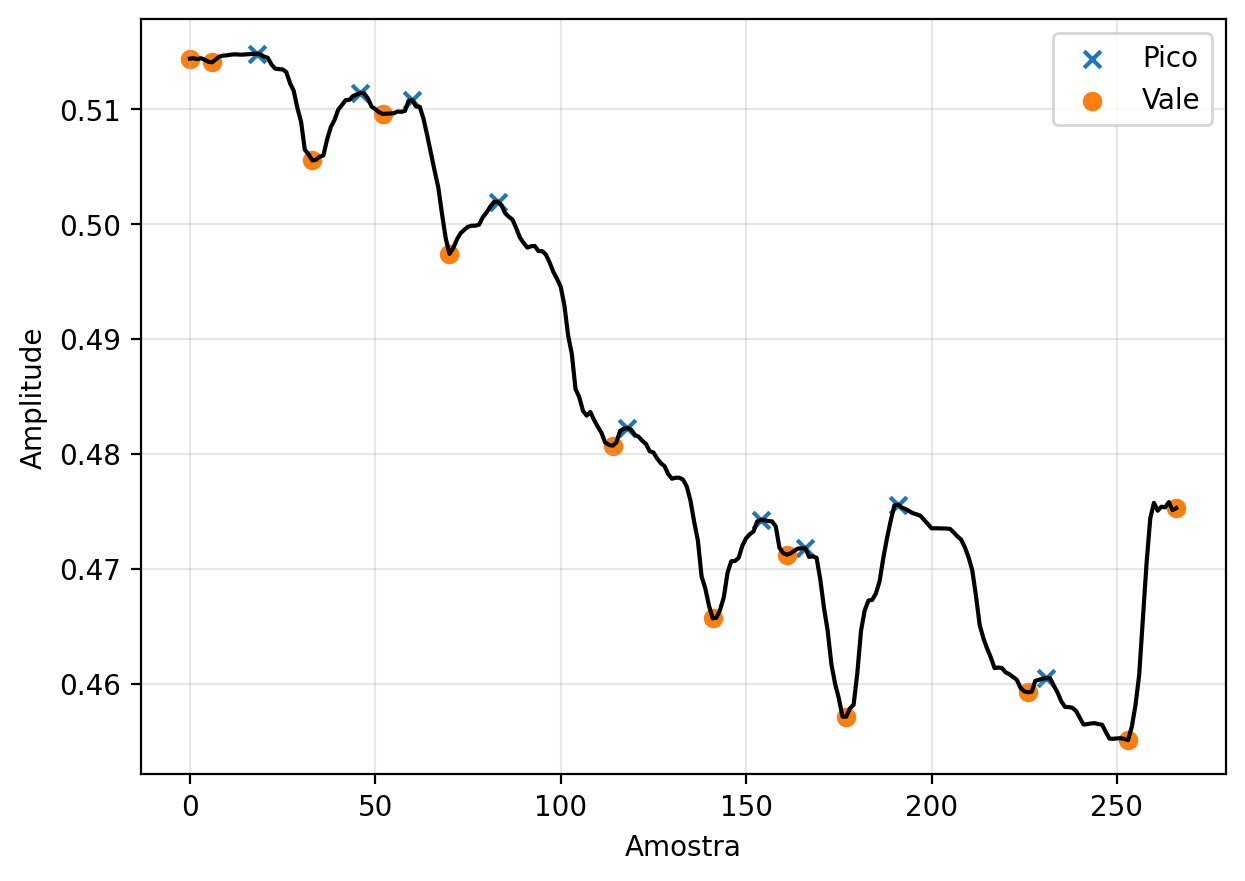

0.006793856620788574
[-0.00339299 -0.00065577 -0.00882739 -0.01969802 -0.00799674 -0.00246841
  0.00380236 -0.01511389]
[-0.00031221 -0.0085448   0.00404596 -0.01217064 -0.0167028  -0.01502585
  0.0055441  -0.01410055  0.00212708 -0.00416619  0.0201923 ]
n° de passos:  12
velocidade:  0.009160256117917178
velocidade em passos:  1.348314606741573
foot off:  65.1685393258427


In [159]:
from findpeaks import findpeaks
fp = findpeaks(method='peakdetect', lookahead=5)

def plot_pv(results):
    #retorna os picos e vales apenas
    peak   = results['df'][results['df']['peak'] == True]
    valley = results['df'][results['df']['valley'] == True]

    #Mostra o gráfico
    plt.figure(dpi=200, figsize=(7,5))
    plt.grid(alpha=0.3)
    plt.plot(results['df']['x'], results['df']['y'], color='k')
    plt.scatter(peak['x'], peak['y'], label='Pico', marker='x')
    plt.scatter(valley['x'], valley['y'], label='Vale', marker='o')
    plt.xlabel('Amostra')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

    return peak, valley

results1 = fp.fit(foot29_x)
peak, valley = plot_pv(results1)

dist_peaks  = np.diff(peak['y'])
dist_valley = np.diff(valley['y'])

step_lenght = abs(np.average(dist_peaks))

print(step_lenght)
print(dist_peaks)
print(dist_valley)

n_passos = len(valley)
velocidade_m = (n_passos * step_lenght)/tx[-1]
velocidade_p = (n_passos)/tx[-1]
print("n° de passos: ", n_passos)
print("velocidade: ", velocidade_m)
print("velocidade em passos: ", velocidade_p)
picos = peak.y
amostra = peak.x
#step_lenght = (picos[-1] - picos[0])/len(picos)

def countX(lst, x): 
    count = 0
    for ele in lst: 
        if (ele == x): 
            count = count + 1
    return count 

foot29r = np.round(foot29_x-0.0005, 3)

nfoot_on = 0

for pico in picos:
    nfoot_on += countX(foot29r, round(pico-0.0005, 3))
    #foot_on += foot29_x
    #nfoot_on += countX(foot29r, round(pico-0.0004, 3))
    #print(round(pico-0.0005, 3))
    
#print(nfoot_on)
#print(foot_on)
foot_off = abs(((len(foot29_x) - nfoot_on)/len(foot29_x))) *100
#print(len(foot29_x))
print("foot off: ", foot_off)

Obtenção do Centroide do Paralelogramo (Média entre as coordenadas dos vértices opostos)
(31x+30x/2,31y+30y/2)

In [160]:
centroidex = (foot31_x + foot30_x)/2
centroidey = (foot31_y + foot30_y)/2
centroide = (foot31_x + foot30_x)/2, (foot31_y + foot30_y)/2
print(centroidex)
print(centroidey)
transposta = list(map(lambda *i: [j for j in i], *centroide))
print(transposta)

#centroidex = transposta[:, 0]
#centroidey = transposta[:, 1]

[0.49723917 0.49718623 0.49705419 0.4971043  0.49712148 0.49741168
 0.49836522 0.49931346 0.5001556  0.50076596 0.50145543 0.50190181
 0.50254005 0.50242859 0.50221103 0.50227846 0.50228004 0.50231412
 0.50227688 0.50219938 0.50240558 0.50261106 0.5029334  0.50308739
 0.50311521 0.50333434 0.5035135  0.50323617 0.50265574 0.50164686
 0.50115032 0.50067498 0.50057498 0.5003019  0.5005946  0.50075427
 0.50132704 0.50150666 0.50156072 0.50146206 0.5013826  0.50159152
 0.50189947 0.50185755 0.5018643  0.50173399 0.50171174 0.50172754
 0.50158183 0.50163785 0.50177798 0.50172804 0.50171068 0.50066787
 0.49889313 0.49752685 0.49686596 0.49612531 0.49692364 0.49726619
 0.49822611 0.49806115 0.49798746 0.4979775  0.49701841 0.49595465
 0.49503642 0.4945059  0.49375443 0.49256632 0.49246259 0.49281752
 0.49303702 0.49327442 0.49375118 0.49311507 0.49261534 0.49258423
 0.49205574 0.49177322 0.49172862 0.49153009 0.49138071 0.49143711
 0.49142104 0.49120338 0.49050198 0.48942888 0.48832297 0.4866

Distância do CoG ao Centroide

[0.04261703 0.04393088 0.04626852 0.04760911 0.04867333 0.04891288
 0.04767482 0.04656699 0.0457741  0.04566108 0.04528332 0.04521013
 0.04495643 0.04518561 0.04585266 0.04627177 0.04665961 0.04631181
 0.04536779 0.04410532 0.04246211 0.0414547  0.04035606 0.0398009
 0.04093473 0.04179441 0.04201507 0.04218512 0.04271996 0.04263844
 0.04364654 0.04441855 0.04604219 0.04697402 0.04858681 0.04882298
 0.04879419 0.04844656 0.04803134 0.04755201 0.04726201 0.04663152
 0.04518833 0.04352194 0.04354694 0.04379191 0.04500715 0.04682835
 0.04831498 0.05073801 0.05339756 0.05611192 0.05801101 0.05955733
 0.06131758 0.06141628 0.06132196 0.06066804 0.05888545 0.05811938
 0.05686206 0.05734807 0.05792124 0.05622077 0.05538434 0.05573577
 0.05629177 0.05796797 0.05926088 0.06017895 0.06191127 0.0641483
 0.06408679 0.06366712 0.06372481 0.06270448 0.06274998 0.06307159
 0.06116471 0.05881539 0.05741038 0.05699883 0.05781385 0.0590699
 0.06075055 0.06508449 0.06924097 0.07281667 0.07538055 0.0775277

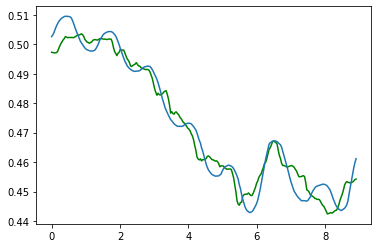

In [161]:
#Distância entre dois pontos
distancia_cog = np.sqrt((body_com_X-centroidex)**2) + ((body_com_Y-centroidey)**2)
print(distancia_cog)
print("distância média: ", np.average(distancia_cog))
for i in (distancia_cog):
    if(i != (len(distancia_cog)-1)):
        print(i, end=",")
    else: 
        print(i)
plt.plot(tx, centroidex, 'g')
plt.plot(tx, body_com_X)

Distância do CoG a borda da BoS

In [133]:
#Distância do ponto às 4 retas (usar o menor valor como distância)
from itertools import chain

norm = np.linalg.norm

# Creating points
p1 = np.array([foot31]) #ponta esquerda
p2 = np.array([foot29]) #calcanhar esquerdo
p3 = np.array([foot32]) #ponta direita
p4 = np.array([foot30]) #calcanhar direito
p5 = np.array([body_com]) #cog
'''
p1 = np.delete(foot31, 1, 1)
p2 = np.delete(foot29, 1, 1) #calcanhar esquerdo
p3 = np.delete(foot32, 1, 1) #ponta direita
p4 = np.delete(foot30, 1, 1) #calcanhar direito
p5 = np.delete(body_com, 1, 1) #cog
'''
# Finding distance of p3 from a 
# line connecting p1 and p2

dis12 = np.abs((np.cross(p2-p1, p1-p5))/norm(p2-p1))
dis13 = np.abs((np.cross(p3-p1, p1-p5))/norm(p3-p1))
dis24 = np.abs((np.cross(p2-p4, p4-p5))/norm(p2-p4))
dis34 = np.abs((np.cross(p3-p4, p4-p5))/norm(p3-p4))

#print(dis12)

#print(pp)

dis12x = dis12[:, :, 0]
dis13x = dis13[:, :, 0]
dis24x = dis24[:, :, 0]
dis34x = dis34[:, :, 0]

dis12y = dis12[:, :, 1]
dis13y = dis13[:, :, 1]
dis24y = dis24[:, :, 1]
dis34y = dis34[:, :, 1]

menor1x = np.minimum(dis12x, dis13x)
menor2x = np.minimum(dis24x, dis34x)
distanciax = np.minimum(menor1x, menor2x)
#print(distanciax)

menor1y = np.minimum(dis12y, dis13y)
menor2y = np.minimum(dis24y, dis34y)
distanciay = np.minimum(menor1y, menor2y)
#print(distanciay)

distancia_borda = np.minimum(distanciax, distanciay)
#print( distancia_borda)
distanciab_avg = np.average(distancia_borda)
distanciab_var = np.var(distancia_borda)
distanciab_desvio = np.std(distancia_borda)
print(distanciab_avg, distanciab_var, distanciab_desvio)
print("dstância até a borda: ", distanciab_avg)
'''
menor1 = np.minimum(dis12, dis13)
menor2 = np.minimum(dis24, dis34)
distanciab = np.minimum(menor1, menor2)

distanciab_avg = np.average(distanciab)
distanciab_var = np.var(distanciab)
distanciab_desvio = np.std(distanciab)
print(distanciab_avg, distanciab_var, distanciab_desvio)
'''

0.0003063957292482216 5.053255978659072e-08 0.00022479448344341264
dstância até a borda:  0.0003063957292482216


'\nmenor1 = np.minimum(dis12, dis13)\nmenor2 = np.minimum(dis24, dis34)\ndistanciab = np.minimum(menor1, menor2)\n\ndistanciab_avg = np.average(distanciab)\ndistanciab_var = np.var(distanciab)\ndistanciab_desvio = np.std(distanciab)\nprint(distanciab_avg, distanciab_var, distanciab_desvio)\n'

In [134]:
import math
#foot29 foot30 foot31 foot32
lado_direito = foot31_y - foot29_y
lado_esquerdo = foot32_y - foot30_y
diagonal_b = np.sqrt((foot29_x-foot30_x)**2) + ((foot29_y-foot30_y)**2)
diagonal_c = np.sqrt((foot31_x-foot32_x)**2) + ((foot31_y-foot32_y)**2)
#print(diagonal_b)
#print(diagonal_c)
centroide = [(diagonal_b+diagonal_c)/2, (lado_direito)]
h = foot29_x - foot30_x

In [135]:
def calculate_area(c):

    '''
    Calculates the area of any quadrivaletral
    from a list of x,y coordinates in the following format:

    [[x1,y1],[x2,y2],[x3,y3],[x4,y4]]
    '''

    first = c[0][0]*c[1][1] + c[1][0]*c[2][1] + c[2][0]*c[3][1] + c[3][0]*c[0][1]

    second = c[1][0]*c[0][1] + c[2][0]*c[1][1] + c[3][0]*c[2][1] + c[0][0]*c[3][1]

    area = 0.5*(first - second)

    return area

p1 = np.delete(foot31, 1, 1)
p2 = np.delete(foot29, 1, 1) #calcanhar esquerdo
p3 = np.delete(foot32, 1, 1) #ponta direita
p4 = np.delete(foot30, 1, 1) #calcanhar direito
c = np.concatenate((p1,p2,p3,p4), axis = 1)
area = calculate_area(c)
print(p1)

[[ 5.14625847e-01 -2.02464331e-02]
 [ 5.14537334e-01 -6.59838170e-02]
 [ 5.14614999e-01 -5.78282177e-02]
 [ 5.14690816e-01 -2.82114707e-02]
 [ 5.14672995e-01 -9.94489156e-03]
 [ 5.14883578e-01 -8.89050961e-03]
 [ 5.15031219e-01 -1.06205167e-02]
 [ 5.15157521e-01 -1.46443369e-02]
 [ 5.15292287e-01 -3.01913768e-02]
 [ 5.15484035e-01 -2.91518234e-02]
 [ 5.15560865e-01 -2.77438257e-02]
 [ 5.15650928e-01 -2.64137201e-02]
 [ 5.15783131e-01 -2.11868621e-02]
 [ 5.15780866e-01 -1.83896087e-02]
 [ 5.15782475e-01 -1.67985801e-02]
 [ 5.15979171e-01 -1.64386909e-02]
 [ 5.16022861e-01 -2.10759789e-02]
 [ 5.15985608e-01 -2.22744755e-02]
 [ 5.15724778e-01 -4.38150624e-03]
 [ 5.15419006e-01 -8.13282281e-03]
 [ 5.15338242e-01  4.64462675e-03]
 [ 5.15621543e-01  1.54768694e-02]
 [ 5.15942752e-01  5.88402152e-03]
 [ 5.16085982e-01  7.25688506e-03]
 [ 5.16058087e-01  3.89472656e-02]
 [ 5.16371906e-01  8.43268186e-02]
 [ 5.16467273e-01  1.00901328e-01]
 [ 5.15945256e-01  8.92934427e-02]
 [ 5.14817476e-01  7

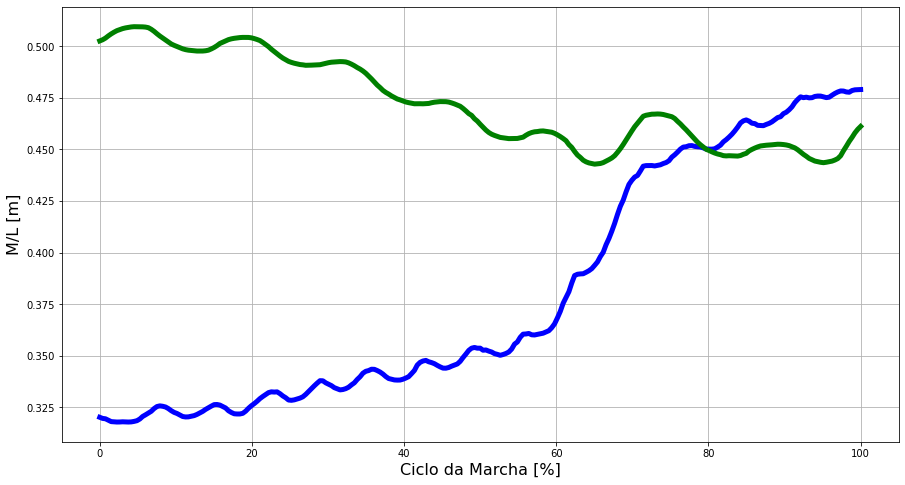

In [136]:
plt.figure(figsize=[15,8])
plt.plot(GaitCycle, body_com_Y, color = 'b', linewidth = 5)
plt.plot(GaitCycle, body_com_X, color = 'g', linewidth = 5)
#plt.plot(tx, foot_com_X1, color = 'b', linewidth = 5)
#plt.plot(foot_com_X1, foot_com_Y1, color = 'y', linewidth = 5)
plt.ylabel('M/L [m]', fontsize=16)
plt.xlabel('Ciclo da Marcha [%]', fontsize=16)
#plt.title('Excursão vertical do CoM na marcha', fontsize=16)
#plt.plot(ty1, foot_y12, 'go')
#plt.plot(tx1, foot_x12, 'ro')
#plt.plot(foot_xj2, foot_yj2, 'g')
#plt.plot(foot_xi2, foot_yi2, 'r')
#plt.plot(ty, foot29_y, 'go')
#plt.plot(ty, foot30_y, 'ro')
#plt.plot(foot_x12, foot_y12, 'ro')
plt.grid()
plt.show()

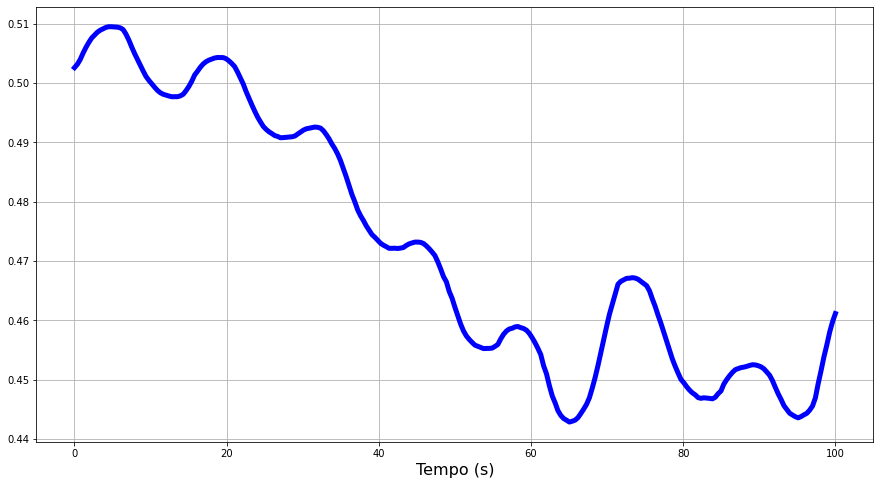

In [137]:
plt.figure(figsize=[15,8])
plt.plot(GaitCycle, body_com_X, color = 'b', linewidth = 5)
#plt.plot(tx, foot_com_X1, color = 'b', linewidth = 5)
#plt.plot(foot_com_X1, foot_com_Y1, color = 'y', linewidth = 5)
#plt.ylabel('A/P', fontsize=16)
plt.xlabel('Tempo (s)', fontsize=16)
#plt.title('Excursão vertical do CoM na marcha', fontsize=16)
#plt.plot(ty1, foot_y12, 'go')
#plt.plot(tx1, foot_x12, 'ro')
#plt.plot(foot_xj2, foot_yj2, 'g')
#plt.plot(foot_xi2, foot_yi2, 'r')
#plt.plot(tx, foot29_x, 'go')
#plt.plot(tx, foot30_x, 'ro')
#plt.plot(foot_x12, foot_y12, 'ro')
plt.grid()
plt.show()

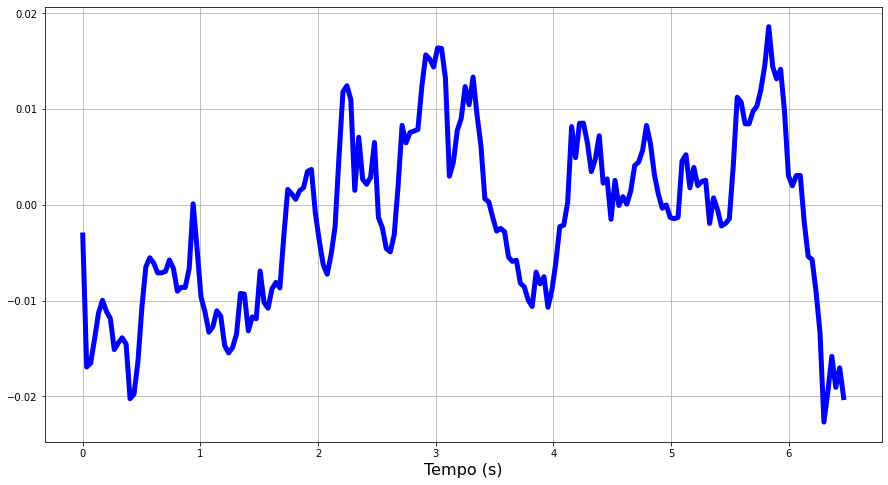

In [80]:

plt.figure(figsize=[15,8])
plt.plot(tz, body_com_Z, color = 'b', linewidth = 5)
#plt.plot(tx, foot_com_X1, color = 'b', linewidth = 5)
#plt.plot(foot_com_X1, foot_com_Y1, color = 'y', linewidth = 5)
#plt.ylabel('A/P', fontsize=16)
plt.xlabel('Tempo (s)', fontsize=16)
#plt.title('Excursão vertical do CoM na marcha', fontsize=16)
#plt.plot(ty1, foot_y12, 'go')
#plt.plot(tx1, foot_x12, 'ro')
#plt.plot(foot_xj2, foot_yj2, 'g')
#plt.plot(foot_xi2, foot_yi2, 'r')
#plt.plot(tx, foot29_x, 'go')
#plt.plot(tx, foot30_x, 'ro')
#plt.plot(foot_x12, foot_y12, 'ro')
plt.grid()
plt.show()

[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..


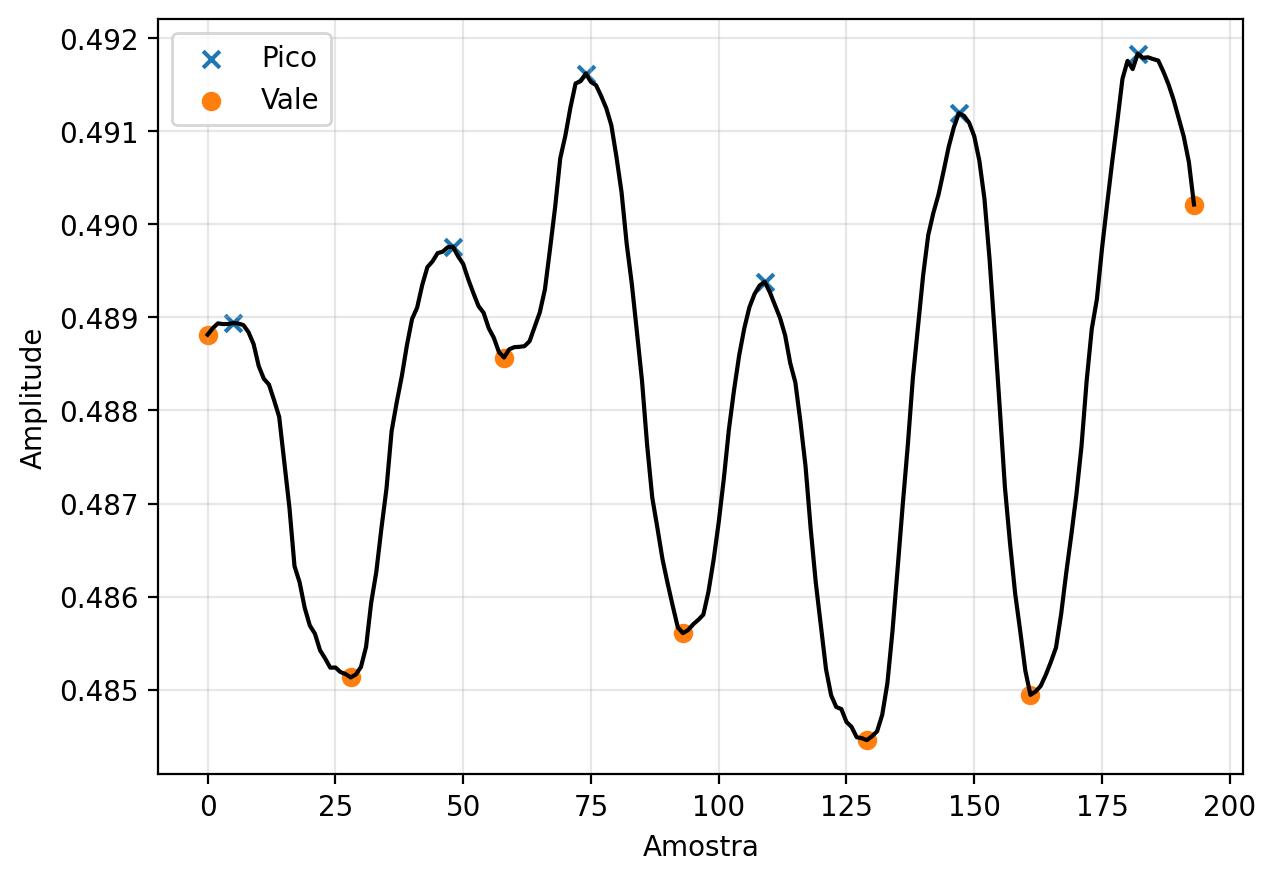

[43 26 35 38 35]
[28 30 35 36 32 32]


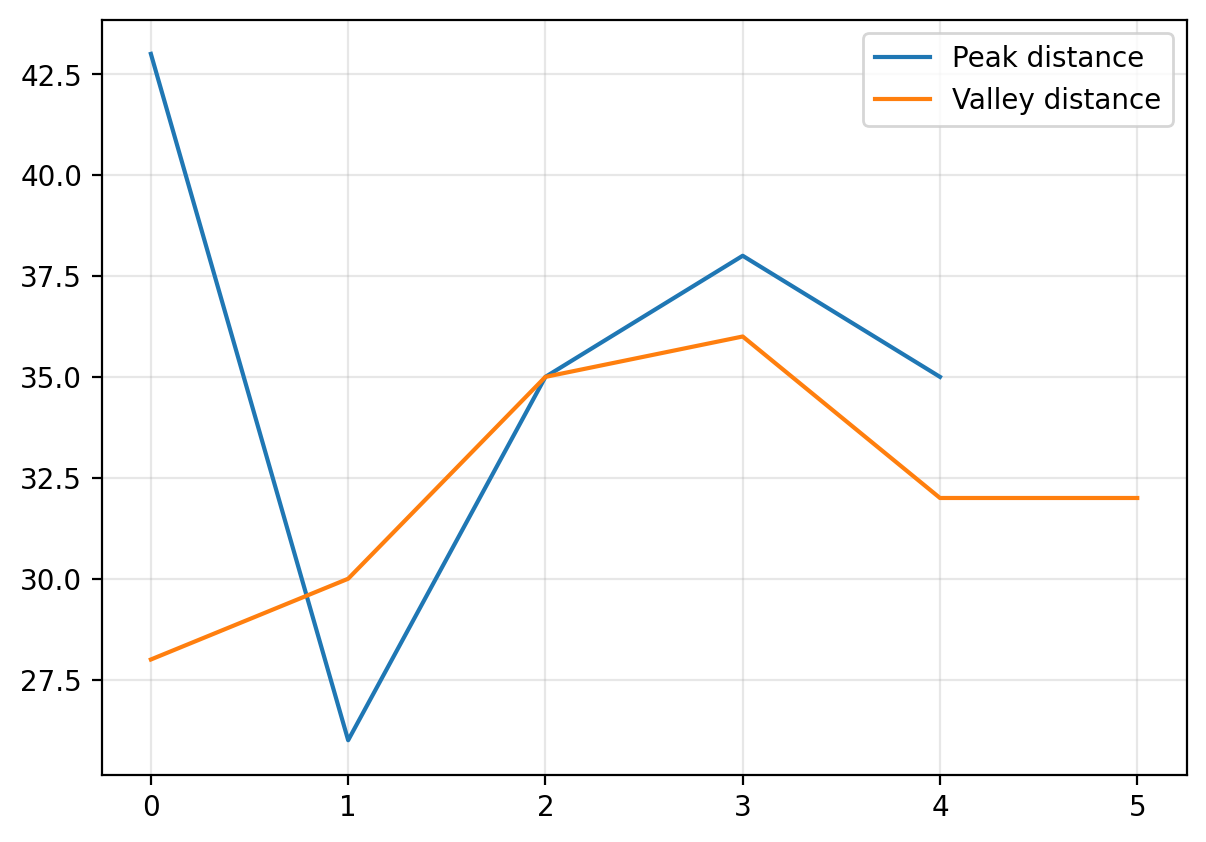

7


In [81]:


#Chama a função com os resultados obtidos anteriormente
#matriz = np.concatenate((tx, filteredx))
results = fp.fit(body_com_X)
peak, valley = plot_pv(results)

dist_peaks  = np.diff(peak['x'])
dist_valley = np.diff(valley['x'])

print(dist_peaks)
print(dist_valley)

plt.figure(dpi=200, figsize=(7,5))
plt.grid(alpha=0.3)
plt.plot(dist_peaks, label='Peak distance')
plt.plot(dist_valley, label='Valley distance')
plt.legend()
plt.show()

print(len(valley))

In [82]:
#print(2*filteredx[45]-filteredx[0])

# Filtragem

In [91]:
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt

In [92]:
# apply a 2-pole lowpass filter at 0.15x Nyquist frequency (15 hz is half the max frequency of the video (30Hz))
bx, ax = scipy.signal.butter(2, 0.2)
filteredx = scipy.signal.filtfilt(bx, ax, body_com_X, axis=0)

by, ay = scipy.signal.butter(2, 0.2)
filteredy = scipy.signal.filtfilt(by, ay, body_com_Y, axis=0)

bz, az = scipy.signal.butter(2, 0.2)
filteredz = scipy.signal.filtfilt(bz, az, body_com_Z, axis=0)

b30z, a30z = scipy.signal.butter(2, 0.2)
filtered30z = scipy.signal.filtfilt(b30z, a30z, foot30_z, axis=0)

b29z, a29z = scipy.signal.butter(2, 0.2)
filtered29z = scipy.signal.filtfilt(b29z, a29z, foot29_z, axis=0)

b30y, a30y = scipy.signal.butter(2, 0.2)
filtered30y = scipy.signal.filtfilt(b30y, a30y, foot30_y, axis=0)

b29y, a29y = scipy.signal.butter(2, 0.2)
filtered29y = scipy.signal.filtfilt(b29y, a29y, foot29_y, axis=0)

b30x, a30x = scipy.signal.butter(2, 0.2)
filtered30x = scipy.signal.filtfilt(b30x, a30x, foot30_x, axis=0)

b29x, a29x = scipy.signal.butter(2, 0.2)
filtered29x = scipy.signal.filtfilt(b29x, a29x, foot29_x, axis=0)


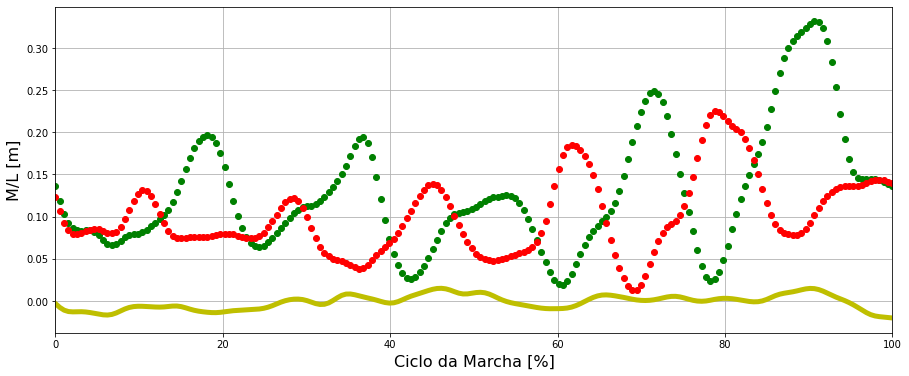

In [93]:
plt.figure(figsize=[15, 6])
plt.plot(GaitCycle, filteredz, color = 'y', linewidth = 5)
plt.ylabel('M/L [m]', fontsize=16)
plt.xlabel('Ciclo da Marcha [%]', fontsize=16)
plt.plot(GaitCycle, filtered30z, 'go')
plt.plot(GaitCycle, filtered29z, 'ro')
#plt.title('Excursão vertical com filtro Butterworth', fontsize=16)
plt.xlim(0, 100)
#plt.ylim(0.03, 0.07)
plt.grid()
plt.show()

[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..


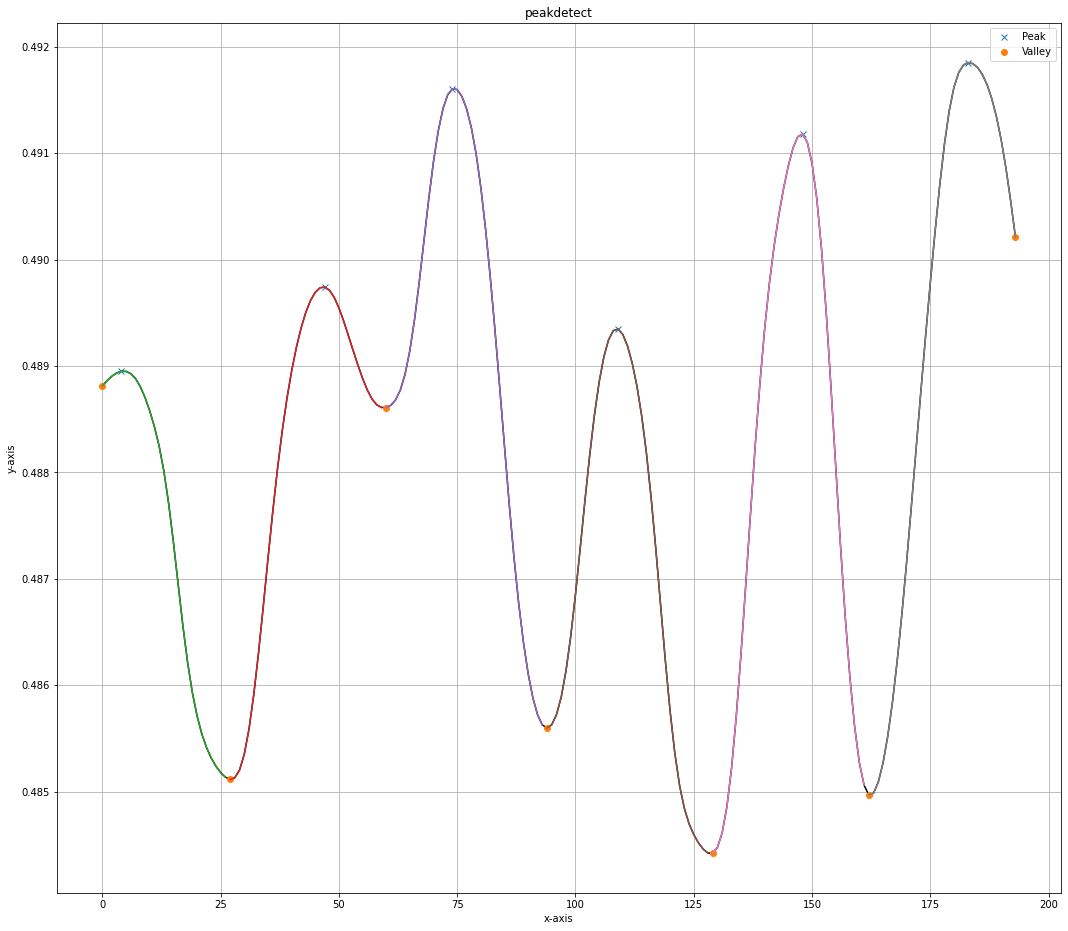

(None,
 <AxesSubplot:title={'center':'peakdetect'}, xlabel='x-axis', ylabel='y-axis'>)

In [94]:

results = fp.fit(filteredx)
fp.plot(figsize=(18,16))


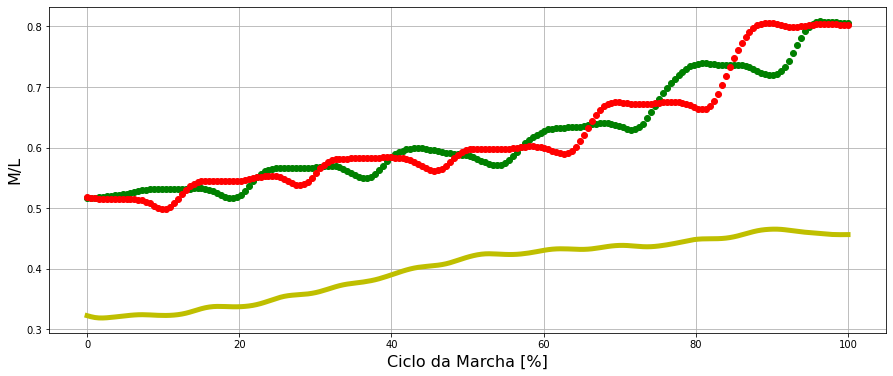

In [95]:
plt.figure(figsize=[15, 6])
plt.plot(GaitCycle, filteredy, color = 'y', linewidth = 5)
plt.ylabel('M/L', fontsize=16)
plt.xlabel('Ciclo da Marcha [%]', fontsize=16)
plt.plot(GaitCycle, filtered30y, 'go')
plt.plot(GaitCycle, filtered29y, 'ro')
#plt.ylim(0.6, 0.9)
#plt.title('', fontsize=16)
plt.grid()
plt.show()

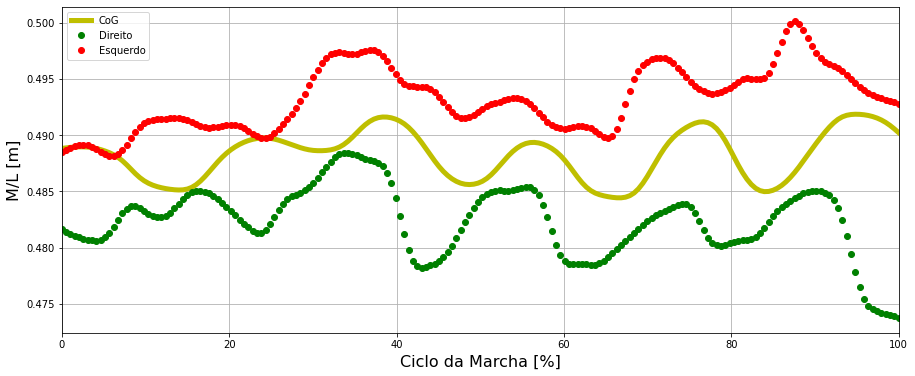

In [96]:
plt.figure(figsize=[15, 6])
plt.plot(GaitCycle, filteredx, color = 'y', linewidth = 5)
plt.ylabel('M/L [m]', fontsize=16)
plt.xlabel('Ciclo da Marcha [%]', fontsize=16)
plt.plot(GaitCycle, filtered30x, 'go')
plt.plot(GaitCycle, filtered29x, 'ro')
plt.xlim(0, 100)
plt.legend(['CoG', 'Direito', 'Esquerdo'])
#plt.title('Excursão vertical com filtro Butterworth', fontsize=16)
plt.grid()
plt.show()

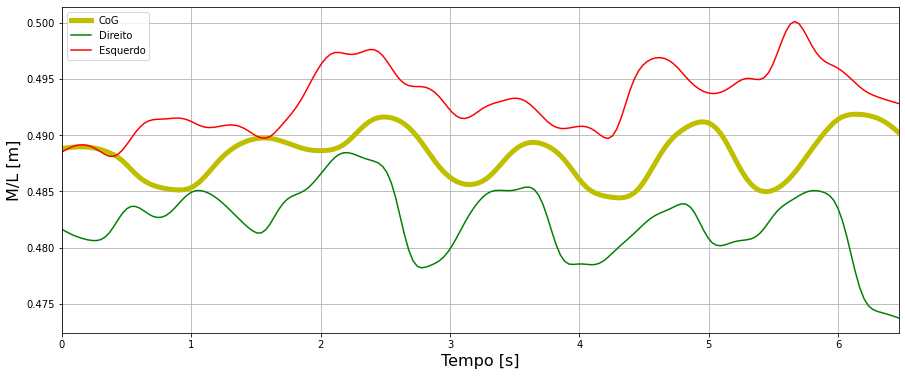

In [97]:
plt.figure(figsize=[15, 6])
plt.plot(tx, filteredx, color = 'y', linewidth = 5)
plt.ylabel('M/L [m]', fontsize=16)
plt.xlabel('Tempo [s]', fontsize=16)
plt.plot(tx, filtered30x, 'g')
plt.plot(tx, filtered29x, 'r')
plt.xlim(0, tx[-1])
plt.legend(['CoG', 'Direito', 'Esquerdo'])
#plt.title('Excursão vertical com filtro Butterworth', fontsize=16)
plt.grid()
plt.show()

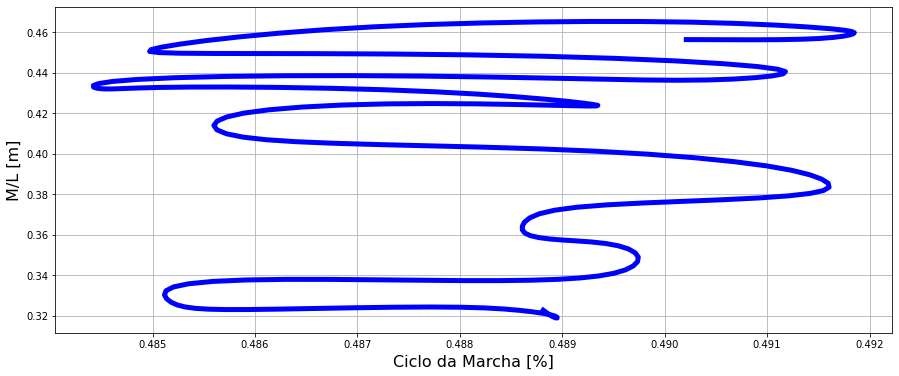

In [98]:
plt.figure(figsize=[15, 6])
#plt.plot(GaitCycle, filteredx, color = 'y', linewidth = 5)
plt.plot(filteredx, filteredy, color = 'b', linewidth = 5)
plt.ylabel('M/L [m]', fontsize=16)
plt.xlabel('Ciclo da Marcha [%]', fontsize=16)
#plt.plot(GaitCycle, filtered30x, 'go')
#plt.plot(GaitCycle, filtered29x, 'ro')
#plt.xlim(0, 100)
#plt.legend(['CoG', 'Direito', 'Esquerdo'])
#plt.title('Excursão vertical com filtro Butterworth', fontsize=16)
plt.grid()
plt.show()

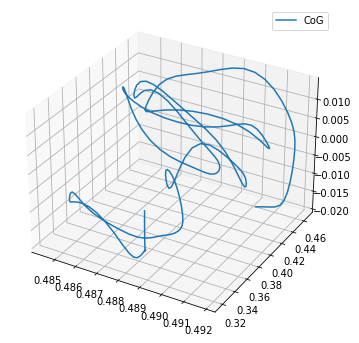

In [99]:
from mpl_toolkits.mplot3d import axes3d

ax = plt.figure(figsize=[15, 6]).add_subplot(projection='3d')

ax.plot(filteredx, filteredy, filteredz, label='CoG')
ax.legend()
plt.show()

ICC

In [100]:
print(filteredx)

[0.48881369 0.48886222 0.48890401 0.48893405 0.48894992 0.48894941
 0.48892866 0.48888276 0.48880845 0.48870646 0.48858041 0.48843058
 0.48824728 0.48801275 0.48771295 0.48735151 0.48695545 0.48656621
 0.48622059 0.48593691 0.48571549 0.48554645 0.48541721 0.48531742
 0.48523991 0.48517996 0.4851366  0.48511563 0.48513123 0.4852035
 0.48535237 0.48558931 0.48591112 0.48630108 0.48673512 0.48718568
 0.48762409 0.488027   0.48838279 0.48869001 0.48895165 0.48917227
 0.4893559  0.48950385 0.48961592 0.48969268 0.48973493 0.48974198
 0.48971208 0.48964532 0.48954609 0.48942296 0.48928665 0.48914692
 0.48901088 0.48888441 0.48877466 0.48868982 0.48863539 0.48861052
 0.48861005 0.48863194 0.48868259 0.48877552 0.48892621 0.4891468
 0.48944064 0.4897965  0.49018674 0.49057398 0.49092302 0.49120906
 0.4914187  0.49154888 0.49160516 0.49159729 0.49153334 0.49141539
 0.49123866 0.49099469 0.49067717 0.49028705 0.48983338 0.48933005
 0.48879288 0.48824154 0.48770248 0.48720478 0.48676967 0.486405

In [162]:
#d1 = [0.05607717628258551,0.053800434300343696,0.05479363575475785,0.05441003805860401,0.053709222150222904,0.05424615269603079,0.054953989136606964,0.054980204527609565,0.0545300882350255,0.05358694384537437,0.052673007960735124,0.052172948873708366,0.05153272797372292,0.050497025259708075,0.04925917924220271,0.0493250038648287,0.048539163610030654,0.048220811452854256,0.047647371390474466,0.046365854241283845,0.04453487204545793,0.04297794547440987,0.04146360683414083,0.04106115059537151,0.04357755621836548,0.04600635677632254,0.04772699359092862,0.04924425765890457,0.04986018079518538,0.0504525947059115,0.050934058198871215,0.051335809995094836,0.049766123782034634,0.049356979427402345,0.04863192323223704,0.04874559760136111,0.04828762053125974,0.04888474591033269,0.049732345037834996,0.049247794427483116,0.047469339132108594,0.04537024891018496,0.04317652041398336,0.04026492697701936,0.041765964889559956,0.042332139447400836,0.04178645942816306,0.04332197575298988,0.04416744443054016,0.04658000861982364,0.04973730377289429,0.05375559306854182,0.0571111040692014,0.058789157409975035,0.0606194123609418,0.06061039732500791,0.060424558102046125,0.06379006134811353,0.06274983562809033,0.06190127153972381,0.06095160169429815,0.05916259157623961,0.05184903899508861,0.04737442894215341,0.05030869652055335,0.0526838866183448,0.05559905876184867,0.0599301456702628,0.06406537214616904,0.06524573328326201,0.0666898974195676,0.07218159145161951,0.0724772337302653,0.07194430718850432,0.07096246391506444,0.06525526257452322,0.0625304267275095,0.05745152649511251,0.05861751114545539,0.06003592204444793,0.06001415155707408,0.06422383024325595,0.06761891254932778,0.07149992515729607,0.07972871999087205,0.08305348230931957,0.09014983579755022,0.08984637596124216,0.08992366054681661,0.09482873856357615,0.0914628005122915,0.08682110229114322,0.07900944368999457,0.07795936099251258,0.08568532010671522,0.09118117900548936,0.09164019177850773,0.09279988973501813,0.09493637398055829,0.10170743728804375,0.10564630413523747,0.10794075100883474,0.10649651101567942,0.11001804850709468,0.11061602732251684,0.10577944898610525,0.10314606185523167,0.10080343569271187,0.09850355889466585,0.0966283501712187,0.0904992170824117,0.0878084481371357,0.09018468845707144,0.09364264611749144,0.09832317707022689,0.10469014615414708,0.11900797879462664,0.12933846762089427,0.13876559218049672,0.14707746918027592,0.1521573622573607,0.15362656231946253,0.15354601298240023,0.14661081988605046,0.14109545156698672,0.1423286472905364,0.13460058869702082,0.12939317434165948,0.12544272176306315,0.1237949759254444,0.1304526691745158,0.14066132069933784,0.1510665915744781,0.16341951998024487,0.19101569639367272,0.20099210490973551,0.19958845159996932,0.19111176492224727,0.19405306868470454,0.18855356272465942,0.18243079364061657,0.1736684203940782,0.17000441886075546,0.1709851421971183,0.1711958502028941,0.17353179491629764,0.1724734516765004,0.17863417430261697,0.18948723512443993,0.20560001439413716,0.2153088603679085,0.21680722399534597,0.22428039963908955,0.2251344736655055,0.21940948237865623,0.2185690467744125,0.21627141650560927,0.20942487773665439,0.19394987567345706,0.19304173325311103,0.19238315282004498,0.1939770179024458,0.19651577439845955,0.20577385851214852,0.2147219727458993,0.2264918937367508,0.24472975176379114,0.24428705822674562,0.23046828777830403,0.21750947638878776,0.2021070724341441,0.18658189966699001,0.17465306951995643,0.16050364391963695,0.15349352681566458,0.13776675770772065,0.12769416970776054,0.11657022213292444,0.11817084421358567,0.11758501359801576,0.1171623774386599,0.12034794756300521,0.12640397288930066,0.133224230015146,0.13519325190600046,0.1369214886297281,0.13587632026728202,0.13475244991925328,0.13420605166110727,0.1332734648266231,0.1325395411775265,0.1308489629228045,0.12909111639217002,0.1276760736282304,0.12677487591504172,0.1255646907626827,0.12643218849686963,0.1257826041107778,0.12521638631014836,0.1243654245537965,0.1241131286119006,0.12342620033682827,0.12321817032088556,0.1241227861906908,0.12488651024548551,0.12563444792025164,0.12676823678120178,0.12757652345351275,0.1280367060694444,0.12822343383449047,0.12839394082734654,0.12876556423744806]

#d2 = [0.04261703222478948,0.04393087954805779,0.046268521176173166,0.04760910558976114,0.04867333399289949,0.0489128773975094,0.047674820681390104,0.046566985398343315,0.045774100037092355,0.04566107585273933,0.04528332068473755,0.04521013367721339,0.044956429612957406,0.04518560568773004,0.045852656262522815,0.046271767078514936,0.046659610729954996,0.0463118145331266,0.04536778636222732,0.04410531544131761,0.04246211489241107,0.041454695219008936,0.04035606092031345,0.03980089647231286,0.0409347287885932,0.041794408987789966,0.0420150672472834,0.042185122202108453,0.042719959551612535,0.04263843516807947,0.043646537909175255,0.04441855281130439,0.04604219075782592,0.0469740153419049,0.04858680690288249,0.04882297923145743,0.04879418870969399,0.04844655840871315,0.04803134476432894,0.04755201490436624,0.0472620080946514,0.04663151903060432,0.045188330405523155,0.04352194185718612,0.043546937345222074,0.04379190995211422,0.0450071474297039,0.04682835033256866,0.04831497930308644,0.05073800928912403,0.053397562308565835,0.05611191788647442,0.058011012280385535,0.05955733252952022,0.0613175792153781,0.06141627540362414,0.06132195836801831,0.06066804348817848,0.05888545186813647,0.05811937634921871,0.05686206441493963,0.057348065967798005,0.05792123762862878,0.05622076859998822,0.05538433543939836,0.05573577049034525,0.05629176621832876,0.05796797249694863,0.05926088361584041,0.06017895273098272,0.0619112730015608,0.06414830070739362,0.06408678894704072,0.06366712356714682,0.06372481243316887,0.06270448289432946,0.06274998138051069,0.06307159083517365,0.06116471388063361,0.058815390788806945,0.057410376813488095,0.05699882834918678,0.05781384687845169,0.05906990165282268,0.06075054747308123,0.06508448817590973,0.06924097488054655,0.07281666705900232,0.0753805456109174,0.07752773431941581,0.07898750074854205,0.07992864187309057,0.08166225610284106,0.07922001670836033,0.07801018414037933,0.07762817702199068,0.07738962507534596,0.07896212737481208,0.0806962806571018,0.08111795453496651,0.08260481875439668,0.08277663171067459,0.08373538937884104,0.08442299065321449,0.0845825185328449,0.08875780559275682,0.09001887111225149,0.09152094769288843,0.09168680582202574,0.0925697457298769,0.09125215498070814,0.09129385837010542,0.09159129134150237,0.09192920857771242,0.09012199459508628,0.08694882283518059,0.08363900859842698,0.08137314773928328,0.08268841020062517,0.08471674231178412,0.0872440132804153,0.09193288108563137,0.09923216339395625,0.1062441834421339,0.10985903274264837,0.1127124823981956,0.11521268428891544,0.11799439345716098,0.11793253359163393,0.11687609557838818,0.11502255097144884,0.11372505943683885,0.11232853660574592,0.11149535971119633,0.11031466591809307,0.1113320244063382,0.11255025470689159,0.11355453231104212,0.11507544859802593,0.11934589320927684,0.12312830097993298,0.12784619663565788,0.13190405569626076,0.1347637563231693,0.13601829170309324,0.1348918398904538,0.13342488832901148,0.1319343450427218,0.13252886028073815,0.13224888813646782,0.13032471642352947,0.12753838401402887,0.12463569470174227,0.12213907366479604,0.12150025056775021,0.12231244053528449,0.12473329469962001,0.12912670929517148,0.13570220474204653,0.14209376852796418,0.14664083714613524,0.1491239749415366,0.15008722050696877,0.14889224308820845,0.14523210652447155,0.13967899092188496,0.13382288811596363,0.1295864295532668,0.12859732792302528,0.12896144046418784,0.12561969057387062,0.12184625231985378,0.11877208397958504,0.11705046712246239,0.11460446486197368,0.11200830230310038,0.11319578510374426,0.11102144536208212,0.11009761745496624,0.10930042056506081,0.10480570111652075,0.09990488287164706,0.09499012025209072,0.0890780939610383,0.08352696493793954,0.07772992434619219,0.07169010515603262,0.06481460445507525,0.06013683771397799,0.055167632504798884,0.05174716719769389,0.05044017544034469,0.05145551448632487,0.051820365696797106,0.05430946796052187,0.05761351387136957,0.06047957715005895,0.06230523215013801,0.06596221862254344,0.06833186668751275,0.07010338346828508,0.07153291608529933,0.0707215465262627,0.06924188415427401,0.06777613187353104,0.06681608254077556,0.06608137389185187,0.06788812116739669,0.06975930880406934,0.07201224531172232,0.07336351731665015,0.07431539273602367,0.07604581314828385,0.07826354967114123,0.08066021466584387,0.0828818065405554,0.08566621248536109,0.08854167832639064,0.09049076015255386,0.09140103158305737,0.09272732108209833,0.09248686291097989,0.09088564932515886,0.08774031932690582,0.08864936787539539,0.08873313249276196,0.08825767552173859,0.08818297863990074,0.08761663386432232,0.08604296593022723,0.0869022153913997,0.08760267862869986,0.08835598817830573,0.09342952227334098,0.10038385757621422,0.10697497527275426,0.11473995722795503,0.12016875641697215,0.1225634349121671,0.1256833434814018,0.12624355937564188,0.1291902153444826,0.12916009073932877,0.1301876514580428,0.12762515054747195,0.1265014732043918,0.12640447171178812,0.12552215901931024,0.12343054198768827,0.12257800608555568,0.12173256990851726,0.12322152884810549,0.12575390208962478,0.1299949812634561,0.13772411723208225,0.14596173869525053,0.15634992757084715,0.16359295361953424,0.1676241603878795,0.16788031259253486,0.1657300163340936,0.16374952752336394,0.16155379620490995,0.16339898707234238,0.16510283402857814,0.16678005441139446,0.16785089881162796]

d1 = [0.05607717628258551,0.053800434300343696,0.05479363575475785,0.05441003805860401,0.053709222150222904,0.05424615269603079,0.054953989136606964,0.054980204527609565,0.0545300882350255,0.05358694384537437,0.052673007960735124,0.052172948873708366,0.05153272797372292,0.050497025259708075,0.04925917924220271,0.0493250038648287,0.048539163610030654,0.048220811452854256,0.047647371390474466,0.046365854241283845,0.04453487204545793,0.04297794547440987,0.04146360683414083,0.04106115059537151,0.04357755621836548,0.04600635677632254,0.04772699359092862,0.04924425765890457,0.04986018079518538,0.0504525947059115,0.050934058198871215,0.051335809995094836,0.049766123782034634,0.049356979427402345,0.04863192323223704,0.04874559760136111,0.04828762053125974,0.04888474591033269,0.049732345037834996,0.049247794427483116,0.047469339132108594,0.04537024891018496,0.04317652041398336,0.04026492697701936,0.041765964889559956,0.042332139447400836,0.04178645942816306,0.04332197575298988,0.04416744443054016,0.04658000861982364,0.04973730377289429,0.05375559306854182,0.0571111040692014,0.058789157409975035,0.0606194123609418,0.06061039732500791,0.060424558102046125,0.06379006134811353,0.06274983562809033,0.06190127153972381,0.06095160169429815,0.05916259157623961,0.05184903899508861,0.04737442894215341,0.05030869652055335,0.0526838866183448,0.05559905876184867,0.0599301456702628,0.06406537214616904,0.06524573328326201,0.0666898974195676,0.07218159145161951,0.0724772337302653,0.07194430718850432,0.07096246391506444,0.06525526257452322,0.0625304267275095,0.05745152649511251,0.05861751114545539,0.06003592204444793,0.06001415155707408,0.06422383024325595,0.06761891254932778,0.07149992515729607,0.07972871999087205,0.08305348230931957,0.09014983579755022,0.08984637596124216,0.08992366054681661,0.09482873856357615,0.0914628005122915,0.08682110229114322,0.07900944368999457,0.07795936099251258,0.08568532010671522,0.09118117900548936,0.09164019177850773,0.09279988973501813,0.09493637398055829,0.10170743728804375,0.10564630413523747,0.10794075100883474,0.10649651101567942,0.11001804850709468,0.11061602732251684,0.10577944898610525,0.10314606185523167,0.10080343569271187,0.09850355889466585,0.0966283501712187,0.0904992170824117,0.0878084481371357,0.09018468845707144,0.09364264611749144,0.09832317707022689,0.10469014615414708,0.11900797879462664,0.12933846762089427,0.13876559218049672,0.14707746918027592,0.1521573622573607,0.15362656231946253,0.15354601298240023,0.14661081988605046,0.14109545156698672,0.1423286472905364,0.13460058869702082,0.12939317434165948,0.12544272176306315,0.1237949759254444,0.1304526691745158,0.14066132069933784,0.1510665915744781,0.16341951998024487,0.19101569639367272,0.20099210490973551,0.19958845159996932,0.19111176492224727,0.19405306868470454,0.18855356272465942,0.18243079364061657,0.1736684203940782,0.17000441886075546,0.1709851421971183,0.1711958502028941,0.17353179491629764,0.1724734516765004,0.17863417430261697,0.18948723512443993,0.20560001439413716,0.2153088603679085,0.21680722399534597,0.22428039963908955,0.2251344736655055,0.21940948237865623,0.2185690467744125,0.21627141650560927,0.20942487773665439,0.19394987567345706,0.19304173325311103,0.19238315282004498,0.1939770179024458,0.19651577439845955,0.20577385851214852,0.2147219727458993,0.2264918937367508,0.24472975176379114,0.24428705822674562,0.23046828777830403,0.21750947638878776,0.2021070724341441,0.18658189966699001,0.17465306951995643,0.16050364391963695,0.15349352681566458,0.13776675770772065,0.12769416970776054,0.11657022213292444,0.11817084421358567,0.11758501359801576,0.1171623774386599,0.12034794756300521,0.12640397288930066,0.133224230015146,0.13519325190600046,0.1369214886297281,0.13587632026728202,0.13475244991925328,0.13420605166110727,0.1332734648266231,0.1325395411775265,0.1308489629228045,0.12909111639217002,0.1276760736282304,0.12677487591504172,0.1255646907626827,0.12643218849686963,0.1257826041107778,0.12521638631014836,0.1243654245537965,0.1241131286119006,0.12342620033682827,0.12321817032088556,0.1241227861906908,0.12488651024548551,0.12563444792025164,0.12676823678120178,0.12757652345351275,0.1280367060694444,0.12822343383449047,0.12839394082734654,0.12876556423744806]

d2 = [0.04261703222478948,0.04393087954805779,0.046268521176173166,0.04760910558976114,0.04867333399289949,0.0489128773975094,0.047674820681390104,0.046566985398343315,0.045774100037092355,0.04566107585273933,0.04528332068473755,0.04521013367721339,0.044956429612957406,0.04518560568773004,0.045852656262522815,0.046271767078514936,0.046659610729954996,0.0463118145331266,0.04536778636222732,0.04410531544131761,0.04246211489241107,0.041454695219008936,0.04035606092031345,0.03980089647231286,0.0409347287885932,0.041794408987789966,0.0420150672472834,0.042185122202108453,0.042719959551612535,0.04263843516807947,0.043646537909175255,0.04441855281130439,0.04604219075782592,0.0469740153419049,0.04858680690288249,0.04882297923145743,0.04879418870969399,0.04844655840871315,0.04803134476432894,0.04755201490436624,0.0472620080946514,0.04663151903060432,0.045188330405523155,0.04352194185718612,0.043546937345222074,0.04379190995211422,0.0450071474297039,0.04682835033256866,0.04831497930308644,0.05073800928912403,0.053397562308565835,0.05611191788647442,0.058011012280385535,0.05955733252952022,0.0613175792153781,0.06141627540362414,0.06132195836801831,0.06066804348817848,0.05888545186813647,0.05811937634921871,0.05686206441493963,0.057348065967798005,0.05792123762862878,0.05622076859998822,0.05538433543939836,0.05573577049034525,0.05629176621832876,0.05796797249694863,0.05926088361584041,0.06017895273098272,0.0619112730015608,0.06414830070739362,0.06408678894704072,0.06366712356714682,0.06372481243316887,0.06270448289432946,0.06274998138051069,0.06307159083517365,0.06116471388063361,0.058815390788806945,0.057410376813488095,0.05699882834918678,0.05781384687845169,0.05906990165282268,0.06075054747308123,0.06508448817590973,0.06924097488054655,0.07281666705900232,0.0753805456109174,0.07752773431941581,0.07898750074854205,0.07992864187309057,0.08166225610284106,0.07922001670836033,0.07801018414037933,0.07762817702199068,0.07738962507534596,0.07896212737481208,0.0806962806571018,0.08111795453496651,0.08260481875439668,0.08277663171067459,0.08373538937884104,0.08442299065321449,0.0845825185328449,0.08875780559275682,0.09001887111225149,0.09152094769288843,0.09168680582202574,0.0925697457298769,0.09125215498070814,0.09129385837010542,0.09159129134150237,0.09192920857771242,0.09012199459508628,0.08694882283518059,0.08363900859842698,0.08137314773928328,0.08268841020062517,0.08471674231178412,0.0872440132804153,0.09193288108563137,0.09923216339395625,0.1062441834421339,0.10985903274264837,0.1127124823981956,0.11521268428891544,0.11799439345716098,0.11793253359163393,0.11687609557838818,0.11502255097144884,0.11372505943683885,0.11232853660574592,0.11149535971119633,0.11031466591809307,0.1113320244063382,0.11255025470689159,0.11355453231104212,0.11507544859802593,0.11934589320927684,0.12312830097993298,0.12784619663565788,0.13190405569626076,0.1347637563231693,0.13601829170309324,0.1348918398904538,0.13342488832901148,0.1319343450427218,0.13252886028073815,0.13224888813646782,0.13032471642352947,0.12753838401402887,0.12463569470174227,0.12213907366479604,0.12150025056775021,0.12231244053528449,0.12473329469962001,0.12912670929517148,0.13570220474204653,0.14209376852796418,0.14664083714613524,0.1491239749415366,0.15008722050696877,0.14889224308820845,0.14523210652447155,0.13967899092188496,0.13382288811596363,0.1295864295532668,0.12859732792302528,0.12896144046418784,0.12561969057387062,0.12184625231985378,0.11877208397958504,0.11705046712246239,0.11460446486197368,0.11200830230310038,0.11319578510374426,0.11102144536208212,0.11009761745496624,0.10930042056506081,0.10480570111652075,0.09990488287164706,0.09499012025209072,0.0890780939610383,0.08352696493793954,0.07772992434619219,0.07169010515603262,0.06481460445507525,0.06013683771397799,0.055167632504798884,0.05174716719769389,0.05044017544034469,0.05145551448632487,0.051820365696797106,0.05430946796052187,0.05761351387136957,0.06047957715005895,0.06230523215013801,0.06596221862254344,0.06833186668751275,0.07010338346828508,0.07153291608529933,0.0707215465262627,0.06924188415427401,0.06777613187353104,0.06681608254077556,0.06608137389185187,0.06788812116739669,0.06975930880406934,0.07201224531172232,0.07336351731665015,0.07431539273602367,0.07604581314828385,0.07826354967114123,0.08066021466584387,0.0828818065405554,0.08566621248536109,0.08854167832639064,0.09049076015255386,0.09140103158305737,0.09272732108209833,0.09248686291097989,0.09088564932515886,0.08774031932690582,0.08864936787539539,0.08873313249276196,0.08825767552173859,0.08818297863990074,0.08761663386432232,0.08604296593022723,0.0869022153913997,0.08760267862869986,0.08835598817830573,0.09342952227334098,0.10038385757621422,0.10697497527275426,0.11473995722795503,0.12016875641697215,0.1225634349121671,0.1256833434814018,0.12624355937564188,0.1291902153444826,0.12916009073932877,0.1301876514580428,0.12762515054747195,0.1265014732043918,0.12640447171178812,0.12552215901931024,0.12343054198768827,0.12257800608555568,0.12173256990851726,0.12322152884810549,0.12575390208962478,0.1299949812634561,0.13772411723208225,0.14596173869525053,0.15634992757084715,0.16359295361953424,0.1676241603878795,0.16788031259253486,0.1657300163340936,0.16374952752336394,0.16155379620490995,0.16339898707234238,0.16510283402857814,0.16678005441139446,0.16785089881162796]

In [163]:
freq_amostragem = 30 # frames por segundo

td = np.linspace(0, len(d1) / freq_amostragem, len(d1))


In [164]:
tam1 = np.size(d1)
tam2 = np.size(d2)
#tam3 = np.size(filtered3)
#print(np.concatenate((t1, t2, t3), axis=None))
#print(np.ones(tam1)*2)
nteste = np.concatenate(((np.ones(tam1), (np.ones(tam2)*2))))
ndeslocamento = np.concatenate((d1, d2), axis=None)
ntempo = np.concatenate((td, td), axis=None)
nj = np.ones(np.size(nteste))
mm = np.concatenate((list(range(tam1)), list(range(tam2))), axis=None)

print(np.size(nteste))
print(np.size(ndeslocamento))
print(np.size(mm))
print(np.size(ntempo))
#print(mm)

479
479
479
424


In [165]:
import pandas as pd
df = pd.DataFrame({'teste': mm, 'video': nteste, 'deslocamento': ndeslocamento, 'tempo': nteste})
df.head()

,teste,video,deslocamento,tempo
0,0,1.0,0.056077,1.0
1,1,1.0,0.053800,1.0
2,2,1.0,0.054794,1.0
3,3,1.0,0.054410,1.0
4,4,1.0,0.053709,1.0


In [166]:
import pingouin as pg

icc = pg.intraclass_corr(data=df, targets='teste', raters='video', ratings='tempo', nan_policy='omit')

icc.set_index('Type')

,Description,ICC,F,df1,df2,pval,CI95%
Type,,,,,,,
ICC1,Single raters absolute,-1.0,0.0,211,212,1.0,"[-1.0, -1.0]"
ICC2,Single random raters,0.0,NaN,211,211,NaN,"[nan, nan]"
ICC3,Single fixed raters,NaN,NaN,211,211,NaN,"[nan, nan]"
ICC1k,Average raters absolute,-inf,0.0,211,212,1.0,"[-inf, -inf]"
ICC2k,Average random raters,0.0,NaN,211,211,NaN,"[nan, nan]"
ICC3k,Average fixed raters,NaN,NaN,211,211,NaN,"[nan, nan]"


In [167]:
icc = pg.intraclass_corr(data=df, targets='teste', raters='video', ratings='deslocamento', nan_policy='omit')

icc.set_index('Type')

,Description,ICC,F,df1,df2,pval,CI95%
Type,,,,,,,
ICC1,Single raters absolute,0.600034,4.000422,211,212,1.367392e-22,"[0.51, 0.68]"
ICC2,Single random raters,0.633475,7.356867,211,211,9.074815e-42,"[0.14, 0.82]"
ICC3,Single fixed raters,0.760676,7.356867,211,211,9.074815e-42,"[0.7, 0.81]"
ICC1k,Average raters absolute,0.750026,4.000422,211,212,1.367392e-22,"[0.67, 0.81]"
ICC2k,Average random raters,0.775616,7.356867,211,211,9.074815e-42,"[0.24, 0.9]"
ICC3k,Average fixed raters,0.864073,7.356867,211,211,9.074815e-42,"[0.82, 0.9]"
